In [1]:
import torch

# CUDAが使えるかどうかを確認
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")
     

CUDA is available! GPU: Quadro RTX 5000


# **1枚画像**


image 1/1 C:\Users\ykita\ROP_AI_project\ROP_project\data\ROP_image\IMG_1697_lens\IMG_1697_0151.jpg: 640x640 2 Funduss, 1 Disc, 263.6ms
Speed: 8.0ms preprocess, 263.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


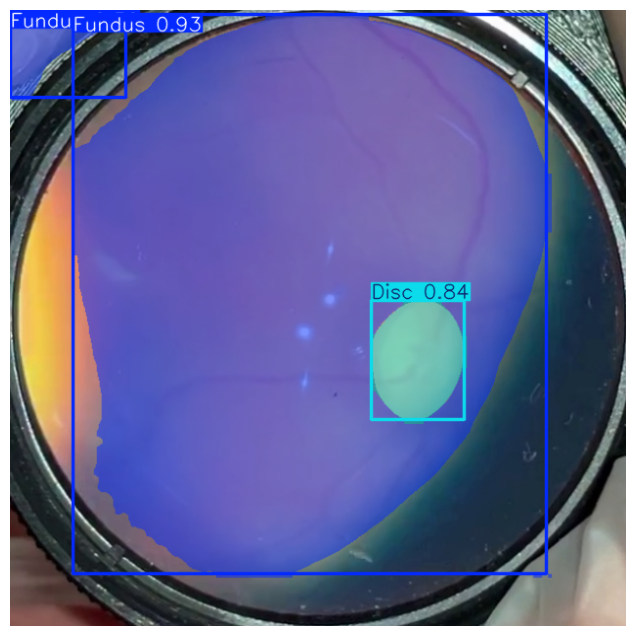

セグメンテーション結果をマージした画像として保存しました: segmentation_result.jpg
セグメンテーション座標データをテキストファイルに保存しました: segmentation_result.txt


In [41]:
from ultralytics import YOLO
import wget
import cv2
import numpy as np
import matplotlib.pyplot as plt

# モデルが未定義ならロードする
try:
    model  # 変数modelが定義されているか確認
except NameError:
    print("modelが未定義のため、ロードを実行します。")
    model = YOLO(r"C:\Users\ykita\ROP_AI_project\ROP_project\models\yolo11m-seg_1699-1703_internal_rotate.pt")
model = YOLO(r"C:\Users\ykita\ROP_AI_project\ROP_project\models\yolo11m-seg_1699-1703_internal_rotate.pt")


# 推論を実行: YOLOの推論
image_path = r"C:\Users\ykita\ROP_AI_project\ROP_project\data\ROP_image\IMG_1697_lens\IMG_1697_0151.jpg"
results = model(image_path, save=False)

# セグメンテーション結果をテキストファイルに保存するための関数
def save_segment_to_txt(masks, file_path):
    with open(file_path, 'w') as f:
        for i, mask in enumerate(masks):
            # マスクを2値化して座標を取得
            contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            
            # 各輪郭の座標を保存
            for contour in contours:
                # 画像サイズで正規化
                normalized_contour = contour.astype(float) / np.array([mask.shape[1], mask.shape[0]])
                # 輪郭の座標を書き込み
                f.write(f"{i} ") # クラスID
                for point in normalized_contour.reshape(-1, 2):
                    f.write(f"{point[0]:.6f} {point[1]:.6f} ")
                f.write("\n")

for r in results:
    # セグメンテーションマスクを取得
    masks = r.masks  # セグメンテーションマスク
    if masks is not None:
        # 結果を画像に描画して表示
        plt.figure(figsize=(12, 8))
        # セグメンテーション結果を含む画像を表示
        plotted_img = r.plot(boxes=True, masks=True)
        plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # マージした画像を保存
        save_img_path = 'segmentation_result.jpg'
        cv2.imwrite(save_img_path, plotted_img)
        print(f"セグメンテーション結果をマージした画像として保存しました: {save_img_path}")

        # セグメンテーション座標データを保存
        save_txt_path = 'segmentation_result.txt'
        save_segment_to_txt(masks.data.cpu().numpy(), save_txt_path)
        print(f"セグメンテーション座標データをテキストファイルに保存しました: {save_txt_path}")

0: 640x640 1 Fundus, 1 Disc, 373.1ms
Speed: 11.0ms preprocess, 373.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


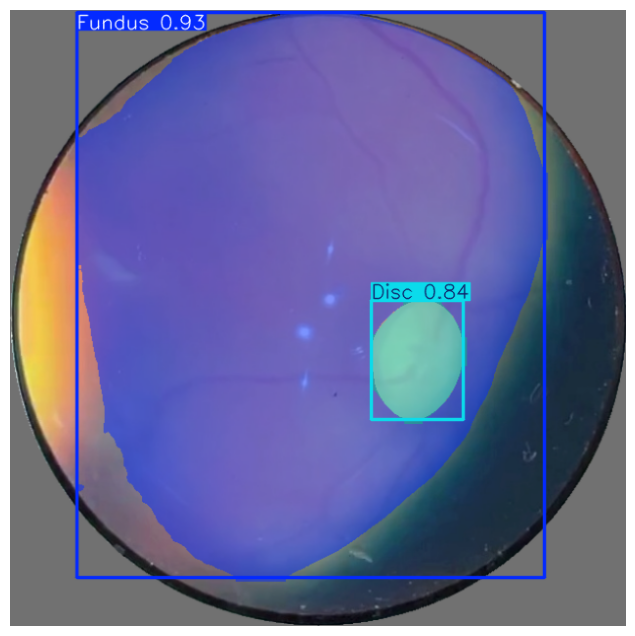

マスク処理後のセグメンテーション結果を保存しました: segmentation_result_masked.jpg
マスク処理後のセグメンテーション座標データを保存しました: segmentation_result_masked.txt


In [42]:
### 真ん中切り抜き後にinference
def create_circular_mask(image):
    """画像の中心から円形マスクを作成し、マスク外を灰色で塗りつぶす"""
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    radius = min(width, height) // 2

    # 円形マスクの作成
    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = dist_from_center <= radius
    
    # マスク外を灰色(114,114,114)で塗りつぶし
    masked_image = image.copy()
    masked_image[~mask] = [114, 114, 114]
    
    return masked_image

# 画像を読み込み
image = cv2.imread(image_path)

# 円形マスク処理を適用
masked_image = create_circular_mask(image)

# マスク処理後の画像で推論実行
results = model(masked_image, save=False)

for r in results:
    masks = r.masks
    if masks is not None:
        # 結果を画像に描画して表示
        plt.figure(figsize=(12, 8))
        plotted_img = r.plot(boxes=True, masks=True)
        plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # マージした画像を保存
        save_img_path = 'segmentation_result_masked.jpg'
        cv2.imwrite(save_img_path, plotted_img)
        print(f"マスク処理後のセグメンテーション結果を保存しました: {save_img_path}")

        # セグメンテーション座標データを保存
        save_txt_path = 'segmentation_result_masked.txt'
        save_segment_to_txt(masks.data.cpu().numpy(), save_txt_path)
        print(f"マスク処理後のセグメンテーション座標データを保存しました: {save_txt_path}")



0: 640x640 2 Funduss, 1 Disc, 80.0ms
Speed: 5.0ms preprocess, 80.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


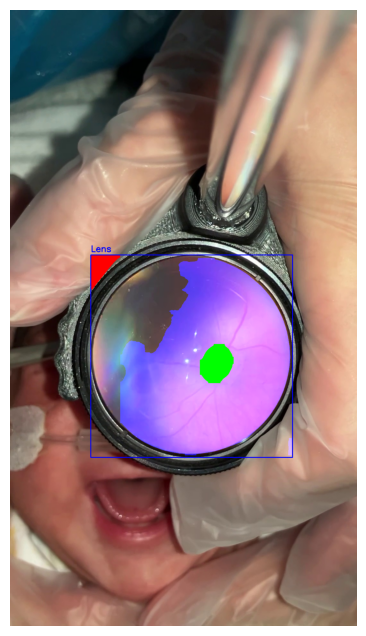

In [5]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_yolo_label(label_path):
    """YOLOフォーマットのラベルファイルを読み込む"""
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = int(data[0])
            x_center = float(data[1])
            y_center = float(data[2])
            width = float(data[3])
            height = float(data[4])
            boxes.append([class_id, x_center, y_center, width, height])
    return np.array(boxes)

def yolo_to_pixel_coords(box, img_width, img_height):
    """YOLO座標を画素座標に変換"""
    x_center = box[1] * img_width
    y_center = box[2] * img_height
    width = box[3] * img_width
    height = box[4] * img_height
    
    x1 = int(x_center - width/2)
    y1 = int(y_center - height/2)
    x2 = int(x_center + width/2)
    y2 = int(y_center + height/2)
    
    return [x1, y1, x2, y2]

def crop_and_inference(image_path, label_path, model_path):
    """画像の切り抜きと推論を実行"""
    # モデルのロード
    model = YOLO(model_path)
    
    # 画像の読み込み
    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]
    
    # ラベルの読み込み
    boxes = read_yolo_label(label_path)
    
    results_all = []
    
    # 各バウンディングボックスに対して処理
    for box in boxes:
        # YOLO座標を画素座標に変換
        x1, y1, x2, y2 = yolo_to_pixel_coords(box, img_width, img_height)
        
        # 画像の切り抜き
        cropped_img = image[y1:y2, x1:x2]
        
        # 推論実行
        results = model(cropped_img, save=False)
        
        # 結果を保存
        for r in results:
            if r.masks is not None:
                masks = r.masks.data.cpu().numpy()
                
                # 各クラスのマスクを個別に処理
                for class_idx in range(masks.shape[0]):
                    mask = masks[class_idx]
                    
                    # マスクのリサイズ
                    mask_resized = cv2.resize(mask.astype(np.float32), 
                                           (x2-x1, y2-y1))
                    
                    # パディング付きの空のマスク作成
                    full_mask = np.zeros((img_height, img_width), dtype=np.float32)
                    
                    # マスクを適切な位置に配置
                    full_mask[y1:y2, x1:x2] = mask_resized
                    
                    # 閾値処理
                    full_mask = (full_mask > 0.5).astype(np.uint8)
                    
                    results_all.append({
                        'class_id': class_idx,
                        'box': [x1, y1, x2, y2],
                        'masks': [full_mask]
                    })
    
    return results_all

def visualize_results(image_path, results):
    """結果の可視化"""
    # 画像の読み込み
    image = cv2.imread(image_path)
    
    # 結果の可視化
    colors = {
        0: (255, 0, 0),    # fundus: 青
        1: (0, 255, 0),    # disc: 緑
        2: (0, 0, 255)     # macula: 赤
    }
    
    # マスクを保存する配列
    masks_by_class = {
        0: None,  # fundus
        1: None,  # disc
        2: None   # macula
    }
    
    # クラスごとにマスクを集める
    for result in results:
        class_id = int(result['class_id'])
        if result['masks']:
            masks_by_class[class_id] = result['masks'][0]
    
    # まずfundusを描画
    if masks_by_class[0] is not None:
        fundus_mask = np.zeros_like(image)
        fundus_mask[masks_by_class[0] > 0] = colors[0]
        image = cv2.addWeighted(image, 1, fundus_mask, 0.7, 0)  # 透明度を0.7に増加
    
    # disc と maculaを不透明で描画
    for class_id in [1, 2]:  # disc, macula
        if masks_by_class[class_id] is not None:
            mask = masks_by_class[class_id]
            image[mask > 0] = colors[class_id]
    
    # バウンディングボックスとラベルの描画
    for result in results:
        if result['class_id'] == 0:  # fundusのバウンディングボックスのみ描画
            box = result['box']
            x1, y1, x2, y2 = box
            cv2.rectangle(image, (x1, y1), (x2, y2), colors[0], 2)
            cv2.putText(image, "Lens", (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[0], 2)
    
    return image

def save_segment_to_txt(masks, file_path):
    """セグメンテーション結果をテキストファイルに保存"""
    with open(file_path, 'w') as f:
        for i, mask in enumerate(masks):
            # マスクを2値化して座標を取得
            contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, 
                                         cv2.CHAIN_APPROX_SIMPLE)
            
            # 各輪郭の座標を保存
            for contour in contours:
                # 画像サイズで正規化
                normalized_contour = contour.astype(float) / np.array([mask.shape[1], mask.shape[0]])
                # 輪郭の座標を書き込み
                f.write(f"{i} ") # クラスID
                for point in normalized_contour.reshape(-1, 2):
                    f.write(f"{point[0]:.6f} {point[1]:.6f} ")
                f.write("\n")

def process_image(image_path, label_path, model_path, output_path=None, save_txt=False):
    """画像処理のメイン関数"""
    # 推論実行
    results = crop_and_inference(image_path, label_path, model_path)
    
    # 結果の可視化
    output_image = visualize_results(image_path, results)
    
    # 結果の保存
    if output_path:
        cv2.imwrite(output_path, output_image)
    
    # セグメンテーション座標の保存
    if save_txt:
        txt_path = output_path.rsplit('.', 1)[0] + '.txt' if output_path else 'segmentation_result.txt'
        all_masks = []
        for result in results:
            all_masks.extend(result['masks'])
        save_segment_to_txt(all_masks, txt_path)
    
    return output_image

# 使用例
if __name__ == "__main__":
    image_path = r'C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1697\IMG_1697_0118.jpg'
    label_path = r'C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1697\IMG_1697_0118.txt'
    model_path = r'C:\Users\ykita\ROP_AI_project\models\yolo11m-seg_1699+1702-1703.pt'
    
    # 画像処理の実行
    output_image = process_image(
        image_path=image_path,
        label_path=label_path,
        model_path=model_path,
        output_path='merged_segmentation_result.jpg',
        save_txt=True
    )
    
    # 結果の表示
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [16]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
from tqdm import tqdm
from pathlib import Path

def read_yolo_label(label_path):
    """YOLOフォーマットのラベルファイルを読み込む"""
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = int(data[0])
            x_center = float(data[1])
            y_center = float(data[2])
            width = float(data[3])
            height = float(data[4])
            boxes.append([class_id, x_center, y_center, width, height])
    return np.array(boxes)

def yolo_to_pixel_coords(box, img_width, img_height):
    """YOLO座標を画素座標に変換"""
    x_center = box[1] * img_width
    y_center = box[2] * img_height
    width = box[3] * img_width
    height = box[4] * img_height
    
    x1 = int(x_center - width/2)
    y1 = int(y_center - height/2)
    x2 = int(x_center + width/2)
    y2 = int(y_center + height/2)
    
    return [x1, y1, x2, y2]

def save_segment_to_txt(masks, txt_path):
    """
    セグメンテーション結果をテキストファイルに保存する（プレースホルダー）。
    必要に応じて、マスクから座標を抽出するロジックを実装してください。
    """
    # 例: print(f"Saving {len(masks)} masks to {txt_path}")
    pass # この関数は必要に応じて実装してください

def crop_and_inference(image_path, label_path, model):
    """
    【高速化対応】画像の切り抜きとバッチ推論を実行する。
    modelオブジェクトを引数で受け取るように変更。
    """
    # 画像の読み込み
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}. Skipping.")
        return []
    img_height, img_width = image.shape[:2]
    
    # ラベルの読み込み
    boxes = read_yolo_label(label_path)
    
    cropped_images = []
    pixel_coords_list = []
    
    # 各バウンディングボックスで画像を切り抜き、リストに保存
    for box in boxes:
        x1, y1, x2, y2 = yolo_to_pixel_coords(box, img_width, img_height)
        # 座標が画像の範囲内にあることを確認
        if x1 < x2 and y1 < y2:
            cropped_img = image[y1:y2, x1:x2]
            cropped_images.append(cropped_img)
            pixel_coords_list.append((x1, y1, x2, y2))
    
    results_all = []
    
    # 【高速化】切り抜いた画像のリストでバッチ（一括）推論を実行
    if cropped_images:
        # half=Trueで半精度推論、verbose=Falseでログ出力を抑制し高速化
        results_batch = model(cropped_images, save=False, half=True, verbose=False) 
        
        # バッチ処理された結果をループ処理
        for i, r in enumerate(results_batch):
            if r.masks is not None:
                masks_data = r.masks.data.cpu().numpy()
                x1, y1, x2, y2 = pixel_coords_list[i]
                
                for class_idx in range(masks_data.shape[0]):
                    mask = masks_data[class_idx]
                    
                    # マスクのリサイズ
                    mask_resized = cv2.resize(mask.astype(np.float32), (x2 - x1, y2 - y1))
                    
                    # パディング付きの空のマスク作成
                    full_mask = np.zeros((img_height, img_width), dtype=np.float32)
                    
                    # マスクを適切な位置に配置
                    full_mask[y1:y2, x1:x2] = mask_resized
                    
                    # 閾値処理
                    full_mask = (full_mask > 0.5).astype(np.uint8)
                    
                    # YOLOv8の結果オブジェクトからクラスIDを取得
                    detected_class_id = int(r.boxes.cls[class_idx])

                    results_all.append({
                        'class_id': detected_class_id,
                        'box': [x1, y1, x2, y2],
                        'masks': [full_mask]
                    })
    
    return results_all

def visualize_results(image_path, results):
    """結果の可視化"""
    image = cv2.imread(image_path)
    
    colors = {
        0: (255, 0, 0),    # fundus: 青
        1: (0, 255, 0),    # disc: 緑
        2: (0, 0, 255)     # macula: 赤
    }
    default_color = (255, 255, 255) # 未知のクラスID用の色

    masks_by_class = {}
    
    # クラスごとにマスクを集める
    for result in results:
        class_id = int(result['class_id'])
        if result['masks']:
            if class_id not in masks_by_class:
                masks_by_class[class_id] = []
            masks_by_class[class_id].append(result['masks'][0])

    # まずfundus (class_id 0) を半透明で描画
    if 0 in masks_by_class:
        for mask_data in masks_by_class[0]:
            fundus_mask = np.zeros_like(image)
            fundus_mask[mask_data > 0] = colors.get(0)
            image = cv2.addWeighted(image, 1.0, fundus_mask, 0.7, 0)

    # disc (1) と macula (2) を不透明で描画
    for class_id in [1, 2]:
        if class_id in masks_by_class:
            for mask_data in masks_by_class[class_id]:
                color = colors.get(class_id, default_color)
                image[mask_data > 0] = color

    # バウンディングボックスとラベルの描画
    for result in results:
        if result['class_id'] == 0:  # fundusのバウンディングボックスのみ描画
            box = result['box']
            x1, y1, x2, y2 = box
            color = colors.get(0, default_color)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, "Lens", (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            
    return image

def process_image(image_path, label_path, model, output_path=None, save_txt=False):
    """
    【高速化対応】画像処理のメイン関数。
    modelオブジェクトを引数で受け取り、下の関数に渡すように変更。
    """
    # 推論実行（modelオブジェクトを渡す）
    results = crop_and_inference(image_path, label_path, model)
    
    # 結果の可視化
    output_image = visualize_results(image_path, results)
    
    # 結果の保存
    if output_path:
        cv2.imwrite(output_path, output_image)
    
    # セグメンテーション座標の保存
    if save_txt:
        txt_path = Path(output_path).with_suffix('.txt') if output_path else 'segmentation_result.txt'
        all_masks = [res['masks'][0] for res in results if res.get('masks')]
        if all_masks:
            save_segment_to_txt(all_masks, str(txt_path))
    
    return output_image

def process_folder_to_video(image_dir, label_dir, model_path, output_video_path, fps=30):
    """
    【高速化対応】フォルダ内の画像を処理して動画を生成する。
    モデルの読み込みをループの外で一度だけ行うように変更。
    """
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    if not image_files:
        raise ValueError("指定されたディレクトリに画像ファイルが見つかりません。")
    
    # 最初の画像を読み込んでサイズを取得
    first_image = cv2.imread(os.path.join(image_dir, image_files[0]))
    height, width = first_image.shape[:2]
    
    # VideoWriterの設定
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # 【高速化】モデルのロードはここで一度だけ行う
    print("モデルを読み込んでいます...")
    model = YOLO(model_path)
    # GPUが利用可能な場合は、次の行のコメントを解除してGPUを使用
    # model.to('cuda')
    print("モデルの読み込みが完了しました。")
    
    # 各画像に対して処理を実行
    for image_file in tqdm(image_files, desc="画像を処理中"):
        image_path = os.path.join(image_dir, image_file)
        label_file = Path(image_file).stem + '.txt'
        label_path = os.path.join(label_dir, label_file)
        
        if not os.path.exists(label_path):
            print(f"警告: {image_file} に対応するラベルファイルが見つかりません。スキップします...")
            continue
        
        try:
            # 【高速化】画像処理の実行（ロード済みのmodelオブジェクトを渡す）
            processed_frame = process_image(
                image_path=image_path,
                label_path=label_path,
                model=model,
                output_path=None,  # 個別の画像は保存しない
                save_txt=False     # テキストファイルも保存しない
            )
            
            # フレームを動画に書き込み
            out.write(processed_frame)
            
        except Exception as e:
            print(f"{image_file} の処理中にエラーが発生しました: {str(e)}")
            continue
            
    # リソースの解放
    out.release()
    print(f"動画が {output_video_path} に保存されました。")

# メイン処理
if __name__ == "__main__":
    # パスはご自身の環境に合わせて変更してください
    image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_project\data\ROP_image\IMG_1697"
    label_dir = r"C:\Users\ykita\ROP_AI_project\ROP_project\data\ROP_image\LABELS_1697"
    model_path = r"C:\Users\ykita\ROP_AI_project\ROP_project\models\yolo11m-seg_1699-1703_internal_rotate.pt"
    output_video_path = r"C:\Users\ykita\ROP_AI_project\ROP_project\outputs\1697_segmentation_inference_fast.mp4"
    
    # 出力ディレクトリが存在しない場合は作成
    Path(output_video_path).parent.mkdir(parents=True, exist_ok=True)

    # フォルダ内の画像を処理して動画を生成
    process_folder_to_video(
        image_dir=image_dir,
        label_dir=label_dir,
        model_path=model_path,
        output_video_path=output_video_path,
        fps=30
    )

モデルを読み込んでいます...
モデルの読み込みが完了しました。


画像を処理中: 100%|██████████| 1035/1035 [04:59<00:00,  3.45it/s]

動画が C:\Users\ykita\ROP_AI_project\ROP_project\outputs\1697_segmentation_inference_fast.mp4 に保存されました。


In [47]:
import torch
import cv2
import numpy as np
import os
import time
from ultralytics import YOLO, RTDETR
from tqdm import tqdm

# --- 1. ヘルパー関数 ---

def apply_circular_mask(image_to_mask):
    """
    入力画像に対し、中心基準の円形マスクを適用し、マスク外を灰色(114,114,114)で塗りつぶす。
    """
    if image_to_mask is None or image_to_mask.size == 0:
        return None
        
    height, width = image_to_mask.shape[:2]
    center = (width // 2, height // 2)
    radius = min(width, height) // 2

    # まず全体が灰色の画像を作成
    masked_image = np.full(image_to_mask.shape, (114, 114, 114), dtype=np.uint8)
    
    # 元の画像から円形部分をコピーするためのマスクを作成
    circle_mask = np.zeros((height, width), dtype=np.uint8)
    cv2.circle(circle_mask, center, radius, 255, -1)
    
    # copyToで円形部分のみをコピー
    masked_image = cv2.copyTo(image_to_mask, circle_mask, masked_image)
    
    return masked_image

def save_segment_to_txt(masks, clss, file_path, full_img_shape, crop_info):
    """
    セグメンテーションマスクの輪郭座標を正規化してYOLO形式でテキストファイルに保存する。
    """
    full_h, full_w = full_img_shape[:2]
    offset_x, offset_y = crop_info['offset_xy']
    orig_crop_w, orig_crop_h = crop_info['orig_crop_shape']
    resized_crop_w, resized_crop_h = crop_info['resized_crop_shape']

    scale_x = orig_crop_w / resized_crop_w
    scale_y = orig_crop_h / resized_crop_h

    with open(file_path, 'w') as f:
        for i in range(len(masks)):
            # ★★★ 修正 ★★★
            # YOLOのクラスID(0:Disc, 1:Macula)を、定義(2:Disc, 3:Macula)に合わせる
            class_id = int(clss[i]) + 2
            mask = masks[i]
            
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours: continue
            contour = max(contours, key=cv2.contourArea)

            contour = (contour.astype(float) * np.array([scale_x, scale_y])).astype(int)
            contour[:, :, 0] += offset_x
            contour[:, :, 1] += offset_y
            normalized_contour = (contour.astype(float) / np.array([full_w, full_h])).flatten()
            
            f.write(f"{class_id} ")
            f.write(" ".join(f"{p:.6f}" for p in normalized_contour))
            f.write("\n")

def draw_results_on_canvas(canvas, seg_results, lens_bbox_xyxy):
    """
    フルサイズのキャンバスに、セグメンテーション結果とバウンディングボックスを描画する。
    """
    # ★★★ 修正 ★★★: ご指定の色の定義に変更
    colors = {1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255)} # 1:Fundus, 2:Disc, 3:Macula

    if seg_results and seg_results[0].masks and lens_bbox_xyxy is not None:
        lx1, ly1, lx2, ly2 = [int(c) for c in lens_bbox_xyxy]
        actual_crop_w = lx2 - lx1
        actual_crop_h = ly2 - ly1

        r = seg_results[0]
        for box, mask_data in zip(r.boxes, r.masks.data):
            # ★★★ 修正 ★★★
            # YOLOのクラスID(0:Disc, 1:Macula)を、定義(2:Disc, 3:Macula)に合わせる
            class_id = int(box.cls) + 2 
            color = colors.get(class_id, (255,255,255)) # 見つからない場合は白
            
            if actual_crop_w > 0 and actual_crop_h > 0:
                full_res_mask = cv2.resize(mask_data.cpu().numpy(), (actual_crop_w, actual_crop_h))
                boolean_mask = full_res_mask > 0.5
                crop_area = canvas[ly1:ly2, lx1:lx2]
                crop_area[boolean_mask] = color

    if lens_bbox_xyxy is not None:
        # ★★★ 修正 ★★★: Fundus(クラス1)の色で描画
        color = colors.get(1)
        x1, y1, x2, y2 = [int(c) for c in lens_bbox_xyxy]
        cv2.rectangle(canvas, (x1, y1), (x2, y2), color, 2)
        cv2.putText(canvas, "Fundus (RT-DETR)", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
    return canvas

# --- 2. 動画生成のメイン関数 ---
def create_video_with_masked_resized_crop(image_dir, detection_model, segmentation_model, output_video_path, output_txt_dir, fps=30, resize_target_width=None):
    YOLO_INPUT_WIDTH = 640

    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    if not image_files: raise ValueError("画像ファイルが見つかりません。")

    first_image = cv2.imread(os.path.join(image_dir, image_files[0]))
    if resize_target_width:
        h, w, _ = first_image.shape
        aspect_ratio = h / w
        new_w, new_h = resize_target_width, int(resize_target_width * aspect_ratio)
        output_width, output_height = new_w, new_h
    else:
        output_height, output_width, _ = first_image.shape

    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (output_width, output_height))

    for image_file in tqdm(image_files, desc="動画と座標テキストを生成中"):
        try:
            image_original = cv2.imread(os.path.join(image_dir, image_file))
            if image_original is None: continue
            
            full_frame = cv2.resize(image_original, (output_width, output_height), interpolation=cv2.INTER_AREA)

            det_results = detection_model(full_frame, verbose=False)
            lens_bbox_xyxy = next((r.boxes[i].xyxy[0].cpu().numpy() for r in det_results for i in range(len(r.boxes)) if int(r.boxes[i].cls) == 0), None)

            if lens_bbox_xyxy is None:
                out.write(full_frame)
                continue

            x1, y1, x2, y2 = [int(c) for c in lens_bbox_xyxy]
            cropped_image = full_frame[y1:y2, x1:x2]
            
            orig_crop_h, orig_crop_w = cropped_image.shape[:2]
            if orig_crop_h == 0 or orig_crop_w == 0:
                out.write(full_frame)
                continue
            
            # ★★★ 追加 ★★★: クロップ画像に円形マスクを適用
            masked_crop = apply_circular_mask(cropped_image)
            if masked_crop is None: continue

            # マスク適用後の画像をYOLOの入力サイズにリサイズ
            aspect_ratio = orig_crop_h / orig_crop_w
            yolo_input_h = int(YOLO_INPUT_WIDTH * aspect_ratio)
            yolo_input_image = cv2.resize(masked_crop, (YOLO_INPUT_WIDTH, yolo_input_h), interpolation=cv2.INTER_AREA)
            
            seg_results = segmentation_model(yolo_input_image, verbose=False, half=True)
            
            final_canvas = full_frame.copy()

            if seg_results and seg_results[0].masks:
                crop_info = {
                    'offset_xy': (x1, y1),
                    'orig_crop_shape': (orig_crop_w, orig_crop_h),
                    'resized_crop_shape': (YOLO_INPUT_WIDTH, yolo_input_h)
                }
                txt_filename = f"{os.path.splitext(image_file)[0]}.txt"
                txt_filepath = os.path.join(output_txt_dir, txt_filename)
                save_segment_to_txt(
                    masks=seg_results[0].masks.data.cpu().numpy(),
                    clss=seg_results[0].boxes.cls.cpu().numpy(),
                    file_path=txt_filepath,
                    full_img_shape=full_frame.shape,
                    crop_info=crop_info
                )

            final_canvas = draw_results_on_canvas(final_canvas, seg_results, lens_bbox_xyxy)
            out.write(final_canvas)

        except Exception as e:
            print(f"{image_file} の処理中にエラーが発生しました: {e}")
            continue

    out.release()
    print(f"\n動画の生成が完了しました: {output_video_path}")
    print(f"座標テキストの保存が完了しました: {output_txt_dir}")

# --- 3. メイン処理の実行 ---
if __name__ == "__main__":
    VIDEO_FRAME_WIDTH = 640
    FPS = 30

    base_project_dir = r"C:\Users\ykita\ROP_AI_project"
    image_dir = os.path.join(base_project_dir, r"ROP_project\data\ROP_image\IMG_1697")
    detection_model_path = os.path.join(base_project_dir, r"ROP_project\models\rtdetr-l-1697_1703.pt")
    segmentation_model_path = os.path.join(base_project_dir, r"ROP_project\models\yolo11m-seg_1699-1703_internal_rotate.pt")
    
    output_dir = os.path.join(base_project_dir, r"ROP_project\outputs")
    image_folder_name = os.path.basename(image_dir)
    output_txt_dir = os.path.join(output_dir, f"{image_folder_name}_segmentation_txts_final")
    
    resize_suffix = f"w{VIDEO_FRAME_WIDTH}" if VIDEO_FRAME_WIDTH else "original"
    output_filename = f"{image_folder_name}_video_final_{resize_suffix}.mp4"
    output_video_path = os.path.join(output_dir, output_filename)

    is_available = torch.cuda.is_available()
    print(f"CUDAは利用可能か？: {is_available}")

    print("\nモデルを読み込んでいます...")
    start_load = time.time()
    detection_model = RTDETR(detection_model_path)
    segmentation_model = YOLO(segmentation_model_path)
    if is_available:
        detection_model.to('cuda')
        segmentation_model.to('cuda')
    print(f"モデル読み込み完了。({time.time() - start_load:.2f} 秒)")
    
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_txt_dir, exist_ok=True)
    
    create_video_with_masked_resized_crop(
        image_dir=image_dir,
        detection_model=detection_model,
        segmentation_model=segmentation_model,
        output_video_path=output_video_path,
        output_txt_dir=output_txt_dir,
        fps=FPS,
        resize_target_width=VIDEO_FRAME_WIDTH
    )

CUDAは利用可能か？: True

モデルを読み込んでいます...
モデル読み込み完了。(0.99 秒)


動画と座標テキストを生成中: 100%|██████████| 1035/1035 [09:28<00:00,  1.82it/s]


動画の生成が完了しました: C:\Users\ykita\ROP_AI_project\ROP_project\outputs\IMG_1697_video_final_w640.mp4
座標テキストの保存が完了しました: C:\Users\ykita\ROP_AI_project\ROP_project\outputs\IMG_1697_segmentation_txts_final


In [71]:
import torch
import cv2
import numpy as np
import os
import time
from ultralytics import YOLO, RTDETR
from tqdm import tqdm

# ===================================================================
# ★★★★★★★★★★★★★★★★★ 最終修正版マッピング ★★★★★★★★★★★★★★★★★★
# 実際のモデルの出力に合わせて、クラスIDと部位の対応を修正しました。
# ===================================================================
# YOLO(セグメンテーションモデル)が検出するクラスID -> 部位の名前
CLASS_ID_TO_NAME = {
    0: "Fundus",  # ID 0 は Fundus
    1: "Disc",    # ID 1 は Disc
    2: "Macula",  # ID 2 は Macula
}

# 部位の名前 -> 描画する色 (B, G, R の順)
# ご希望の色: Lens BBox:青, Fundus:青, Disc:緑, Macula:赤
NAME_TO_COLOR = {
    "Lens_BBox": (255, 0, 0),   # Lensの四角枠の色 -> 青
    "Fundus":    (255, 0, 0),   # Fundusの塗りつぶし -> 青 ★ここを修正しました
    "Disc":      (0, 255, 0),   # Discの塗りつぶし -> 緑
    "Macula":    (0, 0, 255),   # Maculaの塗りつぶし -> 赤
}

# 部位の名前 -> テキストファイルに保存するときのID
NAME_TO_SAVE_ID = {
    "Fundus": 1,
    "Disc":   2,
    "Macula": 3,
}
# ===================================================================


# --- 1. ヘルパー関数 ---

def apply_circular_mask(image_to_mask):
    """
    入力画像に対し、中心基準の円形マスクを適用し、マスク外を灰色(114,114,114)で塗りつぶす。
    """
    if image_to_mask is None or image_to_mask.size == 0:
        return None
        
    height, width = image_to_mask.shape[:2]
    center = (width // 2, height // 2)
    radius = min(width, height) // 2

    masked_image = np.full(image_to_mask.shape, (114, 114, 114), dtype=np.uint8)
    
    circle_mask = np.zeros((height, width), dtype=np.uint8)
    cv2.circle(circle_mask, center, radius, 255, -1)
    
    masked_image = cv2.copyTo(image_to_mask, circle_mask, masked_image)
    
    return masked_image

def save_segment_to_txt(yolo_results, file_path, full_img_shape, crop_info):
    """
    YOLOのセグメンテーション結果(正規化済輪郭)を、全体画像基準の座標に再計算してテキスト保存する。
    """
    full_h, full_w = full_img_shape[:2]
    offset_x, offset_y = crop_info['offset_xy']

    if not yolo_results or not yolo_results[0].masks:
        return

    with open(file_path, 'w') as f:
        result = yolo_results[0]
        for i in range(len(result.masks)):
            yolo_class = int(result.boxes[i].cls)
            part_name = CLASS_ID_TO_NAME.get(yolo_class)
            if not part_name: continue

            save_id = NAME_TO_SAVE_ID.get(part_name)
            if not save_id: continue

            normalized_contour_in_crop = result.masks.xyn[i]
            points = normalized_contour_in_crop.reshape(-1, 2)
            
            points[:, 0] *= crop_info['resized_crop_shape'][0] # resized_w
            points[:, 1] *= crop_info['resized_crop_shape'][1] # resized_h
            
            points[:, 0] *= (crop_info['orig_crop_shape'][0] / crop_info['resized_crop_shape'][0])
            points[:, 1] *= (crop_info['orig_crop_shape'][1] / crop_info['resized_crop_shape'][1])

            points[:, 0] += offset_x
            points[:, 1] += offset_y

            points[:, 0] /= full_w
            points[:, 1] /= full_h

            final_normalized_contour = points.flatten()
            
            f.write(f"{save_id} ")
            f.write(" ".join(f"{p:.6f}" for p in final_normalized_contour))
            f.write("\n")

def draw_results_on_canvas(canvas, rtdetr_bbox, yolo_results):
    """
    フルサイズのキャンバスに、RT-DETRのBBoxとYOLOのセグメンテーションマスクを描画する。
    """
    # 1. RT-DETRのBBoxを青色で描画 (ラベルを修正)
    if rtdetr_bbox is not None:
        x1, y1, x2, y2 = [int(c) for c in rtdetr_bbox]
        bbox_color = NAME_TO_COLOR["Lens_BBox"]
        cv2.rectangle(canvas, (x1, y1), (x2, y2), bbox_color, 2)
        cv2.putText(canvas, "Lens BBox", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bbox_color, 2)

    # 2. YOLOのセグメンテーション結果をBBox内に描画
    if yolo_results and yolo_results[0].masks and rtdetr_bbox is not None:
        lx1, ly1, lx2, ly2 = [int(c) for c in rtdetr_bbox]
        crop_w, crop_h = lx2 - lx1, ly2 - ly1

        if crop_w > 0 and crop_h > 0:
            result = yolo_results[0]
            overlay = canvas.copy()

            for i in range(len(result.masks)):
                yolo_class = int(result.boxes[i].cls)
                part_name = CLASS_ID_TO_NAME.get(yolo_class, "不明")
                color_to_draw = NAME_TO_COLOR.get(part_name)

                if not color_to_draw: continue

                mask_data = result.masks.data[i].cpu().numpy()
                mask_resized = cv2.resize(mask_data, (crop_w, crop_h))
                
                crop_area_on_overlay = overlay[ly1:ly2, lx1:lx2]
                crop_area_on_overlay[mask_resized > 0.5] = color_to_draw
            
            canvas = cv2.addWeighted(overlay, 0.5, canvas, 0.5, 0)

    return canvas

# --- 2. メインの処理関数 (変更なし) ---
def create_video_with_masked_resized_crop(image_dir, detection_model, segmentation_model, output_video_path, output_txt_dir, fps=30, resize_target_width=None):
    YOLO_INPUT_WIDTH = 640

    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    if not image_files: raise ValueError("画像ファイルが見つかりません。")

    first_image = cv2.imread(os.path.join(image_dir, image_files[0]))
    if resize_target_width:
        h, w, _ = first_image.shape
        aspect_ratio = h / w
        new_w, new_h = resize_target_width, int(resize_target_width * aspect_ratio)
        output_width, output_height = new_w, new_h
    else:
        output_height, output_width, _ = first_image.shape

    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (output_width, output_height))

    for image_file in tqdm(image_files, desc="動画と座標テキストを生成中"):
        try:
            image_original = cv2.imread(os.path.join(image_dir, image_file))
            if image_original is None: continue
            
            full_frame = cv2.resize(image_original, (output_width, output_height), interpolation=cv2.INTER_AREA)

            det_results = detection_model(full_frame, verbose=False)
            lens_bbox_xyxy = next((r.boxes[i].xyxy[0].cpu().numpy() for r in det_results for i in range(len(r.boxes)) if int(r.boxes[i].cls) == 0), None)

            if lens_bbox_xyxy is None:
                out.write(full_frame)
                continue

            x1, y1, x2, y2 = [int(c) for c in lens_bbox_xyxy]
            cropped_image = full_frame[y1:y2, x1:x2]
            
            orig_crop_h, orig_crop_w = cropped_image.shape[:2]
            if orig_crop_h == 0 or orig_crop_w == 0:
                final_canvas = draw_results_on_canvas(full_frame.copy(), lens_bbox_xyxy, None)
                out.write(final_canvas)
                continue
            
            masked_crop = apply_circular_mask(cropped_image)
            if masked_crop is None: continue

            aspect_ratio = orig_crop_h / orig_crop_w
            yolo_input_h = int(YOLO_INPUT_WIDTH * aspect_ratio)
            yolo_input_image = cv2.resize(masked_crop, (YOLO_INPUT_WIDTH, yolo_input_h), interpolation=cv2.INTER_AREA)
            
            seg_results = segmentation_model(yolo_input_image, verbose=False, half=True)
            
            if seg_results and seg_results[0].masks:
                crop_info = {
                    'offset_xy': (x1, y1),
                    'orig_crop_shape': (orig_crop_w, orig_crop_h),
                    'resized_crop_shape': (YOLO_INPUT_WIDTH, yolo_input_h)
                }
                txt_filename = f"{os.path.splitext(image_file)[0]}.txt"
                txt_filepath = os.path.join(output_txt_dir, txt_filename)
                save_segment_to_txt(
                    yolo_results=seg_results,
                    file_path=txt_filepath,
                    full_img_shape=full_frame.shape,
                    crop_info=crop_info
                )

            final_canvas = draw_results_on_canvas(full_frame.copy(), lens_bbox_xyxy, seg_results)
            out.write(final_canvas)

        except Exception as e:
            print(f"\n{image_file} の処理中にエラーが発生しました: {e}")
            import traceback
            traceback.print_exc()
            continue

    out.release()
    print(f"\n動画の生成が完了しました: {output_video_path}")
    print(f"座標テキストの保存が完了しました: {output_txt_dir}")

# --- 3. メイン処理の実行 (変更なし) ---
if __name__ == "__main__":
    VIDEO_FRAME_WIDTH = 640
    FPS = 30

    base_project_dir = r"C:\Users\ykita\ROP_AI_project"
    image_dir = os.path.join(base_project_dir, r"ROP_project\data\ROP_image\IMG_1696")
    detection_model_path = os.path.join(base_project_dir, r"ROP_project\models\rtdetr-l-1697_1703.pt")
    segmentation_model_path = os.path.join(base_project_dir, r"ROP_project\models\yolo11m-seg_1699-1703_internal_rotate.pt")
    
    output_dir = os.path.join(base_project_dir, r"ROP_project\outputs")
    image_folder_name = os.path.basename(image_dir)
    output_txt_dir = os.path.join(output_dir, f"{image_folder_name}_segmentation_texts")
    
    resize_suffix = f"w{VIDEO_FRAME_WIDTH}" if VIDEO_FRAME_WIDTH else "original"
    output_filename = f"{image_folder_name}_processed_video_{resize_suffix}.mp4"
    output_video_path = os.path.join(output_dir, output_filename)

    is_available = torch.cuda.is_available()
    print(f"CUDAは利用可能か？: {is_available}")

    print("\nモデルを読み込んでいます...")
    start_load = time.time()
    detection_model = RTDETR(detection_model_path)
    segmentation_model = YOLO(segmentation_model_path)
    if is_available:
        device = 'cuda'
        detection_model.to(device)
        segmentation_model.to(device)
        print(f"モデルを {device} にロードしました。")
    print(f"モデル読み込み完了。({time.time() - start_load:.2f} 秒)")
    
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_txt_dir, exist_ok=True)
    
    create_video_with_masked_resized_crop(
        image_dir=image_dir,
        detection_model=detection_model,
        segmentation_model=segmentation_model,
        output_video_path=output_video_path,
        output_txt_dir=output_txt_dir,
        fps=FPS,
        resize_target_width=VIDEO_FRAME_WIDTH
    )

CUDAは利用可能か？: True

モデルを読み込んでいます...
モデルを cuda にロードしました。
モデル読み込み完了。(1.59 秒)


動画と座標テキストを生成中: 100%|██████████| 1081/1081 [10:06<00:00,  1.78it/s]


動画の生成が完了しました: C:\Users\ykita\ROP_AI_project\ROP_project\outputs\IMG_1696_processed_video_w640.mp4
座標テキストの保存が完了しました: C:\Users\ykita\ROP_AI_project\ROP_project\outputs\IMG_1696_segmentation_texts


### Single image

In [67]:
import torch
import cv2
import numpy as np
import os
import time
from ultralytics import YOLO, RTDETR

# ===================================================================
# ★★★★★★★★★★★★★★★★★ 設定マッピング ★★★★★★★★★★★★★★★★★★
# モデルのクラスIDと、実際の部位・色をここで対応付けます。
# 実行後、もし色が違う場合は、この中の設定を修正してください。
# ===================================================================
# YOLOが検出するクラスID -> 部位の名前
CLASS_ID_TO_NAME = {
    0: "Fundus",  # ID 0 は Fundus
    1: "Disc",    # ID 1 は Disc
    2: "Macula",  # ID 2 は Macula
}

# 部位の名前 -> 描画する色 (B, G, R の順)
# ご希望の色: Lens BBox:青, Disc:緑, Macula:赤
NAME_TO_COLOR = {
    "Lens_BBox": (255, 0, 0),   # Lensの四角枠の色 -> 青
    "Fundus":    (255, 0, 0),   # Fundusの塗りつぶし -> 青
    "Disc":      (0, 255, 0),   # Discの塗りつぶし -> 緑
    "Macula":    (0, 0, 255),   # Maculaの塗りつぶし -> 赤
}

# 部位の名前 -> テキストファイルに保存するときのID
NAME_TO_SAVE_ID = {
    "Fundus": 1,
    "Disc":   2,
    "Macula": 3,
}
# ===================================================================

def draw_final_results(canvas, rtdetr_bbox, yolo_results):
    """
    RT-DETRのBBoxとYOLOのセグメンテーションマスクを描画する (KeyError修正版)
    """
    # 1. RT-DETRのBBoxを青色で描画
    x1, y1, x2, y2 = [int(c) for c in rtdetr_bbox]
    bbox_color = NAME_TO_COLOR["Lens_BBox"]
    cv2.rectangle(canvas, (x1, y1), (x2, y2), bbox_color, 2)
    cv2.putText(canvas, "Lens BBox", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bbox_color, 2)

    # 2. YOLOのセグメンテーション結果をBBox内に描画
    if yolo_results and yolo_results[0].masks:
        result = yolo_results[0]
        crop_w, crop_h = x2 - x1, y2 - y1

        # 描画用に半透明のオーバーレイを作成
        overlay = canvas.copy()

        for i in range(len(result.masks)):
            # クラスIDから部位の名前と色を取得
            yolo_class = int(result.boxes[i].cls)
            part_name = CLASS_ID_TO_NAME.get(yolo_class, "不明")
            color_to_draw = NAME_TO_COLOR.get(part_name)

            if not color_to_draw: continue

            # マスクを切り抜き領域のサイズにリサイズ
            mask_data = result.masks.data[i].cpu().numpy()
            mask_resized = cv2.resize(mask_data, (crop_w, crop_h))
            
            # オーバーレイの該当領域に色を付ける
            crop_area_on_overlay = overlay[y1:y2, x1:x2]
            crop_area_on_overlay[mask_resized > 0.5] = color_to_draw
        
        # 元のキャンバスにオーバーレイを合成
        canvas = cv2.addWeighted(overlay, 0.5, canvas, 0.5, 0)

    return canvas


def save_yolo_results_to_txt(yolo_results, file_path, full_img_shape, crop_info):
    """
    YOLOのセグメンテーション結果を正規化してテキスト保存する
    """
    full_h, full_w = full_img_shape
    offset_x, offset_y = crop_info['offset_xy']

    if not yolo_results or not yolo_results[0].masks:
        return

    with open(file_path, 'w') as f:
        result = yolo_results[0]
        for i in range(len(result.masks)):
            yolo_class = int(result.boxes[i].cls)
            part_name = CLASS_ID_TO_NAME.get(yolo_class)
            if not part_name: continue

            save_id = NAME_TO_SAVE_ID.get(part_name)
            if not save_id: continue

            # 座標は既にYOLOの入力画像サイズに正規化されている
            # これをオフセットし、フル画像サイズで再正規化する
            normalized_contour_in_crop = result.masks.xyn[i]
            
            # (x, y)のペアに変換
            points = normalized_contour_in_crop.reshape(-1, 2)
            
            # 座標を元の切り抜き画像のピクセル座標に戻す
            points[:, 0] *= crop_info['resized_crop_w']
            points[:, 1] *= crop_info['resized_crop_h']
            
            # スケールを元に戻す
            points[:, 0] *= (crop_info['orig_crop_w'] / crop_info['resized_crop_w'])
            points[:, 1] *= (crop_info['orig_crop_h'] / crop_info['resized_crop_h'])

            # 全体画像の中でのオフセットを加算
            points[:, 0] += offset_x
            points[:, 1] += offset_y

            # 全体画像サイズで最終的に正規化
            points[:, 0] /= full_w
            points[:, 1] /= full_h

            final_normalized_contour = points.flatten()
            
            f.write(f"{save_id} ")
            f.write(" ".join(f"{p:.6f}" for p in final_normalized_contour))
            f.write("\n")


def process_single_image_correct_flow(image_path, detection_model, segmentation_model, output_image_path, output_txt_path, resize_target_width=None):
    """
    正しい2モデル方式の処理フロー
    """
    YOLO_INPUT_WIDTH = 640
    try:
        # 1. 画像読み込みとリサイズ
        image_original = cv2.imread(image_path)
        if image_original is None: raise FileNotFoundError(f"画像が見つかりません: {image_path}")
        
        if resize_target_width:
            h, w, _ = image_original.shape
            new_w, new_h = resize_target_width, int(resize_target_width * (h/w))
            full_frame = cv2.resize(image_original, (new_w, new_h))
        else:
            full_frame = image_original.copy()
        
        # 2. RT-DETRでBBoxを検出
        print("1. RT-DETRでLens BBoxを検出中...")
        det_results = detection_model(full_frame, verbose=False)
        rtdetr_bbox = next((r.boxes.xyxy[0].cpu().numpy() for r in det_results if r.boxes), None)
        if rtdetr_bbox is None:
            print("  BBoxが検出されませんでした。処理を中断します。")
            cv2.imwrite(output_image_path, full_frame)
            return

        # 3. BBoxで画像を切り抜く
        x1, y1, x2, y2 = [int(c) for c in rtdetr_bbox]
        cropped_image = full_frame[y1:y2, x1:x2]
        if cropped_image.size == 0:
            print("  切り抜きに失敗しました。")
            cv2.imwrite(output_image_path, full_frame)
            return

        # 4. 切り抜いた画像をYOLOで解析
        print("2. 切り抜いた画像をYOLOで解析中...")
        orig_crop_h, orig_crop_w = cropped_image.shape[:2]
        resized_h = int(YOLO_INPUT_WIDTH * (orig_crop_h / orig_crop_w))
        resized_w = YOLO_INPUT_WIDTH
        yolo_input_image = cv2.resize(cropped_image, (resized_w, resized_h))
        yolo_results = segmentation_model(yolo_input_image, verbose=False)
        
        # 5. 描画と保存
        print("3. 結果を描画・保存中...")
        canvas = full_frame.copy()
        final_canvas = draw_final_results(canvas, rtdetr_bbox, yolo_results)
        
        crop_info = {
            'offset_xy': (x1, y1),
            'orig_crop_w': orig_crop_w, 'orig_crop_h': orig_crop_h,
            'resized_crop_w': resized_w, 'resized_crop_h': resized_h,
        }
        save_yolo_results_to_txt(yolo_results, output_txt_path, (full_frame.shape[0], full_frame.shape[1]), crop_info)
        
        cv2.imwrite(output_image_path, final_canvas)
        print(f"\n--- 処理完了 ---\n結果画像を保存しました: {output_image_path}")

    except Exception as e:
        print(f"処理中にエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    IMAGE_WIDTH = 640
    target_image_path = r"C:\Users\ykita\ROP_AI_project\ROP_project\data\ROP_image\IMG_1696\IMG_1696_0337.jpg"
    base_project_dir = r"C:\Users\ykita\ROP_AI_project"
    
    detection_model_path = os.path.join(base_project_dir, r"ROP_project\models\rtdetr-l-1697_1703.pt")
    segmentation_model_path = os.path.join(base_project_dir, r"ROP_project\models\yolo11m-seg_1699-1703_internal_rotate.pt")
    
    output_dir = os.path.join(base_project_dir, r"ROP_project\outputs\single_image_results")
    input_filename, _ = os.path.splitext(os.path.basename(target_image_path))
    output_image_path = os.path.join(output_dir, f"{input_filename}_output_final.jpg")
    output_txt_path = os.path.join(output_dir, f"{input_filename}_output_final.txt")
    
    print(f"CUDAは利用可能か？: {torch.cuda.is_available()}")
    
    print("\n両方のモデルを読み込んでいます...")
    start_load = time.time()
    detection_model = RTDETR(detection_model_path)
    segmentation_model = YOLO(segmentation_model_path)
    if torch.cuda.is_available():
        detection_model.to('cuda'); segmentation_model.to('cuda')
    print(f"モデル読み込み完了。({time.time() - start_load:.2f} 秒)\n")
    
    os.makedirs(output_dir, exist_ok=True)
    
    process_single_image_correct_flow(
        target_image_path,
        detection_model,
        segmentation_model,
        output_image_path,
        output_txt_path,
        IMAGE_WIDTH
    )

CUDAは利用可能か？: True

両方のモデルを読み込んでいます...
モデル読み込み完了。(0.88 秒)

1. RT-DETRでLens BBoxを検出中...
2. 切り抜いた画像をYOLOで解析中...
3. 結果を描画・保存中...

--- 処理完了 ---
結果画像を保存しました: C:\Users\ykita\ROP_AI_project\ROP_project\outputs\single_image_results\IMG_1696_0337_output_final.jpg


# **Create CVAT annotation dataset**

階層構造
```
archive.zip/
   ├── data.yaml  # configuration file
   ├── train.txt  # list of train subset image paths
   │
   ├── train/
   │   ├── images/  # directory with images for train subset
   │   │    ├── image1.jpg
   │   │    ├── image2.jpg
   │   │    └── image3.jpg
   |   └── labels/
   |        │── image1.txt
   │        ├── image2.txt
   │        └── ...
   |
   ├── val/
       ├── images/  # directory with images for validation subset
       │    ├── image10.jpg
       │    ├── image11.jpg
       │    └── image12.jpg
       └── labels/
            │── image10.txt
            ├── image11.txt
            └── ...
```

***.txt (ラベル)
```
0 0.260745 0.535950 0.218015 0.030600
1 0.760795 0.533850 0.213035 0.043800
```

daya.yaml
```
names:
  0: Lens
path: .
train: train.txt
```

train.txt
```
data/images/train/***.jpg
data/images/train/***.jpg
...(pathの羅列。拡張子を合わせる)
```
※ラベルや画像と対応を合わせること



In [16]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm

class ROPImageProcessor:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        # クラスごとの色を定義 (BGR形式)
        self.class_colors = {
            0: (255, 255, 255),  # macula: 白
            1: (0, 0, 255),      # fundus: 赤 (BGRで指定)
            2: (0, 255, 0)       # disc: 緑
        }

    def read_yolo_label(self, label_path):
        """YOLOフォーマットのラベルファイルを読み込む"""
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        boxes = []
        for line in lines:
            values = list(map(float, line.strip().split()))
            class_id = int(values[0])
            x_center, y_center = values[1], values[2]
            width, height = values[3], values[4]
            
            boxes.append({
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
        return boxes

    def convert_yolo_to_pixel(self, box, img_width, img_height):
        """YOLO座標を画像ピクセル座標に変換"""
        x_center = box['x_center'] * img_width
        y_center = box['y_center'] * img_height
        width = box['width'] * img_width
        height = box['height'] * img_height
        
        x1 = int(max(0, x_center - width/2))
        y1 = int(max(0, y_center - height/2))
        x2 = int(min(img_width, x_center + width/2))
        y2 = int(min(img_height, y_center + height/2))
        
        return (x1, y1, x2, y2)

    def crop_image(self, image, box):
        """画像を切り抜く"""
        x1, y1, x2, y2 = box
        return image[y1:y2, x1:x2]

    def process_directory(self, image_dir, label_dir, output_video_path, fps=30):
        """ディレクトリ内の画像を処理して動画を生成"""
        image_files = sorted([
            f for f in os.listdir(image_dir) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        
        if not image_files:
            print("画像ファイルが見つかりませんでした。")
            return

        # 最初の画像のサイズを取得
        first_image = cv2.imread(os.path.join(image_dir, image_files[0]))
        height, width = first_image.shape[:2]
        
        # VideoWriterの設定を変更
        fourcc = cv2.VideoWriter_fourcc(*'avc1')  # H.264コーデックを使用
        out = cv2.VideoWriter(
            output_video_path, 
            fourcc, 
            fps, 
            (width, height), 
            isColor=True
        )
        
        if not out.isOpened():
            print("VideoWriterの初期化に失敗しました。")
            return

        for image_file in tqdm(image_files, desc="Processing images"):
            # 画像とラベルの読み込み
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, Path(image_file).stem + '.txt')
            
            if not os.path.exists(label_path):
                print(f"ラベルファイルが見つかりません: {label_path}")
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"画像の読み込みに失敗しました: {image_path}")
                continue

            # 画像をfloat32に変換
            image_float = image.astype(np.float32)
            
            boxes = self.read_yolo_label(label_path)
            class_masks = {0: [], 1: [], 2: []}  # macula, fundus, disc
            
            # セグメンテーションマスクの取得
            for box in boxes:
                pixel_box = self.convert_yolo_to_pixel(box, width, height)
                class_id = box['class_id']
                
                cropped_image = self.crop_image(image, pixel_box)
                if cropped_image.size == 0:
                    continue
                
                results = self.model(cropped_image, save=False)
                
                for r in results:
                    masks = r.masks
                    if masks is not None:
                        for mask in masks.data.cpu().numpy():
                            mask_resized = cv2.resize(
                                mask.astype(np.uint8),
                                (pixel_box[2]-pixel_box[0], pixel_box[3]-pixel_box[1])
                            )
                            class_masks[class_id].append({
                                'mask': mask_resized,
                                'position': pixel_box
                            })

            # 最終的な画像の作成
            result_image = image_float.copy()
            
            # 1. Fundusの描画（半透明の赤）
            fundus_mask = np.zeros_like(image_float)
            for mask_info in class_masks[1]:
                mask = mask_info['mask']
                pos = mask_info['position']
                x1, y1, x2, y2 = pos
                fundus_mask[y1:y2, x1:x2][mask > 0] = [0, 0, 255]
            
            # Fundusのブレンディング
            alpha = 0.3
            mask_area = (fundus_mask.sum(axis=2) > 0)
            result_image[mask_area] = (1 - alpha) * result_image[mask_area] + alpha * fundus_mask[mask_area]
            
            # 2. Maculaの描画（不透明の白）
            for mask_info in class_masks[0]:
                mask = mask_info['mask']
                pos = mask_info['position']
                x1, y1, x2, y2 = pos
                result_image[y1:y2, x1:x2][mask > 0] = [255, 255, 255]
            
            # 3. Discの描画（不透明の緑）
            for mask_info in class_masks[2]:
                mask = mask_info['mask']
                pos = mask_info['position']
                x1, y1, x2, y2 = pos
                result_image[y1:y2, x1:x2][mask > 0] = [0, 255, 0]
            
            # uint8に変換して書き込み
            result_image = np.clip(result_image, 0, 255).astype(np.uint8)
            
            # debug: 単一フレームの保存（必要に応じてコメントを外す）
            # cv2.imwrite(f'debug_frame_{image_file}', result_image)
            
            # ビデオへの書き込み
            out.write(result_image)

        # VideoWriterのクリーンアップ
        out.release()
        print(f"ビデオを保存しました: {output_video_path}")

# 使用例
if __name__ == "__main__":
    image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1702"
    label_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1702"
    model_path = r"C:\Users\ykita\ROP_AI_project\models\yolo11m-seg_1703.pt"
    output_video_path = "1702_segmentation_inference.mp4"
    
    processor = ROPImageProcessor(model_path)
    processor.process_directory(image_dir, label_dir, output_video_path, fps=30)

Processing images:   0%|          | 0/1316 [00:00<?, ?it/s]


0: 640x640 (no detections), 45.5ms
Speed: 4.0ms preprocess, 45.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 1/1316 [00:01<42:15,  1.93s/it]


0: 640x640 (no detections), 42.5ms
Speed: 6.0ms preprocess, 42.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 2/1316 [00:02<19:46,  1.11it/s]


0: 640x640 (no detections), 43.0ms
Speed: 3.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 3/1316 [00:02<12:24,  1.76it/s]


0: 640x640 (no detections), 83.5ms
Speed: 6.0ms preprocess, 83.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 4/1316 [00:02<09:23,  2.33it/s]


0: 640x640 (no detections), 82.5ms
Speed: 5.0ms preprocess, 82.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 5/1316 [00:02<07:38,  2.86it/s]


0: 640x640 (no detections), 82.1ms
Speed: 5.0ms preprocess, 82.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 6/1316 [00:02<06:34,  3.32it/s]


0: 640x640 (no detections), 81.4ms
Speed: 5.0ms preprocess, 81.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 7/1316 [00:03<05:52,  3.72it/s]


0: 640x640 (no detections), 80.5ms
Speed: 5.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 8/1316 [00:03<05:26,  4.00it/s]


0: 640x640 2 Funduss, 80.6ms
Speed: 6.0ms preprocess, 80.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 9/1316 [00:03<05:18,  4.11it/s]


0: 640x640 1 Fundus, 80.0ms
Speed: 6.5ms preprocess, 80.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 10/1316 [00:03<05:12,  4.18it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 11/1316 [00:03<04:59,  4.36it/s]


0: 640x640 1 Fundus, 79.5ms
Speed: 6.0ms preprocess, 79.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 12/1316 [00:04<04:50,  4.50it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 13/1316 [00:04<04:52,  4.45it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 14/1316 [00:04<04:44,  4.58it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 15/1316 [00:04<04:43,  4.59it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 16/1316 [00:05<04:42,  4.61it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|▏         | 17/1316 [00:05<04:42,  4.60it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|▏         | 18/1316 [00:05<04:46,  4.53it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|▏         | 19/1316 [00:05<04:42,  4.58it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 10.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 20/1316 [00:05<04:50,  4.46it/s]


0: 640x640 1 Fundus, 94.0ms
Speed: 5.5ms preprocess, 94.0ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 21/1316 [00:06<05:16,  4.10it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 22/1316 [00:06<05:07,  4.21it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 23/1316 [00:06<04:56,  4.37it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 8.0ms preprocess, 78.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 24/1316 [00:06<04:50,  4.44it/s]


0: 640x640 1 Fundus, 79.1ms
Speed: 4.0ms preprocess, 79.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 25/1316 [00:07<04:51,  4.44it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 26/1316 [00:07<04:42,  4.56it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 27/1316 [00:07<04:30,  4.77it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 28/1316 [00:07<04:27,  4.82it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 29/1316 [00:07<04:25,  4.85it/s]


0: 640x640 1 Fundus, 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 30/1316 [00:08<04:20,  4.94it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 31/1316 [00:08<04:23,  4.88it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 32/1316 [00:08<04:26,  4.82it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 33/1316 [00:08<04:24,  4.86it/s]


0: 640x640 1 Fundus, 77.2ms
Speed: 6.0ms preprocess, 77.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 34/1316 [00:08<04:21,  4.91it/s]


0: 640x640 (no detections), 78.3ms
Speed: 6.0ms preprocess, 78.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 35/1316 [00:09<04:22,  4.88it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 36/1316 [00:09<04:33,  4.68it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 37/1316 [00:09<04:28,  4.76it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 38/1316 [00:09<04:33,  4.67it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 9.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 39/1316 [00:10<04:31,  4.70it/s]


0: 640x640 (no detections), 77.1ms
Speed: 7.0ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 40/1316 [00:10<04:34,  4.66it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 5.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 41/1316 [00:10<04:38,  4.57it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 42/1316 [00:10<04:34,  4.64it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 43/1316 [00:10<04:33,  4.65it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 44/1316 [00:11<04:33,  4.65it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 45/1316 [00:11<04:31,  4.69it/s]


0: 640x640 (no detections), 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 46/1316 [00:11<04:33,  4.64it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▎         | 47/1316 [00:11<04:48,  4.39it/s]


0: 640x640 (no detections), 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▎         | 48/1316 [00:12<04:46,  4.42it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▎         | 49/1316 [00:12<04:44,  4.46it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 50/1316 [00:12<04:48,  4.39it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 51/1316 [00:12<04:49,  4.37it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 52/1316 [00:12<04:52,  4.32it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 53/1316 [00:13<04:48,  4.38it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 54/1316 [00:13<04:48,  4.38it/s]


0: 640x640 (no detections), 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 55/1316 [00:13<04:46,  4.40it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 56/1316 [00:13<04:43,  4.44it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 57/1316 [00:14<04:46,  4.40it/s]


0: 640x640 (no detections), 78.2ms
Speed: 5.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 58/1316 [00:14<04:42,  4.46it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 59/1316 [00:14<04:36,  4.54it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 60/1316 [00:14<04:34,  4.57it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 61/1316 [00:14<04:33,  4.58it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 62/1316 [00:15<04:34,  4.56it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 63/1316 [00:15<04:28,  4.67it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 64/1316 [00:15<04:27,  4.69it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 65/1316 [00:15<04:21,  4.79it/s]


0: 640x640 (no detections), 79.1ms
Speed: 10.0ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 66/1316 [00:16<04:39,  4.48it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 67/1316 [00:16<04:31,  4.60it/s]


0: 640x640 (no detections), 77.1ms
Speed: 6.0ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 68/1316 [00:16<04:23,  4.75it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 69/1316 [00:16<04:16,  4.86it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 70/1316 [00:16<04:18,  4.82it/s]


0: 640x640 (no detections), 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 71/1316 [00:17<04:16,  4.86it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 72/1316 [00:17<04:14,  4.89it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 73/1316 [00:17<04:11,  4.93it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 74/1316 [00:17<04:08,  5.00it/s]


0: 640x640 (no detections), 77.1ms
Speed: 6.0ms preprocess, 77.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 75/1316 [00:17<04:06,  5.03it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 76/1316 [00:18<04:06,  5.04it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 77/1316 [00:18<04:04,  5.06it/s]


0: 640x640 (no detections), 77.6ms
Speed: 5.0ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 78/1316 [00:18<04:04,  5.07it/s]


0: 640x640 (no detections), 77.2ms
Speed: 7.0ms preprocess, 77.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 79/1316 [00:18<04:08,  4.98it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 80/1316 [00:18<04:08,  4.98it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 81/1316 [00:19<04:06,  5.00it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 82/1316 [00:19<04:06,  5.00it/s]


0: 640x640 (no detections), 78.2ms
Speed: 5.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▋         | 83/1316 [00:19<04:04,  5.04it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▋         | 84/1316 [00:19<04:04,  5.04it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▋         | 85/1316 [00:19<04:03,  5.05it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 86/1316 [00:20<04:20,  4.72it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 87/1316 [00:20<04:22,  4.68it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 88/1316 [00:20<04:21,  4.70it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 89/1316 [00:20<04:14,  4.83it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 90/1316 [00:20<04:14,  4.82it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.2ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 91/1316 [00:21<04:12,  4.86it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 92/1316 [00:21<04:10,  4.88it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 93/1316 [00:21<04:07,  4.95it/s]


0: 640x640 (no detections), 77.0ms
Speed: 6.5ms preprocess, 77.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 94/1316 [00:21<04:04,  4.99it/s]


0: 640x640 (no detections), 77.4ms
Speed: 7.0ms preprocess, 77.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 95/1316 [00:21<04:05,  4.97it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 96/1316 [00:22<04:06,  4.95it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 97/1316 [00:22<04:05,  4.97it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 98/1316 [00:22<04:05,  4.96it/s]


0: 640x640 (no detections), 78.0ms
Speed: 4.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 99/1316 [00:22<04:04,  4.97it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.1ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 100/1316 [00:22<04:03,  4.99it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 101/1316 [00:23<04:03,  5.00it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.3ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 102/1316 [00:23<04:02,  5.00it/s]


0: 640x640 1 Fundus, 77.0ms
Speed: 6.5ms preprocess, 77.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 103/1316 [00:23<04:05,  4.94it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 104/1316 [00:23<04:07,  4.90it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 105/1316 [00:23<04:12,  4.80it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 106/1316 [00:24<04:25,  4.56it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 107/1316 [00:24<04:19,  4.65it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 108/1316 [00:24<04:08,  4.86it/s]


0: 640x640 (no detections), 77.1ms
Speed: 5.0ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 109/1316 [00:24<03:59,  5.03it/s]


0: 640x640 (no detections), 23.0ms
Speed: 5.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 110/1316 [00:24<03:35,  5.59it/s]


0: 640x640 1 Fundus, 23.1ms
Speed: 4.0ms preprocess, 23.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 111/1316 [00:24<03:20,  6.01it/s]


0: 640x640 1 Fundus, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▊         | 112/1316 [00:25<03:11,  6.30it/s]


0: 640x640 1 Fundus, 24.5ms
Speed: 8.0ms preprocess, 24.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▊         | 113/1316 [00:25<03:11,  6.27it/s]


0: 640x640 1 Fundus, 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▊         | 114/1316 [00:25<03:04,  6.52it/s]


0: 640x640 1 Fundus, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▊         | 115/1316 [00:25<02:58,  6.71it/s]


0: 640x640 1 Fundus, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 116/1316 [00:25<02:54,  6.86it/s]


0: 640x640 1 Fundus, 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 117/1316 [00:25<02:53,  6.92it/s]


0: 640x640 1 Fundus, 25.3ms
Speed: 5.0ms preprocess, 25.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 118/1316 [00:25<02:52,  6.95it/s]


0: 640x640 1 Fundus, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 119/1316 [00:26<02:49,  7.05it/s]


0: 640x640 1 Fundus, 22.0ms
Speed: 4.0ms preprocess, 22.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 120/1316 [00:26<02:49,  7.05it/s]


0: 640x640 1 Fundus, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 121/1316 [00:26<02:54,  6.85it/s]


0: 640x640 1 Fundus, 34.0ms
Speed: 4.0ms preprocess, 34.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 122/1316 [00:26<02:55,  6.82it/s]


0: 640x640 1 Fundus, 34.0ms
Speed: 3.1ms preprocess, 34.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 123/1316 [00:26<02:56,  6.76it/s]


0: 640x640 1 Fundus, 35.0ms
Speed: 3.0ms preprocess, 35.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 124/1316 [00:26<02:57,  6.71it/s]


0: 640x640 1 Fundus, 36.0ms
Speed: 3.3ms preprocess, 36.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 125/1316 [00:27<03:16,  6.07it/s]


0: 640x640 1 Fundus, 37.0ms
Speed: 5.0ms preprocess, 37.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 126/1316 [00:27<03:20,  5.94it/s]


0: 640x640 1 Fundus, 39.2ms
Speed: 4.0ms preprocess, 39.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 127/1316 [00:27<03:17,  6.03it/s]


0: 640x640 1 Fundus, 40.0ms
Speed: 4.0ms preprocess, 40.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 128/1316 [00:27<03:15,  6.08it/s]


0: 640x640 1 Fundus, 40.0ms
Speed: 3.5ms preprocess, 40.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 129/1316 [00:27<03:11,  6.21it/s]


0: 640x640 1 Fundus, 40.0ms
Speed: 4.0ms preprocess, 40.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 130/1316 [00:27<03:07,  6.32it/s]


0: 640x640 1 Fundus, 1 Disc, 41.0ms
Speed: 4.0ms preprocess, 41.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 131/1316 [00:28<03:07,  6.32it/s]


0: 640x640 1 Fundus, 1 Disc, 43.1ms
Speed: 4.0ms preprocess, 43.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 132/1316 [00:28<03:11,  6.18it/s]


0: 640x640 1 Fundus, 1 Disc, 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 133/1316 [00:28<03:13,  6.10it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 134/1316 [00:28<03:15,  6.03it/s]


0: 640x640 1 Fundus, 44.5ms
Speed: 3.0ms preprocess, 44.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 135/1316 [00:28<03:18,  5.96it/s]


0: 640x640 1 Fundus, 46.0ms
Speed: 3.0ms preprocess, 46.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 136/1316 [00:28<03:15,  6.02it/s]


0: 640x640 1 Fundus, 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 137/1316 [00:29<03:13,  6.08it/s]


0: 640x640 1 Fundus, 48.1ms
Speed: 3.0ms preprocess, 48.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 138/1316 [00:29<03:12,  6.13it/s]


0: 640x640 1 Fundus, 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 139/1316 [00:29<03:10,  6.17it/s]


0: 640x640 1 Fundus, 45.5ms
Speed: 3.0ms preprocess, 45.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 140/1316 [00:29<03:09,  6.21it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 141/1316 [00:29<03:09,  6.21it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 142/1316 [00:29<03:20,  5.87it/s]


0: 640x640 1 Fundus, 1 Disc, 48.0ms
Speed: 5.0ms preprocess, 48.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 143/1316 [00:30<03:23,  5.75it/s]


0: 640x640 1 Fundus, 1 Disc, 44.5ms
Speed: 5.0ms preprocess, 44.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 144/1316 [00:30<03:21,  5.81it/s]


0: 640x640 1 Fundus, 1 Disc, 44.5ms
Speed: 7.0ms preprocess, 44.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 145/1316 [00:30<03:39,  5.33it/s]


0: 640x640 1 Fundus, 1 Disc, 44.5ms
Speed: 3.0ms preprocess, 44.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 146/1316 [00:30<03:31,  5.52it/s]


0: 640x640 1 Fundus, 1 Disc, 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 147/1316 [00:30<03:26,  5.67it/s]


0: 640x640 1 Fundus, 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 148/1316 [00:30<03:25,  5.70it/s]


0: 640x640 1 Fundus, 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█▏        | 149/1316 [00:31<03:19,  5.85it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█▏        | 150/1316 [00:31<03:16,  5.93it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 8.5ms preprocess, 45.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█▏        | 151/1316 [00:31<03:14,  5.98it/s]


0: 640x640 1 Fundus, 45.2ms
Speed: 5.0ms preprocess, 45.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 152/1316 [00:31<03:10,  6.11it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 153/1316 [00:31<03:10,  6.11it/s]


0: 640x640 1 Fundus, 42.5ms
Speed: 4.0ms preprocess, 42.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 154/1316 [00:31<03:11,  6.07it/s]


0: 640x640 1 Fundus, 42.5ms
Speed: 4.0ms preprocess, 42.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 155/1316 [00:32<03:13,  6.00it/s]


0: 640x640 1 Fundus, 1 Disc, 43.0ms
Speed: 3.0ms preprocess, 43.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 156/1316 [00:32<03:11,  6.05it/s]


0: 640x640 1 Fundus, 44.1ms
Speed: 4.0ms preprocess, 44.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 157/1316 [00:32<03:11,  6.05it/s]


0: 640x640 1 Fundus, 44.0ms
Speed: 5.0ms preprocess, 44.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 158/1316 [00:32<03:11,  6.06it/s]


0: 640x640 1 Fundus, 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 159/1316 [00:32<03:10,  6.09it/s]


0: 640x640 1 Fundus, 43.5ms
Speed: 5.0ms preprocess, 43.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 160/1316 [00:32<03:09,  6.11it/s]


0: 640x640 1 Fundus, 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 161/1316 [00:33<03:13,  5.97it/s]


0: 640x640 1 Fundus, 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 162/1316 [00:33<03:13,  5.98it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 163/1316 [00:33<03:13,  5.96it/s]


0: 640x640 1 Fundus, 56.5ms
Speed: 3.0ms preprocess, 56.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 164/1316 [00:33<03:26,  5.58it/s]


0: 640x640 1 Fundus, 85.5ms
Speed: 5.0ms preprocess, 85.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 165/1316 [00:33<03:37,  5.30it/s]


0: 640x640 1 Fundus, 83.2ms
Speed: 5.0ms preprocess, 83.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 166/1316 [00:34<03:39,  5.24it/s]


0: 640x640 (no detections), 80.5ms
Speed: 5.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 167/1316 [00:34<03:39,  5.24it/s]


0: 640x640 (no detections), 79.5ms
Speed: 6.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 168/1316 [00:34<03:45,  5.09it/s]


0: 640x640 (no detections), 79.5ms
Speed: 6.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 169/1316 [00:34<03:48,  5.03it/s]


0: 640x640 (no detections), 87.5ms
Speed: 6.0ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 170/1316 [00:34<03:58,  4.81it/s]


0: 640x640 (no detections), 36.0ms
Speed: 6.0ms preprocess, 36.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 171/1316 [00:35<03:52,  4.93it/s]


0: 640x640 1 Fundus, 35.5ms
Speed: 4.0ms preprocess, 35.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 172/1316 [00:35<03:43,  5.12it/s]


0: 640x640 1 Fundus, 35.2ms
Speed: 7.0ms preprocess, 35.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 173/1316 [00:35<03:39,  5.21it/s]


0: 640x640 1 Fundus, 35.0ms
Speed: 5.0ms preprocess, 35.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 174/1316 [00:35<03:34,  5.33it/s]


0: 640x640 1 Fundus, 35.0ms
Speed: 4.0ms preprocess, 35.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 175/1316 [00:35<03:27,  5.49it/s]


0: 640x640 1 Fundus, 35.0ms
Speed: 5.5ms preprocess, 35.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 176/1316 [00:35<03:23,  5.61it/s]


0: 640x640 1 Fundus, 35.5ms
Speed: 5.0ms preprocess, 35.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 177/1316 [00:36<03:19,  5.70it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▎        | 178/1316 [00:36<03:19,  5.70it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▎        | 179/1316 [00:36<03:17,  5.75it/s]


0: 640x640 1 Fundus, 44.5ms
Speed: 4.0ms preprocess, 44.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▎        | 180/1316 [00:36<03:19,  5.70it/s]


0: 640x640 1 Fundus, 45.5ms
Speed: 4.0ms preprocess, 45.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 181/1316 [00:36<03:14,  5.83it/s]


0: 640x640 1 Fundus, 45.0ms
Speed: 3.0ms preprocess, 45.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 182/1316 [00:37<03:34,  5.29it/s]


0: 640x640 1 Fundus, 44.2ms
Speed: 5.0ms preprocess, 44.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 183/1316 [00:37<03:34,  5.27it/s]


0: 640x640 1 Fundus, 86.2ms
Speed: 5.0ms preprocess, 86.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 184/1316 [00:37<03:43,  5.06it/s]


0: 640x640 1 Fundus, 86.5ms
Speed: 6.0ms preprocess, 86.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 185/1316 [00:37<03:48,  4.94it/s]


0: 640x640 1 Fundus, 85.5ms
Speed: 7.0ms preprocess, 85.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 186/1316 [00:37<03:51,  4.87it/s]


0: 640x640 1 Fundus, 85.5ms
Speed: 5.0ms preprocess, 85.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 187/1316 [00:38<03:58,  4.73it/s]


0: 640x640 1 Fundus, 84.0ms
Speed: 5.0ms preprocess, 84.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 188/1316 [00:38<03:57,  4.74it/s]


0: 640x640 1 Fundus, 82.5ms
Speed: 6.0ms preprocess, 82.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 189/1316 [00:38<03:59,  4.70it/s]


0: 640x640 1 Fundus, 80.1ms
Speed: 5.0ms preprocess, 80.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 190/1316 [00:38<03:55,  4.78it/s]


0: 640x640 1 Fundus, 80.1ms
Speed: 5.0ms preprocess, 80.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 191/1316 [00:38<03:53,  4.81it/s]


0: 640x640 1 Fundus, 79.5ms
Speed: 5.0ms preprocess, 79.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 192/1316 [00:39<03:53,  4.82it/s]


0: 640x640 1 Fundus, 79.1ms
Speed: 6.0ms preprocess, 79.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 193/1316 [00:39<03:53,  4.80it/s]


0: 640x640 1 Fundus, 79.1ms
Speed: 5.0ms preprocess, 79.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 194/1316 [00:39<03:54,  4.79it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 195/1316 [00:39<03:53,  4.79it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 196/1316 [00:39<03:56,  4.75it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 197/1316 [00:40<04:02,  4.62it/s]


0: 640x640 1 Fundus, 78.3ms
Speed: 6.0ms preprocess, 78.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 198/1316 [00:40<04:08,  4.50it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 199/1316 [00:40<04:08,  4.50it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 200/1316 [00:40<04:19,  4.30it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 201/1316 [00:41<04:19,  4.30it/s]


0: 640x640 1 Fundus, 77.3ms
Speed: 7.0ms preprocess, 77.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 202/1316 [00:41<04:18,  4.31it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 203/1316 [00:41<04:19,  4.28it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 204/1316 [00:41<04:17,  4.31it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 205/1316 [00:42<04:18,  4.30it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 206/1316 [00:42<04:21,  4.25it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 207/1316 [00:42<04:23,  4.22it/s]


0: 640x640 1 Fundus, 1 Macula, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 208/1316 [00:42<04:23,  4.21it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 209/1316 [00:43<04:23,  4.20it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 210/1316 [00:43<04:18,  4.28it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 211/1316 [00:43<04:22,  4.22it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 212/1316 [00:43<04:21,  4.21it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 213/1316 [00:43<04:23,  4.19it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▋        | 214/1316 [00:44<04:24,  4.17it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▋        | 215/1316 [00:44<04:22,  4.19it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▋        | 216/1316 [00:44<04:20,  4.22it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▋        | 217/1316 [00:44<04:22,  4.19it/s]


0: 640x640 1 Fundus, 80.5ms
Speed: 7.0ms preprocess, 80.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 218/1316 [00:45<04:36,  3.97it/s]


0: 640x640 1 Fundus, 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 219/1316 [00:45<04:34,  3.99it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 220/1316 [00:45<04:33,  4.00it/s]


0: 640x640 1 Fundus, 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 221/1316 [00:45<04:21,  4.19it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 222/1316 [00:46<04:14,  4.30it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 223/1316 [00:46<04:10,  4.37it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 224/1316 [00:46<04:08,  4.39it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 225/1316 [00:46<04:05,  4.45it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 226/1316 [00:47<04:07,  4.40it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 227/1316 [00:47<04:04,  4.46it/s]


0: 640x640 1 Fundus, 77.2ms
Speed: 6.0ms preprocess, 77.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 228/1316 [00:47<04:00,  4.52it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.5ms preprocess, 78.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 229/1316 [00:47<04:01,  4.49it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 230/1316 [00:47<04:03,  4.47it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 231/1316 [00:48<04:04,  4.43it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 232/1316 [00:48<04:03,  4.46it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.4ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 233/1316 [00:48<03:58,  4.54it/s]


0: 640x640 2 Funduss, 77.2ms
Speed: 6.0ms preprocess, 77.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 234/1316 [00:48<04:01,  4.48it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 235/1316 [00:49<04:01,  4.48it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 236/1316 [00:49<04:14,  4.25it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 237/1316 [00:49<04:11,  4.30it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 238/1316 [00:49<04:05,  4.40it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 239/1316 [00:49<04:06,  4.37it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 240/1316 [00:50<04:03,  4.42it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 241/1316 [00:50<03:59,  4.49it/s]


0: 640x640 1 Fundus, 77.1ms
Speed: 6.0ms preprocess, 77.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 242/1316 [00:50<03:55,  4.55it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 243/1316 [00:50<03:53,  4.59it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▊        | 244/1316 [00:51<03:53,  4.59it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 7.0ms preprocess, 77.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▊        | 245/1316 [00:51<03:55,  4.55it/s]


0: 640x640 1 Fundus, 1 Disc, 77.0ms
Speed: 5.0ms preprocess, 77.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▊        | 246/1316 [00:51<03:58,  4.49it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 247/1316 [00:51<03:59,  4.47it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 248/1316 [00:51<03:57,  4.50it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 6.0ms preprocess, 77.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 249/1316 [00:52<03:56,  4.51it/s]


0: 640x640 1 Fundus, 1 Disc, 77.0ms
Speed: 6.0ms preprocess, 77.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 250/1316 [00:52<03:56,  4.51it/s]


0: 640x640 1 Fundus, 77.0ms
Speed: 5.0ms preprocess, 77.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 251/1316 [00:52<03:58,  4.47it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 252/1316 [00:52<03:57,  4.48it/s]


0: 640x640 1 Fundus, 1 Disc, 78.2ms
Speed: 7.0ms preprocess, 78.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 253/1316 [00:53<04:00,  4.43it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 6.0ms preprocess, 79.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 254/1316 [00:53<04:08,  4.27it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 255/1316 [00:53<04:05,  4.33it/s]


0: 640x640 1 Fundus, 77.4ms
Speed: 6.0ms preprocess, 77.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 256/1316 [00:53<04:02,  4.36it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 257/1316 [00:54<04:01,  4.39it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 258/1316 [00:54<03:54,  4.51it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 259/1316 [00:54<03:53,  4.53it/s]


0: 640x640 (no detections), 78.2ms
Speed: 7.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 260/1316 [00:54<03:58,  4.43it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 261/1316 [00:54<03:58,  4.42it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 262/1316 [00:55<03:56,  4.45it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 263/1316 [00:55<03:53,  4.50it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 264/1316 [00:55<03:53,  4.51it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 265/1316 [00:55<03:56,  4.45it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 6.0ms preprocess, 79.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 266/1316 [00:56<03:59,  4.38it/s]


0: 640x640 1 Fundus, 77.3ms
Speed: 6.0ms preprocess, 77.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 267/1316 [00:56<04:01,  4.34it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 268/1316 [00:56<04:02,  4.32it/s]


0: 640x640 (no detections), 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 269/1316 [00:56<04:01,  4.33it/s]


0: 640x640 (no detections), 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 270/1316 [00:56<03:55,  4.44it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 271/1316 [00:57<03:51,  4.52it/s]


0: 640x640 (no detections), 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 272/1316 [00:57<03:48,  4.57it/s]


0: 640x640 (no detections), 78.2ms
Speed: 5.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 273/1316 [00:57<03:41,  4.70it/s]


0: 640x640 (no detections), 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 274/1316 [00:57<03:38,  4.77it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 275/1316 [00:57<03:36,  4.81it/s]


0: 640x640 (no detections), 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 276/1316 [00:58<03:34,  4.85it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 277/1316 [00:58<03:31,  4.90it/s]


0: 640x640 (no detections), 77.1ms
Speed: 6.0ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 278/1316 [00:58<03:33,  4.87it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 279/1316 [00:58<03:36,  4.79it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██▏       | 280/1316 [00:59<03:42,  4.66it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██▏       | 281/1316 [00:59<03:45,  4.58it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██▏       | 282/1316 [00:59<03:44,  4.60it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 5.0ms preprocess, 77.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 283/1316 [00:59<03:47,  4.55it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 5.9ms preprocess, 79.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 284/1316 [00:59<03:49,  4.51it/s]


0: 640x640 1 Fundus, 1 Disc, 77.3ms
Speed: 6.0ms preprocess, 77.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 285/1316 [01:00<03:46,  4.55it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 286/1316 [01:00<03:50,  4.47it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 287/1316 [01:00<03:52,  4.43it/s]


0: 640x640 1 Fundus, 1 Disc, 77.0ms
Speed: 6.0ms preprocess, 77.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 288/1316 [01:00<03:55,  4.36it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 289/1316 [01:01<03:56,  4.34it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 290/1316 [01:01<04:01,  4.24it/s]


0: 640x640 1 Fundus, 1 Disc, 78.2ms
Speed: 5.0ms preprocess, 78.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 291/1316 [01:01<03:57,  4.31it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 292/1316 [01:01<03:57,  4.31it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 293/1316 [01:02<03:57,  4.31it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 294/1316 [01:02<03:51,  4.41it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 295/1316 [01:02<03:50,  4.43it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 296/1316 [01:02<03:52,  4.40it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 297/1316 [01:02<03:55,  4.32it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 298/1316 [01:03<04:01,  4.22it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 299/1316 [01:03<03:59,  4.24it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 300/1316 [01:03<03:54,  4.33it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 301/1316 [01:03<04:04,  4.15it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 302/1316 [01:04<04:02,  4.18it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 303/1316 [01:04<03:59,  4.24it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 5.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 304/1316 [01:04<03:52,  4.34it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 305/1316 [01:04<03:49,  4.41it/s]


0: 640x640 (no detections), 78.3ms
Speed: 7.0ms preprocess, 78.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 306/1316 [01:05<03:45,  4.49it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 307/1316 [01:05<03:41,  4.56it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 308/1316 [01:05<03:33,  4.71it/s]


0: 640x640 (no detections), 77.0ms
Speed: 6.4ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 309/1316 [01:05<03:32,  4.74it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▎       | 310/1316 [01:05<03:32,  4.74it/s]


0: 640x640 (no detections), 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▎       | 311/1316 [01:06<03:31,  4.76it/s]


0: 640x640 1 Fundus, 1 Disc, 77.4ms
Speed: 6.0ms preprocess, 77.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▎       | 312/1316 [01:06<03:31,  4.74it/s]


0: 640x640 1 Fundus, 77.2ms
Speed: 5.0ms preprocess, 77.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 313/1316 [01:06<03:33,  4.70it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 314/1316 [01:06<03:38,  4.58it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 315/1316 [01:06<03:38,  4.59it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 316/1316 [01:07<03:38,  4.59it/s]


0: 640x640 1 Fundus, 77.2ms
Speed: 7.0ms preprocess, 77.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 317/1316 [01:07<03:38,  4.57it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 318/1316 [01:07<03:41,  4.51it/s]


0: 640x640 1 Fundus, 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 319/1316 [01:07<03:35,  4.62it/s]


0: 640x640 1 Fundus, 77.1ms
Speed: 6.0ms preprocess, 77.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 320/1316 [01:08<03:36,  4.59it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 321/1316 [01:08<03:37,  4.57it/s]


0: 640x640 1 Fundus, 1 Macula, 78.2ms
Speed: 5.0ms preprocess, 78.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 322/1316 [01:08<03:38,  4.55it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 323/1316 [01:08<03:48,  4.35it/s]


0: 640x640 1 Fundus, 1 Macula, 78.1ms
Speed: 5.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 324/1316 [01:08<03:47,  4.37it/s]


0: 640x640 1 Fundus, 1 Macula, 78.1ms
Speed: 5.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 325/1316 [01:09<03:42,  4.45it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 326/1316 [01:09<03:42,  4.45it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 327/1316 [01:09<03:41,  4.47it/s]


0: 640x640 1 Fundus, 1 Macula, 77.1ms
Speed: 5.0ms preprocess, 77.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 328/1316 [01:09<03:39,  4.50it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 329/1316 [01:10<03:41,  4.46it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 330/1316 [01:10<03:43,  4.41it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 331/1316 [01:10<03:39,  4.49it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 332/1316 [01:10<03:37,  4.52it/s]


0: 640x640 1 Fundus, 1 Macula, 77.0ms
Speed: 5.6ms preprocess, 77.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 333/1316 [01:10<03:37,  4.51it/s]


0: 640x640 1 Fundus, 1 Macula, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 334/1316 [01:11<03:42,  4.41it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 335/1316 [01:11<03:43,  4.39it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 336/1316 [01:11<03:44,  4.37it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 337/1316 [01:11<03:41,  4.42it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 338/1316 [01:12<03:40,  4.43it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 339/1316 [01:12<03:40,  4.43it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 340/1316 [01:12<03:39,  4.45it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 341/1316 [01:12<03:38,  4.47it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 8.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 342/1316 [01:12<03:36,  4.49it/s]


0: 640x640 1 Fundus, 1 Macula, 78.2ms
Speed: 5.0ms preprocess, 78.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 343/1316 [01:13<03:36,  4.49it/s]


0: 640x640 1 Fundus, 1 Macula, 78.1ms
Speed: 5.1ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 344/1316 [01:13<03:37,  4.47it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 345/1316 [01:13<03:48,  4.25it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▋       | 346/1316 [01:13<03:48,  4.24it/s]


0: 640x640 1 Fundus, 77.0ms
Speed: 5.0ms preprocess, 77.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▋       | 347/1316 [01:14<03:48,  4.23it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▋       | 348/1316 [01:14<03:50,  4.19it/s]


0: 640x640 1 Fundus, 1 Macula, 79.0ms
Speed: 7.5ms preprocess, 79.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 349/1316 [01:14<03:54,  4.12it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 350/1316 [01:14<03:51,  4.17it/s]


0: 640x640 1 Fundus, 1 Macula, 78.1ms
Speed: 5.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 351/1316 [01:15<03:46,  4.26it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 352/1316 [01:15<03:41,  4.35it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 353/1316 [01:15<03:41,  4.36it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 354/1316 [01:15<03:38,  4.39it/s]


0: 640x640 1 Fundus, 1 Macula, 77.2ms
Speed: 7.0ms preprocess, 77.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 355/1316 [01:15<03:34,  4.49it/s]


0: 640x640 1 Fundus, 1 Macula, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 356/1316 [01:16<03:33,  4.49it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 357/1316 [01:16<03:31,  4.53it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 358/1316 [01:16<03:30,  4.54it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 359/1316 [01:16<03:27,  4.62it/s]


0: 640x640 1 Fundus, 1 Macula, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 360/1316 [01:17<03:24,  4.67it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 361/1316 [01:17<03:23,  4.70it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 362/1316 [01:17<03:28,  4.57it/s]


0: 640x640 1 Fundus, 1 Macula, 77.6ms
Speed: 5.0ms preprocess, 77.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 363/1316 [01:17<03:28,  4.57it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 364/1316 [01:17<03:26,  4.60it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 365/1316 [01:18<03:26,  4.60it/s]


0: 640x640 1 Fundus, 1 Macula, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 366/1316 [01:18<03:26,  4.61it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 367/1316 [01:18<03:29,  4.53it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 368/1316 [01:18<03:31,  4.47it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 369/1316 [01:19<03:31,  4.47it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 370/1316 [01:19<03:29,  4.51it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 371/1316 [01:19<03:24,  4.63it/s]


0: 640x640 1 Fundus, 1 Macula, 76.5ms
Speed: 5.0ms preprocess, 76.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 372/1316 [01:19<03:19,  4.74it/s]


0: 640x640 1 Fundus, 1 Macula, 78.3ms
Speed: 5.0ms preprocess, 78.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 373/1316 [01:19<03:17,  4.78it/s]


0: 640x640 1 Fundus, 1 Macula, 77.3ms
Speed: 5.0ms preprocess, 77.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 374/1316 [01:20<03:12,  4.89it/s]


0: 640x640 1 Fundus, 1 Macula, 67.2ms
Speed: 5.0ms preprocess, 67.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 375/1316 [01:20<03:07,  5.03it/s]


0: 640x640 1 Fundus, 1 Macula, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▊       | 376/1316 [01:20<02:52,  5.45it/s]


0: 640x640 1 Fundus, 1 Macula, 25.9ms
Speed: 4.1ms preprocess, 25.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▊       | 377/1316 [01:20<02:40,  5.85it/s]


0: 640x640 1 Fundus, 1 Macula, 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▊       | 378/1316 [01:20<02:34,  6.08it/s]


0: 640x640 1 Fundus, 1 Macula, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 379/1316 [01:20<02:27,  6.37it/s]


0: 640x640 1 Fundus, 1 Macula, 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 380/1316 [01:20<02:23,  6.52it/s]


0: 640x640 1 Fundus, 1 Macula, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 381/1316 [01:21<02:22,  6.54it/s]


0: 640x640 1 Fundus, 1 Macula, 25.0ms
Speed: 5.2ms preprocess, 25.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 382/1316 [01:21<02:20,  6.62it/s]


0: 640x640 1 Fundus, 1 Macula, 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 383/1316 [01:21<02:18,  6.74it/s]


0: 640x640 1 Fundus, 1 Macula, 27.5ms
Speed: 4.0ms preprocess, 27.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 384/1316 [01:21<02:18,  6.72it/s]


0: 640x640 1 Fundus, 1 Macula, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 385/1316 [01:21<02:16,  6.80it/s]


0: 640x640 1 Fundus, 1 Macula, 25.5ms
Speed: 3.0ms preprocess, 25.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 386/1316 [01:21<02:16,  6.84it/s]


0: 640x640 1 Fundus, 1 Macula, 26.0ms
Speed: 4.0ms preprocess, 26.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 387/1316 [01:21<02:16,  6.81it/s]


0: 640x640 1 Fundus, 1 Macula, 35.0ms
Speed: 13.5ms preprocess, 35.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 388/1316 [01:22<02:29,  6.19it/s]


0: 640x640 1 Fundus, 1 Macula, 36.5ms
Speed: 3.0ms preprocess, 36.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 389/1316 [01:22<02:27,  6.28it/s]


0: 640x640 1 Fundus, 1 Macula, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 390/1316 [01:22<02:25,  6.38it/s]


0: 640x640 1 Fundus, 1 Macula, 38.1ms
Speed: 3.0ms preprocess, 38.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 391/1316 [01:22<02:23,  6.46it/s]


0: 640x640 1 Fundus, 1 Macula, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 392/1316 [01:22<02:23,  6.45it/s]


0: 640x640 1 Fundus, 1 Macula, 39.3ms
Speed: 4.0ms preprocess, 39.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 393/1316 [01:22<02:23,  6.44it/s]


0: 640x640 1 Fundus, 1 Macula, 41.0ms
Speed: 4.0ms preprocess, 41.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 394/1316 [01:23<02:23,  6.41it/s]


0: 640x640 1 Fundus, 1 Macula, 41.2ms
Speed: 3.0ms preprocess, 41.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 395/1316 [01:23<02:24,  6.37it/s]


0: 640x640 1 Fundus, 1 Macula, 41.0ms
Speed: 4.0ms preprocess, 41.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 396/1316 [01:23<02:23,  6.41it/s]


0: 640x640 1 Fundus, 1 Macula, 43.0ms
Speed: 3.0ms preprocess, 43.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 397/1316 [01:23<02:23,  6.42it/s]


0: 640x640 1 Fundus, 1 Macula, 42.5ms
Speed: 4.0ms preprocess, 42.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 398/1316 [01:23<02:24,  6.36it/s]


0: 640x640 1 Fundus, 1 Macula, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 399/1316 [01:23<02:26,  6.27it/s]


0: 640x640 1 Fundus, 1 Macula, 44.5ms
Speed: 3.0ms preprocess, 44.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 400/1316 [01:24<02:25,  6.32it/s]


0: 640x640 1 Fundus, 1 Macula, 44.0ms
Speed: 3.0ms preprocess, 44.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 401/1316 [01:24<02:25,  6.30it/s]


0: 640x640 1 Fundus, 1 Macula, 44.0ms
Speed: 3.4ms preprocess, 44.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 402/1316 [01:24<02:25,  6.29it/s]


0: 640x640 1 Fundus, 1 Macula, 44.3ms
Speed: 4.0ms preprocess, 44.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 403/1316 [01:24<02:24,  6.31it/s]


0: 640x640 1 Fundus, 1 Macula, 44.0ms
Speed: 3.0ms preprocess, 44.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 404/1316 [01:24<02:35,  5.87it/s]


0: 640x640 1 Fundus, 1 Macula, 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 405/1316 [01:24<02:36,  5.84it/s]


0: 640x640 1 Fundus, 1 Macula, 44.5ms
Speed: 3.0ms preprocess, 44.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 406/1316 [01:25<02:31,  6.00it/s]


0: 640x640 1 Fundus, 1 Macula, 44.0ms
Speed: 3.0ms preprocess, 44.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 407/1316 [01:25<02:29,  6.09it/s]


0: 640x640 1 Fundus, 1 Macula, 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 408/1316 [01:25<02:27,  6.17it/s]


0: 640x640 1 Fundus, 1 Macula, 42.6ms
Speed: 4.0ms preprocess, 42.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 409/1316 [01:25<02:25,  6.22it/s]


0: 640x640 1 Fundus, 1 Macula, 43.0ms
Speed: 3.0ms preprocess, 43.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 410/1316 [01:25<02:24,  6.26it/s]


0: 640x640 1 Fundus, 1 Macula, 43.2ms
Speed: 4.0ms preprocess, 43.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 411/1316 [01:25<02:24,  6.27it/s]


0: 640x640 1 Fundus, 1 Macula, 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███▏      | 412/1316 [01:26<02:23,  6.29it/s]


0: 640x640 1 Fundus, 1 Macula, 43.5ms
Speed: 4.0ms preprocess, 43.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███▏      | 413/1316 [01:26<02:23,  6.31it/s]


0: 640x640 1 Fundus, 1 Macula, 43.0ms
Speed: 3.0ms preprocess, 43.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███▏      | 414/1316 [01:26<02:23,  6.30it/s]


0: 640x640 1 Fundus, 1 Macula, 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 415/1316 [01:26<02:22,  6.31it/s]


0: 640x640 1 Fundus, 1 Macula, 42.5ms
Speed: 3.0ms preprocess, 42.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 416/1316 [01:26<02:21,  6.36it/s]


0: 640x640 1 Fundus, 1 Macula, 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 417/1316 [01:26<02:20,  6.38it/s]


0: 640x640 1 Fundus, 1 Macula, 49.5ms
Speed: 4.0ms preprocess, 49.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 418/1316 [01:26<02:23,  6.28it/s]


0: 640x640 1 Fundus, 1 Macula, 51.0ms
Speed: 3.0ms preprocess, 51.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 419/1316 [01:27<02:34,  5.79it/s]


0: 640x640 1 Fundus, 1 Macula, 88.5ms
Speed: 8.0ms preprocess, 88.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 420/1316 [01:27<02:46,  5.39it/s]


0: 640x640 1 Fundus, 1 Macula, 84.0ms
Speed: 5.0ms preprocess, 84.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 421/1316 [01:27<02:49,  5.28it/s]


0: 640x640 1 Fundus, 1 Macula, 82.5ms
Speed: 6.0ms preprocess, 82.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 422/1316 [01:27<02:52,  5.17it/s]


0: 640x640 1 Fundus, 81.1ms
Speed: 5.0ms preprocess, 81.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 423/1316 [01:27<02:52,  5.17it/s]


0: 640x640 1 Fundus, 80.5ms
Speed: 4.0ms preprocess, 80.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 424/1316 [01:28<02:51,  5.20it/s]


0: 640x640 1 Fundus, 80.5ms
Speed: 4.0ms preprocess, 80.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 425/1316 [01:28<02:50,  5.21it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 426/1316 [01:28<02:49,  5.25it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 427/1316 [01:28<02:50,  5.21it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 5.0ms preprocess, 78.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 428/1316 [01:28<02:50,  5.19it/s]


0: 640x640 1 Fundus, 77.0ms
Speed: 7.0ms preprocess, 77.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 429/1316 [01:29<02:50,  5.19it/s]


0: 640x640 1 Fundus, 65.0ms
Speed: 6.6ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 430/1316 [01:29<02:45,  5.36it/s]


0: 640x640 1 Fundus, 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 431/1316 [01:29<02:30,  5.90it/s]


0: 640x640 1 Fundus, 24.0ms
Speed: 3.4ms preprocess, 24.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 432/1316 [01:29<02:19,  6.32it/s]


0: 640x640 1 Fundus, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 433/1316 [01:29<02:12,  6.65it/s]


0: 640x640 1 Fundus, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 434/1316 [01:29<02:07,  6.90it/s]


0: 640x640 1 Fundus, 24.0ms
Speed: 5.5ms preprocess, 24.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 435/1316 [01:30<02:15,  6.52it/s]


0: 640x640 1 Fundus, 23.5ms
Speed: 4.0ms preprocess, 23.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 436/1316 [01:30<02:13,  6.61it/s]


0: 640x640 1 Fundus, 24.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 437/1316 [01:30<02:07,  6.88it/s]


0: 640x640 1 Fundus, 1 Disc, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 438/1316 [01:30<02:05,  7.01it/s]


0: 640x640 1 Fundus, 1 Disc, 24.1ms
Speed: 3.0ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 439/1316 [01:30<02:03,  7.11it/s]


0: 640x640 1 Fundus, 1 Disc, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 440/1316 [01:30<02:02,  7.15it/s]


0: 640x640 1 Fundus, 1 Disc, 24.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▎      | 441/1316 [01:30<02:01,  7.17it/s]


0: 640x640 1 Fundus, 1 Disc, 24.0ms
Speed: 3.6ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▎      | 442/1316 [01:30<02:01,  7.17it/s]


0: 640x640 1 Fundus, 1 Disc, 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▎      | 443/1316 [01:31<02:01,  7.21it/s]


0: 640x640 1 Fundus, 1 Disc, 33.5ms
Speed: 4.0ms preprocess, 33.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▎      | 444/1316 [01:31<02:03,  7.06it/s]


0: 640x640 1 Fundus, 1 Disc, 34.0ms
Speed: 4.0ms preprocess, 34.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 445/1316 [01:31<02:04,  6.99it/s]


0: 640x640 1 Fundus, 1 Disc, 36.0ms
Speed: 3.0ms preprocess, 36.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 446/1316 [01:31<02:04,  6.96it/s]


0: 640x640 1 Fundus, 1 Disc, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 447/1316 [01:31<02:07,  6.81it/s]


0: 640x640 1 Fundus, 1 Disc, 37.2ms
Speed: 4.0ms preprocess, 37.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 448/1316 [01:31<02:09,  6.71it/s]


0: 640x640 1 Fundus, 1 Disc, 38.0ms
Speed: 5.0ms preprocess, 38.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 449/1316 [01:32<02:11,  6.58it/s]


0: 640x640 1 Fundus, 1 Disc, 39.5ms
Speed: 6.0ms preprocess, 39.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 450/1316 [01:32<02:12,  6.52it/s]


0: 640x640 1 Fundus, 1 Disc, 40.0ms
Speed: 4.0ms preprocess, 40.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 451/1316 [01:32<02:12,  6.53it/s]


0: 640x640 1 Fundus, 1 Disc, 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 452/1316 [01:32<02:13,  6.45it/s]


0: 640x640 1 Fundus, 1 Disc, 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 453/1316 [01:32<02:13,  6.45it/s]


0: 640x640 1 Fundus, 1 Disc, 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 454/1316 [01:32<02:16,  6.31it/s]


0: 640x640 1 Fundus, 1 Disc, 43.5ms
Speed: 6.0ms preprocess, 43.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 455/1316 [01:32<02:19,  6.17it/s]


0: 640x640 1 Fundus, 1 Disc, 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 456/1316 [01:33<02:19,  6.17it/s]


0: 640x640 1 Fundus, 1 Disc, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 457/1316 [01:33<02:28,  5.78it/s]


0: 640x640 1 Fundus, 1 Disc, 44.0ms
Speed: 3.1ms preprocess, 44.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 458/1316 [01:33<02:24,  5.92it/s]


0: 640x640 1 Fundus, 1 Disc, 1 Macula, 46.1ms
Speed: 4.0ms preprocess, 46.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 459/1316 [01:33<02:23,  5.96it/s]


0: 640x640 1 Fundus, 1 Disc, 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 460/1316 [01:33<02:23,  5.98it/s]


0: 640x640 1 Fundus, 1 Disc, 87.2ms
Speed: 4.0ms preprocess, 87.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 461/1316 [01:34<02:32,  5.61it/s]


0: 640x640 1 Fundus, 1 Disc, 1 Macula, 83.5ms
Speed: 6.0ms preprocess, 83.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 462/1316 [01:34<02:38,  5.40it/s]


0: 640x640 1 Fundus, 1 Disc, 82.0ms
Speed: 4.3ms preprocess, 82.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 463/1316 [01:34<02:42,  5.26it/s]


0: 640x640 1 Fundus, 1 Disc, 81.0ms
Speed: 4.5ms preprocess, 81.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 464/1316 [01:34<02:45,  5.15it/s]


0: 640x640 1 Fundus, 1 Disc, 80.0ms
Speed: 6.0ms preprocess, 80.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 465/1316 [01:34<02:48,  5.04it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 466/1316 [01:35<02:48,  5.04it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 467/1316 [01:35<02:48,  5.05it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 468/1316 [01:35<02:49,  5.00it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 469/1316 [01:35<02:52,  4.92it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 470/1316 [01:35<02:50,  4.97it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 4.0ms preprocess, 79.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 471/1316 [01:36<02:49,  5.00it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 472/1316 [01:36<02:52,  4.89it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 473/1316 [01:36<02:51,  4.93it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 474/1316 [01:36<02:49,  4.96it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 4.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 475/1316 [01:36<02:47,  5.02it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 476/1316 [01:37<02:47,  5.01it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 477/1316 [01:37<02:50,  4.94it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▋      | 478/1316 [01:37<02:49,  4.93it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▋      | 479/1316 [01:37<02:48,  4.98it/s]


0: 640x640 1 Fundus, 1 Disc, 78.3ms
Speed: 6.0ms preprocess, 78.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▋      | 480/1316 [01:37<02:46,  5.01it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 481/1316 [01:38<02:49,  4.92it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 482/1316 [01:38<02:50,  4.90it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 483/1316 [01:38<02:49,  4.91it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 484/1316 [01:38<02:47,  4.97it/s]


0: 640x640 1 Fundus, 1 Disc, 77.0ms
Speed: 6.0ms preprocess, 77.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 485/1316 [01:38<02:47,  4.96it/s]


0: 640x640 1 Fundus, 1 Disc, 1 Macula, 78.5ms
Speed: 6.9ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 486/1316 [01:39<02:54,  4.77it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 487/1316 [01:39<02:55,  4.73it/s]


0: 640x640 1 Fundus, 1 Disc, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 488/1316 [01:39<02:51,  4.83it/s]


0: 640x640 1 Fundus, 1 Disc, 77.2ms
Speed: 5.0ms preprocess, 77.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 489/1316 [01:39<02:47,  4.94it/s]


0: 640x640 1 Fundus, 1 Disc, 1 Macula, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 490/1316 [01:39<02:47,  4.93it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 491/1316 [01:40<02:47,  4.91it/s]


0: 640x640 1 Fundus, 1 Disc, 78.3ms
Speed: 6.0ms preprocess, 78.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 492/1316 [01:40<02:47,  4.93it/s]


0: 640x640 1 Fundus, 1 Disc, 1 Macula, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 493/1316 [01:40<02:44,  5.01it/s]


0: 640x640 1 Fundus, 1 Disc, 77.3ms
Speed: 6.0ms preprocess, 77.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 494/1316 [01:40<02:42,  5.05it/s]


0: 640x640 1 Fundus, 1 Disc, 78.3ms
Speed: 5.0ms preprocess, 78.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 495/1316 [01:40<02:42,  5.06it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 496/1316 [01:41<02:43,  5.03it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 497/1316 [01:41<02:42,  5.04it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 498/1316 [01:41<02:42,  5.04it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 499/1316 [01:41<02:41,  5.06it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 500/1316 [01:41<02:40,  5.07it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 501/1316 [01:42<02:40,  5.06it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 5.0ms preprocess, 77.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 502/1316 [01:42<02:40,  5.06it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 503/1316 [01:42<02:39,  5.10it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 5.0ms preprocess, 77.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 504/1316 [01:42<02:38,  5.12it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 505/1316 [01:42<02:41,  5.02it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 506/1316 [01:43<02:47,  4.85it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▊      | 507/1316 [01:43<02:47,  4.84it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▊      | 508/1316 [01:43<02:45,  4.89it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▊      | 509/1316 [01:43<02:42,  4.97it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 510/1316 [01:43<02:40,  5.01it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 511/1316 [01:44<02:41,  5.00it/s]


0: 640x640 1 Fundus, 1 Disc, 78.2ms
Speed: 4.0ms preprocess, 78.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 512/1316 [01:44<02:41,  4.98it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 513/1316 [01:44<02:41,  4.96it/s]


0: 640x640 (no detections), 78.1ms
Speed: 4.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 514/1316 [01:44<02:36,  5.12it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 515/1316 [01:44<02:34,  5.19it/s]


0: 640x640 (no detections), 78.4ms
Speed: 5.0ms preprocess, 78.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 516/1316 [01:45<02:30,  5.30it/s]


0: 640x640 (no detections), 77.0ms
Speed: 6.0ms preprocess, 77.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 517/1316 [01:45<02:28,  5.37it/s]


0: 640x640 (no detections), 51.0ms
Speed: 5.5ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 518/1316 [01:45<02:28,  5.37it/s]


0: 640x640 (no detections), 21.5ms
Speed: 5.0ms preprocess, 21.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 519/1316 [01:45<02:16,  5.85it/s]


0: 640x640 (no detections), 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 520/1316 [01:45<02:06,  6.29it/s]


0: 640x640 (no detections), 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 521/1316 [01:45<01:58,  6.72it/s]


0: 640x640 (no detections), 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 522/1316 [01:45<01:53,  7.01it/s]


0: 640x640 (no detections), 27.0ms
Speed: 4.0ms preprocess, 27.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 523/1316 [01:46<01:52,  7.07it/s]


0: 640x640 (no detections), 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 524/1316 [01:46<01:50,  7.20it/s]


0: 640x640 (no detections), 22.0ms
Speed: 4.0ms preprocess, 22.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 525/1316 [01:46<01:46,  7.41it/s]


0: 640x640 (no detections), 22.0ms
Speed: 3.5ms preprocess, 22.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 526/1316 [01:46<01:45,  7.47it/s]


0: 640x640 (no detections), 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 527/1316 [01:46<01:44,  7.53it/s]


0: 640x640 (no detections), 23.0ms
Speed: 5.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 528/1316 [01:46<01:45,  7.46it/s]


0: 640x640 (no detections), 27.5ms
Speed: 4.0ms preprocess, 27.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 529/1316 [01:46<01:45,  7.47it/s]


0: 640x640 (no detections), 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 530/1316 [01:47<01:44,  7.54it/s]


0: 640x640 2 Funduss, 22.0ms
Speed: 4.0ms preprocess, 22.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 531/1316 [01:47<01:57,  6.70it/s]


0: 640x640 1 Fundus, 34.0ms
Speed: 6.0ms preprocess, 34.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 532/1316 [01:47<01:58,  6.59it/s]


0: 640x640 1 Fundus, 36.0ms
Speed: 4.0ms preprocess, 36.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 533/1316 [01:47<01:59,  6.57it/s]


0: 640x640 1 Fundus, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 534/1316 [01:47<01:58,  6.59it/s]


0: 640x640 1 Fundus, 36.0ms
Speed: 5.0ms preprocess, 36.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 535/1316 [01:47<01:57,  6.62it/s]


0: 640x640 1 Fundus, 1 Disc, 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 536/1316 [01:47<01:57,  6.62it/s]


0: 640x640 1 Fundus, 1 Disc, 38.0ms
Speed: 5.0ms preprocess, 38.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 537/1316 [01:48<01:58,  6.58it/s]


0: 640x640 1 Fundus, 1 Disc, 40.6ms
Speed: 5.0ms preprocess, 40.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 538/1316 [01:48<01:59,  6.53it/s]


0: 640x640 1 Fundus, 1 Disc, 40.0ms
Speed: 5.0ms preprocess, 40.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 539/1316 [01:48<01:59,  6.51it/s]


0: 640x640 1 Fundus, 1 Disc, 40.5ms
Speed: 4.0ms preprocess, 40.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 540/1316 [01:48<01:58,  6.53it/s]


0: 640x640 1 Fundus, 1 Disc, 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 541/1316 [01:48<01:58,  6.51it/s]


0: 640x640 1 Fundus, 42.5ms
Speed: 4.0ms preprocess, 42.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 542/1316 [01:48<01:59,  6.46it/s]


0: 640x640 (no detections), 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████▏     | 543/1316 [01:49<02:00,  6.44it/s]


0: 640x640 (no detections), 43.2ms
Speed: 3.0ms preprocess, 43.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████▏     | 544/1316 [01:49<02:09,  5.94it/s]


0: 640x640 1 Fundus, 1 Disc, 44.0ms
Speed: 5.5ms preprocess, 44.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████▏     | 545/1316 [01:49<02:08,  5.98it/s]


0: 640x640 1 Fundus, 1 Disc, 45.5ms
Speed: 2.0ms preprocess, 45.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████▏     | 546/1316 [01:49<02:08,  5.99it/s]


0: 640x640 1 Fundus, 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 547/1316 [01:49<02:07,  6.03it/s]


0: 640x640 (no detections), 48.5ms
Speed: 3.0ms preprocess, 48.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 548/1316 [01:49<02:04,  6.14it/s]


0: 640x640 (no detections), 49.0ms
Speed: 3.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 549/1316 [01:50<02:02,  6.26it/s]


0: 640x640 (no detections), 48.1ms
Speed: 3.0ms preprocess, 48.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 550/1316 [01:50<02:02,  6.26it/s]


0: 640x640 (no detections), 48.5ms
Speed: 3.0ms preprocess, 48.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 551/1316 [01:50<02:01,  6.27it/s]


0: 640x640 (no detections), 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 552/1316 [01:50<02:01,  6.27it/s]


0: 640x640 1 Fundus, 52.5ms
Speed: 4.0ms preprocess, 52.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 553/1316 [01:50<02:03,  6.18it/s]


0: 640x640 (no detections), 65.6ms
Speed: 3.0ms preprocess, 65.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 554/1316 [01:50<02:06,  6.03it/s]


0: 640x640 (no detections), 87.5ms
Speed: 5.0ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 555/1316 [01:51<02:14,  5.64it/s]


0: 640x640 (no detections), 85.1ms
Speed: 7.0ms preprocess, 85.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 556/1316 [01:51<02:20,  5.42it/s]


0: 640x640 (no detections), 86.5ms
Speed: 5.0ms preprocess, 86.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 557/1316 [01:51<02:27,  5.15it/s]


0: 640x640 1 Fundus, 81.1ms
Speed: 7.0ms preprocess, 81.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 558/1316 [01:51<02:29,  5.07it/s]


0: 640x640 1 Fundus, 81.5ms
Speed: 6.0ms preprocess, 81.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 559/1316 [01:51<02:30,  5.05it/s]


0: 640x640 1 Fundus, 80.5ms
Speed: 6.0ms preprocess, 80.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 560/1316 [01:52<02:29,  5.06it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 561/1316 [01:52<02:27,  5.11it/s]


0: 640x640 1 Fundus, 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 562/1316 [01:52<02:25,  5.17it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 563/1316 [01:52<02:24,  5.23it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 564/1316 [01:52<02:22,  5.28it/s]


0: 640x640 (no detections), 25.1ms
Speed: 4.0ms preprocess, 25.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 565/1316 [01:52<02:08,  5.84it/s]


0: 640x640 (no detections), 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 566/1316 [01:53<02:03,  6.06it/s]


0: 640x640 (no detections), 24.0ms
Speed: 5.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 567/1316 [01:53<01:57,  6.36it/s]


0: 640x640 (no detections), 24.0ms
Speed: 5.6ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 568/1316 [01:53<01:52,  6.63it/s]


0: 640x640 (no detections), 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 569/1316 [01:53<01:48,  6.88it/s]


0: 640x640 (no detections), 24.6ms
Speed: 4.0ms preprocess, 24.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 570/1316 [01:53<01:45,  7.04it/s]


0: 640x640 (no detections), 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 571/1316 [01:53<01:43,  7.18it/s]


0: 640x640 (no detections), 24.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 572/1316 [01:53<01:41,  7.30it/s]


0: 640x640 (no detections), 26.0ms
Speed: 3.0ms preprocess, 26.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▎     | 573/1316 [01:54<01:41,  7.33it/s]


0: 640x640 (no detections), 24.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▎     | 574/1316 [01:54<01:41,  7.32it/s]


0: 640x640 (no detections), 24.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▎     | 575/1316 [01:54<01:48,  6.82it/s]


0: 640x640 (no detections), 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 576/1316 [01:54<01:48,  6.83it/s]


0: 640x640 (no detections), 28.0ms
Speed: 4.0ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 577/1316 [01:54<01:46,  6.97it/s]


0: 640x640 (no detections), 36.0ms
Speed: 3.5ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 578/1316 [01:54<01:45,  7.00it/s]


0: 640x640 (no detections), 37.0ms
Speed: 5.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 579/1316 [01:54<01:43,  7.09it/s]


0: 640x640 (no detections), 38.5ms
Speed: 4.0ms preprocess, 38.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 580/1316 [01:55<01:43,  7.13it/s]


0: 640x640 (no detections), 38.0ms
Speed: 4.0ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 581/1316 [01:55<01:42,  7.18it/s]


0: 640x640 (no detections), 39.0ms
Speed: 4.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 582/1316 [01:55<01:42,  7.13it/s]


0: 640x640 (no detections), 40.1ms
Speed: 4.0ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 583/1316 [01:55<01:42,  7.16it/s]


0: 640x640 (no detections), 41.0ms
Speed: 4.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 584/1316 [01:55<01:42,  7.12it/s]


0: 640x640 (no detections), 39.5ms
Speed: 4.0ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 585/1316 [01:55<01:42,  7.12it/s]


0: 640x608 (no detections), 38.0ms
Speed: 4.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing images:  45%|████▍     | 586/1316 [01:55<01:42,  7.12it/s]


0: 640x640 (no detections), 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 587/1316 [01:56<01:43,  7.06it/s]


0: 640x640 (no detections), 39.0ms
Speed: 5.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 588/1316 [01:56<01:51,  6.51it/s]


0: 640x640 (no detections), 38.5ms
Speed: 4.0ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 589/1316 [01:56<01:51,  6.54it/s]


0: 640x640 (no detections), 40.0ms
Speed: 3.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 590/1316 [01:56<01:48,  6.71it/s]


0: 640x640 (no detections), 39.1ms
Speed: 4.0ms preprocess, 39.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 591/1316 [01:56<01:47,  6.78it/s]


0: 640x640 (no detections), 40.0ms
Speed: 3.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 592/1316 [01:56<01:46,  6.80it/s]


0: 640x640 (no detections), 39.5ms
Speed: 5.0ms preprocess, 39.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 593/1316 [01:56<01:45,  6.84it/s]


0: 640x640 (no detections), 39.0ms
Speed: 4.5ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 594/1316 [01:57<01:45,  6.85it/s]


0: 640x640 (no detections), 40.0ms
Speed: 4.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 595/1316 [01:57<01:44,  6.88it/s]


0: 640x640 (no detections), 39.0ms
Speed: 5.0ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 596/1316 [01:57<01:45,  6.82it/s]


0: 640x640 (no detections), 41.0ms
Speed: 4.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 597/1316 [01:57<01:44,  6.86it/s]


0: 640x640 (no detections), 41.1ms
Speed: 4.1ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 598/1316 [01:57<01:45,  6.80it/s]


0: 640x640 (no detections), 41.0ms
Speed: 4.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 599/1316 [01:57<01:46,  6.74it/s]


0: 640x640 (no detections), 42.5ms
Speed: 6.0ms preprocess, 42.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 600/1316 [01:58<01:51,  6.42it/s]


0: 640x640 (no detections), 44.5ms
Speed: 5.0ms preprocess, 44.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 601/1316 [01:58<01:54,  6.26it/s]


0: 640x640 (no detections), 45.0ms
Speed: 3.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 602/1316 [01:58<01:52,  6.35it/s]


0: 640x640 (no detections), 45.1ms
Speed: 4.1ms preprocess, 45.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 603/1316 [01:58<01:51,  6.39it/s]


0: 640x640 (no detections), 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 604/1316 [01:58<01:50,  6.46it/s]


0: 640x640 1 Fundus, 46.1ms
Speed: 4.0ms preprocess, 46.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 605/1316 [01:58<01:51,  6.39it/s]


0: 640x640 (no detections), 49.0ms
Speed: 5.0ms preprocess, 49.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 606/1316 [01:58<01:53,  6.28it/s]


0: 640x640 (no detections), 49.0ms
Speed: 4.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 607/1316 [01:59<01:51,  6.36it/s]


0: 640x640 (no detections), 49.2ms
Speed: 4.0ms preprocess, 49.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 608/1316 [01:59<01:51,  6.34it/s]


0: 640x640 (no detections), 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▋     | 609/1316 [01:59<01:49,  6.43it/s]


0: 640x640 (no detections), 45.5ms
Speed: 3.0ms preprocess, 45.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▋     | 610/1316 [01:59<01:49,  6.45it/s]


0: 640x640 (no detections), 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▋     | 611/1316 [01:59<01:49,  6.42it/s]


0: 640x640 (no detections), 64.5ms
Speed: 3.0ms preprocess, 64.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 612/1316 [01:59<02:01,  5.80it/s]


0: 640x640 (no detections), 85.0ms
Speed: 5.0ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 613/1316 [02:00<02:07,  5.52it/s]


0: 640x640 (no detections), 82.0ms
Speed: 5.5ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 614/1316 [02:00<02:10,  5.40it/s]


0: 640x640 (no detections), 81.0ms
Speed: 5.5ms preprocess, 81.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 615/1316 [02:00<02:12,  5.27it/s]


0: 640x640 (no detections), 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 616/1316 [02:00<02:12,  5.29it/s]


0: 640x640 (no detections), 77.6ms
Speed: 5.0ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 617/1316 [02:00<02:13,  5.25it/s]


0: 640x640 (no detections), 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 618/1316 [02:01<02:12,  5.27it/s]


0: 640x640 (no detections), 66.5ms
Speed: 6.0ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 619/1316 [02:01<02:08,  5.41it/s]


0: 640x640 (no detections), 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 620/1316 [02:01<01:59,  5.83it/s]


0: 640x640 (no detections), 24.6ms
Speed: 4.0ms preprocess, 24.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 621/1316 [02:01<01:52,  6.20it/s]


0: 640x640 (no detections), 28.0ms
Speed: 4.0ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 622/1316 [02:01<01:47,  6.45it/s]


0: 640x640 (no detections), 28.0ms
Speed: 5.0ms preprocess, 28.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 623/1316 [02:01<01:44,  6.66it/s]


0: 640x640 (no detections), 24.5ms
Speed: 4.0ms preprocess, 24.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 624/1316 [02:02<01:50,  6.29it/s]


0: 640x640 (no detections), 26.1ms
Speed: 6.0ms preprocess, 26.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 625/1316 [02:02<01:48,  6.35it/s]


0: 640x640 (no detections), 30.0ms
Speed: 3.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 626/1316 [02:02<01:45,  6.54it/s]


0: 640x640 (no detections), 24.0ms
Speed: 5.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 627/1316 [02:02<01:40,  6.86it/s]


0: 640x640 (no detections), 24.5ms
Speed: 3.0ms preprocess, 24.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 628/1316 [02:02<01:36,  7.16it/s]


0: 640x640 (no detections), 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 629/1316 [02:02<01:33,  7.38it/s]


0: 640x640 (no detections), 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 630/1316 [02:02<01:31,  7.48it/s]


0: 640x640 (no detections), 24.6ms
Speed: 6.0ms preprocess, 24.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 631/1316 [02:02<01:31,  7.51it/s]


0: 640x640 (no detections), 24.9ms
Speed: 4.0ms preprocess, 24.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 632/1316 [02:03<01:31,  7.49it/s]


0: 640x640 (no detections), 35.0ms
Speed: 4.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 633/1316 [02:03<01:31,  7.43it/s]


0: 640x640 (no detections), 36.1ms
Speed: 5.0ms preprocess, 36.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 634/1316 [02:03<01:34,  7.18it/s]


0: 640x640 (no detections), 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 635/1316 [02:03<01:37,  6.98it/s]


0: 640x640 (no detections), 37.5ms
Speed: 4.0ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 636/1316 [02:03<01:39,  6.86it/s]


0: 640x640 (no detections), 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 637/1316 [02:03<01:38,  6.90it/s]


0: 640x640 (no detections), 39.6ms
Speed: 3.0ms preprocess, 39.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 638/1316 [02:03<01:38,  6.87it/s]


0: 640x640 (no detections), 40.0ms
Speed: 4.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▊     | 639/1316 [02:04<01:38,  6.87it/s]


0: 640x640 (no detections), 41.2ms
Speed: 5.0ms preprocess, 41.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▊     | 640/1316 [02:04<01:38,  6.89it/s]


0: 640x640 (no detections), 41.0ms
Speed: 4.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▊     | 641/1316 [02:04<01:38,  6.86it/s]


0: 640x640 (no detections), 42.5ms
Speed: 6.0ms preprocess, 42.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 642/1316 [02:04<01:48,  6.18it/s]


0: 640x640 (no detections), 44.5ms
Speed: 4.0ms preprocess, 44.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 643/1316 [02:04<01:45,  6.38it/s]


0: 640x640 (no detections), 44.0ms
Speed: 3.5ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 644/1316 [02:04<01:42,  6.54it/s]


0: 640x640 (no detections), 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 645/1316 [02:05<01:41,  6.58it/s]


0: 640x640 (no detections), 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 646/1316 [02:05<01:42,  6.55it/s]


0: 640x640 (no detections), 46.0ms
Speed: 4.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 647/1316 [02:05<01:41,  6.59it/s]


0: 640x640 (no detections), 46.5ms
Speed: 4.0ms preprocess, 46.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 648/1316 [02:05<01:41,  6.61it/s]


0: 640x640 (no detections), 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 649/1316 [02:05<01:41,  6.58it/s]


0: 640x640 (no detections), 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 650/1316 [02:05<01:41,  6.58it/s]


0: 640x640 (no detections), 44.0ms
Speed: 3.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 651/1316 [02:05<01:40,  6.62it/s]


0: 640x640 (no detections), 44.0ms
Speed: 3.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 652/1316 [02:06<01:41,  6.55it/s]


0: 640x640 (no detections), 43.1ms
Speed: 4.0ms preprocess, 43.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 653/1316 [02:06<01:48,  6.09it/s]


0: 640x640 (no detections), 42.5ms
Speed: 7.0ms preprocess, 42.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 654/1316 [02:06<01:48,  6.11it/s]


0: 640x640 (no detections), 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 655/1316 [02:06<01:44,  6.31it/s]


0: 640x640 (no detections), 42.5ms
Speed: 4.0ms preprocess, 42.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 656/1316 [02:06<01:41,  6.52it/s]


0: 640x640 (no detections), 43.0ms
Speed: 5.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 657/1316 [02:06<01:39,  6.60it/s]


0: 640x640 (no detections), 42.0ms
Speed: 5.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 658/1316 [02:07<01:38,  6.65it/s]


0: 640x640 (no detections), 43.3ms
Speed: 4.0ms preprocess, 43.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 659/1316 [02:07<01:38,  6.67it/s]


0: 640x640 (no detections), 42.0ms
Speed: 3.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 660/1316 [02:07<01:37,  6.70it/s]


0: 640x640 (no detections), 42.6ms
Speed: 4.0ms preprocess, 42.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 661/1316 [02:07<01:37,  6.72it/s]


0: 640x640 (no detections), 42.0ms
Speed: 4.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 662/1316 [02:07<01:37,  6.71it/s]


0: 640x640 (no detections), 43.5ms
Speed: 5.0ms preprocess, 43.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 663/1316 [02:07<01:38,  6.63it/s]


0: 640x640 (no detections), 42.0ms
Speed: 5.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 664/1316 [02:07<01:38,  6.64it/s]


0: 640x576 (no detections), 38.5ms
Speed: 4.0ms preprocess, 38.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


Processing images:  51%|█████     | 665/1316 [02:08<01:37,  6.66it/s]


0: 640x576 (no detections), 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing images:  51%|█████     | 666/1316 [02:08<01:36,  6.75it/s]


0: 640x544 (no detections), 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


Processing images:  51%|█████     | 667/1316 [02:08<01:34,  6.86it/s]


0: 640x576 (no detections), 40.0ms
Speed: 4.0ms preprocess, 40.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


Processing images:  51%|█████     | 668/1316 [02:08<01:34,  6.88it/s]


0: 640x640 (no detections), 44.2ms
Speed: 3.0ms preprocess, 44.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 669/1316 [02:08<01:34,  6.81it/s]


0: 640x640 (no detections), 47.0ms
Speed: 3.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 670/1316 [02:08<01:39,  6.47it/s]


0: 640x640 (no detections), 86.0ms
Speed: 5.0ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 671/1316 [02:09<01:48,  5.92it/s]


0: 640x640 (no detections), 83.5ms
Speed: 6.0ms preprocess, 83.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 672/1316 [02:09<01:51,  5.77it/s]


0: 640x640 (no detections), 81.5ms
Speed: 6.0ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 673/1316 [02:09<01:53,  5.65it/s]


0: 640x640 (no detections), 81.1ms
Speed: 5.0ms preprocess, 81.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 674/1316 [02:09<01:56,  5.52it/s]


0: 640x640 (no detections), 80.2ms
Speed: 8.0ms preprocess, 80.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████▏    | 675/1316 [02:09<01:58,  5.42it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████▏    | 676/1316 [02:09<01:59,  5.38it/s]


0: 640x640 (no detections), 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████▏    | 677/1316 [02:10<02:00,  5.32it/s]


0: 640x640 (no detections), 29.0ms
Speed: 4.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 678/1316 [02:10<01:51,  5.72it/s]


0: 640x640 (no detections), 24.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 679/1316 [02:10<01:42,  6.23it/s]


0: 640x640 (no detections), 23.5ms
Speed: 3.0ms preprocess, 23.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 680/1316 [02:10<01:36,  6.60it/s]


0: 640x640 (no detections), 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 681/1316 [02:10<01:42,  6.19it/s]


0: 640x640 (no detections), 23.0ms
Speed: 7.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 682/1316 [02:10<01:39,  6.40it/s]


0: 640x640 (no detections), 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 683/1316 [02:11<01:35,  6.65it/s]


0: 576x640 (no detections), 21.3ms
Speed: 6.0ms preprocess, 21.3ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


Processing images:  52%|█████▏    | 684/1316 [02:11<01:30,  6.95it/s]


0: 512x640 (no detections), 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  52%|█████▏    | 685/1316 [02:11<01:27,  7.25it/s]


0: 480x640 (no detections), 19.0ms
Speed: 2.0ms preprocess, 19.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  52%|█████▏    | 686/1316 [02:11<01:23,  7.57it/s]


0: 448x640 (no detections), 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  52%|█████▏    | 687/1316 [02:11<01:20,  7.86it/s]


0: 416x640 (no detections), 20.0ms
Speed: 1.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  52%|█████▏    | 688/1316 [02:11<01:18,  7.95it/s]


0: 416x640 (no detections), 17.0ms
Speed: 1.3ms preprocess, 17.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  52%|█████▏    | 689/1316 [02:11<01:17,  8.12it/s]


0: 416x640 (no detections), 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  52%|█████▏    | 690/1316 [02:11<01:16,  8.23it/s]


0: 416x640 (no detections), 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  53%|█████▎    | 691/1316 [02:12<01:17,  8.04it/s]


0: 448x640 (no detections), 30.6ms
Speed: 2.0ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  53%|█████▎    | 692/1316 [02:12<01:20,  7.74it/s]


0: 448x640 (no detections), 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  53%|█████▎    | 693/1316 [02:12<01:23,  7.49it/s]


0: 416x640 (no detections), 29.0ms
Speed: 3.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  53%|█████▎    | 694/1316 [02:12<01:24,  7.40it/s]


0: 416x640 (no detections), 28.5ms
Speed: 2.0ms preprocess, 28.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  53%|█████▎    | 695/1316 [02:12<01:24,  7.39it/s]


0: 384x640 (no detections), 29.0ms
Speed: 1.0ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 696/1316 [02:12<01:23,  7.45it/s]


0: 384x640 (no detections), 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 697/1316 [02:12<01:31,  6.80it/s]


0: 384x640 (no detections), 29.0ms
Speed: 4.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 698/1316 [02:13<01:32,  6.69it/s]


0: 416x640 (no detections), 33.5ms
Speed: 1.0ms preprocess, 33.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  53%|█████▎    | 699/1316 [02:13<01:33,  6.62it/s]


0: 416x640 (no detections), 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  53%|█████▎    | 700/1316 [02:13<01:34,  6.49it/s]


0: 416x640 (no detections), 56.0ms
Speed: 4.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  53%|█████▎    | 701/1316 [02:13<01:39,  6.16it/s]


0: 448x640 (no detections), 48.5ms
Speed: 4.5ms preprocess, 48.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  53%|█████▎    | 702/1316 [02:13<01:50,  5.56it/s]


0: 448x640 (no detections), 42.0ms
Speed: 4.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  53%|█████▎    | 703/1316 [02:13<01:47,  5.69it/s]


0: 480x640 (no detections), 35.1ms
Speed: 2.0ms preprocess, 35.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  53%|█████▎    | 704/1316 [02:14<01:42,  5.96it/s]


0: 576x640 (no detections), 40.0ms
Speed: 5.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing images:  54%|█████▎    | 705/1316 [02:14<01:52,  5.44it/s]


0: 416x640 (no detections), 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  54%|█████▎    | 706/1316 [02:14<01:45,  5.80it/s]


0: 480x640 (no detections), 35.1ms
Speed: 1.0ms preprocess, 35.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  54%|█████▎    | 707/1316 [02:14<01:41,  6.03it/s]


0: 640x640 (no detections), 46.0ms
Speed: 3.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 708/1316 [02:14<01:42,  5.90it/s]


0: 640x640 (no detections), 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 709/1316 [02:14<01:41,  5.96it/s]


0: 640x640 (no detections), 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 710/1316 [02:15<01:39,  6.08it/s]


0: 640x640 (no detections), 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 711/1316 [02:15<01:40,  6.05it/s]


0: 640x640 (no detections), 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 712/1316 [02:15<01:48,  5.55it/s]


0: 640x640 (no detections), 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 713/1316 [02:15<01:47,  5.58it/s]


0: 640x640 (no detections), 46.0ms
Speed: 4.0ms preprocess, 46.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 714/1316 [02:15<01:44,  5.75it/s]


0: 640x640 (no detections), 45.5ms
Speed: 3.0ms preprocess, 45.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 715/1316 [02:15<01:41,  5.94it/s]


0: 640x640 (no detections), 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 716/1316 [02:16<01:38,  6.12it/s]


0: 640x640 (no detections), 44.5ms
Speed: 4.0ms preprocess, 44.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 717/1316 [02:16<01:36,  6.18it/s]


0: 640x640 (no detections), 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 718/1316 [02:16<01:38,  6.10it/s]


0: 640x640 (no detections), 48.4ms
Speed: 4.0ms preprocess, 48.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 719/1316 [02:16<01:36,  6.20it/s]


0: 640x640 (no detections), 49.2ms
Speed: 3.0ms preprocess, 49.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 720/1316 [02:16<01:37,  6.12it/s]


0: 640x640 (no detections), 43.0ms
Speed: 3.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 721/1316 [02:16<01:37,  6.13it/s]


0: 640x640 (no detections), 42.5ms
Speed: 3.0ms preprocess, 42.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 722/1316 [02:17<01:34,  6.27it/s]


0: 640x640 (no detections), 44.0ms
Speed: 6.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 723/1316 [02:17<01:43,  5.75it/s]


0: 640x640 (no detections), 83.4ms
Speed: 5.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 724/1316 [02:17<01:48,  5.44it/s]


0: 608x640 (no detections), 73.5ms
Speed: 6.0ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  55%|█████▌    | 725/1316 [02:17<01:49,  5.39it/s]


0: 640x640 (no detections), 82.5ms
Speed: 8.0ms preprocess, 82.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 726/1316 [02:17<01:50,  5.33it/s]


0: 608x640 (no detections), 72.5ms
Speed: 5.0ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  55%|█████▌    | 727/1316 [02:18<01:50,  5.33it/s]


0: 608x640 (no detections), 72.0ms
Speed: 7.0ms preprocess, 72.0ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  55%|█████▌    | 728/1316 [02:18<01:50,  5.34it/s]


0: 608x640 (no detections), 71.9ms
Speed: 5.0ms preprocess, 71.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  55%|█████▌    | 729/1316 [02:18<01:49,  5.34it/s]


0: 608x640 (no detections), 70.1ms
Speed: 7.0ms preprocess, 70.1ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  55%|█████▌    | 730/1316 [02:18<01:49,  5.34it/s]


0: 608x640 (no detections), 69.6ms
Speed: 6.0ms preprocess, 69.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▌    | 731/1316 [02:18<01:52,  5.22it/s]


0: 608x640 (no detections), 70.5ms
Speed: 7.0ms preprocess, 70.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▌    | 732/1316 [02:19<01:55,  5.06it/s]


0: 576x640 (no detections), 69.5ms
Speed: 6.0ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


Processing images:  56%|█████▌    | 733/1316 [02:19<01:53,  5.14it/s]


0: 608x640 (no detections), 70.5ms
Speed: 6.0ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▌    | 734/1316 [02:19<02:04,  4.69it/s]


0: 608x640 (no detections), 69.6ms
Speed: 6.0ms preprocess, 69.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▌    | 735/1316 [02:19<02:03,  4.72it/s]


0: 608x640 (no detections), 69.1ms
Speed: 6.0ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▌    | 736/1316 [02:19<02:01,  4.78it/s]


0: 640x640 (no detections), 80.6ms
Speed: 5.0ms preprocess, 80.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 737/1316 [02:20<02:00,  4.79it/s]


0: 608x640 (no detections), 71.5ms
Speed: 5.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▌    | 738/1316 [02:20<01:59,  4.83it/s]


0: 608x640 (no detections), 69.5ms
Speed: 5.0ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▌    | 739/1316 [02:20<01:57,  4.92it/s]


0: 608x640 (no detections), 69.5ms
Speed: 6.0ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▌    | 740/1316 [02:20<01:58,  4.85it/s]


0: 608x640 (no detections), 69.1ms
Speed: 6.0ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▋    | 741/1316 [02:20<01:57,  4.90it/s]


0: 608x640 (no detections), 69.5ms
Speed: 7.0ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▋    | 742/1316 [02:21<01:54,  5.03it/s]


0: 608x640 (no detections), 69.1ms
Speed: 6.0ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  56%|█████▋    | 743/1316 [02:21<01:52,  5.10it/s]


0: 576x640 (no detections), 68.5ms
Speed: 5.0ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing images:  57%|█████▋    | 744/1316 [02:21<01:56,  4.91it/s]


0: 608x640 (no detections), 71.5ms
Speed: 6.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  57%|█████▋    | 745/1316 [02:21<01:56,  4.88it/s]


0: 608x640 (no detections), 69.5ms
Speed: 5.0ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing images:  57%|█████▋    | 746/1316 [02:21<01:53,  5.01it/s]


0: 640x640 (no detections), 81.5ms
Speed: 7.0ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 747/1316 [02:22<01:52,  5.05it/s]


0: 640x640 (no detections), 79.5ms
Speed: 6.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 748/1316 [02:22<01:52,  5.05it/s]


0: 640x640 (no detections), 79.6ms
Speed: 6.0ms preprocess, 79.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 749/1316 [02:22<01:53,  5.00it/s]


0: 640x640 (no detections), 79.5ms
Speed: 6.0ms preprocess, 79.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 750/1316 [02:22<01:54,  4.95it/s]


0: 640x640 (no detections), 79.5ms
Speed: 5.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 751/1316 [02:22<01:52,  5.00it/s]


0: 640x640 (no detections), 79.5ms
Speed: 5.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 752/1316 [02:23<01:56,  4.85it/s]


0: 640x640 (no detections), 79.0ms
Speed: 6.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 753/1316 [02:23<02:04,  4.53it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 754/1316 [02:23<02:04,  4.51it/s]


0: 640x640 (no detections), 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 755/1316 [02:23<02:01,  4.61it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 756/1316 [02:24<02:07,  4.41it/s]


0: 640x640 (no detections), 78.1ms
Speed: 9.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 757/1316 [02:24<02:06,  4.43it/s]


0: 640x640 (no detections), 78.4ms
Speed: 7.0ms preprocess, 78.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 758/1316 [02:24<02:04,  4.47it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 759/1316 [02:24<02:18,  4.01it/s]


0: 640x640 (no detections), 78.2ms
Speed: 8.0ms preprocess, 78.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 760/1316 [02:25<02:19,  3.99it/s]


0: 640x640 (no detections), 79.5ms
Speed: 8.7ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 761/1316 [02:25<02:15,  4.10it/s]


0: 640x640 (no detections), 79.5ms
Speed: 6.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 762/1316 [02:25<02:12,  4.17it/s]


0: 640x640 (no detections), 79.5ms
Speed: 7.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 763/1316 [02:25<02:09,  4.28it/s]


0: 640x640 (no detections), 79.0ms
Speed: 8.5ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 764/1316 [02:25<02:06,  4.36it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 765/1316 [02:26<02:03,  4.48it/s]


0: 640x640 (no detections), 78.6ms
Speed: 5.1ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 766/1316 [02:26<01:59,  4.62it/s]


0: 640x640 (no detections), 79.5ms
Speed: 6.0ms preprocess, 79.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 767/1316 [02:26<01:57,  4.69it/s]


0: 640x608 (no detections), 72.6ms
Speed: 5.0ms preprocess, 72.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing images:  58%|█████▊    | 768/1316 [02:26<01:54,  4.77it/s]


0: 640x640 (no detections), 80.5ms
Speed: 6.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 769/1316 [02:26<01:53,  4.84it/s]


0: 640x640 (no detections), 79.6ms
Speed: 5.0ms preprocess, 79.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▊    | 770/1316 [02:27<01:51,  4.88it/s]


0: 640x640 (no detections), 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▊    | 771/1316 [02:27<01:51,  4.89it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▊    | 772/1316 [02:27<01:52,  4.84it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▊    | 773/1316 [02:27<01:55,  4.70it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 774/1316 [02:28<01:53,  4.77it/s]


0: 640x640 (no detections), 79.5ms
Speed: 6.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 775/1316 [02:28<01:51,  4.84it/s]


0: 640x640 (no detections), 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 776/1316 [02:28<01:52,  4.80it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 777/1316 [02:28<01:52,  4.80it/s]


0: 640x640 (no detections), 78.2ms
Speed: 7.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 778/1316 [02:28<01:52,  4.79it/s]


0: 640x640 (no detections), 79.0ms
Speed: 5.5ms preprocess, 79.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 779/1316 [02:29<01:50,  4.84it/s]


0: 640x640 (no detections), 79.0ms
Speed: 7.5ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 780/1316 [02:29<01:49,  4.90it/s]


0: 640x640 (no detections), 79.0ms
Speed: 9.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 781/1316 [02:29<01:49,  4.88it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 782/1316 [02:29<01:49,  4.89it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 783/1316 [02:29<01:57,  4.55it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 784/1316 [02:30<01:55,  4.60it/s]


0: 640x640 (no detections), 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 785/1316 [02:30<01:53,  4.69it/s]


0: 640x640 (no detections), 77.7ms
Speed: 6.0ms preprocess, 77.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 786/1316 [02:30<01:52,  4.70it/s]


0: 640x640 (no detections), 77.6ms
Speed: 5.9ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 787/1316 [02:30<01:49,  4.82it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.1ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 788/1316 [02:30<01:47,  4.91it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 789/1316 [02:31<01:47,  4.90it/s]


0: 640x640 (no detections), 78.0ms
Speed: 8.6ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 790/1316 [02:31<01:48,  4.83it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 791/1316 [02:31<01:47,  4.87it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.6ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 792/1316 [02:31<01:46,  4.92it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 793/1316 [02:31<01:46,  4.91it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 794/1316 [02:32<01:47,  4.84it/s]


0: 640x640 (no detections), 78.6ms
Speed: 8.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 795/1316 [02:32<01:52,  4.65it/s]


0: 640x640 (no detections), 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 796/1316 [02:32<01:51,  4.67it/s]


0: 640x640 (no detections), 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 797/1316 [02:32<01:49,  4.75it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 798/1316 [02:33<01:51,  4.65it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 799/1316 [02:33<01:49,  4.71it/s]


0: 640x640 (no detections), 78.1ms
Speed: 5.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 800/1316 [02:33<01:46,  4.85it/s]


0: 640x640 (no detections), 78.5ms
Speed: 4.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 801/1316 [02:33<01:47,  4.78it/s]


0: 640x640 (no detections), 78.0ms
Speed: 8.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 802/1316 [02:33<01:45,  4.87it/s]


0: 640x640 (no detections), 79.1ms
Speed: 6.0ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 803/1316 [02:34<01:43,  4.95it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 804/1316 [02:34<01:43,  4.93it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 805/1316 [02:34<01:43,  4.92it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 806/1316 [02:34<01:43,  4.94it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████▏   | 807/1316 [02:34<01:43,  4.94it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 6.0ms preprocess, 79.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████▏   | 808/1316 [02:35<01:47,  4.75it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████▏   | 809/1316 [02:35<01:47,  4.70it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 810/1316 [02:35<01:46,  4.75it/s]


0: 640x640 (no detections), 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 811/1316 [02:35<01:43,  4.86it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 812/1316 [02:35<01:41,  4.96it/s]


0: 640x640 (no detections), 63.5ms
Speed: 5.0ms preprocess, 63.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 813/1316 [02:36<01:38,  5.11it/s]


0: 640x640 (no detections), 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 814/1316 [02:36<01:30,  5.54it/s]


0: 640x640 (no detections), 25.8ms
Speed: 5.0ms preprocess, 25.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 815/1316 [02:36<01:25,  5.83it/s]


0: 640x640 (no detections), 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 816/1316 [02:36<01:22,  6.03it/s]


0: 640x640 (no detections), 26.5ms
Speed: 6.0ms preprocess, 26.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 817/1316 [02:36<01:21,  6.16it/s]


0: 640x640 (no detections), 30.0ms
Speed: 5.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 818/1316 [02:36<01:25,  5.81it/s]


0: 640x640 (no detections), 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 819/1316 [02:37<01:24,  5.87it/s]


0: 640x640 (no detections), 25.5ms
Speed: 4.0ms preprocess, 25.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 820/1316 [02:37<01:20,  6.16it/s]


0: 640x640 (no detections), 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 821/1316 [02:37<01:16,  6.44it/s]


0: 640x640 (no detections), 25.1ms
Speed: 6.0ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 822/1316 [02:37<01:16,  6.50it/s]


0: 640x640 (no detections), 27.0ms
Speed: 5.0ms preprocess, 27.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 823/1316 [02:37<01:14,  6.60it/s]


0: 640x640 (no detections), 24.6ms
Speed: 5.0ms preprocess, 24.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 824/1316 [02:37<01:14,  6.58it/s]


0: 640x640 (no detections), 38.0ms
Speed: 5.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 825/1316 [02:37<01:15,  6.47it/s]


0: 640x640 (no detections), 39.5ms
Speed: 6.0ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 826/1316 [02:38<01:16,  6.37it/s]


0: 640x640 (no detections), 39.0ms
Speed: 3.0ms preprocess, 39.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 827/1316 [02:38<01:15,  6.46it/s]


0: 640x640 (no detections), 50.5ms
Speed: 6.0ms preprocess, 50.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 828/1316 [02:38<01:20,  6.08it/s]


0: 640x640 (no detections), 40.5ms
Speed: 5.0ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 829/1316 [02:38<01:19,  6.11it/s]


0: 640x640 (no detections), 42.0ms
Speed: 5.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 830/1316 [02:38<01:18,  6.21it/s]


0: 640x640 (no detections), 43.0ms
Speed: 4.5ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 831/1316 [02:38<01:17,  6.27it/s]


0: 640x640 (no detections), 43.0ms
Speed: 6.0ms preprocess, 43.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 832/1316 [02:39<01:17,  6.27it/s]


0: 640x640 (no detections), 44.0ms
Speed: 6.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 833/1316 [02:39<01:16,  6.28it/s]


0: 640x640 (no detections), 44.5ms
Speed: 5.0ms preprocess, 44.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 834/1316 [02:39<01:16,  6.32it/s]


0: 640x640 (no detections), 46.0ms
Speed: 4.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 835/1316 [02:39<01:16,  6.29it/s]


0: 640x640 (no detections), 46.5ms
Speed: 3.0ms preprocess, 46.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▎   | 836/1316 [02:39<01:16,  6.24it/s]


0: 640x640 (no detections), 47.0ms
Speed: 5.0ms preprocess, 47.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▎   | 837/1316 [02:39<01:17,  6.16it/s]


0: 640x640 (no detections), 48.0ms
Speed: 6.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▎   | 838/1316 [02:40<01:18,  6.07it/s]


0: 640x640 (no detections), 48.6ms
Speed: 4.0ms preprocess, 48.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 839/1316 [02:40<01:17,  6.17it/s]


0: 640x640 (no detections), 87.6ms
Speed: 6.0ms preprocess, 87.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 840/1316 [02:40<01:23,  5.71it/s]


0: 640x640 (no detections), 84.6ms
Speed: 7.0ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 841/1316 [02:40<01:27,  5.45it/s]


0: 640x640 (no detections), 83.2ms
Speed: 7.0ms preprocess, 83.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 842/1316 [02:40<01:33,  5.05it/s]


0: 640x640 (no detections), 82.0ms
Speed: 7.0ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 843/1316 [02:41<01:37,  4.87it/s]


0: 640x640 1 Fundus, 81.1ms
Speed: 5.0ms preprocess, 81.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 844/1316 [02:41<01:37,  4.86it/s]


0: 640x640 1 Fundus, 81.0ms
Speed: 5.0ms preprocess, 81.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 845/1316 [02:41<01:35,  4.95it/s]


0: 640x640 1 Fundus, 80.0ms
Speed: 6.0ms preprocess, 80.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 846/1316 [02:41<01:35,  4.95it/s]


0: 640x640 1 Fundus, 79.1ms
Speed: 6.0ms preprocess, 79.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 847/1316 [02:41<01:35,  4.90it/s]


0: 640x640 1 Fundus, 79.6ms
Speed: 6.0ms preprocess, 79.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 848/1316 [02:42<01:36,  4.87it/s]


0: 640x640 (no detections), 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▍   | 849/1316 [02:42<01:34,  4.92it/s]


0: 640x640 (no detections), 78.7ms
Speed: 8.0ms preprocess, 78.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▍   | 850/1316 [02:42<01:35,  4.89it/s]


0: 640x640 (no detections), 79.7ms
Speed: 6.0ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▍   | 851/1316 [02:42<01:34,  4.93it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▍   | 852/1316 [02:42<01:35,  4.83it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▍   | 853/1316 [02:43<01:34,  4.91it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▍   | 854/1316 [02:43<01:32,  4.99it/s]


0: 640x640 (no detections), 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▍   | 855/1316 [02:43<01:31,  5.05it/s]


0: 640x640 (no detections), 78.6ms
Speed: 8.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 856/1316 [02:43<01:31,  5.03it/s]


0: 640x640 (no detections), 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 857/1316 [02:43<01:32,  4.96it/s]


0: 640x640 (no detections), 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 858/1316 [02:44<01:33,  4.92it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 859/1316 [02:44<01:31,  5.02it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 860/1316 [02:44<01:29,  5.08it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 861/1316 [02:44<01:33,  4.88it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 862/1316 [02:44<01:34,  4.81it/s]


0: 640x640 (no detections), 78.2ms
Speed: 5.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 863/1316 [02:45<01:33,  4.87it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 864/1316 [02:45<01:30,  5.02it/s]


0: 640x640 (no detections), 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 865/1316 [02:45<01:29,  5.01it/s]


0: 640x640 (no detections), 78.8ms
Speed: 5.0ms preprocess, 78.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 866/1316 [02:45<01:28,  5.06it/s]


0: 640x640 (no detections), 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 867/1316 [02:45<01:28,  5.09it/s]


0: 640x640 (no detections), 77.6ms
Speed: 6.9ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 868/1316 [02:46<01:29,  4.98it/s]


0: 640x640 (no detections), 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 869/1316 [02:46<01:27,  5.09it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 870/1316 [02:46<01:27,  5.11it/s]


0: 640x640 (no detections), 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 871/1316 [02:46<01:28,  5.05it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▋   | 872/1316 [02:46<01:27,  5.08it/s]


0: 640x640 (no detections), 78.1ms
Speed: 8.0ms preprocess, 78.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▋   | 873/1316 [02:47<01:28,  4.99it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▋   | 874/1316 [02:47<01:28,  4.98it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▋   | 875/1316 [02:47<01:32,  4.78it/s]


0: 640x640 (no detections), 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 876/1316 [02:47<01:30,  4.84it/s]


0: 640x640 (no detections), 78.2ms
Speed: 5.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 877/1316 [02:47<01:31,  4.79it/s]


0: 640x640 (no detections), 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 878/1316 [02:48<01:29,  4.92it/s]


0: 640x640 (no detections), 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 879/1316 [02:48<01:27,  4.99it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 880/1316 [02:48<01:25,  5.10it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 881/1316 [02:48<01:23,  5.18it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 882/1316 [02:48<01:22,  5.26it/s]


0: 640x640 (no detections), 78.0ms
Speed: 9.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 883/1316 [02:49<01:21,  5.29it/s]


0: 640x640 (no detections), 78.2ms
Speed: 7.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 884/1316 [02:49<01:21,  5.30it/s]


0: 640x640 (no detections), 78.0ms
Speed: 4.6ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 885/1316 [02:49<01:23,  5.16it/s]


0: 640x640 (no detections), 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 886/1316 [02:49<01:24,  5.09it/s]


0: 640x640 (no detections), 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 887/1316 [02:49<01:24,  5.06it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.6ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 888/1316 [02:50<01:24,  5.05it/s]


0: 640x640 (no detections), 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 889/1316 [02:50<01:27,  4.88it/s]


0: 640x640 (no detections), 78.0ms
Speed: 8.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 890/1316 [02:50<01:26,  4.91it/s]


0: 640x640 (no detections), 77.0ms
Speed: 6.0ms preprocess, 77.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 891/1316 [02:50<01:25,  4.96it/s]


0: 640x640 (no detections), 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 892/1316 [02:50<01:24,  4.99it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 893/1316 [02:51<01:23,  5.06it/s]


0: 640x640 (no detections), 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 894/1316 [02:51<01:22,  5.13it/s]


0: 640x640 (no detections), 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 895/1316 [02:51<01:21,  5.17it/s]


0: 640x640 (no detections), 78.6ms
Speed: 8.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 896/1316 [02:51<01:21,  5.13it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 897/1316 [02:51<01:22,  5.09it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 898/1316 [02:52<01:21,  5.12it/s]


0: 640x640 (no detections), 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 899/1316 [02:52<01:21,  5.14it/s]


0: 640x640 (no detections), 76.5ms
Speed: 5.0ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 900/1316 [02:52<01:19,  5.22it/s]


0: 640x640 (no detections), 51.5ms
Speed: 6.0ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 901/1316 [02:52<01:16,  5.45it/s]


0: 640x640 (no detections), 26.0ms
Speed: 6.0ms preprocess, 26.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 902/1316 [02:52<01:11,  5.76it/s]


0: 640x640 1 Fundus, 36.0ms
Speed: 5.0ms preprocess, 36.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 903/1316 [02:52<01:14,  5.56it/s]


0: 640x640 (no detections), 24.0ms
Speed: 5.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 904/1316 [02:53<01:09,  5.90it/s]


0: 640x640 (no detections), 25.0ms
Speed: 3.5ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 905/1316 [02:53<01:06,  6.16it/s]


0: 640x640 (no detections), 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 906/1316 [02:53<01:04,  6.39it/s]


0: 640x640 (no detections), 27.0ms
Speed: 4.0ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 907/1316 [02:53<01:02,  6.60it/s]


0: 640x640 (no detections), 24.0ms
Speed: 6.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 908/1316 [02:53<01:00,  6.75it/s]


0: 640x640 (no detections), 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 909/1316 [02:53<01:00,  6.71it/s]


0: 640x640 (no detections), 23.0ms
Speed: 5.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 910/1316 [02:53<00:59,  6.79it/s]


0: 640x640 (no detections), 24.0ms
Speed: 5.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 911/1316 [02:54<01:00,  6.72it/s]


0: 640x640 (no detections), 28.0ms
Speed: 5.0ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 912/1316 [02:54<01:00,  6.67it/s]


0: 640x640 (no detections), 24.0ms
Speed: 4.1ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 913/1316 [02:54<01:00,  6.66it/s]


0: 640x640 (no detections), 33.0ms
Speed: 4.0ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 914/1316 [02:54<01:01,  6.51it/s]


0: 640x640 (no detections), 33.5ms
Speed: 4.0ms preprocess, 33.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 915/1316 [02:54<01:01,  6.54it/s]


0: 640x640 (no detections), 36.0ms
Speed: 6.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 916/1316 [02:54<01:01,  6.55it/s]


0: 640x640 (no detections), 41.5ms
Speed: 6.0ms preprocess, 41.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 917/1316 [02:55<01:05,  6.11it/s]


0: 640x640 (no detections), 37.3ms
Speed: 6.0ms preprocess, 37.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 918/1316 [02:55<01:05,  6.11it/s]


0: 640x640 (no detections), 38.0ms
Speed: 4.0ms preprocess, 38.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 919/1316 [02:55<01:05,  6.09it/s]


0: 640x640 (no detections), 39.0ms
Speed: 4.0ms preprocess, 39.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 920/1316 [02:55<01:04,  6.16it/s]


0: 640x640 (no detections), 39.5ms
Speed: 4.0ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 921/1316 [02:55<01:04,  6.16it/s]


0: 640x640 (no detections), 42.0ms
Speed: 7.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 922/1316 [02:55<01:03,  6.18it/s]


0: 640x640 (no detections), 41.5ms
Speed: 4.0ms preprocess, 41.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 923/1316 [02:56<01:04,  6.11it/s]


0: 640x640 1 Fundus, 42.0ms
Speed: 5.0ms preprocess, 42.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 924/1316 [02:56<01:05,  6.02it/s]


0: 640x640 (no detections), 43.0ms
Speed: 5.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 925/1316 [02:56<01:04,  6.07it/s]


0: 640x640 (no detections), 45.6ms
Speed: 5.0ms preprocess, 45.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 926/1316 [02:56<01:03,  6.15it/s]


0: 640x640 (no detections), 46.0ms
Speed: 4.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 927/1316 [02:56<01:04,  6.07it/s]


0: 640x640 (no detections), 48.0ms
Speed: 5.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 928/1316 [02:56<01:04,  6.00it/s]


0: 640x640 (no detections), 47.6ms
Speed: 5.0ms preprocess, 47.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 929/1316 [02:57<01:06,  5.81it/s]


0: 640x640 (no detections), 48.5ms
Speed: 5.0ms preprocess, 48.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 930/1316 [02:57<01:15,  5.11it/s]


0: 640x640 (no detections), 52.0ms
Speed: 4.0ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 931/1316 [02:57<01:16,  5.06it/s]


0: 640x640 (no detections), 53.0ms
Speed: 5.0ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 932/1316 [02:57<01:14,  5.17it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 933/1316 [02:57<01:15,  5.04it/s]


0: 640x640 1 Fundus, 90.6ms
Speed: 7.0ms preprocess, 90.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 934/1316 [02:58<01:17,  4.92it/s]


0: 640x640 1 Fundus, 1 Disc, 85.4ms
Speed: 5.0ms preprocess, 85.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 935/1316 [02:58<01:18,  4.85it/s]


0: 640x640 1 Fundus, 1 Disc, 83.5ms
Speed: 6.0ms preprocess, 83.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 936/1316 [02:58<01:19,  4.76it/s]


0: 640x640 1 Fundus, 81.5ms
Speed: 7.0ms preprocess, 81.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 937/1316 [02:58<01:21,  4.66it/s]


0: 640x640 1 Fundus, 80.4ms
Speed: 7.0ms preprocess, 80.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 938/1316 [02:58<01:22,  4.60it/s]


0: 640x640 1 Fundus, 80.5ms
Speed: 8.0ms preprocess, 80.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 939/1316 [02:59<01:25,  4.41it/s]


0: 640x640 1 Fundus, 79.5ms
Speed: 7.0ms preprocess, 79.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 940/1316 [02:59<01:23,  4.49it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 941/1316 [02:59<01:22,  4.53it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 8.0ms preprocess, 79.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 942/1316 [02:59<01:22,  4.54it/s]


0: 640x640 1 Fundus, 79.1ms
Speed: 6.0ms preprocess, 79.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 943/1316 [03:00<01:20,  4.65it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 6.0ms preprocess, 79.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 944/1316 [03:00<01:18,  4.72it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 945/1316 [03:00<01:17,  4.76it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 946/1316 [03:00<01:16,  4.86it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 947/1316 [03:00<01:15,  4.88it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 6.0ms preprocess, 79.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 948/1316 [03:01<01:14,  4.92it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 949/1316 [03:01<01:14,  4.92it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 950/1316 [03:01<01:14,  4.92it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 951/1316 [03:01<01:14,  4.93it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 952/1316 [03:01<01:16,  4.76it/s]


0: 640x640 1 Fundus, 77.7ms
Speed: 5.0ms preprocess, 77.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 953/1316 [03:02<01:17,  4.69it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 954/1316 [03:02<01:15,  4.78it/s]


0: 640x640 1 Fundus, 77.9ms
Speed: 8.0ms preprocess, 77.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 955/1316 [03:02<01:16,  4.75it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 956/1316 [03:02<01:17,  4.66it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 7.0ms preprocess, 79.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 957/1316 [03:03<01:16,  4.70it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 958/1316 [03:03<01:15,  4.75it/s]


0: 640x640 1 Fundus, 79.6ms
Speed: 7.0ms preprocess, 79.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 959/1316 [03:03<01:17,  4.61it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 960/1316 [03:03<01:19,  4.48it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 961/1316 [03:03<01:20,  4.38it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 7.0ms preprocess, 77.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 962/1316 [03:04<01:22,  4.27it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 9.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 963/1316 [03:04<01:21,  4.32it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 9.0ms preprocess, 78.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 964/1316 [03:04<01:21,  4.31it/s]


0: 640x640 1 Fundus, 1 Disc, 78.9ms
Speed: 5.6ms preprocess, 78.9ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 965/1316 [03:04<01:28,  3.99it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 10.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 966/1316 [03:05<01:27,  4.00it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 967/1316 [03:05<01:24,  4.11it/s]


0: 640x640 1 Fundus, 77.9ms
Speed: 8.0ms preprocess, 77.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 968/1316 [03:05<01:21,  4.27it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 969/1316 [03:05<01:19,  4.38it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 970/1316 [03:06<01:19,  4.35it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 6.0ms preprocess, 77.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 971/1316 [03:06<01:17,  4.45it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 972/1316 [03:06<01:14,  4.60it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 973/1316 [03:06<01:13,  4.67it/s]


0: 640x640 1 Fundus, 1 Disc, 77.0ms
Speed: 6.9ms preprocess, 77.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 974/1316 [03:06<01:15,  4.53it/s]


0: 640x640 1 Fundus, 1 Disc, 78.3ms
Speed: 5.0ms preprocess, 78.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 975/1316 [03:07<01:13,  4.65it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 976/1316 [03:07<01:13,  4.65it/s]


0: 640x640 1 Fundus, 1 Disc, 78.3ms
Speed: 5.0ms preprocess, 78.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 977/1316 [03:07<01:13,  4.60it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 978/1316 [03:07<01:15,  4.45it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 979/1316 [03:08<01:16,  4.43it/s]


0: 640x640 1 Fundus, 77.4ms
Speed: 6.0ms preprocess, 77.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 980/1316 [03:08<01:16,  4.41it/s]


0: 640x640 1 Fundus, 77.9ms
Speed: 7.0ms preprocess, 77.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 981/1316 [03:08<01:17,  4.34it/s]


0: 640x640 1 Fundus, 77.1ms
Speed: 6.0ms preprocess, 77.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 982/1316 [03:08<01:16,  4.35it/s]


0: 640x640 1 Fundus, 1 Disc, 77.9ms
Speed: 7.0ms preprocess, 77.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 983/1316 [03:08<01:16,  4.36it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 984/1316 [03:09<01:15,  4.40it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 7.0ms preprocess, 77.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 985/1316 [03:09<01:14,  4.43it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 986/1316 [03:09<01:17,  4.28it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 987/1316 [03:09<01:16,  4.28it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 988/1316 [03:10<01:14,  4.40it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 7.1ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 989/1316 [03:10<01:13,  4.46it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 990/1316 [03:10<01:12,  4.47it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 991/1316 [03:10<01:10,  4.61it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 9.0ms preprocess, 78.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 992/1316 [03:10<01:09,  4.64it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 993/1316 [03:11<01:10,  4.60it/s]


0: 640x640 1 Fundus, 1 Disc, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 994/1316 [03:11<01:11,  4.49it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 995/1316 [03:11<01:11,  4.52it/s]


0: 640x640 1 Fundus, 1 Disc, 77.7ms
Speed: 6.0ms preprocess, 77.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 996/1316 [03:11<01:09,  4.60it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 997/1316 [03:12<01:09,  4.61it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 998/1316 [03:12<01:07,  4.74it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 999/1316 [03:12<01:06,  4.76it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1000/1316 [03:12<01:05,  4.82it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1001/1316 [03:12<01:05,  4.83it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1002/1316 [03:13<01:05,  4.82it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1003/1316 [03:13<01:04,  4.87it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▋  | 1004/1316 [03:13<01:05,  4.78it/s]


0: 640x640 1 Fundus, 78.2ms
Speed: 4.0ms preprocess, 78.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▋  | 1005/1316 [03:13<01:05,  4.75it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▋  | 1006/1316 [03:13<01:04,  4.78it/s]


0: 640x640 1 Fundus, 80.0ms
Speed: 5.0ms preprocess, 80.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1007/1316 [03:14<01:06,  4.63it/s]


0: 640x640 1 Fundus, 78.3ms
Speed: 7.0ms preprocess, 78.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1008/1316 [03:14<01:06,  4.63it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1009/1316 [03:14<01:05,  4.68it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1010/1316 [03:14<01:06,  4.60it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1011/1316 [03:14<01:05,  4.68it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1012/1316 [03:15<01:03,  4.75it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1013/1316 [03:15<01:04,  4.71it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1014/1316 [03:15<01:03,  4.79it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1015/1316 [03:15<01:02,  4.83it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 8.0ms preprocess, 78.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1016/1316 [03:16<01:01,  4.87it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1017/1316 [03:16<01:00,  4.93it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1018/1316 [03:16<01:00,  4.92it/s]


0: 640x640 (no detections), 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1019/1316 [03:16<01:00,  4.89it/s]


0: 640x640 (no detections), 79.2ms
Speed: 6.0ms preprocess, 79.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1020/1316 [03:16<01:00,  4.88it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 8.0ms preprocess, 77.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1021/1316 [03:17<01:00,  4.88it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1022/1316 [03:17<01:02,  4.68it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1023/1316 [03:17<01:02,  4.71it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1024/1316 [03:17<01:00,  4.81it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1025/1316 [03:17<00:59,  4.89it/s]


0: 640x640 1 Fundus, 78.4ms
Speed: 5.0ms preprocess, 78.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1026/1316 [03:18<00:59,  4.90it/s]


0: 640x640 1 Fundus, 77.9ms
Speed: 6.0ms preprocess, 77.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1027/1316 [03:18<00:59,  4.88it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1028/1316 [03:18<00:58,  4.89it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1029/1316 [03:18<00:58,  4.91it/s]


0: 640x640 1 Fundus, 77.2ms
Speed: 6.0ms preprocess, 77.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1030/1316 [03:18<00:58,  4.91it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.5ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1031/1316 [03:19<00:58,  4.83it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1032/1316 [03:19<00:58,  4.89it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.6ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1033/1316 [03:19<00:57,  4.89it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▊  | 1034/1316 [03:19<00:59,  4.72it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▊  | 1035/1316 [03:19<00:59,  4.75it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▊  | 1036/1316 [03:20<00:58,  4.76it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1037/1316 [03:20<00:58,  4.79it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1038/1316 [03:20<00:57,  4.80it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1039/1316 [03:20<00:56,  4.88it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1040/1316 [03:20<00:56,  4.92it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 5.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1041/1316 [03:21<00:56,  4.84it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 5.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1042/1316 [03:21<00:57,  4.77it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1043/1316 [03:21<00:57,  4.74it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1044/1316 [03:21<00:56,  4.81it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.2ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1045/1316 [03:22<00:55,  4.88it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1046/1316 [03:22<00:58,  4.63it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1047/1316 [03:22<00:58,  4.60it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1048/1316 [03:22<00:57,  4.68it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1049/1316 [03:22<00:56,  4.70it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1050/1316 [03:23<00:55,  4.78it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1051/1316 [03:23<00:55,  4.80it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1052/1316 [03:23<00:55,  4.80it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1053/1316 [03:23<00:55,  4.76it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1054/1316 [03:23<00:54,  4.81it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 7.0ms preprocess, 79.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1055/1316 [03:24<00:53,  4.84it/s]


0: 640x640 1 Fundus, 1 Disc, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1056/1316 [03:24<00:53,  4.82it/s]


0: 640x640 1 Fundus, 1 Disc, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1057/1316 [03:24<00:54,  4.75it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1058/1316 [03:24<00:55,  4.66it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 8.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1059/1316 [03:25<00:56,  4.54it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 4.5ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1060/1316 [03:25<00:57,  4.46it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1061/1316 [03:25<00:56,  4.50it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1062/1316 [03:25<00:54,  4.63it/s]


0: 640x640 1 Fundus, 1 Disc, 77.6ms
Speed: 5.0ms preprocess, 77.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1063/1316 [03:25<00:53,  4.71it/s]


0: 640x640 1 Fundus, 1 Disc, 77.2ms
Speed: 7.0ms preprocess, 77.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1064/1316 [03:26<00:53,  4.71it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1065/1316 [03:26<00:53,  4.68it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 10.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1066/1316 [03:26<00:52,  4.74it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 8.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1067/1316 [03:26<00:52,  4.74it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1068/1316 [03:26<00:54,  4.53it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1069/1316 [03:27<00:53,  4.59it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████▏ | 1070/1316 [03:27<00:52,  4.69it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████▏ | 1071/1316 [03:27<00:51,  4.74it/s]


0: 640x640 1 Fundus, 1 Disc, 77.3ms
Speed: 7.0ms preprocess, 77.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████▏ | 1072/1316 [03:27<00:51,  4.74it/s]


0: 640x640 1 Fundus, 77.0ms
Speed: 7.0ms preprocess, 77.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1073/1316 [03:27<00:50,  4.78it/s]


0: 640x640 1 Disc, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1074/1316 [03:28<00:49,  4.89it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1075/1316 [03:28<00:49,  4.85it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1076/1316 [03:28<00:49,  4.87it/s]


0: 640x640 1 Fundus, 1 Disc, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1077/1316 [03:28<00:49,  4.82it/s]


0: 640x640 1 Fundus, 1 Disc, 77.0ms
Speed: 6.6ms preprocess, 77.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1078/1316 [03:29<00:49,  4.81it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1079/1316 [03:29<00:49,  4.81it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1080/1316 [03:29<00:49,  4.81it/s]


0: 640x640 1 Fundus, 1 Disc, 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1081/1316 [03:29<00:48,  4.80it/s]


0: 640x640 1 Fundus, 1 Disc, 84.3ms
Speed: 7.0ms preprocess, 84.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1082/1316 [03:29<00:52,  4.47it/s]


0: 640x640 1 Fundus, 1 Disc, 78.8ms
Speed: 6.5ms preprocess, 78.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1083/1316 [03:30<00:51,  4.55it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1084/1316 [03:30<00:49,  4.70it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.5ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1085/1316 [03:30<00:48,  4.72it/s]


0: 640x640 1 Fundus, 77.9ms
Speed: 5.0ms preprocess, 77.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1086/1316 [03:30<00:49,  4.64it/s]


0: 640x640 1 Fundus, 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1087/1316 [03:30<00:48,  4.74it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1088/1316 [03:31<00:48,  4.74it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1089/1316 [03:31<00:48,  4.66it/s]


0: 640x640 1 Fundus, 77.7ms
Speed: 6.0ms preprocess, 77.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1090/1316 [03:31<00:48,  4.70it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1091/1316 [03:31<00:47,  4.77it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1092/1316 [03:31<00:47,  4.74it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1093/1316 [03:32<00:47,  4.70it/s]


0: 640x640 (no detections), 79.0ms
Speed: 8.0ms preprocess, 79.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1094/1316 [03:32<00:48,  4.60it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1095/1316 [03:32<00:47,  4.66it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1096/1316 [03:32<00:47,  4.65it/s]


0: 640x640 (no detections), 77.8ms
Speed: 5.0ms preprocess, 77.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1097/1316 [03:33<00:46,  4.73it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1098/1316 [03:33<00:45,  4.75it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1099/1316 [03:33<00:45,  4.76it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1100/1316 [03:33<00:45,  4.75it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1101/1316 [03:33<00:44,  4.81it/s]


0: 640x640 1 Fundus, 77.8ms
Speed: 5.0ms preprocess, 77.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1102/1316 [03:34<00:44,  4.82it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1103/1316 [03:34<00:44,  4.83it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1104/1316 [03:34<00:43,  4.83it/s]


0: 640x640 (no detections), 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1105/1316 [03:34<00:45,  4.61it/s]


0: 640x640 (no detections), 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1106/1316 [03:34<00:45,  4.62it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 9.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1107/1316 [03:35<00:44,  4.66it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1108/1316 [03:35<00:44,  4.67it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1109/1316 [03:35<00:44,  4.70it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1110/1316 [03:35<00:42,  4.80it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1111/1316 [03:36<00:42,  4.81it/s]


0: 640x640 1 Fundus, 78.7ms
Speed: 7.1ms preprocess, 78.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1112/1316 [03:36<00:42,  4.82it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1113/1316 [03:36<00:42,  4.81it/s]


0: 640x640 1 Fundus, 77.8ms
Speed: 7.0ms preprocess, 77.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1114/1316 [03:36<00:42,  4.80it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1115/1316 [03:36<00:41,  4.82it/s]


0: 640x640 1 Fundus, 78.8ms
Speed: 6.3ms preprocess, 78.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1116/1316 [03:37<00:41,  4.83it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1117/1316 [03:37<00:41,  4.74it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1118/1316 [03:37<00:41,  4.72it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1119/1316 [03:37<00:43,  4.55it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1120/1316 [03:37<00:42,  4.62it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1121/1316 [03:38<00:41,  4.65it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.1ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1122/1316 [03:38<00:41,  4.73it/s]


0: 640x640 1 Fundus, 1 Disc, 77.7ms
Speed: 8.0ms preprocess, 77.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1123/1316 [03:38<00:40,  4.73it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1124/1316 [03:38<00:40,  4.68it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1125/1316 [03:38<00:40,  4.72it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1126/1316 [03:39<00:39,  4.79it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1127/1316 [03:39<00:39,  4.83it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1128/1316 [03:39<00:38,  4.85it/s]


0: 640x640 (no detections), 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1129/1316 [03:39<00:38,  4.88it/s]


0: 640x640 1 Fundus, 79.5ms
Speed: 5.0ms preprocess, 79.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1130/1316 [03:40<00:39,  4.69it/s]


0: 640x640 1 Fundus, 77.8ms
Speed: 7.0ms preprocess, 77.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1131/1316 [03:40<00:39,  4.67it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1132/1316 [03:40<00:38,  4.77it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1133/1316 [03:40<00:37,  4.84it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1134/1316 [03:40<00:37,  4.87it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1135/1316 [03:41<00:37,  4.84it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1136/1316 [03:41<00:38,  4.71it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1137/1316 [03:41<00:37,  4.71it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1138/1316 [03:41<00:37,  4.73it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 8.0ms preprocess, 78.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1139/1316 [03:41<00:37,  4.71it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 6.5ms preprocess, 79.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1140/1316 [03:42<00:37,  4.73it/s]


0: 640x640 1 Fundus, 80.0ms
Speed: 5.0ms preprocess, 80.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1141/1316 [03:42<00:39,  4.49it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1142/1316 [03:42<00:39,  4.44it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1143/1316 [03:42<00:38,  4.46it/s]


0: 640x640 1 Fundus, 77.0ms
Speed: 6.0ms preprocess, 77.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1144/1316 [03:43<00:38,  4.48it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1145/1316 [03:43<00:38,  4.47it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1146/1316 [03:43<00:37,  4.50it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1147/1316 [03:43<00:37,  4.46it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1148/1316 [03:43<00:37,  4.47it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1149/1316 [03:44<00:36,  4.52it/s]


0: 640x640 1 Fundus, 77.2ms
Speed: 7.0ms preprocess, 77.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1150/1316 [03:44<00:36,  4.52it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1151/1316 [03:44<00:37,  4.46it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 8.1ms preprocess, 78.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1152/1316 [03:44<00:38,  4.25it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1153/1316 [03:45<00:38,  4.27it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1154/1316 [03:45<00:37,  4.37it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1155/1316 [03:45<00:36,  4.46it/s]


0: 640x640 1 Fundus, 1 Disc, 78.3ms
Speed: 5.0ms preprocess, 78.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1156/1316 [03:45<00:35,  4.51it/s]


0: 640x640 1 Fundus, 1 Disc, 77.6ms
Speed: 8.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1157/1316 [03:45<00:35,  4.53it/s]


0: 640x640 1 Fundus, 77.9ms
Speed: 6.0ms preprocess, 77.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1158/1316 [03:46<00:34,  4.57it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1159/1316 [03:46<00:35,  4.43it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1160/1316 [03:46<00:35,  4.42it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1161/1316 [03:46<00:35,  4.41it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1162/1316 [03:47<00:35,  4.39it/s]


0: 640x640 1 Fundus, 77.7ms
Speed: 6.0ms preprocess, 77.7ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1163/1316 [03:47<00:34,  4.46it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1164/1316 [03:47<00:33,  4.53it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 1165/1316 [03:47<00:33,  4.49it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 1166/1316 [03:47<00:32,  4.59it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 8.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 1167/1316 [03:48<00:31,  4.66it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1168/1316 [03:48<00:31,  4.66it/s]


0: 640x640 1 Fundus, 1 Macula, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1169/1316 [03:48<00:32,  4.56it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1170/1316 [03:48<00:32,  4.43it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1171/1316 [03:49<00:32,  4.42it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1172/1316 [03:49<00:31,  4.51it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1173/1316 [03:49<00:31,  4.58it/s]


0: 640x640 1 Fundus, 1 Macula, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1174/1316 [03:49<00:31,  4.58it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1175/1316 [03:49<00:30,  4.62it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1176/1316 [03:50<00:29,  4.70it/s]


0: 640x640 (no detections), 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 1177/1316 [03:50<00:29,  4.72it/s]


0: 640x640 (no detections), 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 1178/1316 [03:50<00:28,  4.79it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 1179/1316 [03:50<00:28,  4.79it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 1180/1316 [03:50<00:27,  4.89it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 1181/1316 [03:51<00:27,  4.93it/s]


0: 640x640 (no detections), 78.2ms
Speed: 8.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 1182/1316 [03:51<00:27,  4.84it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 1183/1316 [03:51<00:28,  4.64it/s]


0: 640x640 (no detections), 78.0ms
Speed: 8.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 1184/1316 [03:51<00:28,  4.58it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 1185/1316 [03:52<00:28,  4.64it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 9.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 1186/1316 [03:52<00:28,  4.53it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 1187/1316 [03:52<00:28,  4.55it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 1188/1316 [03:52<00:27,  4.58it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 1189/1316 [03:52<00:28,  4.49it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 1190/1316 [03:53<00:28,  4.45it/s]


0: 640x640 1 Fundus, 78.4ms
Speed: 8.0ms preprocess, 78.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1191/1316 [03:53<00:27,  4.49it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1192/1316 [03:53<00:27,  4.55it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 8.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1193/1316 [03:53<00:26,  4.56it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1194/1316 [03:54<00:27,  4.36it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1195/1316 [03:54<00:26,  4.48it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 5.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1196/1316 [03:54<00:26,  4.48it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1197/1316 [03:54<00:26,  4.52it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1198/1316 [03:54<00:25,  4.67it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1199/1316 [03:55<00:24,  4.78it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 1200/1316 [03:55<00:24,  4.77it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 1201/1316 [03:55<00:24,  4.67it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 1202/1316 [03:55<00:24,  4.65it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 1203/1316 [03:55<00:23,  4.76it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 1204/1316 [03:56<00:23,  4.79it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1205/1316 [03:56<00:23,  4.82it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1206/1316 [03:56<00:22,  4.84it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1207/1316 [03:56<00:23,  4.68it/s]


0: 640x640 1 Fundus, 77.0ms
Speed: 8.5ms preprocess, 77.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1208/1316 [03:57<00:23,  4.69it/s]


0: 640x640 1 Fundus, 77.0ms
Speed: 7.0ms preprocess, 77.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1209/1316 [03:57<00:22,  4.72it/s]


0: 640x640 1 Fundus, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1210/1316 [03:57<00:22,  4.78it/s]


0: 640x640 1 Fundus, 1 Macula, 78.7ms
Speed: 6.0ms preprocess, 78.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1211/1316 [03:57<00:21,  4.80it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 6.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1212/1316 [03:57<00:21,  4.75it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1213/1316 [03:58<00:21,  4.82it/s]


0: 640x640 1 Fundus, 1 Macula, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1214/1316 [03:58<00:21,  4.85it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1215/1316 [03:58<00:20,  4.85it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1216/1316 [03:58<00:20,  4.83it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 1217/1316 [03:58<00:20,  4.78it/s]


0: 640x640 1 Fundus, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1218/1316 [03:59<00:20,  4.74it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1219/1316 [03:59<00:20,  4.81it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1220/1316 [03:59<00:20,  4.63it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1221/1316 [03:59<00:20,  4.60it/s]


0: 640x640 1 Fundus, 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1222/1316 [03:59<00:20,  4.66it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1223/1316 [04:00<00:19,  4.71it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1224/1316 [04:00<00:19,  4.70it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1225/1316 [04:00<00:19,  4.74it/s]


0: 640x640 1 Fundus, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1226/1316 [04:00<00:19,  4.71it/s]


0: 640x640 1 Fundus, 78.0ms
Speed: 6.6ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1227/1316 [04:01<00:18,  4.73it/s]


0: 640x640 1 Fundus, 79.0ms
Speed: 5.0ms preprocess, 79.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1228/1316 [04:01<00:18,  4.74it/s]


0: 640x640 1 Fundus, 79.5ms
Speed: 5.0ms preprocess, 79.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1229/1316 [04:01<00:18,  4.70it/s]


0: 640x640 1 Fundus, 80.5ms
Speed: 6.0ms preprocess, 80.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 1230/1316 [04:01<00:19,  4.52it/s]


0: 640x640 1 Fundus, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 1231/1316 [04:01<00:18,  4.57it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 1232/1316 [04:02<00:18,  4.59it/s]


0: 640x640 1 Fundus, 1 Disc, 77.0ms
Speed: 7.0ms preprocess, 77.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 1233/1316 [04:02<00:18,  4.61it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.0ms preprocess, 78.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1234/1316 [04:02<00:17,  4.69it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 8.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1235/1316 [04:02<00:17,  4.72it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1236/1316 [04:02<00:16,  4.72it/s]


0: 640x640 1 Fundus, 1 Disc, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1237/1316 [04:03<00:16,  4.67it/s]


0: 640x640 1 Fundus, 1 Disc, 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1238/1316 [04:03<00:16,  4.67it/s]


0: 640x640 1 Fundus, 1 Disc, 77.2ms
Speed: 7.0ms preprocess, 77.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1239/1316 [04:03<00:16,  4.73it/s]


0: 640x640 1 Fundus, 1 Disc, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1240/1316 [04:03<00:16,  4.74it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1241/1316 [04:04<00:15,  4.72it/s]


0: 640x640 1 Fundus, 1 Disc, 79.0ms
Speed: 5.6ms preprocess, 79.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1242/1316 [04:04<00:15,  4.63it/s]


0: 640x640 1 Fundus, 1 Disc, 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 1243/1316 [04:04<00:16,  4.35it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 8.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 1244/1316 [04:04<00:16,  4.36it/s]


0: 640x640 1 Fundus, 1 Disc, 78.1ms
Speed: 7.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 1245/1316 [04:04<00:16,  4.43it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 8.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 1246/1316 [04:05<00:16,  4.36it/s]


0: 640x640 1 Fundus, 1 Disc, 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 1247/1316 [04:05<00:15,  4.43it/s]


0: 640x640 1 Fundus, 1 Disc, 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 1248/1316 [04:05<00:14,  4.54it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.5ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 1249/1316 [04:05<00:14,  4.66it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 1250/1316 [04:06<00:14,  4.68it/s]


0: 640x640 (no detections), 78.0ms
Speed: 7.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 1251/1316 [04:06<00:13,  4.76it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 1252/1316 [04:06<00:13,  4.82it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 1253/1316 [04:06<00:13,  4.55it/s]


0: 640x640 1 Fundus, 1 Disc, 77.1ms
Speed: 7.0ms preprocess, 77.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 1254/1316 [04:06<00:13,  4.44it/s]


0: 640x640 1 Fundus, 1 Disc, 78.0ms
Speed: 6.5ms preprocess, 78.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 1255/1316 [04:07<00:13,  4.49it/s]


0: 640x640 1 Fundus, 1 Disc, 78.3ms
Speed: 6.0ms preprocess, 78.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 1256/1316 [04:07<00:13,  4.54it/s]


0: 640x640 1 Fundus, 1 Disc, 77.7ms
Speed: 8.0ms preprocess, 77.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1257/1316 [04:07<00:12,  4.65it/s]


0: 640x640 1 Fundus, 1 Disc, 78.6ms
Speed: 7.0ms preprocess, 78.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1258/1316 [04:07<00:12,  4.65it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1259/1316 [04:07<00:11,  4.81it/s]


0: 640x640 (no detections), 77.1ms
Speed: 8.0ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1260/1316 [04:08<00:11,  4.89it/s]


0: 640x640 (no detections), 78.5ms
Speed: 5.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1261/1316 [04:08<00:11,  4.91it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1262/1316 [04:08<00:10,  4.98it/s]


0: 640x640 (no detections), 77.6ms
Speed: 6.0ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1263/1316 [04:08<00:10,  5.01it/s]


0: 640x640 (no detections), 77.6ms
Speed: 6.9ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1264/1316 [04:08<00:10,  5.00it/s]


0: 640x640 (no detections), 77.6ms
Speed: 7.0ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1265/1316 [04:09<00:11,  4.61it/s]


0: 640x640 (no detections), 78.2ms
Speed: 6.0ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 1266/1316 [04:09<00:10,  4.64it/s]


0: 640x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▋| 1267/1316 [04:09<00:10,  4.75it/s]


0: 640x640 (no detections), 78.5ms
Speed: 7.0ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▋| 1268/1316 [04:09<00:09,  4.83it/s]


0: 640x640 (no detections), 78.5ms
Speed: 6.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▋| 1269/1316 [04:10<00:09,  4.82it/s]


0: 640x640 (no detections), 77.4ms
Speed: 6.0ms preprocess, 77.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1270/1316 [04:10<00:09,  4.90it/s]


0: 640x640 (no detections), 77.5ms
Speed: 6.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1271/1316 [04:10<00:09,  5.00it/s]


0: 640x640 (no detections), 77.3ms
Speed: 8.0ms preprocess, 77.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1272/1316 [04:10<00:08,  4.96it/s]


0: 640x640 (no detections), 78.4ms
Speed: 5.0ms preprocess, 78.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1273/1316 [04:10<00:08,  5.04it/s]


0: 640x640 (no detections), 77.3ms
Speed: 7.0ms preprocess, 77.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1274/1316 [04:11<00:08,  5.01it/s]


0: 640x640 (no detections), 25.1ms
Speed: 6.0ms preprocess, 25.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1275/1316 [04:11<00:07,  5.30it/s]


0: 640x640 (no detections), 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1276/1316 [04:11<00:07,  5.58it/s]


0: 640x640 (no detections), 26.0ms
Speed: 5.0ms preprocess, 26.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1277/1316 [04:11<00:06,  5.81it/s]


0: 640x640 (no detections), 33.0ms
Speed: 5.0ms preprocess, 33.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1278/1316 [04:11<00:06,  5.71it/s]


0: 640x640 1 Fundus, 25.0ms
Speed: 7.0ms preprocess, 25.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1279/1316 [04:11<00:06,  5.69it/s]


0: 640x640 (no detections), 26.0ms
Speed: 4.0ms preprocess, 26.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1280/1316 [04:12<00:06,  5.85it/s]


0: 640x640 (no detections), 28.3ms
Speed: 6.0ms preprocess, 28.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1281/1316 [04:12<00:05,  6.01it/s]


0: 640x640 (no detections), 26.0ms
Speed: 4.0ms preprocess, 26.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1282/1316 [04:12<00:05,  6.18it/s]


0: 640x640 (no detections), 25.0ms
Speed: 4.2ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 1283/1316 [04:12<00:05,  6.15it/s]


0: 640x640 (no detections), 26.0ms
Speed: 5.0ms preprocess, 26.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1284/1316 [04:12<00:05,  6.30it/s]


0: 640x640 (no detections), 26.2ms
Speed: 4.0ms preprocess, 26.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1285/1316 [04:12<00:04,  6.40it/s]


0: 640x640 (no detections), 38.0ms
Speed: 5.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1286/1316 [04:12<00:04,  6.32it/s]


0: 640x640 (no detections), 40.0ms
Speed: 5.0ms preprocess, 40.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1287/1316 [04:13<00:04,  6.25it/s]


0: 640x640 (no detections), 41.1ms
Speed: 4.0ms preprocess, 41.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1288/1316 [04:13<00:04,  6.25it/s]


0: 640x640 (no detections), 41.0ms
Speed: 5.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1289/1316 [04:13<00:04,  6.12it/s]


0: 640x640 (no detections), 41.0ms
Speed: 5.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1290/1316 [04:13<00:04,  5.42it/s]


0: 640x640 (no detections), 44.1ms
Speed: 5.0ms preprocess, 44.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1291/1316 [04:13<00:04,  5.39it/s]


0: 640x640 (no detections), 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1292/1316 [04:14<00:04,  5.47it/s]


0: 640x640 (no detections), 46.0ms
Speed: 4.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1293/1316 [04:14<00:04,  5.58it/s]


0: 640x640 (no detections), 47.6ms
Speed: 5.0ms preprocess, 47.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1294/1316 [04:14<00:03,  5.70it/s]


0: 640x640 (no detections), 48.0ms
Speed: 6.0ms preprocess, 48.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1295/1316 [04:14<00:03,  5.73it/s]


0: 640x640 (no detections), 49.0ms
Speed: 5.0ms preprocess, 49.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 1296/1316 [04:14<00:03,  5.67it/s]


0: 640x640 (no detections), 52.6ms
Speed: 6.0ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▊| 1297/1316 [04:14<00:03,  5.72it/s]


0: 640x640 (no detections), 52.1ms
Speed: 5.0ms preprocess, 52.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▊| 1298/1316 [04:15<00:03,  5.65it/s]


0: 640x640 (no detections), 52.5ms
Speed: 3.0ms preprocess, 52.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▊| 1299/1316 [04:15<00:03,  5.65it/s]


0: 640x640 (no detections), 54.0ms
Speed: 3.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1300/1316 [04:15<00:02,  5.63it/s]


0: 640x640 (no detections), 50.0ms
Speed: 4.6ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1301/1316 [04:15<00:02,  5.72it/s]


0: 640x640 (no detections), 49.6ms
Speed: 4.0ms preprocess, 49.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1302/1316 [04:15<00:02,  5.77it/s]


0: 640x640 (no detections), 56.5ms
Speed: 5.0ms preprocess, 56.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1303/1316 [04:15<00:02,  5.48it/s]


0: 640x640 (no detections), 49.5ms
Speed: 5.0ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1304/1316 [04:16<00:02,  5.44it/s]


0: 640x640 (no detections), 87.5ms
Speed: 6.0ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1305/1316 [04:16<00:02,  5.30it/s]


0: 640x640 (no detections), 84.5ms
Speed: 6.0ms preprocess, 84.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1306/1316 [04:16<00:01,  5.19it/s]


0: 640x640 (no detections), 82.6ms
Speed: 7.0ms preprocess, 82.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1307/1316 [04:16<00:01,  5.03it/s]


0: 640x640 (no detections), 81.6ms
Speed: 7.0ms preprocess, 81.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1308/1316 [04:16<00:01,  4.97it/s]


0: 640x640 (no detections), 81.1ms
Speed: 5.0ms preprocess, 81.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 1309/1316 [04:17<00:01,  4.91it/s]


0: 640x640 (no detections), 80.5ms
Speed: 7.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 1310/1316 [04:17<00:01,  4.99it/s]


0: 640x640 (no detections), 80.5ms
Speed: 5.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 1311/1316 [04:17<00:00,  5.05it/s]


0: 640x640 (no detections), 79.5ms
Speed: 8.0ms preprocess, 79.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 1312/1316 [04:17<00:00,  5.08it/s]


0: 640x640 (no detections), 78.6ms
Speed: 8.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 1313/1316 [04:17<00:00,  5.10it/s]


0: 640x640 (no detections), 79.1ms
Speed: 5.0ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 1314/1316 [04:18<00:00,  5.10it/s]


0: 640x640 (no detections), 79.6ms
Speed: 6.0ms preprocess, 79.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 1315/1316 [04:18<00:00,  4.78it/s]


0: 640x640 (no detections), 78.5ms
Speed: 9.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|██████████| 1316/1316 [04:18<00:00,  5.09it/s]

ビデオを保存しました: 1702_segmentation_inference.mp4


# **Extract bounding box**

In [10]:
import os
import cv2
import glob
from tqdm import tqdm
import shutil

def create_directory_if_not_exists(directory):
    """指定されたディレクトリが存在しない場合、作成する"""
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)
    print(f"ディレクトリを作成しました: {directory}")

def read_bounding_box(label_path):
    """YOLOフォーマットのラベルファイルからバウンディングボックス情報を読み取る"""
    with open(label_path, 'r') as f:
        # 最初の行のみ読み取る（1つのバウンディングボックスのみ）
        line = f.readline().strip()
        if line:
            # YOLOフォーマット: class x_center y_center width height
            parts = line.split()
            if len(parts) == 5:
                return [float(x) for x in parts[1:]]  # クラスIDは除外
    return None

def crop_image(image_path, label_path, output_path):
    """画像をバウンディングボックスに従って切り抜く"""
    # 画像を読み込む
    image = cv2.imread(image_path)
    if image is None:
        print(f"画像の読み込みに失敗しました: {image_path}")
        return False
    
    # 画像の寸法を取得
    height, width = image.shape[:2]
    
    # バウンディングボックス情報を読み取る
    bbox = read_bounding_box(label_path)
    if bbox is None:
        print(f"ラベルの読み取りに失敗しました: {label_path}")
        return False
    
    # YOLOフォーマット（正規化された座標）から実際の座標に変換
    x_center, y_center, w, h = bbox
    x_center *= width
    y_center *= height
    w *= width
    h *= height
    
    # バウンディングボックスの座標を計算
    x1 = int(x_center - w/2)
    y1 = int(y_center - h/2)
    x2 = int(x_center + w/2)
    y2 = int(y_center + h/2)
    
    # 座標が画像の範囲内に収まるようにクリップ
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)
    
    # 画像を切り抜く
    cropped_image = image[y1:y2, x1:x2]
    
    # 切り抜いた画像を保存
    cv2.imwrite(output_path, cropped_image)
    return True

def main():
    # 出力ディレクトリを作成
    create_directory_if_not_exists(output_dir)
    
    # 元画像ディレクトリ内の画像ファイルを取得
    image_files = glob.glob(os.path.join(orig_image_dir, "*.*"))
    
    # 画像ファイルごとに処理
    processed_count = 0
    error_count = 0
    
    # tqdmで進捗バーを表示
    for image_path in tqdm(image_files, desc="画像処理中", unit="枚"):
        # ファイル名（拡張子なし）を取得
        basename = os.path.splitext(os.path.basename(image_path))[0]
        
        # 対応するラベルファイルのパスを作成
        label_path = os.path.join(label_dir, f"{basename}.txt")
        
        # 出力ファイルのパスを作成（元の拡張子を維持）
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        
        # ラベルファイルが存在するか確認
        if not os.path.exists(label_path):
            print(f"ラベルファイルが見つかりません: {label_path}")
            error_count += 1
            continue
        
        # 画像を切り抜いて保存
        if crop_image(image_path, label_path, output_path):
            processed_count += 1
        else:
            error_count += 1
    
    print(f"\n処理完了:")
    print(f"- 成功: {processed_count}枚")
    print(f"- エラー: {error_count}枚")
    print(f"- 合計: {len(image_files)}枚")

if __name__ == "__main__":
    orig_image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1700"
    output_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1700_lens"
    label_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700"

    main()

ディレクトリを作成しました: C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1700_lens


画像処理中:   0%|          | 6/1607 [00:00<00:29, 54.81枚/s]

ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0003.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0006.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0007.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0008.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_0009.txt


画像処理中:  99%|█████████▊| 1585/1607 [00:52<00:00, 50.08枚/s]

ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1575.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1576.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1577.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1578.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1579.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1580.txt


画像処理中: 100%|██████████| 1607/1607 [00:52<00:00, 30.59枚/s]

ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1593.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1594.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1595.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1596.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1597.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1598.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1599.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1600.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1601.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1602.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1700\IMG_1700_1603.txt
ラベルファイルが見つかりません: C:\Users\ykita\ROP_AI_proj

# **※FacePhoto_instance用**

In [ ]:
import os
import glob
import shutil
from tqdm import tqdm
from ultralytics import RTDETR

def create_yolo_dataset(orig_image_dir, output_dir, model_path):
    """
    YOLOデータセットの構造を作成する
    
    Args:
        orig_image_dir: 元の画像が存在するディレクトリ
        output_dir: 出力先のディレクトリ
        model_path: RTDETRモデルのパス
    """
    # 進捗バーの設定
    progress = tqdm(
        total=4,  
        desc="データセット作成",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )

    # 必要なディレクトリを作成
    os.makedirs(os.path.join(output_dir, "labels", "train"), exist_ok=True)
    progress.update(1)
    
    # data.yamlの作成
    yaml_content = """names:
  0: Right_eye
  1: Left_eye
path: .
train: train.txt"""
    
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    progress.update(1)
    
    # モデルのロード
    try:
        model = RTDETR(model_path)
    except Exception as e:
        print(f"モデルのロードに失敗: {e}")
        return
    
    # 画像ファイルのリストを取得
    image_files = []
    extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG', '*.tif', '*.TIF', '*.tiff', '*.TIFF']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\n合計 {total_files} 個のファイルが見つかりました")
    
    # 推論とラベル生成の進捗バー
    inference_progress = tqdm(
        total=total_files,
        desc="推論とラベル生成",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    # train.txtの作成とラベルファイルの生成
    with open(os.path.join(output_dir, "train.txt"), 'w', encoding='utf-8') as f:
        for image_path in image_files:
            # 元の拡張子を保持
            basename = os.path.basename(image_path)
            name_without_ext = os.path.splitext(basename)[0]
            
            # 推論を実行
            results = model(image_path, save=False)
            
            # ラベルファイルのパス（train/配下に.txt）
            label_path = os.path.join(output_dir, "labels", "train", f"{name_without_ext}.txt")
            
            # YOLO形式の推論結果をテキストファイルに書き込み
            with open(label_path, 'w', encoding='utf-8') as lf:
                for r in results:
                    boxes = r.boxes
                    for box in boxes:
                        cls_id = int(box.cls[0])
                        x_center, y_center, width, height = box.xywhn[0]
                        line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
                        lf.write(line)
            
            # train.txtにYOLOフォーマットのパスを書き込み
            yolo_path = f"data/images/train/{basename}"
            f.write(f"{yolo_path}\n")
            inference_progress.update(1)
    
    inference_progress.close()
    progress.update(1)
    
    # ZIP圧縮
    print("\nZIP圧縮を開始します...")
    zip_path = output_dir + ".zip"
    total = sum(len(files) for _, _, files in os.walk(output_dir))
    
    with tqdm(total=total, desc="ZIP圧縮", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        for root, _, files in os.walk(output_dir):
            for file in files:
                pbar.update(1)
        shutil.make_archive(os.path.splitext(zip_path)[0], 'zip', output_dir)
    
    progress.update(1)
    progress.close()
    print(f"\nフォルダを {zip_path} に圧縮しました。")

# 使用例
if __name__ == "__main__":
    orig_image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1699"
    output_dir = r"C:\Users\ykita\ROP_AI_project\inference\IMG_1699\archive"
    model_path = r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1700_1703.pt"
    
    create_yolo_dataset(orig_image_dir, output_dir, model_path)

In [18]:
import os
import glob
from ultralytics import RTDETR
from tqdm import tqdm  # tqdmライブラリをインポート

# 1) 画像のフォルダを指定する
orig_image_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\image"
# 2) 出力先のフォルダを指定する。フォルダがなければ作成する
dst_parent_dir= r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive" #####
dst_label_dir = os.path.join(dst_parent_dir, "labels", "train")
os.makedirs(dst_label_dir, exist_ok=True)

# モデルが未定義ならロードする
try:
    model  # 変数modelが定義されているか確認
except NameError:
    print("modelが未定義のため、ロードを実行します。")
    model_path = r"C:\Users\ykita\FacePhoto_instance\models\135best_rtdetr.pt"
    model = RTDETR(model_path)

# 処理対象とする画像の拡張子
image_extensions = [
    '.jpg', '.jpeg', '.JPG', '.JPEG',
    '.png', '.PNG',
    '.tif', '.tiff', '.TIF', '.TIFF'
]

# 指定フォルダ配下の該当画像ファイルをすべて取得
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(orig_image_dir, f'*{ext}')))

# tqdmで進捗状況を表示しながらループ
for image_path in tqdm(image_files, desc='推論中', unit='枚'):
    # 推論を実行
    results = model(image_path, save=False)

    # 画像と同じファイル名（拡張子を除く）でテキストファイル出力
    basename = os.path.splitext(os.path.basename(image_path))[0]
    save_txt_path = os.path.join(dst_label_dir, f"{basename}.txt")

    # YOLO形式の推論結果をテキストファイルに書き込み
    with open(save_txt_path, 'w', encoding='utf-8') as f:
        for r in results:
            boxes = r.boxes  # YOLOv8系の出力
            for box in boxes:
                cls_id = int(box.cls[0])
                x_center, y_center, width, height = box.xywhn[0]
                # YOLO形式: class x_center y_center width height（小数点以下6桁）
                line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
                f.write(line)

print("すべての画像に対する推論が完了し、YOLO形式でラベルを出力しました。")


推論中:   0%|          | 0/1390 [00:00<?, ?枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_024df9c564e854ac63c356338fae68d7e8ebd20fafde2856d07f854576d25bec.JPG: 640x640 1 Right_eye, 1 Left_eye, 1269.3ms
Speed: 42.0ms preprocess, 1269.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 1/1390 [00:01<32:57,  1.42s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_11ecdb1214665a16b19b0289b20c71d2c5a5a325f974312963bd044ddd10932f.JPG: 640x640 1 Right_eye, 1 Left_eye, 784.6ms
Speed: 7.1ms preprocess, 784.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 2/1390 [00:02<24:56,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_50a5a27bf14844c0973f0c274e935b2766ef37d438492d264e490a1e2dcaf11b.JPG: 640x640 1 Right_eye, 1 Left_eye, 758.5ms
Speed: 7.1ms preprocess, 758.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 3/1390 [00:03<22:05,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_5775015e20cdb44f407ce9d908414403051f7b938d0f5ad519811a243418f9df.JPG: 640x640 1 Right_eye, 1 Left_eye, 749.5ms
Speed: 7.7ms preprocess, 749.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 4/1390 [00:03<20:50,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_7a191e64370164f70f9a201e7392ea3630707c93f7cbc5b724279b7f1811136b.JPG: 640x640 1 Right_eye, 1 Left_eye, 756.5ms
Speed: 10.1ms preprocess, 756.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 5/1390 [00:04<20:03,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_9f5db5050c8e588fd55bb35d4b116533f3c157f6eeb9369a51e3b004ffc96f00.JPG: 640x640 2 Left_eyes, 744.4ms
Speed: 7.6ms preprocess, 744.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   0%|          | 6/1390 [00:05<19:27,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_aad77ff1d9e3857a248a9e77b19c567776cd17c1605eb41bde3391ff46733fbe.JPG: 640x640 1 Right_eye, 1 Left_eye, 757.3ms
Speed: 6.1ms preprocess, 757.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 7/1390 [00:06<19:13,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_ae7df7fa888a812f77940366dc0ee3ca7960eedd8e09f05e7e7db1a1a8edbf87.JPG: 640x640 1 Right_eye, 1 Left_eye, 751.3ms
Speed: 5.6ms preprocess, 751.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 8/1390 [00:07<18:57,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_afcc6f5ceeb58e835c5c8b0eaad7e2dc831d84416bdb548db95b9df00761b4c6.JPG: 640x640 1 Right_eye, 1 Left_eye, 751.6ms
Speed: 8.6ms preprocess, 751.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 9/1390 [00:07<18:50,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20080129-9-113451_cd22e2f6687375e46aaa926d7c2df4ec20e829d4728ba0bbbb81b62e28e3145c.JPG: 640x640 1 Right_eye, 1 Left_eye, 816.9ms
Speed: 8.2ms preprocess, 816.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 10/1390 [00:08<19:11,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\202-20110908-67-000000_3474eb6af187c2eb6e67a075c6ca7d8582e3053d9aadd0bcffa191d07cd14e8e.jpg: 640x640 2 Right_eyes, 1023.0ms
Speed: 8.3ms preprocess, 1023.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 11/1390 [00:09<20:49,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\202-20110916-67-000000_607d107cfc96d9137aa5fdf3960a8046d746e90323bf22c97d24b73ca24e76d6.jpg: 640x640 1 Right_eye, 1 Left_eye, 959.5ms
Speed: 10.6ms preprocess, 959.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 12/1390 [00:11<22:35,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\203-20181114-1-104445_3ac43ba46182948796e96015d2ba3afb3a5651b05a6ab7d571079ebcd4ad370b.jpg: 640x640 1 Right_eye, 1 Left_eye, 1037.5ms
Speed: 14.2ms preprocess, 1037.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 13/1390 [00:12<24:30,  1.07s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120823-59-095005_bb9680608ade3628a781b349770762db12e3d707e110fb640e4d4e9b182e8f5e.jpg: 640x640 1 Right_eye, 1 Left_eye, 983.4ms
Speed: 6.0ms preprocess, 983.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 14/1390 [00:13<25:27,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_1445850d9e02c3c7c3578477d71043e854e041c9f676b1ee94c45ac934d3d23c.jpg: 640x640 1 Right_eye, 1 Left_eye, 969.7ms
Speed: 7.5ms preprocess, 969.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 15/1390 [00:14<26:04,  1.14s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_1ede8a659af9b5c4cbf930f0ac282d86f088781ed471d444fe8e995c7a71d721.jpg: 640x640 2 Left_eyes, 931.1ms
Speed: 12.0ms preprocess, 931.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 16/1390 [00:15<26:03,  1.14s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_429511617d3fbe993694a39a01d0e090fbb22290467d4d2e2389076111a9b478.jpg: 640x640 1 Right_eye, 1 Left_eye, 922.3ms
Speed: 7.1ms preprocess, 922.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|          | 17/1390 [00:16<25:53,  1.13s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_5110b4f5b339b0463da88b97be1cc28aae981c4d2ae17007035899d1fc9fac4a.jpg: 640x640 1 Right_eye, 1 Left_eye, 973.2ms
Speed: 9.6ms preprocess, 973.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|▏         | 18/1390 [00:18<26:20,  1.15s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_5417d937e94e2aa1c252d9a4f9fe38604d6551499f3ea0e60aaddb80cb001082.jpg: 640x640 1 Right_eye, 1 Left_eye, 820.3ms
Speed: 11.5ms preprocess, 820.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|▏         | 19/1390 [00:19<25:32,  1.12s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_556a54779616eae2bd980c59cde8c3c3fdcdd5ce25b9ae6b7652d77ee00bfe64.jpg: 640x640 1 Right_eye, 1 Left_eye, 934.4ms
Speed: 11.3ms preprocess, 934.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   1%|▏         | 20/1390 [00:20<25:38,  1.12s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_7436be9ffad3f6a18d9da24376a47fd0755336c42b0ac3f88cab90be9d568e6b.jpg: 640x640 1 Right_eye, 1 Left_eye, 943.2ms
Speed: 7.6ms preprocess, 943.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 21/1390 [00:21<26:24,  1.16s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_9467370d31b329335821e21ae141bf56ab560f0744c3ab18a593b5767906dc12.jpg: 640x640 2 Right_eyes, 1 Left_eye, 785.6ms
Speed: 7.1ms preprocess, 785.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 22/1390 [00:22<25:15,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_b2faa4af78651e56eede786e0565a7f105a7e8406c42997cf5d3c45cbe6f5773.jpg: 640x640 1 Right_eye, 1 Left_eye, 763.7ms
Speed: 8.1ms preprocess, 763.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 23/1390 [00:23<24:22,  1.07s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_e1ed45c495418b43857bac1bf6d3c731676534823cdd31ecc22aa18932c59669.jpg: 640x640 1 Right_eye, 1 Left_eye, 774.2ms
Speed: 7.5ms preprocess, 774.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 24/1390 [00:24<23:45,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20121018-59-113652_ad00884a9ea863eb2ad97b1c81ba5fb7e17956f23e46d761c4e990c731258dae.jpg: 640x640 1 Right_eye, 1 Left_eye, 781.5ms
Speed: 6.1ms preprocess, 781.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 25/1390 [00:25<23:19,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\205-20130717-0-102938_98fc798e352707c2183d114c754ebb9001ccd45d06057484b41d1839fd99ad77.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.7ms
Speed: 7.1ms preprocess, 778.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 26/1390 [00:26<22:15,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170222-41-104248_6a8bf220ed15b183685305d20bdb79f4a12a8516daaf9210df3e784052ae56f6.jpg: 640x640 2 Left_eyes, 979.1ms
Speed: 12.3ms preprocess, 979.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 27/1390 [00:27<22:57,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170222-41-104248_f5eeeff6e0503e1a62962242c1cb202b2fbb5d007d6169ec205fe17e5a1430f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 946.1ms
Speed: 9.1ms preprocess, 946.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 28/1390 [00:28<23:16,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_05f18822d85e77bc85a2a97a97fd3d2d711b62db3c09665de13579512c7765de.jpg: 640x640 1 Right_eye, 1 Left_eye, 780.9ms
Speed: 9.7ms preprocess, 780.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 29/1390 [00:29<22:07,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_082eb4a3e1e81bdf4b5c2b28d583b9d78d4af6c27b8008d1cfc65e08f1e8d658.jpg: 640x640 1 Right_eye, 1 Left_eye, 780.0ms
Speed: 7.5ms preprocess, 780.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 30/1390 [00:30<21:19,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_6ce4f9c66f653c75725493c81613d0792221048dec1282ce4ffd526194b74595.jpg: 640x640 1 Right_eye, 2 Left_eyes, 954.4ms
Speed: 10.1ms preprocess, 954.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 31/1390 [00:31<21:54,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-141035_b6b81256f005dca6949a34f725cbe39ad5465671f32533962e200ab02e2b595e.jpg: 640x640 1 Right_eye, 1 Left_eye, 966.9ms
Speed: 7.7ms preprocess, 966.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 32/1390 [00:32<22:24,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-141035_c18ab23f5650ebb577754a93a46f5a14867b2622d22dca3d851a40ced8d064e8.jpg: 640x640 1 Right_eye, 1 Left_eye, 1031.4ms
Speed: 6.5ms preprocess, 1031.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 33/1390 [00:33<23:13,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170719-41-131937_186fece0b4bf9c8d951cc7876b38998d46f5b80e3ee5d27601579efc845028e3.jpg: 640x640 1 Right_eye, 1 Left_eye, 842.5ms
Speed: 5.8ms preprocess, 842.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   2%|▏         | 34/1390 [00:34<22:27,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\207-20120726-71-113947_63d7786bf09e9fd187213afd8f4a9bf4f6d2c34debc63f34a787364d056d76c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 931.4ms
Speed: 11.5ms preprocess, 931.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 35/1390 [00:35<23:23,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\207-20121122-71-114614_124b58d81e3e3affd461e53ddc3d2dce08e62b1b374d6f56d5f4996186e0d159.jpg: 640x640 1 Right_eye, 2 Left_eyes, 801.4ms
Speed: 8.6ms preprocess, 801.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 36/1390 [00:36<23:11,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_46b2222712656e5917d5a8398b1566498344648a8a9cd939e34730506aa2d177.jpg: 640x640 1 Right_eye, 1 Left_eye, 952.0ms
Speed: 8.1ms preprocess, 952.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 37/1390 [00:37<23:05,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_49f1b92ac1f275f96287a2f1064a813aa7823e7e4f3a2c1cdef6697e30ba82e2.jpg: 640x640 1 Right_eye, 1 Left_eye, 834.0ms
Speed: 4.0ms preprocess, 834.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 38/1390 [00:38<22:20,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_5b15e4fee069de9ae8ef831012d9d38d10beb7b2305e4fae34fb7e3e9f33c0a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 802.1ms
Speed: 10.0ms preprocess, 802.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 39/1390 [00:39<21:32,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_2a28f835ba096a7cdab954b9c2911ad4a457c3689005d971692304d86687d241.jpg: 640x640 2 Left_eyes, 815.9ms
Speed: 7.6ms preprocess, 815.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 40/1390 [00:40<21:03,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_6ba19f9ecb4788f8994f97b116304d7cb286ae7702fa74a5277009e92b48821b.jpg: 640x640 1 Right_eye, 1 Left_eye, 791.9ms
Speed: 8.6ms preprocess, 791.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 41/1390 [00:41<20:32,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_766637013b819c52f519491b971ef1db67e7e139aec23540ddad7333ba2f9930.jpg: 640x640 1 Right_eye, 1 Left_eye, 981.1ms
Speed: 6.1ms preprocess, 981.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 42/1390 [00:42<21:25,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_88aacbd638c82ae84b3324a89ecf9f68dc2a255dead5cc16384324c299858ae3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 908.3ms
Speed: 6.2ms preprocess, 908.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 43/1390 [00:43<21:32,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_c15ff66468a71becff74f0a812297e26ac4c26468bc097dfd3ee8b5282f5ae1f.jpg: 640x640 1 Right_eye, 1 Left_eye, 850.0ms
Speed: 6.1ms preprocess, 850.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 44/1390 [00:43<21:16,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_d0f1a14c6883d8ac2106959d10da31c83c374b6722aefeb152783331b1eba211.jpg: 640x640 2 Left_eyes, 767.9ms
Speed: 9.1ms preprocess, 767.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 45/1390 [00:44<20:30,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_e5eff653afe42c531d11a26ba17533cf95c6212c4feaa7e7bb0816deb0e478c2.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.5ms
Speed: 6.4ms preprocess, 725.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 46/1390 [00:45<19:41,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_ec0b571343a4943fb5ab7eb05153591b6dffa2d1e82ffe3c2935bf946a3f0043.jpg: 640x640 1 Right_eye, 2 Left_eyes, 726.3ms
Speed: 5.1ms preprocess, 726.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 47/1390 [00:46<19:03,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_fa4302b9409ab6b2d07bfb2040b4e4c597d9ad0317c40d90c3689fd98a359bfc.jpg: 640x640 1 Right_eye, 1 Left_eye, 866.0ms
Speed: 6.1ms preprocess, 866.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   3%|▎         | 48/1390 [00:47<19:31,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_014c345ec75e08fd5e3af8041a745338ebe9d53e06523f33948c9eb1ff7e0e92.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.4ms
Speed: 5.4ms preprocess, 720.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▎         | 49/1390 [00:48<19:00,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_04e2d7afefa163ecc6aaf5b69286fcc461a9e80ef611c43abe9be547b4643937.jpg: 640x640 3 Right_eyes, 1 Left_eye, 704.7ms
Speed: 6.1ms preprocess, 704.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▎         | 50/1390 [00:48<18:25,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_05f1a832521617358c4304dee5bf0d4a31616ed87cb22e00bb5963542f595246.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.2ms
Speed: 5.5ms preprocess, 720.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▎         | 51/1390 [00:49<18:09,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_1e59db913b23521d22ce7cfe52fd963bddb4730cca9f4ffacdb73bf1a41fd5c2.jpg: 640x640 2 Left_eyes, 707.5ms
Speed: 6.1ms preprocess, 707.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▎         | 52/1390 [00:50<17:54,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_2b11502e29472312e45862853b35ff1070196353921d1ac433ed9e163bc8691d.jpg: 640x640 1 Right_eye, 1 Left_eye, 747.3ms
Speed: 5.6ms preprocess, 747.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 53/1390 [00:51<17:56,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_3eb5d82e7293bcab7f73c5be986e30620ee8ec79d459ec61f5e06fab14533ff7.jpg: 640x640 1 Right_eye, 1 Left_eye, 772.1ms
Speed: 5.7ms preprocess, 772.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 54/1390 [00:52<18:13,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_5c8e3b695f7184965b8d580c0452588beddbf080d6d80c08ab3ed3e3e087e1ea.jpg: 640x640 3 Right_eyes, 1 Left_eye, 748.0ms
Speed: 7.3ms preprocess, 748.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 55/1390 [00:52<18:09,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_74b098cf225e39691f32614ebeb18d62656852105bf0260b26fe4c436bf8ecb7.jpg: 640x640 2 Left_eyes, 723.9ms
Speed: 6.3ms preprocess, 723.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 56/1390 [00:53<17:55,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_9804be9571f80504de5ae6e4a98a268885921a07fb1124682801fcdf4c066aae.jpg: 640x640 2 Left_eyes, 705.0ms
Speed: 6.5ms preprocess, 705.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 57/1390 [00:54<17:43,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_d5de0e290f5b8f7ae0f92b51463bda63c8ec1aa3fbfeaa78216f5e4a42664495.jpg: 640x640 3 Left_eyes, 712.7ms
Speed: 5.0ms preprocess, 712.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 58/1390 [00:55<17:32,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_e2b89c52bcfdca5daeec6065504dad0947d18c1038d03ddb71d43991af115368.jpg: 640x640 2 Left_eyes, 707.8ms
Speed: 6.6ms preprocess, 707.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 59/1390 [00:56<17:26,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_e6aadf83f9986309209ce0a1d2119d71b7d944724719d881120980549299e566.jpg: 640x640 1 Right_eye, 3 Left_eyes, 705.7ms
Speed: 4.3ms preprocess, 705.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 60/1390 [00:56<17:20,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_f7cded9a806459f235e706aca11ccc00cf0e386281562f632c974cfde3fa3178.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 5.0ms preprocess, 715.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 61/1390 [00:57<17:25,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170831-76-133629_be516d5fcb1676f57e27dd34dcf69b59d1f631df0e99fb2b4523a89e6f920c10.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.8ms
Speed: 4.6ms preprocess, 712.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   4%|▍         | 62/1390 [00:58<17:22,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170831-76-133629_d3be1e0385d8df30cfda70348a9a6d3847692c3521886ef92fa0f7f0b63fb360.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.1ms
Speed: 4.0ms preprocess, 712.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 63/1390 [00:59<17:13,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170928-76-134136_c7d87cf7d78f2ea088e5af1373cf637713971856c4711d08e93029dad7c86017.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.6ms
Speed: 7.0ms preprocess, 725.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 64/1390 [00:59<17:16,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135145_1590096e4fff9e1003137d616f4b0a61498279f3b785dabfdafb5bcef720bada.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.6ms
Speed: 6.0ms preprocess, 719.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 65/1390 [01:00<17:30,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135145_467c8188feade8ad0d5e77a620b4c31f53fc26595bb8c21a044dec33bf0e55dc.jpg: 640x640 1 Right_eye, 1 Left_eye, 734.9ms
Speed: 4.5ms preprocess, 734.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 66/1390 [01:01<17:40,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135751_80a7fe3db5a4a8f112acc0a0a2007d4827ae7c17ce486199a05a8ecdab0b03e7.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.7ms
Speed: 6.1ms preprocess, 720.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 67/1390 [01:02<17:42,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-140322_ddeb8e0ba152289e85ba4c5df3b579fa9c4f33e19ab036def2d225d757f8ba89.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.2ms
Speed: 5.7ms preprocess, 701.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 68/1390 [01:03<17:37,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-140322_f9f9498fd2a1246968bbc319f7accdc8b6917b4dff5b17ddae06a96dda58a761.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.2ms
Speed: 6.1ms preprocess, 720.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▍         | 69/1390 [01:03<17:41,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171129-76-155251_9535ebb92f2043991656a8f3d89a9d49a65d1ac074d25687c56a056078d6e83a.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.8ms
Speed: 5.0ms preprocess, 717.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 70/1390 [01:04<17:31,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_008c389e801e5defb5694f06567c2311095da59549db28eee108317d02ee5a41.jpg: 640x640 1 Right_eye, 1 Left_eye, 931.4ms
Speed: 5.1ms preprocess, 931.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 71/1390 [01:05<18:52,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_0eb9512cf2af8702d9244f1701e89f1e13538ab3d06dfd0cb21a6d5716547743.jpg: 640x640 2 Left_eyes, 828.2ms
Speed: 8.7ms preprocess, 828.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 72/1390 [01:06<19:08,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_647dd67d1f7d270b80b7c5f6f9e70e5cf0c581cb676ef615751370b16af5d5f4.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.8ms
Speed: 7.7ms preprocess, 732.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 73/1390 [01:07<18:36,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_94fb25b64cf346e434a9de720ce529a2a34441295be2f4c0395c3fd4e0544bec.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.2ms
Speed: 5.2ms preprocess, 729.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 74/1390 [01:08<18:15,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_ae47f698f9e9255031397216da99da85567c62e03ec722697a24864adcdca7e5.jpg: 640x640 1 Right_eye, 1 Left_eye, 886.5ms
Speed: 7.0ms preprocess, 886.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 75/1390 [01:09<19:00,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_b3136f21adb2b3100d6b482e32df67f4a2c926a0670f0eee654dcf5c63239f2b.jpg: 640x640 1 Right_eye, 1 Left_eye, 950.9ms
Speed: 9.2ms preprocess, 950.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   5%|▌         | 76/1390 [01:10<20:07,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_c2a3d3c65ee5709af5794ef67bf7e9de87cdcf127828f75966232578046a75e2.jpg: 640x640 1 Right_eye, 1 Left_eye, 800.0ms
Speed: 7.1ms preprocess, 800.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 77/1390 [01:11<19:48,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_c440a7326af0d9b2d3c9aa170e7684aabc28891a92df0d4bf8ee0c807480460b.jpg: 640x640 2 Left_eyes, 765.0ms
Speed: 5.0ms preprocess, 765.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 78/1390 [01:11<19:20,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_daf8c856aab84098ac89925f1fd2a94f7a3379eef8e7797fcd2d1eb7b9949e6d.jpg: 640x640 1 Right_eye, 1 Left_eye, 870.8ms
Speed: 6.1ms preprocess, 870.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 79/1390 [01:12<19:41,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-150345_1cb2fe3dfa9dcc77e559f7db4e042fa0803a1ba6d47a9a9075ef3e9f663b06a6.jpg: 640x640 1 Right_eye, 1 Left_eye, 757.8ms
Speed: 6.1ms preprocess, 757.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 80/1390 [01:13<19:12,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180222-76-135523_96329248c51b18267f010b7acc6494b53bd95f150ab5ead013c5dbfebfd7c715.jpg: 640x640 1 Right_eye, 1 Left_eye, 750.2ms
Speed: 8.2ms preprocess, 750.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 81/1390 [01:14<18:47,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180222-76-135523_d63f22ada48f6af594f26e5eef5d5739ef747681c5ab477e50291b1f2fdc5e44.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.2ms
Speed: 6.5ms preprocess, 746.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 82/1390 [01:15<18:29,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180322-76-115453_db293e1ed974a4e3424d27e0812f4031a8b1444afde0cebbc0d4a70619f8fdf5.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.6ms
Speed: 6.6ms preprocess, 715.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 83/1390 [01:16<18:04,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180510-76-105914_b1eb5f07996e825df653c99413c08f1daa6409cd1766746c3b94e8c992e6b56a.jpg: 640x640 2 Left_eyes, 713.6ms
Speed: 6.1ms preprocess, 713.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 84/1390 [01:16<17:53,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180823-77-105619_2c58cf58e0e5e05a39e752d0b887f5d0f0a853db497e5911130c26fd8e2fc06f.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.2ms
Speed: 7.1ms preprocess, 716.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 85/1390 [01:17<17:44,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180823-77-105619_3bb55a936a62fbb388420006abfff8c45ab8f068fb47adf5df51655444d90867.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.1ms
Speed: 6.0ms preprocess, 704.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▌         | 86/1390 [01:18<17:39,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20190110-77-115506_db2eb066cdaee43bf93de25e9f07ccf54be62d9690992e94ca508dc95a34e10d.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.0ms
Speed: 6.1ms preprocess, 718.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▋         | 87/1390 [01:19<17:36,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_0b48e1ad4eb95d92f906dbe10bd368237d22e7c8690419142f85fa3340bfe9a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 755.1ms
Speed: 6.3ms preprocess, 755.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▋         | 88/1390 [01:20<17:46,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_4467b14a4b32da2ad5d5b91d5b40ea8e47e4a5a4bebd515555958ef9d8a16f0d.jpg: 640x640 1 Right_eye, 1 Left_eye, 742.7ms
Speed: 6.0ms preprocess, 742.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▋         | 89/1390 [01:20<17:39,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_48fa4a09dd8c812af61501d6918037f136057cd946f777fb1f95be2e4ded51b8.jpg: 640x640 1 Right_eye, 2 Left_eyes, 723.4ms
Speed: 6.6ms preprocess, 723.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   6%|▋         | 90/1390 [01:21<17:27,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_568bced5b8a94b71f9e34b7c30ded2ecf7ef7558ee3c94e88bb417da4605ec05.jpg: 640x640 1 Right_eye, 2 Left_eyes, 725.4ms
Speed: 5.6ms preprocess, 725.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 91/1390 [01:22<17:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_5e666bb29641e6a542be74a94df8ffcb2846f7a83250d4c4bcb363110b321685.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.1ms
Speed: 6.3ms preprocess, 709.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 92/1390 [01:23<17:19,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_7d797fba43de2ae321f990a7dbc572217a3d64780a6f4b64f256e692bc673106.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.1ms
Speed: 7.1ms preprocess, 706.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 93/1390 [01:24<17:06,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_8f89feea483d8d7d850d028fd6736cd498a0536f942ddb03362ff3af2756c276.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.5ms
Speed: 7.8ms preprocess, 712.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 94/1390 [01:24<17:05,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_b5f66bc7a70638af867d3eb76fbb7a36c824e7b3dd56725cb77d8dc7061cd22a.jpg: 640x640 1 Right_eye, 1 Left_eye, 726.3ms
Speed: 5.0ms preprocess, 726.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 95/1390 [01:25<17:06,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_d7ea4f644a41b486c17976926344a267148410099fa4de35e0c4936b9ffef46f.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.7ms
Speed: 8.0ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 96/1390 [01:26<17:07,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\210-20130612-75-125110_9e39fd7a2ba5875049ddd668b14eaf11f388edc174496f3810962e36591b9116.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.6ms
Speed: 6.0ms preprocess, 719.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 97/1390 [01:27<17:45,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\211-20170220-33-125321_3fe7c48d9355efa29505d8f9ea788955c49df268240e921255cd4c9de8574ff1.jpg: 640x640 1 Right_eye, 1 Left_eye, 699.4ms
Speed: 5.6ms preprocess, 699.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 98/1390 [01:28<17:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_3c5ea838abac9353417d40d30b6eef5bff483bfc3ceee326f07a3be6042f059b.jpg: 640x640 1 Right_eye, 2 Left_eyes, 708.6ms
Speed: 7.1ms preprocess, 708.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 99/1390 [01:28<17:13,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_44c507c3d5e75be338bafe28cb157ab7fc14bfa230332ce0e0cd2b44bac0e907.jpg: 640x640 (no detections), 692.4ms
Speed: 5.3ms preprocess, 692.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 100/1390 [01:29<17:08,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_d8a5776a367ecd156848d2f74f54ef5eead471b8d1a68e22569cf2b3f02c97bc.jpg: 640x640 (no detections), 685.8ms
Speed: 5.0ms preprocess, 685.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 101/1390 [01:30<16:58,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20180926-6-110535_e4cc657ae77b4c8a1d380185614d99e5213918e21023f751e42873809e7ba4c3.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.0ms
Speed: 9.8ms preprocess, 719.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 102/1390 [01:31<17:36,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20180926-6-110535_eb3cf134a04281fd749c2d6b3bbc69e3fddd75981b67904192c648a47d3c9e74.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.3ms
Speed: 6.0ms preprocess, 706.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 103/1390 [01:32<18:01,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20190918-7-104931_7a7d19918ab16765ccbc6d497c0b1d55d4681c7a78fe731c69a171268842cafe.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.1ms
Speed: 7.1ms preprocess, 705.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   7%|▋         | 104/1390 [01:33<18:21,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20190918-7-104931_9cf441b20356b92ccb3aaf7f0abceb70548a2b9a6b114da7b2e38b23afa904dc.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.6ms
Speed: 6.6ms preprocess, 721.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 105/1390 [01:34<18:38,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20191120-7-111334_03d16fe24124a56fe30746233f9c2cc11a2904ac3ff6e630a18ef97653ebb24a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 693.4ms
Speed: 6.1ms preprocess, 693.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 106/1390 [01:34<18:12,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20200401-8-102021_3d5d949ef2db2c3dc9f152f1bd2ef68cbf55db2fe0b3b448736c384bfcffd75e.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.2ms
Speed: 4.0ms preprocess, 711.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 107/1390 [01:35<17:51,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\214-20040518-72-121349_33c1bade863e137047b6b10ca873592bb28f93b88d23512e6fec004c8b12892b.JPG: 640x640 1 Right_eye, 1 Left_eye, 708.5ms
Speed: 4.0ms preprocess, 708.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 108/1390 [01:36<17:26,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\214-20040518-72-121349_5e0726a9783f8aad5053902cf423d4a6ca0aebbda07159a1f9643ed405cb7b5b.JPG: 640x640 1 Right_eye, 1 Left_eye, 693.1ms
Speed: 5.3ms preprocess, 693.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 109/1390 [01:37<17:00,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_5e9f616278fe0724540158461dd8cd050e9bbce89c974094eeef39310cd047be.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.1ms
Speed: 5.2ms preprocess, 705.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 110/1390 [01:38<16:46,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_619e1827c97d677c4783c2aa39e61831a7270385e4f1254a29b92ee8ccde2225.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.7ms
Speed: 4.5ms preprocess, 714.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 111/1390 [01:38<16:44,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_64b5a9653aecef5f5d80bf7ad222a99b1526c851faff93f7a275ed018f5c49e9.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.2ms
Speed: 6.6ms preprocess, 704.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 112/1390 [01:39<16:39,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_74a68ac04e008b0e90f5a9718ce8e3d1466211400c3d3e85ddb84d8220911ed6.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.3ms
Speed: 5.1ms preprocess, 707.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 113/1390 [01:40<16:33,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_8f7752e1cd5c00ce5757eadcfd834d8f19823db15f27959490824ba567d620d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.7ms
Speed: 5.2ms preprocess, 709.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 114/1390 [01:41<16:33,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_994e514e2e6b1ce668b2c5aae8ec3aef4c8fd6c9b1d759e95224d61ae406bb39.jpg: 640x640 2 Right_eyes, 1 Left_eye, 717.8ms
Speed: 4.6ms preprocess, 717.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 115/1390 [01:41<16:35,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_cfcaba0bf8972023571532cacf187cd505c9a4136ee8753ca5108e97f78a47f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.9ms
Speed: 5.1ms preprocess, 746.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 116/1390 [01:42<16:48,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_d0c8dd6ef01be9e39c1d36011364774341d0c1f8dc862c8193a13639fa7ee582.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.1ms
Speed: 5.6ms preprocess, 710.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 117/1390 [01:43<16:37,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_fbaf8470287bd9952c34a3299cdb657b37bb99454eba47aaaf63987250be654d.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.4ms
Speed: 4.0ms preprocess, 711.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   8%|▊         | 118/1390 [01:44<16:33,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20141126-65-114715_634d3e651f2b04712cd2a79eb2ccf6c5c1f705a872783268cb05cf36db4d17a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.2ms
Speed: 4.0ms preprocess, 707.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▊         | 119/1390 [01:45<16:33,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20150107-65-122856_50cf3941b81c3b8ef7136d54ab5f9c9dee18869b1775926f9680721ceec13810.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.1ms
Speed: 4.8ms preprocess, 719.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▊         | 120/1390 [01:45<16:29,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20150408-65-115424_6ad67ffece46b6ce5b6c3cc29236a5eb511a8e101da648770cf062db55198f2d.jpg: 640x640 1 Right_eye, 1 Left_eye, 698.2ms
Speed: 5.0ms preprocess, 698.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▊         | 121/1390 [01:46<16:24,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20151014-65-103733_98395421749461f6542d806c15bbff2f25cef2d6313585b17b624bdd6aa013f5.jpg: 640x640 2 Right_eyes, 1 Left_eye, 707.6ms
Speed: 7.5ms preprocess, 707.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 122/1390 [01:47<16:39,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170608-45-112632_acd78e722463775c708b2e567095b38e2a19c3444adf2b89aa76cabd956c9373.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.7ms
Speed: 7.0ms preprocess, 709.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 123/1390 [01:48<16:32,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170608-45-121324_f31ebd7b71eef86d102de0b2a74a39d66db3abdbf7978ebf4089b64ca7820e7e.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.4ms
Speed: 6.6ms preprocess, 722.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 124/1390 [01:48<16:34,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_079525f7dd821f99bdf52ea6275ec017474e3f9e9c0036adc8f722fbbe72ff1c.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.2ms
Speed: 4.6ms preprocess, 713.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 125/1390 [01:49<16:34,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_0e5f59ca59e5a34933b1aa382d21265d8f86c263ca7c9656d6e5e88812b8b2ab.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.3ms
Speed: 5.1ms preprocess, 711.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 126/1390 [01:50<16:27,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_1123bfd2f6150e843ee33cdf55e0dc580a72943dc4dde3a1da2c3cae929d7533.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.4ms
Speed: 6.6ms preprocess, 718.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 127/1390 [01:51<16:29,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_170e778e57167c31d258043cba07a40e0d5af1ae5fbf0ed33d75b82f2a9d8cae.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.6ms
Speed: 6.6ms preprocess, 709.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 128/1390 [01:52<16:33,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_17a7bc760e4365fbd412db8aa85626eeb2bbb83807e27f0f40e76f800753841b.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.5ms
Speed: 6.6ms preprocess, 715.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 129/1390 [01:52<16:31,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_58b02b5fd464d829e86cdee56f508051c380a465c610801d62e7781ab252001e.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.1ms
Speed: 4.5ms preprocess, 716.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 130/1390 [01:53<16:25,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_782df4c9b72fa6ea939a0330873f49e321676ce1811e356745536f35e1efb5d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 690.3ms
Speed: 6.6ms preprocess, 690.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 131/1390 [01:54<16:12,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_7f9f75c2f26e7a7258c80237b21170c330a5ca0b8d7c9bce3566d2b6f77e57bb.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.6ms
Speed: 5.4ms preprocess, 706.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:   9%|▉         | 132/1390 [01:55<16:17,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_84c54bceaa3f93320adc21e893209199139b5492e87873f34b4b671f9f2a90f4.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.5ms
Speed: 5.4ms preprocess, 711.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 133/1390 [01:55<16:12,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170803-45-133910_22a0f4e1ad192c0c2fd6388e93e710c6257d7f1e6aa068f05149ea0ed0bb5518.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.7ms
Speed: 5.0ms preprocess, 712.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 134/1390 [01:56<16:13,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170907-45-134448_c0aea732e2c5d327830dd3418ad0bbb04f3b37fe529f3bcdd361eeed0a4eebf9.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.9ms
Speed: 5.1ms preprocess, 728.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 135/1390 [01:57<16:23,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20180104-45-144635_c71655c9de88bc366a9271c638db4de1f5d1762b42bf6b2db623ec6bd678aea0.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.8ms
Speed: 6.4ms preprocess, 716.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 136/1390 [01:58<16:27,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180530-2-103253_595fb7e70530a3701855b3724092f070f5058c3b2a6d1da7f0fd5fd318c6260b.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.0ms
Speed: 5.1ms preprocess, 711.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 137/1390 [01:59<16:18,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180530-2-103253_dd7010b896022c16ede0d996d5a1b63e4c10f49a22a3bc39fd4e6e1a0e44524d.jpg: 640x640 1 Right_eye, 1 Left_eye, 734.4ms
Speed: 5.0ms preprocess, 734.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|▉         | 138/1390 [01:59<16:21,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180926-2-105447_0e06461edcd25832bb7f169f034f3e06241398f4bb5c049db7372b8665b749b3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 709.0ms
Speed: 6.1ms preprocess, 709.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 139/1390 [02:00<16:25,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180926-2-105447_213cf9b2e8afb7477bef4b3ba274d53f338a5a41caa043562ee5d098c442e730.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.1ms
Speed: 6.0ms preprocess, 719.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 140/1390 [02:01<16:34,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20130801-19-104717_a41d03d3a9f1225ab0b2698f357e0eb13ad82b9394c717b4f48a19786b1cea9a.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.4ms
Speed: 6.5ms preprocess, 711.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 141/1390 [02:02<16:24,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_4d06c1b09def89afc043e6286b522bfa6d14881bfaeacf16202a67995f63d829.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.8ms
Speed: 6.2ms preprocess, 701.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 142/1390 [02:03<16:23,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_719becdd8e524a70882e2bdddc6f55a3d3240e3aec5141b8bb0ce848a31b53ad.jpg: 640x640 1 Right_eye, 1 Left_eye, 699.3ms
Speed: 6.0ms preprocess, 699.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 143/1390 [02:03<16:14,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_b276508ffe58d67f512a9bd1f2ee9da3b8dedc6b66b714b74856005b25b0f4ee.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.0ms
Speed: 5.5ms preprocess, 717.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 144/1390 [02:04<16:12,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ca959e78e052025bc3d557166dd19deebbf9943164bae7528bf27dad2274aae4.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.4ms
Speed: 5.6ms preprocess, 721.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  10%|█         | 145/1390 [02:05<16:11,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_cfcff1aad77480a433860dc44ed9d7ae77bbee626c5e788ecc465efc54b732d2.jpg: 640x640 1 Right_eye, 1 Left_eye, 784.8ms
Speed: 5.5ms preprocess, 784.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 146/1390 [02:06<16:37,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_e29766be0c0046616bfe5115279e505c09bbc4f48a45e0620ed6526b1081fe51.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.2ms
Speed: 6.1ms preprocess, 713.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 147/1390 [02:07<16:30,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_e9e7ad5b28947c000ae5b9aaa6948c720679e0adb92f49677dad842e1164e6c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 700.2ms
Speed: 5.0ms preprocess, 700.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 148/1390 [02:07<16:25,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ea9d8df046a17000964e1c4b0387ae7a7e5b8733944cbf359412b23088a54b39.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.1ms
Speed: 8.1ms preprocess, 712.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 149/1390 [02:08<16:18,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ec060c4c1aa9433cf05fcd45a49c6045af4dcf919fa5a205cb3abeceb9b99f0e.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.2ms
Speed: 5.0ms preprocess, 716.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 150/1390 [02:09<16:17,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_fdfdf54d18de90b338ac52e4c9af3641c2209404fe6b820f10d7803b75b4644f.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.1ms
Speed: 6.1ms preprocess, 717.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 151/1390 [02:10<16:11,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\220-20041214-1-085110_6c408bac9932e3e0e10253e45595ab72eeacaa3ac6607fa59f68a2b59c51cdaf.JPG: 640x640 1 Right_eye, 2 Left_eyes, 702.6ms
Speed: 6.0ms preprocess, 702.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 152/1390 [02:10<16:02,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20170329-59-150239_8f4d077f378d56926758c14f5b0963ba392117d6e08af779e81272790ad13849.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.3ms
Speed: 5.6ms preprocess, 702.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 153/1390 [02:11<16:01,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20170426-59-150948_891c7f06da170f573580b5d1261f7b7e203f7a43c15eebbdb9624f26c667d6c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.5ms
Speed: 6.1ms preprocess, 706.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 154/1390 [02:12<15:57,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20190612-62-115930_e3b9979defca07a3c1a371c188b284711663893f850924d585fc729e0a3b045a.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.0ms
Speed: 5.3ms preprocess, 707.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 155/1390 [02:13<16:55,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191003-62-090704_940ed636281764d93ba6ac9a92ec7db024b5173c991ba9e1e495d1d0d002246d.jpg: 640x640 1 Right_eye, 1 Left_eye, 699.4ms
Speed: 6.1ms preprocess, 699.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█         | 156/1390 [02:14<16:46,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191031-62-092331_a6e5ef6b00b8a1aff689752b4a5bd917b38e87e3e01a42f070cc4733a66c6a0b.jpg: 640x640 2 Right_eyes, 709.5ms
Speed: 6.8ms preprocess, 709.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█▏        | 157/1390 [02:14<16:39,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191204-62-105858_8f882394863d96081f041503b660f9e17f5116765227a2da0dd07fa906fd3600.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.8ms
Speed: 9.9ms preprocess, 707.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█▏        | 158/1390 [02:15<16:38,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200109-62-093330_a5a865c2c88b1847b197a156105f8058d509e3b321342415899d450dec1a9978.jpg: 640x640 1 Right_eye, 1 Left_eye, 695.2ms
Speed: 9.5ms preprocess, 695.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  11%|█▏        | 159/1390 [02:16<17:40,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200409-63-091700_9b7e69d886990cd2653ff23b5a85f9fc1ffa030593d67fe8f9391bee4932df2e.jpg: 640x640 1 Right_eye, 2 Left_eyes, 705.8ms
Speed: 7.2ms preprocess, 705.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 160/1390 [02:17<17:17,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200702-63-095122_3863b3c1744fed5181787db87fb7d217f2ed57d4165c0676f59c329de374e8d6.jpg: 640x640 2 Right_eyes, 2 Left_eyes, 710.3ms
Speed: 6.7ms preprocess, 710.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 161/1390 [02:18<17:00,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_0fa02e0f2f06567f1ca5e702031bcf433c8d5733b31bc2eabc3d01a36f1ffa6c.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.5ms
Speed: 6.6ms preprocess, 710.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 162/1390 [02:19<16:33,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_738cf9a84f1920e9a1dd81f55b810bc44b53bbd23295fbe6833f4a3e7ea82652.jpg: 640x640 1 Right_eye, 2 Left_eyes, 715.7ms
Speed: 6.1ms preprocess, 715.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 163/1390 [02:19<16:19,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_a7329c6470649198ba1b69110ac62ef4c7864bae32cf893dce5d3c84d08ded4d.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.4ms
Speed: 4.1ms preprocess, 711.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 164/1390 [02:20<16:05,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_71fe1f5a5dd6de0c48665ebdf5461eb6bee5f3c380ae782599a63b2060a01bbe.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.4ms
Speed: 6.1ms preprocess, 719.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 165/1390 [02:21<15:53,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_83414923df7b0ac5e5d469ac4057ae89ee537f93925155ad2dc4e82a01d46816.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.5ms
Speed: 7.1ms preprocess, 701.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 166/1390 [02:22<15:46,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_9fab3ba60a17b3b19edc0b74a88494b30af499fa379fffa29374bc77f9f6e0fe.jpg: 640x640 2 Left_eyes, 714.8ms
Speed: 6.5ms preprocess, 714.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 167/1390 [02:22<15:38,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_37df22ca854191e2b52cfcdfcf1bc12d99395b8f993be3425ba9537a1f82f2b5.jpg: 640x640 1 Right_eye, 2 Left_eyes, 715.6ms
Speed: 8.2ms preprocess, 715.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 168/1390 [02:23<16:24,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_5fdc63a18d8e20c4fb57e1c6919e4d4a46e57800701aff2875c4c0a4f8a01bfb.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.9ms
Speed: 6.6ms preprocess, 711.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 169/1390 [02:24<16:56,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6806f06bedb6b2d2a3de332caed0ca441efef5c323a5ded69184d507c8798c75.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.7ms
Speed: 9.1ms preprocess, 707.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 170/1390 [02:25<17:22,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6d7c60e44b34493a02c3a6247632b891d28756a411d25d91a2621563621144f7.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.2ms
Speed: 7.1ms preprocess, 775.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 171/1390 [02:26<18:02,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6df1fdd7af44bbbdf7c351aca1c7cd44454206a7a198a0e90233761ae9472691.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.0ms
Speed: 9.2ms preprocess, 711.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 172/1390 [02:27<18:12,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_8bc1ce1e201451ab3429ea3336ebac01d52fec72803c3167af13b9ab7a134f9c.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 6.1ms preprocess, 715.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  12%|█▏        | 173/1390 [02:28<18:11,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_8d3ae3c5110cf554262c039ee9f5494c34d08b232f1931873edbd7ebabef32c9.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.1ms
Speed: 6.0ms preprocess, 720.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 174/1390 [02:29<18:06,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_b8c2927415059a8297d68377a7a8707b70de9f712816651b0ae3899cc272b642.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.8ms
Speed: 6.1ms preprocess, 723.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 175/1390 [02:30<18:10,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_c9cc94c258f7a483e6a437dcf6b2b50a5ee79195a9dd9c5857a31dbbe42acce3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 719.9ms
Speed: 5.0ms preprocess, 719.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 176/1390 [02:31<18:10,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_e4f0920daa6630340a6c061e154779ac50dd8fc140d01614772833548dc6c6a5.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.3ms
Speed: 6.2ms preprocess, 711.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 177/1390 [02:32<18:07,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\224-20131023-0-104232_810d60c94c435d196a9e734468ff4de329a4b7b85512521cbb3729f58e249c3a.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.1ms
Speed: 7.0ms preprocess, 702.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 178/1390 [02:32<17:20,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\224-20131023-0-104232_f5a2b8bf9a9d192b56d7b4275d224f920b7602f73af3254ec43f2a2ba9fd156c.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.2ms
Speed: 5.1ms preprocess, 704.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 179/1390 [02:33<16:43,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20130829-12-114307_0ac7f2ba4cdc9b8ede55b668dfd8bf496f47dbb27c8f0c5ffc2bd2946c3062c8.jpg: 640x640 1 Right_eye, 2 Left_eyes, 688.4ms
Speed: 6.2ms preprocess, 688.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 180/1390 [02:34<16:19,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20130829-12-114307_a1706cbf00b9343703a1eb6832ab5f0264310b31384992ae22649af2fa9913b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.4ms
Speed: 5.6ms preprocess, 713.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 181/1390 [02:35<16:04,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_1bc82a5ccaf1ae9bce3fe69b78555272b931b9d4526588451c7a396e891cac21.jpg: 640x640 (no detections), 693.1ms
Speed: 5.5ms preprocess, 693.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 182/1390 [02:35<15:42,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_2a231d3bc3e06ba59ba394eb626bf112ec870f8f1de7e2a1ff883e325153d802.jpg: 640x640 (no detections), 689.4ms
Speed: 4.0ms preprocess, 689.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 183/1390 [02:36<15:28,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_377586522c7e4edfb887a3541e6c1653dbd09200a00ff519c91c67ab73385083.jpg: 640x640 2 Right_eyes, 692.4ms
Speed: 6.2ms preprocess, 692.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 184/1390 [02:37<15:13,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_50b8b51e96af0169238dda48968f76969b303ff07b91602e70f846f0d82d7bb9.jpg: 640x640 (no detections), 697.6ms
Speed: 6.1ms preprocess, 697.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 185/1390 [02:38<15:04,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_6334cd74f3c4f4cb1415d0a530ddfca6fd1476426d9db9ed4be85bb817094dc9.jpg: 640x640 (no detections), 687.2ms
Speed: 5.7ms preprocess, 687.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 186/1390 [02:38<14:57,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_a57eaff6b4192ea69bd7fa7558eecc92f5511d098e2230c9d9eb3f7ad6e31842.jpg: 640x640 (no detections), 706.2ms
Speed: 5.1ms preprocess, 706.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  13%|█▎        | 187/1390 [02:39<14:55,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_b72cafa3a3b0de76a3bdab70089f4eafd7f31da8a818e67cbc04186769e432ed.jpg: 640x640 (no detections), 691.5ms
Speed: 5.6ms preprocess, 691.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▎        | 188/1390 [02:40<14:50,  1.35枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_61342c3751ec13035779cf3a1186ff6367b31c7cd5864aee77d4a8a75a94e00f.jpg: 640x640 1 Right_eye, 689.4ms
Speed: 7.6ms preprocess, 689.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▎        | 189/1390 [02:40<14:46,  1.36枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_91fea7fd3a68fd90e1bce66d3c1609a8c3744a867a7d08a18508e8ba8134a017.jpg: 640x640 1 Right_eye, 700.2ms
Speed: 5.0ms preprocess, 700.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▎        | 190/1390 [02:41<14:49,  1.35枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_9e75f2a8ddb200aad767c9ffc27fbe30084067afe42ddf1714b9400e8ff22e14.jpg: 640x640 (no detections), 696.7ms
Speed: 6.3ms preprocess, 696.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▎        | 191/1390 [02:42<14:51,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_b60ebcf2ebd5b506ae66962e2d42e1e1bb2e4ce5ee9f6798fde2b5123c9e37cb.jpg: 640x640 (no detections), 720.9ms
Speed: 5.6ms preprocess, 720.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 192/1390 [02:43<14:54,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-104601_87a8f757491316053ff7a4e338dbc149f79682a92266098bee6028b2683ae46d.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.0ms
Speed: 7.1ms preprocess, 716.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 193/1390 [02:44<15:10,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-104601_e9973a1c008ad0052d9842d17cf50b3b03f921872df4c09840b0fc7db71ce386.jpg: 640x640 2 Right_eyes, 1 Left_eye, 704.2ms
Speed: 4.0ms preprocess, 704.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 194/1390 [02:44<15:13,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-105136_3383d66eb04bb60660953a90616314aad5a904ab1f8a632b8fe9ff0a4ed38606.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.5ms
Speed: 5.1ms preprocess, 703.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 195/1390 [02:45<15:17,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110752_7615279eb739c39f056a9a1621304e5350c436f00096d7abb3d3b293bfc01014.jpg: 640x640 (no detections), 680.4ms
Speed: 5.6ms preprocess, 680.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 196/1390 [02:46<15:08,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110905_41f8fb48b15415fcb26a8d722a2e968d677853feb14d7c664bb18d4a41eefe33.jpg: 640x640 1 Left_eye, 710.8ms
Speed: 6.0ms preprocess, 710.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 197/1390 [02:47<15:04,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110905_42fcb0b120f9926a0b13084ef157c469f62291d39a1f4a95e8285f4998ef7c33.jpg: 640x640 1 Left_eye, 699.9ms
Speed: 4.5ms preprocess, 699.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 198/1390 [02:47<14:59,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101142_d639f66097c7f8663d9db45f46ec4ff6c3e6685b910b3632340c1359bb1d94c5.jpg: 640x640 (no detections), 685.0ms
Speed: 4.7ms preprocess, 685.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 199/1390 [02:48<14:50,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101142_ebc2d82e88ad9cb997e71153a1947ea5a7564a83dd7bf037a56443161f815ab5.jpg: 640x640 1 Right_eye, 687.9ms
Speed: 6.1ms preprocess, 687.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 200/1390 [02:49<14:49,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101216_285c71ca852e2a1d26cb671a71acd545d770f171a7ee53c9f3dc1d62cb0fad75.jpg: 640x640 1 Right_eye, 1 Left_eye, 695.2ms
Speed: 6.5ms preprocess, 695.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  14%|█▍        | 201/1390 [02:50<14:51,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101216_d7cf67fbb8b9cc46b352346a157fbb2ba0432c104b9b607d47dc77444b86b55a.jpg: 640x640 (no detections), 720.7ms
Speed: 6.1ms preprocess, 720.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 202/1390 [02:50<15:03,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\226-20010321-6-172906_ad4c81a4375ae0d792acecb98a102e2804f85b9a81afd2a1c3a74a797cf3d96e.JPG: 640x640 1 Left_eye, 695.3ms
Speed: 5.5ms preprocess, 695.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 203/1390 [02:51<15:02,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\226-20010321-6-172906_ea0273b9e2940661dda820d06bd130bcd7892970d723ab8897b91640f2b2bb3b.JPG: 640x640 1 Right_eye, 1 Left_eye, 707.9ms
Speed: 5.6ms preprocess, 707.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 204/1390 [02:52<15:00,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_15d1b38784f628d101f21e087d9c50b790515c316ffe1b99ce4ca6292bd8131a.jpg: 640x640 2 Left_eyes, 706.8ms
Speed: 7.0ms preprocess, 706.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 205/1390 [02:53<15:10,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_433c67b812658c933dfbe7f5d87058776a6470a2c6d8442c925c26a92d7307a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 697.5ms
Speed: 8.7ms preprocess, 697.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 206/1390 [02:53<15:23,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_4a7225cd6a145dca7241aa2e79e6b70cdcf1539aca266e98dead662c5941c551.jpg: 640x640 2 Left_eyes, 725.7ms
Speed: 7.1ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 207/1390 [02:54<15:37,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170421-7-123708_0391e70e60bd03be0671796ae6de36e74a03467b9078d20585c0221c1080e948.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.4ms
Speed: 6.6ms preprocess, 740.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▍        | 208/1390 [02:55<15:40,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170421-7-123708_3f3c0acc4ac407c88d4d01f95895d61743689ade81935e3527360c8701e98cf0.jpg: 640x640 (no detections), 744.9ms
Speed: 7.1ms preprocess, 744.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 209/1390 [02:56<15:48,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170508-7-100104_9d1b94c44c06fed7b4a46f4ef279dc8364bd181e82be415e96a6a94580ca0cee.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.4ms
Speed: 6.4ms preprocess, 761.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 210/1390 [02:57<15:59,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095204_934622afa0b15aa1d7894c625b14f0a7d6ff9b1b3d2de70986dedf580e8e4fa9.jpg: 640x640 1 Right_eye, 1 Left_eye, 755.3ms
Speed: 6.7ms preprocess, 755.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 211/1390 [02:58<16:00,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095204_efc462ae62532b852ce2d92b2f601abea8b1ee4cb619c2a64744cbe409d74090.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.0ms
Speed: 6.1ms preprocess, 752.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 212/1390 [02:58<15:58,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095755_57928685922f406f2d26a1cd92ba8144dcdbad5ebe025c630635429b8b6990da.jpg: 640x640 2 Right_eyes, 691.9ms
Speed: 6.6ms preprocess, 691.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 213/1390 [02:59<15:43,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20151224-56-132622_6ec095ddee4dc7ca199f16cabd5345d7ff1f6fc90d3c9f456aba01e5b4275189.jpg: 640x640 1 Right_eye, 1 Left_eye, 700.2ms
Speed: 7.1ms preprocess, 700.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 214/1390 [03:00<15:32,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190410-59-141656_c11ad79d2a1696279f2680d779b89a4919d1cc9d1cd9f8d784c5bae0939de543.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.1ms
Speed: 6.6ms preprocess, 711.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  15%|█▌        | 215/1390 [03:01<15:33,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190821-59-141851_8ebb3eaf19cfb619b1c01e95c9af49f9b81b2dfc6c461d0e78317109bc056cc4.jpg: 640x640 2 Right_eyes, 683.7ms
Speed: 4.0ms preprocess, 683.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 216/1390 [03:01<15:33,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190821-59-141851_dad27a3f5a9e3fa3fff6dc872825f1336ec583ee6addc1b84117c8eb4324ea82.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.7ms
Speed: 6.1ms preprocess, 719.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 217/1390 [03:02<15:40,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\230-20031209-29-121349_7abbd9650de82c0c08e58fb903a0de9d95981deea7fdd99f051a529d9b47de14.JPG: 640x640 2 Right_eyes, 725.0ms
Speed: 5.1ms preprocess, 725.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 218/1390 [03:03<15:36,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_23e2122071642c706581f31ca80ac7606c63efb1531b6121a3e69b8be5b22a41.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.8ms
Speed: 5.6ms preprocess, 708.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 219/1390 [03:04<15:23,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_4fdff2a5731ba6eafe1f1902925b2c0db078f1c0af6863150c4bddcd7ec810c0.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.3ms
Speed: 4.1ms preprocess, 707.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 220/1390 [03:05<15:15,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_54df93c3282f0c4750be19a50b7bf69641ac3c9d0916d50869b2e7d27e734b0e.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.2ms
Speed: 6.1ms preprocess, 714.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 221/1390 [03:05<15:14,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_5e15b0f376d469cb8b43d845ab631adfb7e454dfad50c468cb30d7eca3777a64.jpg: 640x640 2 Right_eyes, 2 Left_eyes, 701.2ms
Speed: 6.5ms preprocess, 701.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 222/1390 [03:06<15:10,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_77e8ca7a2265d46d3e9e86f54c31f44d79e4617e77b3c61f9eaaa81a7726cd88.jpg: 640x640 2 Right_eyes, 1 Left_eye, 730.1ms
Speed: 6.2ms preprocess, 730.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 223/1390 [03:07<15:16,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_87d6a44ebca62b7811463d82c4a2308a378a714e279336b1955605e79186f9b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.8ms
Speed: 5.6ms preprocess, 701.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 224/1390 [03:08<15:07,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_8b5cfff2803f00e852856a1d8b718b9b6ced8f3e2d6cd1ef2670f1beab752fa2.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.0ms
Speed: 5.0ms preprocess, 712.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▌        | 225/1390 [03:09<15:07,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_b1362a3d78e6f9f7d2cc94f47b0b5b24f9c45c86e26fd03e23a8420d225cebb5.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.1ms
Speed: 5.7ms preprocess, 712.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▋        | 226/1390 [03:09<15:09,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_c9d3bb5e25b32ca30499301444cfe92898baf6135434a3a7a49088dd807e77c5.jpg: 640x640 1 Right_eye, 1 Left_eye, 692.9ms
Speed: 6.0ms preprocess, 692.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▋        | 227/1390 [03:10<14:58,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20020205-53-140304_6712e09da699fd1e095e90a2301a7b56dce7a348e229ba5e8e5b8bf1144aabcf.JPG: 640x640 1 Right_eye, 1 Left_eye, 789.6ms
Speed: 5.6ms preprocess, 789.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▋        | 228/1390 [03:11<15:23,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20020319-53-145054_090c29659073615a534aa1e73be5ae8d819470bb3ed20f8163e7488639b9ebe2.JPG: 640x640 2 Right_eyes, 724.2ms
Speed: 4.0ms preprocess, 724.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  16%|█▋        | 229/1390 [03:12<15:15,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20021210-53-135329_dca211d21bba08628ccb2b121c0f5b1a74b8b2daf15b7e26909fa354119f6d64.JPG: 640x640 1 Right_eye, 1 Left_eye, 750.0ms
Speed: 5.8ms preprocess, 750.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 230/1390 [03:12<15:24,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\233-20190419-78-092955_13309dde2ebb03c1fce76df9f20c20d583bc3449c9817311491714dffde900e0.jpg: 640x640 1 Left_eye, 707.0ms
Speed: 6.2ms preprocess, 707.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 231/1390 [03:13<15:26,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_41764d36f6e6ebfea18468c25a698ec7efa486db4d2d7e99cec615275869ba16.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.9ms
Speed: 8.7ms preprocess, 705.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 232/1390 [03:14<15:54,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_52a9be04d3ec4d5f64b99f70416c72951bcbc74fd1537ae27808c1d87147b316.jpg: 640x640 1 Right_eye, 2 Left_eyes, 711.3ms
Speed: 6.6ms preprocess, 711.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 233/1390 [03:15<16:19,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_626c1ac88c44df86eaf714e06d8712cd5d5223b25e15b967e56086d4c2b38625.jpg: 640x640 1 Right_eye, 1 Left_eye, 698.3ms
Speed: 7.1ms preprocess, 698.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 234/1390 [03:16<16:33,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_688931d9424d9b53e3feef870b942aaad866f723058cba9881b90dca24151783.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.8ms
Speed: 7.0ms preprocess, 703.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 235/1390 [03:17<16:43,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_87324a447776ac818e482f1066aa757d77ef62b0ef3f556b8720577311f33144.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.0ms
Speed: 6.0ms preprocess, 710.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 236/1390 [03:18<16:53,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_9e523d6f727c61fff4b52bd8a8c2dfbc2c8344586bf69f0de87137988bf4d674.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.4ms
Speed: 6.0ms preprocess, 707.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 237/1390 [03:19<16:59,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_a6640c0e14097c1f56402e04707dbdcd5f5feef1c2d367fc9dae0bca04d2f17b.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.8ms
Speed: 5.5ms preprocess, 701.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 238/1390 [03:20<17:00,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_cefb219f305bab78f570dc65d85a439c72704c446fed0b4dcba174886048f8a1.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.2ms
Speed: 7.6ms preprocess, 713.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 239/1390 [03:20<17:06,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_f90e83d3defaaa503e68750f92aaf1c23b7c85a666428118a81c2f69ee272547.jpg: 640x640 2 Right_eyes, 1 Left_eye, 710.7ms
Speed: 6.4ms preprocess, 710.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 240/1390 [03:21<17:06,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120607-84-123336_793b451a733b1ac55f947521ef90cf653b0350026167e3135d6fbb281645ecf4.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.9ms
Speed: 7.6ms preprocess, 708.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 241/1390 [03:22<17:11,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120607-84-123336_a67bd998bc661238bbf8adba9e6bae3b57c27132016285123bbbd0590a46621b.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.1ms
Speed: 6.1ms preprocess, 703.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 242/1390 [03:23<17:00,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120628-84-143547_4be54acad4286ed96d0804ffacf38f69ffa0a4a2fdc32b4a8da0c1bdce61834a.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.4ms
Speed: 5.2ms preprocess, 702.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  17%|█▋        | 243/1390 [03:24<16:55,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_2ab3a6e3c7ed7940b0917afe242958556e1374639773d601e6ca412741b33cda.JPG: 640x640 2 Right_eyes, 1 Left_eye, 717.1ms
Speed: 7.1ms preprocess, 717.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 244/1390 [03:25<16:18,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_3f0ab6cf70d749d1e1f5e617f47978058f9fb733d346c2c058ee9874675bcb9e.JPG: 640x640 2 Left_eyes, 713.6ms
Speed: 6.7ms preprocess, 713.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 245/1390 [03:26<15:46,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_62f7f18d26b5381d3ceef0e5471f1ef7b67367308b5cc01c1d4260922c91548f.JPG: 640x640 1 Right_eye, 1 Left_eye, 706.9ms
Speed: 6.0ms preprocess, 706.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 246/1390 [03:26<15:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_961d4cf0623dc7f4649ec3144ac7951667cd1bb338545ba057c8af059ebc0e24.JPG: 640x640 1 Right_eye, 1 Left_eye, 722.6ms
Speed: 4.6ms preprocess, 722.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 247/1390 [03:27<15:14,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_b1a2319bf1e901d53dd49f5d8e98b3b4f7dd3ad2f29574b276bbe74024c90f4d.JPG: 640x640 1 Right_eye, 1 Left_eye, 718.6ms
Speed: 5.0ms preprocess, 718.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 248/1390 [03:28<15:02,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_cca063274acb5de790228d7bc59595264488b717b580ba776f889c3fb673a051.JPG: 640x640 1 Right_eye, 1 Left_eye, 724.0ms
Speed: 5.6ms preprocess, 724.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 249/1390 [03:29<14:58,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_da4eab2b3165b49a845e4d5e2466920cd57b09b585d5b1848589c2b28d860795.JPG: 640x640 2 Left_eyes, 709.3ms
Speed: 4.0ms preprocess, 709.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 250/1390 [03:29<14:51,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_e9ff095e20703175d24eed7af256291eee796adf93f804ae8b467bb0b74bf482.JPG: 640x640 2 Left_eyes, 717.1ms
Speed: 5.0ms preprocess, 717.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 251/1390 [03:30<14:44,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_f5f9c48d0db4b266db93e457e68c7290e596f6b5cfe26ce12ee7e95b0e26c2d6.JPG: 640x640 1 Right_eye, 1 Left_eye, 743.9ms
Speed: 7.1ms preprocess, 743.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 252/1390 [03:31<14:53,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_f716ee6384e3515eaf30fa1bd8d7cb4ea141584d350b2ade04057740e3b3613d.JPG: 640x640 1 Right_eye, 1 Left_eye, 749.1ms
Speed: 6.0ms preprocess, 749.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 253/1390 [03:32<15:00,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_217a17ffa3ed8026a2203127632b488e66fe2daff0eb87aaa697b654f1b73e2c.JPG: 640x640 1 Right_eye, 1 Left_eye, 928.4ms
Speed: 6.6ms preprocess, 928.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 254/1390 [03:33<16:06,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_b729e29bc294939130533aa1a81c3a1be1dc5ab9c2753876a91355b352179c93.JPG: 640x640 1 Right_eye, 1 Left_eye, 911.7ms
Speed: 12.2ms preprocess, 911.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 255/1390 [03:34<16:51,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_e42894fc010a0c9dcabd56f1e5adb6914d1985a4795af2dff0158de644db9b11.JPG: 640x640 1 Right_eye, 2 Left_eyes, 808.8ms
Speed: 8.1ms preprocess, 808.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 256/1390 [03:35<16:41,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050830-11-134613_5b330cb1936bda0f1fdaaeca936e5ca911c3f768e89f5a10e0d67e412b5e8950.JPG: 640x640 1 Right_eye, 1 Left_eye, 1038.4ms
Speed: 8.0ms preprocess, 1038.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


推論中:  18%|█▊        | 257/1390 [03:36<17:55,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\237-20151211-51-120720_72aac322a288819d44d401406ca98b14f7e83e45f7b7a12c153096ea91de2d8d.jpg: 640x640 1 Right_eye, 1 Left_eye, 1083.9ms
Speed: 13.7ms preprocess, 1083.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▊        | 258/1390 [03:37<19:09,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20091124-4-112031_d957ed4076b0ac6454c59d03fc0dbebc4b27edb8f0b0187ce144592f255baf9d.jpg: 640x640 1 Right_eye, 1 Left_eye, 875.6ms
Speed: 10.3ms preprocess, 875.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▊        | 259/1390 [03:38<18:43,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20091124-4-112418_14d501a85a3957d51d2d99c25859409ce43f19bfe1b2b268f57ae917cac69af3.jpg: 640x640 1 Right_eye, 1 Left_eye, 831.1ms
Speed: 10.6ms preprocess, 831.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▊        | 260/1390 [03:39<18:14,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_115102a8a9ed9f501cc4b1c48b24406ac3eaea8b03c7e83a335c76db862643c2.jpg: 640x640 1 Right_eye, 1 Left_eye, 848.4ms
Speed: 7.5ms preprocess, 848.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 261/1390 [03:40<17:55,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_5f3d983e4cb5dcdf5a4d44f239fca4a23480ee2783a5f3e03ac7a22a67674a35.jpg: 640x640 1 Right_eye, 1 Left_eye, 790.6ms
Speed: 7.6ms preprocess, 790.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 262/1390 [03:41<17:15,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_85c2a49a7c1b14c8de0383910f236d2ffa43f36c59f631196df75d576de97c2b.jpg: 640x640 1 Right_eye, 1 Left_eye, 865.3ms
Speed: 5.0ms preprocess, 865.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 263/1390 [03:41<17:13,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_b0ca2e43eb000eea87a24760ae96099d33687946c85c2806863807551d9d0723.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.0ms
Speed: 7.0ms preprocess, 778.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 264/1390 [03:42<16:41,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_c06c28b76726e34842023036ad7ab18c7c9032cc76422f4bfa4d96b81d44dce9.jpg: 640x640 1 Right_eye, 1 Left_eye, 1021.0ms
Speed: 6.0ms preprocess, 1021.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 265/1390 [03:43<17:40,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_3125d2898612135f6efe27af5df5b8cec72d9b4fe071edf3efd06024fe7fedfa.jpg: 640x640 2 Left_eyes, 856.3ms
Speed: 8.1ms preprocess, 856.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 266/1390 [03:44<17:27,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_7c54beed22ec77de34aa507714fb804e34a800ad19a912177bd74e55d02b7068.jpg: 640x640 1 Right_eye, 1 Left_eye, 986.2ms
Speed: 8.1ms preprocess, 986.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 267/1390 [03:45<18:02,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_909adc109f89a832cb3c7aa055f89f33e030167e8915fef28b4ba7f192cd2b92.jpg: 640x640 1 Right_eye, 1 Left_eye, 783.8ms
Speed: 6.5ms preprocess, 783.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 268/1390 [03:46<17:23,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_977e1a36fc6c203f52f14623030551106445bb334fa4d5b140eda1caec97028f.jpg: 640x640 1 Right_eye, 1 Left_eye, 885.2ms
Speed: 13.8ms preprocess, 885.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 269/1390 [03:47<17:26,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_a2323c51d1614f462cab844de09d776ab32481544b3657fd1529aaea07841504.jpg: 640x640 1 Right_eye, 1 Left_eye, 882.0ms
Speed: 5.0ms preprocess, 882.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 270/1390 [03:48<17:25,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_f17c2edfbe049fe0db3dc5badcf35074369c0a7e46433b38e36bfccde4dcde60.jpg: 640x640 1 Right_eye, 1 Left_eye, 1268.3ms
Speed: 7.0ms preprocess, 1268.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  19%|█▉        | 271/1390 [03:49<19:38,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_fb27b8a1c132ccea9f94e3dcc6adef7e96f44bbe8db059fc4a608dff382bedbc.jpg: 640x640 1 Right_eye, 1 Left_eye, 1109.9ms
Speed: 6.5ms preprocess, 1109.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 272/1390 [03:50<20:11,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110608-4-000000_11c3cdd44f611c2eb76e525c180a36d63206033e1684ef17f73717381394e50b.jpg: 640x640 1 Right_eye, 1 Left_eye, 965.2ms
Speed: 9.1ms preprocess, 965.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 273/1390 [03:52<20:45,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110608-4-000000_19f1bca597fc3d47ff246322079d5fe6b0f447c46c9cb058f57f2f7c0177b4ef.jpg: 640x640 (no detections), 1127.8ms
Speed: 6.1ms preprocess, 1127.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 274/1390 [03:53<21:02,  1.13s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20120307-5-122644_d50da1a4424ae2c531c3c25b2751852ee25d13d0ff0b5f82c4f1a249f197e7d2.jpg: 640x640 1 Right_eye, 1 Left_eye, 1028.0ms
Speed: 10.3ms preprocess, 1028.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 275/1390 [03:54<21:39,  1.17s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\239-20030218-39-150320_7585c180a28e8976bac6d8315cb0308cab407e13231478053a3c9083caa7d3b8.JPG: 640x640 1 Right_eye, 1 Left_eye, 985.9ms
Speed: 6.1ms preprocess, 985.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 276/1390 [03:55<21:01,  1.13s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\239-20030423-39-140411_69df76b69827c5a16715d21ea1806c057dc9079706836495103f8c5e44590e1e.JPG: 640x640 1 Right_eye, 1 Left_eye, 940.8ms
Speed: 7.0ms preprocess, 940.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|█▉        | 277/1390 [03:56<20:20,  1.10s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20140129-22-103753_9efaaef48811df9da06452a2b54d2e235531b09c82fed0076c62388a410ae3b7.jpg: 640x640 1 Right_eye, 1 Left_eye, 856.6ms
Speed: 8.0ms preprocess, 856.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 278/1390 [03:57<19:24,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20140129-22-103753_d43ca3498572f32a1f94b9a32b1dd95121792cb169f85448e7fdc3e2b0007175.jpg: 640x640 1 Right_eye, 1 Left_eye, 991.3ms
Speed: 10.0ms preprocess, 991.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 279/1390 [03:58<19:31,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_03fac9d8b7a83b239e44e4cb4123816be0f7c28ed54cd4c5aa37e66c4b2eb5e1.jpg: 640x640 1 Right_eye, 1 Left_eye, 1070.9ms
Speed: 9.1ms preprocess, 1070.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 280/1390 [03:59<20:02,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_150f78ae6a782ccf23d3d6aa9ba221f4866d04f426ca0a3fb9f361450254917a.jpg: 640x640 1 Right_eye, 1 Left_eye, 898.1ms
Speed: 11.0ms preprocess, 898.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 281/1390 [04:00<19:25,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_1757ded09f5450ed6a0a11a7d36741e8c902264e80a597bc22e80e7cbc6bd0db.jpg: 640x640 1 Right_eye, 1 Left_eye, 874.9ms
Speed: 5.2ms preprocess, 874.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 282/1390 [04:01<18:51,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_1b7efcce7e374834f4d3a63703c19cd2cbe9d7bd74152516ff446b338171a45a.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.2ms
Speed: 6.9ms preprocess, 773.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 283/1390 [04:02<17:51,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_aa57bfdb879171d5c1d4b55feb9c6a75129a8132aafa8dd874014149708acb44.jpg: 640x640 2 Left_eyes, 754.8ms
Speed: 7.3ms preprocess, 754.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  20%|██        | 284/1390 [04:03<17:02,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_b3c3293b90adfddddee20505bdd8971a330d54aced224692d4727801e3e5a0bb.jpg: 640x640 2 Right_eyes, 1 Left_eye, 749.0ms
Speed: 5.5ms preprocess, 749.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 285/1390 [04:04<16:26,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_bf6d3eecf146f82503a793067fb634bebd947591ae00a94d3bf6fc055adc8fd0.jpg: 640x640 1 Right_eye, 1 Left_eye, 799.5ms
Speed: 5.5ms preprocess, 799.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 286/1390 [04:05<16:17,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_f1366ccfe00bdaf85001d1badde4eb9f9652030cbe1346df3d30346073dd861f.jpg: 640x640 1 Right_eye, 1 Left_eye, 999.4ms
Speed: 7.7ms preprocess, 999.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 287/1390 [04:06<17:20,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_fcc6ad5763d738063b718c323ddeddf1dc841c85a3463cba2d5285dbe75cdc50.jpg: 640x640 1 Right_eye, 1 Left_eye, 981.6ms
Speed: 11.0ms preprocess, 981.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 288/1390 [04:07<18:00,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150527-23-091059_3e1cc0feab3020ae8b5c0a9313caeb0206f9c8bba15352ba62d35b6f2be0dfb6.jpg: 640x640 1 Right_eye, 1 Left_eye, 851.6ms
Speed: 7.0ms preprocess, 851.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 289/1390 [04:08<17:41,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150527-23-091059_c65485d45298a4caf7818529e466dc12b8898fc66a2618d7c2db2447d35f72be.jpg: 640x640 1 Right_eye, 1 Left_eye, 944.6ms
Speed: 6.1ms preprocess, 944.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 290/1390 [04:09<17:55,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20151028-23-095212_4ee0a6b0f881d7d65182963054156262819ba40db12f5abf7680a7afeb229dfa.jpg: 640x640 1 Right_eye, 1 Left_eye, 956.4ms
Speed: 7.0ms preprocess, 956.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 291/1390 [04:10<18:12,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_0236f9985bad59057b65940a7e499c583d910beeedd5e55278f31dd6d33d159c.JPG: 640x640 1 Right_eye, 1 Left_eye, 995.5ms
Speed: 7.6ms preprocess, 995.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 292/1390 [04:11<18:31,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_197a6495507c75bb5da1f9528c71cab801ca1d757c6073de02d8da2a664f32c1.JPG: 640x640 1 Right_eye, 1 Left_eye, 927.0ms
Speed: 11.5ms preprocess, 927.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 293/1390 [04:12<18:25,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_6bcebb736643a37a3d04e2bfb573f3df3e7c75187f28755132ecd72c35865fb0.JPG: 640x640 1 Right_eye, 1 Left_eye, 919.0ms
Speed: 5.1ms preprocess, 919.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 294/1390 [04:13<18:12,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_af5a1b610a9498ecf4b5880c0d983024956840a0cd87afbfb4c24e1ab8c3d67a.JPG: 640x640 1 Right_eye, 1 Left_eye, 915.0ms
Speed: 6.1ms preprocess, 915.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██        | 295/1390 [04:14<18:04,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_ca6af8d18f15ccb7f5c9e1e767b00d49ab49f92606cec29db42b07a7eb4d2279.JPG: 640x640 2 Left_eyes, 925.5ms
Speed: 66.9ms preprocess, 925.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██▏       | 296/1390 [04:15<18:21,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_d35c1bf69f7ecd8cc5bf0dbcd00815b3405779656d2090be4d72e2d6a8af01eb.JPG: 640x640 1 Right_eye, 1 Left_eye, 800.2ms
Speed: 10.1ms preprocess, 800.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██▏       | 297/1390 [04:16<17:33,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_e5bb935a2fc34fbd544eefa7b939b6b95d661243aed3025006ad2f9065d6b420.JPG: 640x640 2 Left_eyes, 910.8ms
Speed: 9.1ms preprocess, 910.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  21%|██▏       | 298/1390 [04:17<17:36,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154252_27fbfc6b460b8cb634fe7bf699173e3c802e195961de2e833d9ffd630419ea47.JPG: 640x640 2 Left_eyes, 846.4ms
Speed: 6.4ms preprocess, 846.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 299/1390 [04:17<17:13,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154252_6515b6866252c2f57753788562769a5e4ab29652de2d4f02dc989e243cad2984.JPG: 640x640 1 Right_eye, 1 Left_eye, 815.0ms
Speed: 6.6ms preprocess, 815.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 300/1390 [04:18<16:47,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060912-1-102300_0269cccaea3d6e0625c405f76e28a96cb5178ef3c6d6e703dafd7edf132bf3d2.JPG: 640x640 2 Right_eyes, 1 Left_eye, 787.5ms
Speed: 6.7ms preprocess, 787.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 301/1390 [04:19<16:19,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060912-1-102300_20e9af717ceada86b3bdf1d389afd267d51376af697e797b1c24f7a210ad4f57.JPG: 640x640 1 Right_eye, 1 Left_eye, 776.1ms
Speed: 5.4ms preprocess, 776.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 302/1390 [04:20<15:54,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_155840c3b378e488132573a9258eca67c9eeaebe237d5a52c983b09cd0a660ee.JPG: 640x640 1 Right_eye, 1 Left_eye, 752.4ms
Speed: 8.1ms preprocess, 752.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 303/1390 [04:21<15:33,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_224db126d69dedf237333094e41c58471f5de315da0ee10bcebb472c318c7a0d.JPG: 640x640 1 Right_eye, 1 Left_eye, 740.1ms
Speed: 5.1ms preprocess, 740.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 304/1390 [04:22<15:11,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_649eadda406cf4733080e8e837a831d8087b21c53dd94300f2d03129a5f2d670.JPG: 640x640 1 Right_eye, 1 Left_eye, 831.4ms
Speed: 6.2ms preprocess, 831.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 305/1390 [04:22<15:24,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_a2834157fda5d74d44c76aa2b98384316f35c12554ac00b421b90f41fb045ea4.JPG: 640x640 1 Right_eye, 1 Left_eye, 782.5ms
Speed: 6.1ms preprocess, 782.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 306/1390 [04:23<15:20,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_ae0a40809294c7a9adbc1b9646c4c77500c4ce9a62c5d8d3d64e951085dc0959.JPG: 640x640 1 Right_eye, 1 Left_eye, 774.6ms
Speed: 6.1ms preprocess, 774.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 307/1390 [04:24<15:12,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_d75f77ae04fc71c6744c3a27d7980fa5ca5923037e23a24679e866b4b0127041.JPG: 640x640 2 Left_eyes, 801.0ms
Speed: 7.6ms preprocess, 801.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 308/1390 [04:25<15:16,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_28af92b2a05604045166d9e3847246337ca01dd8fe1b5353838647594d65a803.JPG: 640x640 1 Right_eye, 1 Left_eye, 752.2ms
Speed: 6.0ms preprocess, 752.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 309/1390 [04:26<15:00,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_36ee3b884c14a12f48fd0e14946bbf106e843fa2041dff9aa5f9d1ef957b3e2d.JPG: 640x640 1 Right_eye, 1 Left_eye, 891.2ms
Speed: 5.1ms preprocess, 891.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 310/1390 [04:27<15:34,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_da3a6c35baa20da767f12bb1225d463d548ee0431084af6a7089f454115c4d38.JPG: 640x640 1 Right_eye, 1 Left_eye, 860.8ms
Speed: 7.5ms preprocess, 860.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 311/1390 [04:28<15:50,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_f469bcc1e293703365ab32c727575838ad1b8410194113cc81b49e27d25a889a.JPG: 640x640 1 Right_eye, 1 Left_eye, 762.5ms
Speed: 9.7ms preprocess, 762.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  22%|██▏       | 312/1390 [04:29<15:28,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20120516-7-105129_8bad162af36f6e6fbd09f0c2b1a311402b2f77d63700de4e80e888d033ab076c.jpg: 640x640 1 Right_eye, 2 Left_eyes, 706.4ms
Speed: 7.1ms preprocess, 706.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 313/1390 [04:29<15:34,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20120516-7-105129_ed6740bdd361bc2f34de4e4ca37e7bcb0fdb0c0ff9af3e5bd778a4fb8dec1a2a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 702.8ms
Speed: 5.8ms preprocess, 702.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 314/1390 [04:30<15:38,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-104646_3ab0285ad9b4b861dd5fa69156ecde44eb50cd6e58d19c7db400249dfa224a95.jpg: 640x640 2 Right_eyes, 1 Left_eye, 723.5ms
Speed: 4.0ms preprocess, 723.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 315/1390 [04:31<15:12,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113218_88a03705c54c1f1655608de107a505e04a8fb1263f5acc1fb73901e11755347f.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.8ms
Speed: 5.0ms preprocess, 731.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 316/1390 [04:32<14:54,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113323_a477b7f892e23676b7c7e23cbe5b98596d0cb77dcfe0ea1dff22562183540821.jpg: 640x640 3 Right_eyes, 1 Left_eye, 871.6ms
Speed: 4.5ms preprocess, 871.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 317/1390 [04:33<15:24,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113323_eca38a6a3ab202cd640e271e79cd25662caeb4865ecdc674140e3b37af7f1348.jpg: 640x640 1 Right_eye, 987.0ms
Speed: 13.7ms preprocess, 987.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 318/1390 [04:34<16:30,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20150812-10-103330_1e0d0335164eda22a314f5c062ac7c59f170102e7d47afc7556f049c03495352.jpg: 640x640 1 Right_eye, 1 Left_eye, 928.1ms
Speed: 6.2ms preprocess, 928.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 319/1390 [04:35<16:54,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20150812-10-103330_b7fa9d978a04819d2eeed66aa71ce3e2c65c38ba35185454e8413c64e5b29e25.jpg: 640x640 1 Right_eye, 1 Left_eye, 868.0ms
Speed: 10.2ms preprocess, 868.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 320/1390 [04:36<16:52,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20160810-11-103210_0c29007ce3690ccb63dc26b783f47ec628c5aa815ec5a977ef3c6bcc74bca915.jpg: 640x640 2 Left_eyes, 880.7ms
Speed: 6.1ms preprocess, 880.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 321/1390 [04:37<17:05,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20170816-12-104029_10930559718408f2eb4c85ce8cfd1f66f96a3acb9c9487702f909e361b4d0951.jpg: 640x640 1 Right_eye, 1 Left_eye, 787.5ms
Speed: 9.9ms preprocess, 787.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 322/1390 [04:38<16:32,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20170816-12-115517_abc364bb17616f3f812449206b7a4e762a8870a8e1c4aec88097a23ef6e1a63e.jpg: 640x640 (no detections), 772.5ms
Speed: 6.1ms preprocess, 772.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 323/1390 [04:38<15:49,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20180815-13-104635_710fda72fae046bf498a08277b2457c9710d02ec386af4c2ec022a367db76e94.jpg: 640x640 2 Left_eyes, 1042.9ms
Speed: 9.2ms preprocess, 1042.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 324/1390 [04:40<17:15,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20180815-13-104635_a08dee463d3f08b08009fd85cc49d6fe06d63b09b6619fa1915e5e68a2204bce.jpg: 640x640 1 Right_eye, 1 Left_eye, 877.3ms
Speed: 5.6ms preprocess, 877.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 325/1390 [04:41<17:18,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190731-10-101340_308565cae25b45d3675f8b39676badff8795476ea15bfce9d6bc17e63e5f78a9.jpg: 640x640 1 Right_eye, 1 Left_eye, 737.9ms
Speed: 7.0ms preprocess, 737.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  23%|██▎       | 326/1390 [04:42<17:07,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190731-10-101340_89296d5f142503857ffcf01a343933d40d0c56716d5cadbf3183fc47ff0a7bb3.jpg: 640x640 1 Right_eye, 802.4ms
Speed: 7.1ms preprocess, 802.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▎       | 327/1390 [04:43<17:15,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190911-10-144115_4f1c26d93b950311b6f61ecc93cd1fe179de905801afc7242adf63c80cbd8621.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.2ms
Speed: 8.3ms preprocess, 744.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▎       | 328/1390 [04:43<16:36,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20191002-10-121809_7a65da6eaea9531ea6f5a29d9c51b95cc47fbd3b42eb9bfdac05da738226668d.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.9ms
Speed: 7.1ms preprocess, 778.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▎       | 329/1390 [04:44<16:47,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20200212-10-161556_25b25f97837add771d31fc1450748865ea706dfed64d60cf76ff996cfe2d6f92.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.7ms
Speed: 5.3ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▎       | 330/1390 [04:45<17:14,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\243-20170802-12-102400_bcb6bbd60eb5a53b5520cadea0cf42ade78503e69c133b54a5dc906f09a1c03c.jpg: 640x640 1 Right_eye, 1 Left_eye, 1096.0ms
Speed: 8.9ms preprocess, 1096.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 331/1390 [04:47<18:16,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\243-20181018-13-123251_34d9310d1aa3674db41a497a36ccbfe372483d0a46cc03ae639c092d02dc0c47.jpg: 640x640 1 Right_eye, 1 Left_eye, 813.6ms
Speed: 7.6ms preprocess, 813.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 332/1390 [04:48<18:04,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170531-78-113936_34c97b99973f8776e154720c643cdd9889b566b68f306e1062b08d6f7f918edb.jpg: 640x640 1 Right_eye, 1 Left_eye, 929.9ms
Speed: 5.0ms preprocess, 929.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 333/1390 [04:49<17:57,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170531-78-113936_da8e22e4ebe09624dabc07e7d19d2c9544ba574d392efeb0e7984d456bd90ea5.jpg: 640x640 1 Right_eye, 1 Left_eye, 845.7ms
Speed: 7.7ms preprocess, 845.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 334/1390 [04:50<17:31,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_05162ee85e07609e2fc19a4e99da52c5be611b48c67e9e0d670dd2204c497034.jpg: 640x640 1 Right_eye, 1 Left_eye, 845.1ms
Speed: 10.2ms preprocess, 845.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 335/1390 [04:50<17:07,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_20e82e90c0e214663aebf86e2cc4afbe6925bf1afc4efbda91dc625a96d736a7.jpg: 640x640 1 Right_eye, 1 Left_eye, 913.1ms
Speed: 6.1ms preprocess, 913.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 336/1390 [04:51<17:08,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_2d27451c3047e437890ee0f2be1c04459f9c9b13beeec46f6c87d0086eec6d30.jpg: 640x640 1 Right_eye, 1 Left_eye, 862.5ms
Speed: 10.0ms preprocess, 862.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 337/1390 [04:52<16:57,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_3d4dae7c368c2fec5da5de7154762c24d444291d06fb3e9bab349f17d21f38b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 795.5ms
Speed: 7.3ms preprocess, 795.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 338/1390 [04:53<16:22,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_7fd230230abceaf409f207e3a79be4709bcbd20136e4f78029479722c03f1676.jpg: 640x640 1 Right_eye, 1 Left_eye, 872.2ms
Speed: 6.1ms preprocess, 872.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 339/1390 [04:54<16:23,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_95d2f89d662b2694ba680fdad3f54f9e9379648babbf75f5c9ba1ebf0f3c90fc.jpg: 640x640 1 Right_eye, 1 Left_eye, 982.8ms
Speed: 8.3ms preprocess, 982.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  24%|██▍       | 340/1390 [04:55<17:04,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_a1e0e638fadd2e3106780b83563712098d2ad9ec1caa3af0b60354446d38e526.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.2ms
Speed: 8.7ms preprocess, 773.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 341/1390 [04:56<16:24,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\245-20111130-41-000000_38bdb9329b65fb13ec3b2683208a4c0e44ffd9bf3f3f879689f83488d531e01a.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.7ms
Speed: 6.6ms preprocess, 773.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 342/1390 [04:57<16:30,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\246-20091217-79-140854_8f06d4d08e8086ad515ebc3443a0cdb9e96aaee65a252873021634b2e822d9fd.jpg: 640x640 1 Left_eye, 752.4ms
Speed: 6.6ms preprocess, 752.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 343/1390 [04:58<15:52,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_2647ec97742d845d38d6e2ee2fbe07f25ce99f3fec9486ffe6913ee20bfb2e55.JPG: 640x640 1 Right_eye, 1 Left_eye, 794.9ms
Speed: 6.1ms preprocess, 794.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 344/1390 [04:59<15:31,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_72578105fb9cd97401424ca5ca232fa51d7556e37552fcf941f48a4939f19e88.JPG: 640x640 2 Left_eyes, 790.5ms
Speed: 5.1ms preprocess, 790.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 345/1390 [05:00<15:17,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_890a1c8b3e4612c1706c1a377ec64d55b33a87a5589156e82bba976ed68f0cc3.JPG: 640x640 1 Right_eye, 1 Left_eye, 1088.9ms
Speed: 8.1ms preprocess, 1088.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 346/1390 [05:01<16:42,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_d661278c2815a5fdd65ff67d9485a216b9fd309bf16ce66088aa9a899b5501f8.JPG: 640x640 2 Left_eyes, 919.7ms
Speed: 7.0ms preprocess, 919.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▍       | 347/1390 [05:02<16:49,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_f99fe1ee855f296cb301237d587c5da0f563ebbd9edd8233a041486ca81c690f.JPG: 640x640 1 Right_eye, 1 Left_eye, 866.0ms
Speed: 8.0ms preprocess, 866.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 348/1390 [05:03<16:34,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_153afa5b9308e555fd5c14aad9a781d8acc7f5db4be31a5db33d8377002c82dd.JPG: 640x640 1 Right_eye, 1 Left_eye, 908.0ms
Speed: 6.5ms preprocess, 908.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 349/1390 [05:04<16:35,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_594d69892f02193ecc2eebcf81246690f4710d883778d0c58d319c6e66152956.JPG: 640x640 1 Right_eye, 1 Left_eye, 943.0ms
Speed: 6.0ms preprocess, 943.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 350/1390 [05:05<16:56,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_db1290229cf9d1c6d5b718d97577226153c908c25940cf138f9457c6056799fa.JPG: 640x640 2 Left_eyes, 865.8ms
Speed: 8.1ms preprocess, 865.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 351/1390 [05:06<16:43,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_e7d209a8dc4df8c768a44456a8e8d0ea399f7725050a8ee8b0421daf4adf23ef.JPG: 640x640 1 Right_eye, 1 Left_eye, 937.0ms
Speed: 7.6ms preprocess, 937.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 352/1390 [05:07<16:51,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\248-20121105-80-111828_ba824278b2a949fc382357b308f2ff183b5db1398283208f7cc02dcc0b6c3148.jpg: 640x640 1 Right_eye, 1 Left_eye, 952.2ms
Speed: 12.2ms preprocess, 952.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 353/1390 [05:08<17:49,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\249-20000705-79-095636_2cb0959468f3b3b5921534883a5d3d81f6df4f189bbbf498db885a5d43d85a82.JPG: 640x640 (no detections), 923.6ms
Speed: 17.3ms preprocess, 923.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  25%|██▌       | 354/1390 [05:09<17:39,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\249-20000705-79-095636_703f57a91e5bacaa5916e16f9a33b61196af3e770ab03dc7c6031a401c3e8d34.JPG: 640x640 (no detections), 919.8ms
Speed: 7.6ms preprocess, 919.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 355/1390 [05:10<17:28,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090210-19-111629_3649a3622ca90c1d71fe6dfb1dafcb48154fdc22e6c076fab7100a3a20dbe70d.JPG: 640x640 1 Right_eye, 1 Left_eye, 942.3ms
Speed: 7.0ms preprocess, 942.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 356/1390 [05:11<17:23,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090331-19-142354_268d0ee89323d2834041e9132a2ddc5c741179bc5d2de2fc63c0f00130aa771f.JPG: 640x640 1 Right_eye, 1 Left_eye, 878.7ms
Speed: 13.0ms preprocess, 878.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 357/1390 [05:12<17:07,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090616-19-151811_7d8c0cda1955dfebe5a74285c210db63c17e384bd32239bb7e770cae90477bdd.JPG: 640x640 1 Right_eye, 1 Left_eye, 917.2ms
Speed: 8.0ms preprocess, 917.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 358/1390 [05:13<17:04,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090721-19-140418_765000c5d0d3346a92b7520974f7b2919a4e64abce2b9120084e19e54053a50a.JPG: 640x640 1 Right_eye, 1 Left_eye, 886.9ms
Speed: 11.2ms preprocess, 886.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 359/1390 [05:14<16:49,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20091027-19-130450_e287cb7f40e21b7afea8fb4d4320a381ca30eff4197967d985c8c9caffad60b8.jpg: 640x640 1 Right_eye, 1 Left_eye, 897.8ms
Speed: 5.1ms preprocess, 897.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 360/1390 [05:15<16:45,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20100316-19-141431_56738d9311ad5f113391d2772c94fdbf785b4021f596f2dbd7093be3b7ddc948.jpg: 640x640 1 Right_eye, 1 Left_eye, 899.2ms
Speed: 9.0ms preprocess, 899.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 361/1390 [05:16<16:33,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_1ae9207a7aa258d66077b50eb2203194fd5ceaac45a685712044033d10a5d111.jpg: 640x640 1 Right_eye, 1 Left_eye, 1019.4ms
Speed: 10.2ms preprocess, 1019.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 362/1390 [05:17<17:56,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_95cd9084303202d5fe49bbeeab8724945b5687f7f09fe53ab91ae49f6ee4b237.jpg: 640x640 1 Right_eye, 1 Left_eye, 886.2ms
Speed: 10.2ms preprocess, 886.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 363/1390 [05:18<18:26,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_cf6b51c28be4f832def56bc6a03255152fc639f606757ee047cec47e9980a97d.jpg: 640x640 1 Right_eye, 1 Left_eye, 918.6ms
Speed: 8.4ms preprocess, 918.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▌       | 364/1390 [05:19<18:38,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181107-61-090525_8052117ae60472dc612f6f03a1d0aa38eff74e8f43c70b9c094fce1504a077e5.jpg: 640x640 1 Right_eye, 1 Left_eye, 988.5ms
Speed: 10.7ms preprocess, 988.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▋       | 365/1390 [05:20<19:10,  1.12s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181205-61-094225_66f84e1078cb6a54ac5aa79dc4977d02362a210e0a9ed3e2e053af671dd14b49.jpg: 640x640 1 Right_eye, 1 Left_eye, 845.5ms
Speed: 6.2ms preprocess, 845.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▋       | 366/1390 [05:21<18:54,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181205-61-094225_d275cb28202bc1b567b2a06d77dd4e7b32d5776aaad4eba35c6ab69807907fde.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.0ms
Speed: 8.1ms preprocess, 769.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▋       | 367/1390 [05:22<18:06,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181219-61-103006_15c19726997d44ad78bf4a9ad9f691c7ec891cdb4def13e3096ea81f7f9f7caf.jpg: 640x640 1 Right_eye, 1 Left_eye, 770.5ms
Speed: 5.6ms preprocess, 770.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  26%|██▋       | 368/1390 [05:23<17:40,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181219-61-103006_6d97cba811dcf69397f4cec2ecc10318a365b5b4452fcbaf59de396d91b09091.jpg: 640x640 1 Right_eye, 2 Left_eyes, 803.1ms
Speed: 6.1ms preprocess, 803.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 369/1390 [05:24<17:34,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190118-61-103722_78caa682fce5e33b8416fc9e7f57c5a7cd0df0aa8271b6436815c6a8fc620bf2.jpg: 640x640 1 Right_eye, 1 Left_eye, 799.5ms
Speed: 7.9ms preprocess, 799.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 370/1390 [05:25<17:27,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190118-61-103722_eb1f66392333c42d5790cc7a35bc02079351a417a28f5b4434a8db47c1966fbb.jpg: 640x640 1 Right_eye, 1 Left_eye, 760.8ms
Speed: 8.5ms preprocess, 760.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 371/1390 [05:26<17:03,  1.00s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_10f7cbfd982ef9bd792413a24f1fadb6e2048dbc1f4cf1857daab5f734bc3466.jpg: 640x640 1 Right_eye, 1 Left_eye, 985.8ms
Speed: 5.3ms preprocess, 985.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 372/1390 [05:27<17:30,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_1cd1d994b8580182bbebf9ea7726593ef88617ce6c45b184a1d92cff2804a8aa.jpg: 640x640 1 Right_eye, 1 Left_eye, 759.8ms
Speed: 8.1ms preprocess, 759.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 373/1390 [05:28<16:40,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_fc4c47f1b7d730d7ab6545881bc5cee5ca0c499492fb3f732591408cfb374b61.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.0ms
Speed: 5.1ms preprocess, 744.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 374/1390 [05:29<15:57,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20180418-14-120825_2854e8d83b057f127b84b2543560d0c534a20a690562245059ea891f5ac2277a.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.1ms
Speed: 5.6ms preprocess, 725.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 375/1390 [05:30<15:19,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20180801-14-091036_d2b9522e5198d55d90ec3036d4358cc2d815c9f1e245290870ff735b089bc88a.jpg: 640x640 1 Right_eye, 1 Left_eye, 730.9ms
Speed: 7.1ms preprocess, 730.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 376/1390 [05:31<15:23,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20181226-14-091114_414567f227e4d45670480fac6d3552152b99c4a12652be88af61ce7be6ab3c5f.jpg: 640x640 1 Right_eye, 1 Left_eye, 896.2ms
Speed: 8.0ms preprocess, 896.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 377/1390 [05:32<16:21,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20181226-14-091114_b5898c1fa18cd3ee58813056ca723fbe25b40a8f8192588e861bbb09d45d0b86.jpg: 640x640 1 Right_eye, 1 Left_eye, 837.9ms
Speed: 5.3ms preprocess, 837.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 378/1390 [05:33<16:37,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060620-73-121606_2ead3a72a606b1672d309ff588ba776fc8c0cbf572e0701054ee0c40704df119.JPG: 640x640 1 Right_eye, 1 Left_eye, 756.7ms
Speed: 8.7ms preprocess, 756.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 379/1390 [05:34<15:46,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_188f31eb9386320f76d37c16f41a5844d2eb02de8688818f22329ba720b94bc7.JPG: 640x640 1 Right_eye, 1 Left_eye, 737.8ms
Speed: 6.0ms preprocess, 737.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 380/1390 [05:35<15:00,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_1e5577211d0c0d2989c193ba72585c2e4be6737d73fdff3c482b93cdf5c66bd4.JPG: 640x640 1 Right_eye, 1 Left_eye, 734.4ms
Speed: 4.5ms preprocess, 734.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 381/1390 [05:35<14:30,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_4645fcf98970c9ecf64239f4cd086f1e342f6f971c3a8b391b7d03d13095e8d2.JPG: 640x640 1 Right_eye, 1 Left_eye, 776.6ms
Speed: 6.6ms preprocess, 776.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  27%|██▋       | 382/1390 [05:36<14:21,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_79c5aa88f00186ee568c161f4782b2602edc63644f35eba9b6fa8c5bc79ff8fa.JPG: 640x640 1 Right_eye, 1 Left_eye, 777.4ms
Speed: 6.0ms preprocess, 777.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 383/1390 [05:37<14:13,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_a8d2d99b80f22d43c8a00ab1caa56bed9064798e54e9c5bfb23253e1545f093b.JPG: 640x640 1 Right_eye, 1 Left_eye, 789.6ms
Speed: 5.6ms preprocess, 789.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 384/1390 [05:38<14:10,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_c2929d2bfc050880428568d819df719f67ffd25701c9ab73e15ab36b50ba02b8.JPG: 640x640 1 Right_eye, 1 Left_eye, 977.5ms
Speed: 6.9ms preprocess, 977.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 385/1390 [05:39<15:07,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_dd5fb65e4aa23d844ac69091e149e87f2196ed9427550a03706b3b565f36e31a.JPG: 640x640 1 Right_eye, 1 Left_eye, 730.9ms
Speed: 7.1ms preprocess, 730.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 386/1390 [05:40<14:37,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_ec7dbca2dc1de0ccaf7064234846bb3a7c8ced0791335ff3be4d95f8b11fdc65.JPG: 640x640 2 Right_eyes, 1 Left_eye, 762.6ms
Speed: 5.1ms preprocess, 762.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 387/1390 [05:40<14:19,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_fe060eb4b214c7df2721cc536e068f196220c53429c8721186d24533a4b105d7.JPG: 640x640 1 Right_eye, 1 Left_eye, 758.5ms
Speed: 5.0ms preprocess, 758.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 388/1390 [05:41<14:05,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20140122-5-092858_a0fda658b5f1c8f5c990fecc8b86a6d6bf8099077aa477e6a09d223855936483.jpg: 640x640 1 Right_eye, 1 Left_eye, 774.0ms
Speed: 6.2ms preprocess, 774.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 389/1390 [05:42<14:01,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20141126-6-093101_82d7243c8c138f264632173908b59b7c9d1282c8419a4fe8f0032b239792a9e4.jpg: 640x640 1 Right_eye, 1 Left_eye, 750.1ms
Speed: 6.3ms preprocess, 750.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 390/1390 [05:43<13:52,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20150325-6-100010_586c4d9a7ae06f0d7b8dd58830c089ce6eea080ce84af1c0894291f3f6b157e4.jpg: 640x640 1 Right_eye, 1 Left_eye, 753.4ms
Speed: 6.9ms preprocess, 753.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 391/1390 [05:44<13:49,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\255-20170323-68-103608_43cf0c8d2e7520011e2d20d64e865f5c96c0bfe3681dd134f215c5cbe50817c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 841.5ms
Speed: 7.2ms preprocess, 841.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 392/1390 [05:45<14:14,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111019-55-000000_5381b09c5d00676cb127272f7af2eecef607f30c6e9ed5e7686b57c5ef08b5a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.3ms
Speed: 9.6ms preprocess, 744.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 393/1390 [05:46<14:43,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111111-55-000000_5ee3db6e241e8b32dd88c1c31b68d3171c264dfdb3eb4d4d559b19ec89320eb7.jpg: 640x640 1 Right_eye, 1 Left_eye, 786.9ms
Speed: 8.6ms preprocess, 786.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 394/1390 [05:47<15:12,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111111-55-000000_93ab64b31200a19116b0cb41590221435cacb5b428fe4e7cff937f08b75ac3a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 762.9ms
Speed: 6.4ms preprocess, 762.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 395/1390 [05:48<15:28,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111214-55-000000_251e74d51b60eb738b9c8a7dd11f5bef2f2f0230dcb9c04cf623fb5f57bce5e0.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.6ms
Speed: 9.6ms preprocess, 744.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  28%|██▊       | 396/1390 [05:49<15:29,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120118-55-095932_19d2aabc5c77b37ac0c8cc10399afbe1105c9374d41376604218f7310c8fe2f5.jpg: 640x640 1 Right_eye, 1 Left_eye, 796.0ms
Speed: 7.1ms preprocess, 796.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▊       | 397/1390 [05:50<15:43,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120118-55-095932_460e5d9d15f1c0fec803e44f087153e84a816d23c8ce2c769c7a74810de6b4f5.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.2ms
Speed: 9.3ms preprocess, 779.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▊       | 398/1390 [05:51<16:01,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120425-55-100640_7f51743e3287b1a26752d8997ba6ca26b7e4f0b13efcf017eb138bd5c2c7451e.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.7ms
Speed: 6.1ms preprocess, 769.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▊       | 399/1390 [05:51<15:56,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120822-55-130105_c3293327a84f8c214a18c2983e5fb3d0f8da47201a603ff3ba9719f4029f8271.jpg: 640x640 1 Right_eye, 1 Left_eye, 795.6ms
Speed: 6.3ms preprocess, 795.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 400/1390 [05:52<16:08,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_6ffb8c237faf816f31a1f99e2da49fd8901aaa8bff2f32edab4506b36d46aa6c.jpg: 640x640 1 Right_eye, 1 Left_eye, 837.0ms
Speed: 7.7ms preprocess, 837.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 401/1390 [05:53<15:58,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_8c949641ac1ef7fe617b03c8000415d3a27a7eb17788ebabc75c60308c6575bc.jpg: 640x640 1 Right_eye, 1 Left_eye, 804.8ms
Speed: 5.0ms preprocess, 804.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 402/1390 [05:54<15:39,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_cc9cb00958fe4eb37d2c04bca33c5708f9af8dff549bc5d92e8c75b53dfe0c02.jpg: 640x640 1 Right_eye, 1 Left_eye, 754.6ms
Speed: 6.2ms preprocess, 754.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 403/1390 [05:55<15:07,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170726-7-092220_f1b37977463b9ef33a32aa52fe0ddc9a3d1c35c0c048731a540c89f497be9c5a.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.7ms
Speed: 6.1ms preprocess, 778.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 404/1390 [05:56<14:56,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170726-7-092220_fe2a670f2cac705ef4bca9f5e3a439cd9cb3cfd54594f8d69651a70eb9eaa047.jpg: 640x640 1 Right_eye, 1 Left_eye, 754.3ms
Speed: 6.5ms preprocess, 754.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 405/1390 [05:57<14:42,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170809-7-121322_d2b8e51977f6036ef97c5fb9f180f7f8840dcd5399388bee802284cc3be4e3ab.jpg: 640x640 2 Left_eyes, 733.8ms
Speed: 7.7ms preprocess, 733.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 406/1390 [05:58<14:26,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_22e6bde0fa7e46812cf909278f5277e11cbe7ebe4337902aaa83dd449464964a.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.1ms
Speed: 6.0ms preprocess, 740.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 407/1390 [05:59<14:03,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_9065abf4fa34d38a18ffb245b44e2e989161c2db808a44dcbf564112114f7022.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.5ms
Speed: 6.7ms preprocess, 732.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 408/1390 [05:59<13:47,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_de19dd93efccad1119e56df474de8b7a17277df66117cdc41b1f421f77430b86.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.7ms
Speed: 7.1ms preprocess, 740.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 409/1390 [06:00<13:36,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_0e563eaafe270851fd53f73fb249be3de3840aa5a629b32b6d9c378bf23df8f8.jpg: 640x640 1 Right_eye, 1 Left_eye, 738.5ms
Speed: 5.6ms preprocess, 738.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  29%|██▉       | 410/1390 [06:01<13:26,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_acbb687a21c2b306cf4fafad6acc5aec4a83bc070d105b63000291ac066e2f1f.jpg: 640x640 1 Right_eye, 1 Left_eye, 741.7ms
Speed: 4.1ms preprocess, 741.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 411/1390 [06:02<13:23,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_ad3acf4fad80542f06bc6aed4eaf48266f90ff9ff1f8193a085572cd7b34feba.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.2ms
Speed: 5.6ms preprocess, 740.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 412/1390 [06:03<13:19,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180207-8-090631_9941a20f1d3a39d37b56b8ba6afabec8d1babe1e63288eb444bc335d237193f9.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.3ms
Speed: 4.0ms preprocess, 728.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 413/1390 [06:03<13:09,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180207-8-090631_a0e2c005cde34360e08ba57ace02133f0b84b1fd2350fdb88aec9ac6e2bf9425.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.7ms
Speed: 6.4ms preprocess, 733.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 414/1390 [06:04<13:10,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180228-8-084934_767cb14e1c17208b8a2b1d7da0d28f073cfb3c44285f57545763c03e018ba7b5.jpg: 640x640 1 Right_eye, 1 Left_eye, 777.1ms
Speed: 7.0ms preprocess, 777.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 415/1390 [06:05<13:18,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180530-8-084730_7386f4047e236ed8099fcfcd4e1c7bc3f573a94b56c910623031e862cf8f0dd3.jpg: 640x640 1 Right_eye, 1 Left_eye, 794.2ms
Speed: 6.2ms preprocess, 794.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|██▉       | 416/1390 [06:06<13:40,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\258-20160713-78-104438_f0f846de3e9c521957e5407b404264c9ca310a480e6389d4af114f1af50fb258.jpg: 640x640 1 Right_eye, 1 Left_eye, 796.1ms
Speed: 5.9ms preprocess, 796.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 417/1390 [06:07<13:59,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\258-20160908-79-141404_9b633115a67f969a83929fdb900f17e363c3d44b9fc0a4e18744d337f9706a68.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.6ms
Speed: 6.1ms preprocess, 779.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 418/1390 [06:08<13:58,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\259-20151210-68-094043_5c28940a9981b11fe98f49534d7ccc0444bf8a67f10f88df7d4fe1bc31823015.jpg: 640x640 1 Right_eye, 1 Left_eye, 812.7ms
Speed: 7.8ms preprocess, 812.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 419/1390 [06:09<14:03,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_0cc9fb7399b96149480314171879453864872c9d9bbaa80c48798d335207d189.JPG: 640x640 1 Right_eye, 1 Left_eye, 756.2ms
Speed: 7.2ms preprocess, 756.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 420/1390 [06:09<13:49,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_3e4a32c7904e25782fc039a61383663b2464225f6e0cac8bead1380f4874478d.JPG: 640x640 2 Right_eyes, 1 Left_eye, 806.4ms
Speed: 6.0ms preprocess, 806.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 421/1390 [06:10<13:52,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_877f534823a4d7fd206471d662948a874853229a90874e2ccad4389728ce864a.JPG: 640x640 1 Right_eye, 1 Left_eye, 759.5ms
Speed: 6.6ms preprocess, 759.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 422/1390 [06:11<13:41,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_9dde4319edeab1440b54ed3764e90d5e75ce25e2233f7d2e8478400baa2f0002.JPG: 640x640 1 Right_eye, 1 Left_eye, 926.0ms
Speed: 6.5ms preprocess, 926.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  30%|███       | 423/1390 [06:12<14:18,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_ddebae502abfea8080687965ff197fd15b5a68e519b186b3e49270397e966267.JPG: 640x640 1 Right_eye, 1 Left_eye, 826.2ms
Speed: 8.3ms preprocess, 826.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 424/1390 [06:13<14:15,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20011009-52-101540_b7cbc4bab5e47c891230f14a61609d4eb175774596443bd6e300bf2e687fbae8.JPG: 640x640 1 Right_eye, 1 Left_eye, 784.8ms
Speed: 6.3ms preprocess, 784.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 425/1390 [06:14<14:02,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20020702-52-085125_2702f7d2606570f71e82118a62cb941fd2fb6997048ef46860485b3e25f86600.JPG: 640x640 1 Right_eye, 1 Left_eye, 729.5ms
Speed: 6.1ms preprocess, 729.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 426/1390 [06:15<13:39,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20030909-54-091634_52a71da49cbc53af3f6f8f7483146abb24e9811b5258f294f0dbb4b6f6d202e0.JPG: 640x640 1 Right_eye, 1 Left_eye, 726.4ms
Speed: 8.6ms preprocess, 726.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 427/1390 [06:15<13:22,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_03d68c23808534e1f8945e330bd5e31a4e9518272899a70618334fd0db1f64c0.JPG: 640x640 1 Right_eye, 1 Left_eye, 735.6ms
Speed: 4.6ms preprocess, 735.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 428/1390 [06:16<13:08,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_07c523421e567e1690b4df11d63be632f16a4c6cd0f91f0f94c3960c6ba7531a.JPG: 640x640 1 Right_eye, 1 Left_eye, 721.7ms
Speed: 4.6ms preprocess, 721.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 429/1390 [06:17<12:53,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_21016ccf09e983e9ce20b2d2abd135bfe05725bcaadcbae6b7a34fd2130c500f.JPG: 640x640 1 Right_eye, 1 Left_eye, 728.8ms
Speed: 6.6ms preprocess, 728.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 430/1390 [06:18<12:50,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_260e30821c65be798da01dad5a28f3362ecb8ce36df9101515e90a62d8069e66.JPG: 640x640 1 Right_eye, 1 Left_eye, 774.1ms
Speed: 6.6ms preprocess, 774.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 431/1390 [06:19<12:56,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_67e794aa4a63d282f7ad121f959373df4e0d067a8d01730abb0b8ee1d8594e5c.JPG: 640x640 1 Right_eye, 1 Left_eye, 837.3ms
Speed: 6.7ms preprocess, 837.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 432/1390 [06:20<13:19,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_6beedd94888e69dcd5209d2bb67ced22967cd1cebed069e50e46c1f57da88b3b.JPG: 640x640 1 Right_eye, 1 Left_eye, 736.8ms
Speed: 7.6ms preprocess, 736.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 433/1390 [06:20<13:09,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_92de1dba391daeed7fce177a07d8fcce97ecf3fa8fe59f53cb044bb8708ccaff.JPG: 640x640 2 Right_eyes, 1 Left_eye, 856.1ms
Speed: 7.6ms preprocess, 856.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███       | 434/1390 [06:21<13:36,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_cfc699fe759ed8e14adce1bcfd87ab15f9d902c995c432a45e40d1e9c527bf0c.JPG: 640x640 1 Right_eye, 1 Left_eye, 887.8ms
Speed: 7.6ms preprocess, 887.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███▏      | 435/1390 [06:22<14:01,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_d47815900591ba48d7aee5bebb1b4147e32ba9e1abda2c4ebc41d12901f4693b.JPG: 640x640 1 Right_eye, 1 Left_eye, 937.4ms
Speed: 6.0ms preprocess, 937.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███▏      | 436/1390 [06:23<14:35,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\261-20030603-67-083711_f969ba262723d0f847f808129b70b4e6b0718f694e6632fda51e81e46c357fc0.JPG: 640x640 1 Right_eye, 1 Left_eye, 914.1ms
Speed: 9.0ms preprocess, 914.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  31%|███▏      | 437/1390 [06:24<14:50,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\261-20030819-67-124659_466ed63791167ebb0b6f073ae4c50f5a33779064cce00fd507ba3d05b9705278.JPG: 640x640 1 Right_eye, 1 Left_eye, 864.4ms
Speed: 10.4ms preprocess, 864.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 438/1390 [06:25<14:53,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\262-20140422-60-095207_b07cd5a97678a6593fa3cd15f69887b2b30eb5dc03090197cf947f8993cecdd5.jpg: 640x640 1 Right_eye, 1 Left_eye, 920.9ms
Speed: 10.2ms preprocess, 920.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 439/1390 [06:26<15:08,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110330-8-000000_4be4d8ad835e21445bb5d79cafd358b16de944e47538ae18146df3817ba96b45.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.7ms
Speed: 10.2ms preprocess, 761.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 440/1390 [06:27<14:26,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110330-8-000000_880028957daefbebadd2a1627c773aa4d40bc33cbc801300cc94db6b6c5c1263.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.9ms
Speed: 6.1ms preprocess, 732.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 441/1390 [06:28<13:49,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110826-8-000000_528f005bf3ae2d286a6fe96898bf13c6b2d9a4e2556b39e2ba760abc4f700497.jpg: 640x640 2 Right_eyes, 1 Left_eye, 739.2ms
Speed: 7.6ms preprocess, 739.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 442/1390 [06:29<14:04,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_1196dd17af40823284635eec4f2906378c6d3183d21b5c19a45ed0813100ae30.jpg: 640x640 1 Left_eye, 721.6ms
Speed: 7.0ms preprocess, 721.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 443/1390 [06:30<14:13,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_4fb1f92ad2084db6e38a3791f95ef04bb9daabad17304a51fa24ff409480f37d.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.4ms
Speed: 7.6ms preprocess, 769.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 444/1390 [06:31<14:31,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_90d57aad47f250caca4ed144b0e808271b7ab14421a8e6c00f6b70334e4e2282.jpg: 640x640 2 Right_eyes, 1 Left_eye, 770.2ms
Speed: 6.1ms preprocess, 770.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 445/1390 [06:31<14:46,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_c7dfdc4fc001ede0f06ad184a00b2247ec7e7915f4cc4a369ddd616ac803d713.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.6ms
Speed: 5.1ms preprocess, 718.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 446/1390 [06:32<14:37,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-122342_8605af3241cbd02f364d2cea5aa8bb1b7a1909bc272305a7f2889cc3cb5cfe50.jpg: 640x640 1 Right_eye, 1 Left_eye, 849.8ms
Speed: 7.1ms preprocess, 849.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 447/1390 [06:33<15:08,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20060307-72-141422_7e8cd60fa46fe07f0c08f2c9868e14fd719e0f97162a119aef664148c28311e0.JPG: 640x640 1 Right_eye, 1 Left_eye, 1098.4ms
Speed: 10.2ms preprocess, 1098.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 448/1390 [06:35<16:01,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_12923dfa519c8242bf5eca3bff8bd644c66c36a3ecf6fc19a9873b188a099180.JPG: 640x640 1 Right_eye, 1 Left_eye, 909.1ms
Speed: 5.5ms preprocess, 909.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 449/1390 [06:36<15:43,  1.00s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_25a08d949ba05980a7f3ce77993b490b82d21713beadb4ba312d44fe97fa6490.JPG: 640x640 1 Right_eye, 1 Left_eye, 781.4ms
Speed: 6.1ms preprocess, 781.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 450/1390 [06:36<15:00,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_314d0f2149b30af873e700275db71efdc675b09d85d823c456f7db859d1ef4f5.JPG: 640x640 1 Right_eye, 1 Left_eye, 822.7ms
Speed: 8.1ms preprocess, 822.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  32%|███▏      | 451/1390 [06:37<14:38,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_4f1eef61617c5c3bb5e363573cf13eab751a9f206f7e1db588ebe659e3f4e0a5.JPG: 640x640 1 Right_eye, 1 Left_eye, 728.2ms
Speed: 5.3ms preprocess, 728.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 452/1390 [06:38<13:52,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_534eda43d5a5c62da2677c8e33ed1b45c57a7a26dc24498446c4f07c9842d7d2.JPG: 640x640 2 Left_eyes, 808.3ms
Speed: 5.0ms preprocess, 808.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 453/1390 [06:39<13:43,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_8174198ae0407e5f56f726653010fd2a79d5ef734a8af853a9c9526faab76049.JPG: 640x640 1 Right_eye, 1 Left_eye, 757.7ms
Speed: 5.1ms preprocess, 757.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 454/1390 [06:40<13:25,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_a35e815f340f014b81786802eec92b2865ddc3180c404f3e4cc51382d929ea41.JPG: 640x640 1 Right_eye, 1 Left_eye, 932.1ms
Speed: 7.3ms preprocess, 932.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 455/1390 [06:41<13:59,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_e89c063d07e79796969899cf64aab6644686ecf4f4fd814edbf8905034ad746d.JPG: 640x640 1 Right_eye, 1 Left_eye, 850.8ms
Speed: 6.7ms preprocess, 850.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 456/1390 [06:42<14:00,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151640_0638c8d4f866b283235ede778f2e48e60fe89d0fa687243d9cbe986bd18292a5.JPG: 640x640 1 Right_eye, 1 Left_eye, 912.9ms
Speed: 7.1ms preprocess, 912.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 457/1390 [06:43<14:20,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20080227-5-123528_87a7a354ef593028ab516d0d0a16f63181cb70b147bf6d624b56e31789d3fcbf.JPG: 640x640 1 Right_eye, 1 Left_eye, 880.7ms
Speed: 7.9ms preprocess, 880.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 458/1390 [06:44<14:26,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20080227-5-123528_ac7edf54d4d986f8ee21ac640cc3f98bbf4c35650945e75f97690665914a1f3d.JPG: 640x640 1 Right_eye, 1 Left_eye, 859.4ms
Speed: 6.1ms preprocess, 859.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 459/1390 [06:44<14:21,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_0affdbf63241a87a863ab590299198f07c9c5c7cbc8636384cf4d05ef4f16e2c.JPG: 640x640 1 Right_eye, 1 Left_eye, 786.8ms
Speed: 10.1ms preprocess, 786.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 460/1390 [06:45<14:01,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_3007bc70867f6fbd085f4b6b09e31a46b253e04fa79a390bc3d24606207dc8f1.JPG: 640x640 2 Right_eyes, 1 Left_eye, 878.6ms
Speed: 4.2ms preprocess, 878.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 461/1390 [06:46<14:11,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_56c2eb3ec27cdb48e12bd6591a0a1aefec161931dab741f7464fa61ea09b2177.JPG: 640x640 1 Right_eye, 1 Left_eye, 948.5ms
Speed: 6.1ms preprocess, 948.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 462/1390 [06:47<14:38,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_62605c52162fc2e1b8122c8b5dc10d241411f4f210f649720f0f39e32ee7c503.JPG: 640x640 1 Right_eye, 1 Left_eye, 820.8ms
Speed: 7.6ms preprocess, 820.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 463/1390 [06:48<14:17,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_6ada847ba82739088ccb63f77677a08f50f7161c01825b4ac87cc3808a0a75a4.JPG: 640x640 1 Right_eye, 1 Left_eye, 864.1ms
Speed: 10.7ms preprocess, 864.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 464/1390 [06:49<14:23,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_7de046cafda9f3d9506dea5e4da419095d8cd50d465e5d88e6d73729fcaa2dd8.JPG: 640x640 1 Right_eye, 1 Left_eye, 758.0ms
Speed: 8.9ms preprocess, 758.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  33%|███▎      | 465/1390 [06:50<13:48,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_ca2566461894ea2d81d0f0515791b36135962b5a45cb6f5df3752623dc44bffb.JPG: 640x640 2 Left_eyes, 847.7ms
Speed: 11.4ms preprocess, 847.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▎      | 466/1390 [06:51<13:57,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_d2d60a3a244c4d8c5f2bab5612d66fcaea731565d19b0dd36472ebd94bf3d094.JPG: 640x640 1 Right_eye, 1 Left_eye, 846.6ms
Speed: 7.1ms preprocess, 846.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▎      | 467/1390 [06:52<13:55,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_f0e831ac04356ef2b163f42dfbcf8e1efe9deed0bac67a1b2963c50aa90ac432.JPG: 640x640 1 Right_eye, 1 Left_eye, 842.3ms
Speed: 8.1ms preprocess, 842.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▎      | 468/1390 [06:53<13:54,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_319d10ceafa875660c68206b3ab881230e6770b3754445f282dc7e40e591580d.JPG: 640x640 1 Right_eye, 1 Left_eye, 875.5ms
Speed: 43.6ms preprocess, 875.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▎      | 469/1390 [06:54<14:10,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_4c4f5f22a2c9be846ca17d1884dd02718d328606024e967959041b384b4280fb.JPG: 640x640 1 Right_eye, 1 Left_eye, 758.5ms
Speed: 6.1ms preprocess, 758.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 470/1390 [06:54<13:40,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_6405e8cf740b80e7ba697abb4dc0a70fc18ce639fa27e4476bc6002ece98485c.JPG: 640x640 1 Right_eye, 1 Left_eye, 775.8ms
Speed: 7.1ms preprocess, 775.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 471/1390 [06:55<13:25,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_7a88ded2d1830e42d35925352b3a75419dc9889410fd76857bc49f0fe9e32e85.JPG: 640x640 1 Right_eye, 1 Left_eye, 762.0ms
Speed: 6.1ms preprocess, 762.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 472/1390 [06:56<13:07,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_b14054ac289e0dabb96dd356b669a6a3f9611a7e54c4bda2d21a37ca8f421a32.JPG: 640x640 1 Right_eye, 1 Left_eye, 744.2ms
Speed: 7.1ms preprocess, 744.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 473/1390 [06:57<12:52,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_bd385adb538beb971da8a7775ad73fc5fde79653e0df75afa76e88e5c2dedcf1.JPG: 640x640 1 Right_eye, 2 Left_eyes, 777.6ms
Speed: 5.6ms preprocess, 777.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 474/1390 [06:58<12:51,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_dae6868b708b90b45db8ed6b7c1d1ee6f40be54feebaf53c6d4a1a6af6c71917.JPG: 640x640 1 Right_eye, 1 Left_eye, 801.8ms
Speed: 8.1ms preprocess, 801.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 475/1390 [06:59<12:56,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_e68b5e31ba24d015b81d44c81499a60bdf5eda97719a8a5d0114e7f64567b5de.JPG: 640x640 2 Right_eyes, 1 Left_eye, 896.0ms
Speed: 8.5ms preprocess, 896.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 476/1390 [07:00<13:24,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20090203-5-133616_fff0dcb9bc399a41be202acb1da1d2f0110136b552407a92a6fbcabff3614c12.JPG: 640x640 2 Left_eyes, 834.3ms
Speed: 7.6ms preprocess, 834.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 477/1390 [07:00<13:28,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20090330-80-112255_607208395bc984b52f91570be7ad68a28b186a73f57d81eb7495764ec9173cc9.JPG: 640x640 1 Right_eye, 1 Left_eye, 892.6ms
Speed: 7.7ms preprocess, 892.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 478/1390 [07:01<13:48,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20091026-80-100503_58dfc017c738157a7f0f8bfb799df590527aa5fa7f63b6f8c143af2cff6c1907.jpg: 640x640 1 Right_eye, 1 Left_eye, 981.4ms
Speed: 7.0ms preprocess, 981.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  34%|███▍      | 479/1390 [07:02<14:23,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20091221-80-104858_00f1827d6d12dec1edd7be3c97fba072875f6c4c7164ab55e33fa1c652b97570.jpg: 640x640 1 Right_eye, 1 Left_eye, 800.4ms
Speed: 5.5ms preprocess, 800.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 480/1390 [07:03<13:59,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20091221-80-104858_6f811554aeb0af4c0f9a671213a12981e8116fb3fe8a6ea6b90ec156235d596d.jpg: 640x640 1 Right_eye, 1 Left_eye, 841.4ms
Speed: 7.1ms preprocess, 841.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 481/1390 [07:04<13:58,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100308-80-114836_3485f293d7acb6069638f11b9d8765454fa9aa1ef4e088f0be6f46718da8febe.jpg: 640x640 1 Left_eye, 807.3ms
Speed: 8.1ms preprocess, 807.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 482/1390 [07:05<13:42,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100308-80-114836_3d5910b02b5dc8390ab14a6ac82f3f6f343da8a7ed6b202110abd20bf7633956.jpg: 640x640 1 Right_eye, 1 Left_eye, 850.9ms
Speed: 10.2ms preprocess, 850.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 483/1390 [07:06<13:42,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100405-80-103120_9c599377d175c9ca2365f09710a3e80f09c425ce0d74b1ce699477a0f4f74e5a.jpg: 640x640 1 Right_eye, 1 Left_eye, 767.3ms
Speed: 6.1ms preprocess, 767.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 484/1390 [07:07<13:15,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100607-80-085532_44f9daf548e1074fdc36ddc5875210c64cd5efbdc46f46436a753d7440dd9e52.jpg: 640x640 1 Right_eye, 1 Left_eye, 874.7ms
Speed: 8.1ms preprocess, 874.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 485/1390 [07:08<13:26,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20100607-80-085532_66190c3bdba114b0f4bc366fa82f93a1b203d6065c9e3ca1f07663eb7287d82b.jpg: 640x640 1 Right_eye, 1 Left_eye, 781.3ms
Speed: 4.2ms preprocess, 781.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▍      | 486/1390 [07:09<13:12,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20101022-80-153823_e0855da6a50026fd4d23edf703473da1a32c772f241ddad1517f3ea1248af63f.jpg: 640x640 1 Right_eye, 1 Left_eye, 1277.0ms
Speed: 7.1ms preprocess, 1277.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 487/1390 [07:10<15:13,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20101222-80-092046_a63a3bc80382ef6462217a5cd0d499c26aa36724fe13035ee212f7b248da3e10.jpg: 640x640 2 Left_eyes, 838.1ms
Speed: 8.1ms preprocess, 838.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 488/1390 [07:11<14:40,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20110302-80-100619_847e438c7fb2a457962c1c33e299106fb2202cc68e9fe26df79ebba8ef428485.jpg: 640x640 1 Right_eye, 1 Left_eye, 884.7ms
Speed: 9.1ms preprocess, 884.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 489/1390 [07:12<14:27,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20110302-80-100619_fdf5ef1f81695eb558f347f3d53ba52aebafd4a6e566000f625b6e2d1e485abe.jpg: 640x640 1 Right_eye, 1 Left_eye, 876.2ms
Speed: 13.0ms preprocess, 876.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 490/1390 [07:13<14:20,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20110408-80-000000_f702860872efc658fd14918741dd5e319c965b8a622a38f9235829da38385241.jpg: 640x640 2 Right_eyes, 917.7ms
Speed: 7.0ms preprocess, 917.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 491/1390 [07:14<14:20,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\266-20110708-80-000000_33e541206ec49c68698acb5c895b0f9d2b872bbe3a54696d1b3350a79c215224.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.1ms
Speed: 6.1ms preprocess, 769.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 492/1390 [07:15<14:23,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_1e8b1e33689756ba9d6630ed81eb6481300df3e701f2154441b54fb6359dae0f.jpg: 640x640 1 Right_eye, 1 Left_eye, 819.3ms
Speed: 5.0ms preprocess, 819.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  35%|███▌      | 493/1390 [07:16<14:43,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_2ad4b05c64ecf3a90f4a1a774e875066492bacbf7a92020c1f5f6f4601fcd57b.jpg: 640x640 1 Right_eye, 2 Left_eyes, 884.2ms
Speed: 7.0ms preprocess, 884.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 494/1390 [07:17<15:06,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_7657c5e5db46ea06a6119b54b13bf58690b3f1756c712d4ba2b500366f011b97.jpg: 640x640 1 Right_eye, 1 Left_eye, 806.6ms
Speed: 8.4ms preprocess, 806.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 495/1390 [07:18<15:00,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_7defdddea9cd893e8cf2603d811d29ceb62cd59ab22a181eb60dbaab88551fba.jpg: 640x640 1 Right_eye, 1 Left_eye, 830.2ms
Speed: 9.5ms preprocess, 830.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 496/1390 [07:19<15:15,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_a9b6fa26aed9a0ab56ff14e6523f8e1ee4b47bf9f5cea627c0ad0558a154cf2a.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.2ms
Speed: 5.7ms preprocess, 709.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 497/1390 [07:20<14:50,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_cb24f08d1f23635694b2f7a439a273aba22f71f0ab98a7bdf76ea2eb1e6e3bd5.jpg: 640x640 3 Right_eyes, 1 Left_eye, 731.8ms
Speed: 6.5ms preprocess, 731.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 498/1390 [07:21<14:35,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_cba0560e5593c4ab2f151050d863f00c6eb07bb20615fd9554c968bb62061d39.jpg: 640x640 3 Right_eyes, 1 Left_eye, 704.6ms
Speed: 7.1ms preprocess, 704.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 499/1390 [07:22<14:12,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_cd094c5b80f72a2c383f34bba977234446845a0977e300d9451c849c9bd5c05f.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.6ms
Speed: 7.5ms preprocess, 720.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 500/1390 [07:22<13:59,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_dfceea1ccffa0e352d56e8092e7bb57bb5d394d6e4d0f79ddb73713915efa6d7.jpg: 640x640 1 Right_eye, 3 Left_eyes, 739.9ms
Speed: 4.6ms preprocess, 739.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 501/1390 [07:23<13:55,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\267-20190529-70-102812_f66554cb52cd63119ee5b145b0076cbea3bd534aaf5b68847cd6eea76d2907ea.jpg: 640x640 1 Right_eye, 1 Left_eye, 798.8ms
Speed: 6.1ms preprocess, 798.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 502/1390 [07:24<14:16,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\268-20150603-1-121418_3039a0bb891994467c4d36edd297c57c89334cbe025775adb83d85e9568676a1.jpg: 640x640 1 Right_eye, 1 Left_eye, 755.4ms
Speed: 5.1ms preprocess, 755.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▌      | 503/1390 [07:25<13:40,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\268-20150603-1-121418_ded857bf4d23abdad96d969f35b39b000c75e6d979cfdfdf9cc39f28081c2303.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.9ms
Speed: 6.6ms preprocess, 773.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▋      | 504/1390 [07:26<13:18,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_0fa224997125f8d6eb49158d1742dfbd5c9cf2b05301d1dbe1c0720f9463b79f.JPG: 640x640 1 Right_eye, 876.0ms
Speed: 7.5ms preprocess, 876.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▋      | 505/1390 [07:27<13:27,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_3d9a2ace86242d6fb5d4f2519ae93924bd1fb791313f3bfe469b69d6cced2753.JPG: 640x640 1 Right_eye, 1 Left_eye, 885.0ms
Speed: 7.2ms preprocess, 885.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▋      | 506/1390 [07:28<13:36,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_4ba8beebaed26829073946da738b839d77d8a7cf25ef6c64374950bd60fc9346.JPG: 640x640 1 Right_eye, 1 Left_eye, 711.1ms
Speed: 6.1ms preprocess, 711.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  36%|███▋      | 507/1390 [07:29<12:54,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_797b6bae64290732960a29dca8467bc97f41cd2989119967733c34a540edd372.JPG: 640x640 1 Right_eye, 1 Left_eye, 845.1ms
Speed: 6.1ms preprocess, 845.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 508/1390 [07:30<13:02,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_864b528cb5cb8b9e59fce352bd2cd73f7ffcfec5d99b2f676e9d006b9fef372f.JPG: 640x640 1 Right_eye, 1 Left_eye, 783.3ms
Speed: 5.0ms preprocess, 783.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 509/1390 [07:31<12:49,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_9528211157b51276b53742863bb71848978dcdd07198561b3f216c1cb66d1244.JPG: 640x640 1 Right_eye, 1 Left_eye, 888.1ms
Speed: 5.0ms preprocess, 888.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 510/1390 [07:31<13:10,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_b3c23bcfc2f1eba7f11b2506a478e8f932f44aa59e843df8bb6fae73d28e3ed4.JPG: 640x640 1 Right_eye, 1 Left_eye, 891.1ms
Speed: 9.0ms preprocess, 891.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 511/1390 [07:32<13:23,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_e203f5e209f50a19388f6f9ba1c8d13cb4c60187628da4507afb9d6db0c1f7fa.JPG: 640x640 1 Right_eye, 1 Left_eye, 744.0ms
Speed: 6.6ms preprocess, 744.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 512/1390 [07:33<12:50,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_e7d3ba535be72c746f0d25c43d3289557bcbfccd7cea274443d3cb5c2b9e99be.JPG: 640x640 1 Right_eye, 1 Left_eye, 755.9ms
Speed: 4.5ms preprocess, 755.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 513/1390 [07:34<12:31,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\269-20021216-60-112011_f5fa282ff1ec473b42d3b0a9d0844988152a737a34b752662c2d80f36736e9ca.JPG: 640x640 1 Right_eye, 1 Left_eye, 704.6ms
Speed: 4.5ms preprocess, 704.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 514/1390 [07:35<12:05,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\270-20170127-56-111124_c81900d4fef54bd5de4639221664449284f5ae3377ee6c588bdd5cacd10bf14c.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.2ms
Speed: 6.7ms preprocess, 721.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 515/1390 [07:36<11:52,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\271-20061114-10-101117_06943e5bf209891973d0aba368cb9967ebecb962f404cabe4e20e4eab9bc8191.JPG: 640x640 1 Right_eye, 1 Left_eye, 774.3ms
Speed: 4.0ms preprocess, 774.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 516/1390 [07:36<11:59,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_3401ca07a8247a9a1024e2884a40fe0bf10414499bc68f1d9085b5a6252002a8.JPG: 640x640 1 Right_eye, 1 Left_eye, 827.0ms
Speed: 6.1ms preprocess, 827.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 517/1390 [07:37<12:13,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_526fbfe62a3aabcf9411aa9bb06798489c5c67fe5ca2f8048e8de70c4fc5529e.JPG: 640x640 1 Right_eye, 1 Left_eye, 787.6ms
Speed: 6.1ms preprocess, 787.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 518/1390 [07:38<12:15,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_7d564740392e6b07583dbf30e882e71e30a85000e6e13cd5f24a9fc71efe064d.JPG: 640x640 1 Right_eye, 1 Left_eye, 783.5ms
Speed: 6.5ms preprocess, 783.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 519/1390 [07:39<12:12,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_9b74182455925eed8f901aae4e5b24e8aa0d8f3effd0faec8dc6415a3852cc30.JPG: 640x640 1 Right_eye, 1 Left_eye, 800.7ms
Speed: 10.0ms preprocess, 800.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 520/1390 [07:40<12:20,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_a4e32c26bf6cf34f101a488991470b90cd9bf277b7f757448e922a88dfa311c1.JPG: 640x640 1 Right_eye, 1 Left_eye, 743.9ms
Speed: 4.4ms preprocess, 743.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  37%|███▋      | 521/1390 [07:41<12:05,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_a8c54835033d860c079455ca226ac1fc611a6d683c7aa5de556f1b90b7c7c687.JPG: 640x640 1 Right_eye, 1 Left_eye, 746.0ms
Speed: 6.6ms preprocess, 746.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 522/1390 [07:41<12:00,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_ab21e8a9ef5a74d8a5aaa20fe9803755c539fb5d5f03c194776908798a713fcb.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.0ms
Speed: 7.1ms preprocess, 723.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 523/1390 [07:42<11:44,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_b68ee092fb6a3916b143a754285fc6c0ee01ad769aeed47c1c446ff94885c138.JPG: 640x640 1 Right_eye, 1 Left_eye, 774.1ms
Speed: 5.6ms preprocess, 774.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 524/1390 [07:43<11:49,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\272-20021002-5-173322_ddfee67ba6740a87881f01ad084027948641334423602047754b94aaad0764d6.JPG: 640x640 1 Right_eye, 1 Left_eye, 733.1ms
Speed: 7.1ms preprocess, 733.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 525/1390 [07:44<11:41,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\273-20070517-27-160636_0bf8ef3e7dc6280d32d58ba608f93c337ae872073f61c3c973b6b935479ec1dc.JPG: 640x640 1 Right_eye, 1 Left_eye, 713.5ms
Speed: 5.5ms preprocess, 713.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 526/1390 [07:45<11:30,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\273-20070517-27-160636_0ed46a9699d26197d5174cffc251b98a0e0fd97023caeb245a8a75eaab8bf799.JPG: 640x640 1 Right_eye, 1 Left_eye, 732.1ms
Speed: 6.1ms preprocess, 732.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 527/1390 [07:45<11:27,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\273-20070517-27-160636_ebe0f7e8bdda38bdd9fff43018d56dbbe92897e3c1d08bdadf4fb5dba1f96895.JPG: 640x640 1 Right_eye, 1 Left_eye, 754.5ms
Speed: 8.1ms preprocess, 754.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 528/1390 [07:46<11:31,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\274-20030627-85-151218_4ab1aa2526b6205c6969435a0e84f56859933a112a345bf3c0277e975b955f9a.JPG: 640x640 (no detections), 696.9ms
Speed: 7.1ms preprocess, 696.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 529/1390 [07:47<11:16,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\274-20030627-85-151218_e387e3a5c86533f3b22778acb331c7ba0bee11220ab88e1db171bd919be8d991.JPG: 640x640 1 Right_eye, 1 Left_eye, 722.1ms
Speed: 5.5ms preprocess, 722.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 530/1390 [07:48<11:19,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180509-78-111027_aa8865618e3e4cb246591bea3c54f607a8a92d323329ccd98cc4c119bf97553c.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.4ms
Speed: 25.8ms preprocess, 775.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 531/1390 [07:49<11:40,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180718-78-113737_c595fd48501ac60a5ecaf3748d643374b191cca62e0cfd1574b1a8f12624ab18.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.8ms
Speed: 6.1ms preprocess, 746.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 532/1390 [07:50<11:48,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180725-78-161357_44f153b771f1967bb01535c7ff0c4e4335713e49e8173de94aaa3487e7ce4cf5.jpg: 640x640 1 Right_eye, 1 Left_eye, 754.6ms
Speed: 6.0ms preprocess, 754.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 533/1390 [07:50<12:19,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180725-78-161357_d51ca6f0a59a663bf14670fe001773a3d263ae70b5408583b916315e3824b7c4.jpg: 640x640 1 Right_eye, 1 Left_eye, 764.2ms
Speed: 6.1ms preprocess, 764.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 534/1390 [07:51<12:49,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20180822-78-153212_d518c2bf2998347fa3a93d62a3fe3c86358bf5f8af20bc6d2a30a84b8f327b71.jpg: 640x640 1 Right_eye, 1 Left_eye, 763.0ms
Speed: 7.1ms preprocess, 763.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  38%|███▊      | 535/1390 [07:52<12:38,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\275-20190327-78-160319_abac07acc10652bc65113df42327f55c53303a4e46aa0282808ddbf87cf715a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 753.3ms
Speed: 8.9ms preprocess, 753.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▊      | 536/1390 [07:53<13:00,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190131-78-083833_27ae29435d608477cc28f5941d43abdaecf854ce6d87f5badc61aa31e906b091.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.6ms
Speed: 6.6ms preprocess, 714.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▊      | 537/1390 [07:54<12:34,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190131-78-083833_b00849bfd2d4e07d79af67196738ecbd9574fa263c7a6674e6b5f1607d5156ec.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.4ms
Speed: 7.6ms preprocess, 719.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▊      | 538/1390 [07:55<12:14,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190221-78-140210_79810be5ad83aebf148fefec531247e495011288798195a43c0ea04253120026.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.5ms
Speed: 9.0ms preprocess, 722.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 539/1390 [07:56<12:26,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190314-78-134933_b4919c3d65a5ec945ef37d0f5fb452057c9acdcf122679078f86475e9d8d8631.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.2ms
Speed: 6.1ms preprocess, 703.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 540/1390 [07:57<12:29,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\276-20190606-78-084414_e6e008850a22f2bed2633dfc16b7285443e76ac0669ff6c592ea29d23e0ca496.jpg: 640x640 1 Right_eye, 1 Left_eye, 706.9ms
Speed: 7.1ms preprocess, 706.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 541/1390 [07:58<12:31,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20030527-3-115759_c88b68cbd74fd1348d91648c92e471d2869098566d113c38e0aebd65aa4663a0.JPG: 640x640 1 Right_eye, 1 Left_eye, 722.3ms
Speed: 6.1ms preprocess, 722.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 542/1390 [07:58<12:05,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20110608-11-000000_91624dc8e194964b6ca06d415af6fd0bc9bd892edd649debf7f54c508d513e23.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.1ms
Speed: 5.4ms preprocess, 717.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 543/1390 [07:59<12:19,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20110608-11-000000_d3825f8bd9f1b92ec39ad168c4e721d5157e85f1374b0693e30b513936539c1c.jpg: 640x640 1 Right_eye, 1 Left_eye, 699.7ms
Speed: 8.0ms preprocess, 699.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 544/1390 [08:00<12:18,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20120606-12-085225_4d6757972ad2f3216f617f7c72cd22dad2199cf8af80b60a4ad08ae7a056c2ec.jpg: 640x640 1 Right_eye, 1 Left_eye, 734.7ms
Speed: 8.5ms preprocess, 734.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 545/1390 [08:01<12:32,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20130605-13-085253_5249897cb03bad636f4994af736d5034332788a11a8b104f4545581e03cea7f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.2ms
Speed: 8.1ms preprocess, 773.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 546/1390 [08:02<12:53,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20130605-13-085253_b2ab61808a617e4885f322cce44a1597636116c01738d58e7a948ec977e96b7a.jpg: 640x640 1 Right_eye, 1 Left_eye, 762.5ms
Speed: 8.1ms preprocess, 762.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 547/1390 [08:03<12:58,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20140604-14-084935_6dba0d0da2979f5a0108d0b8c67822b3f25ce0ea8c6e82404461db50db5a2eac.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.7ms
Speed: 7.0ms preprocess, 708.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 548/1390 [08:04<12:21,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20140604-14-084935_832ef294314f4ceceffc19f320485967e0e897d228c77ba4acb4903c122e6e4a.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.0ms
Speed: 7.7ms preprocess, 707.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  39%|███▉      | 549/1390 [08:05<11:54,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\277-20140604-14-084935_eedf627b59f8a3896d2df92c446cc89bd448dbbb98c232244417e5ae08fda0b5.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.2ms
Speed: 6.1ms preprocess, 702.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 550/1390 [08:05<11:34,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\278-20100413-63-144411_6c7b988625d446087837faf772a4b81036e14f8d3c6ee63e7c04730990483dfd.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.8ms
Speed: 6.0ms preprocess, 712.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 551/1390 [08:06<11:14,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\278-20100413-63-144411_711fb56c17aeef2b96f882b17504f37344755cd06d2acbf4f7d59e6bec59432e.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.2ms
Speed: 6.6ms preprocess, 720.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 552/1390 [08:07<10:59,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\278-20100622-63-085452_e3733058ad920f88b0159a646c9d1fc1b67b94e8ddd74936acb36dc1d8c89176.jpg: 640x640 1 Right_eye, 1 Left_eye, 749.9ms
Speed: 5.3ms preprocess, 749.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 553/1390 [08:08<10:58,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\278-20100922-63-090414_c7186474317c76a488579536d50d33dc116ccdd19aca1d2e5f17d9bf3f3c2eba.jpg: 640x640 1 Right_eye, 1 Left_eye, 802.1ms
Speed: 8.1ms preprocess, 802.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 554/1390 [08:09<11:17,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\280-20111012-81-000000_a60fb93d08faa47697596ee2c15d2e0a218718867107fb8ae49ca9a2cf476e1c.jpg: 640x640 1 Right_eye, 2 Left_eyes, 734.5ms
Speed: 10.1ms preprocess, 734.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|███▉      | 555/1390 [08:09<11:45,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\280-20111012-81-000000_b1c3e7afc047f9959319f6ba484114528eaf2a7a1cb0b4371b9be5bdd226114d.jpg: 640x640 1 Right_eye, 1 Left_eye, 756.7ms
Speed: 7.1ms preprocess, 756.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 556/1390 [08:10<12:11,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\280-20111012-81-000000_ec3be32aee52d99341e251f1411b91c4299c6258967b1084b1b7893fb4b6b7a6.jpg: 640x640 1 Right_eye, 1 Left_eye, 815.9ms
Speed: 7.0ms preprocess, 815.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 557/1390 [08:11<12:45,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\280-20120301-81-101117_bfb076d8c99579d0cd17b3a34682ce9cb6ac3deddc63328c78015a65ef09733a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 1171.6ms
Speed: 6.7ms preprocess, 1171.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 558/1390 [08:13<14:43,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_78878ae9b7e5efa6cd05266923a70dcfea695e59c2946fc47df76e2421c89a80.jpg: 640x640 1 Right_eye, 1 Left_eye, 983.8ms
Speed: 8.1ms preprocess, 983.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 559/1390 [08:14<14:41,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_8281f857fc8969a4fe9a938afbcd81635df1aa67e2a083430e7cd993ffec370e.jpg: 640x640 2 Left_eyes, 960.5ms
Speed: 8.1ms preprocess, 960.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 560/1390 [08:15<14:35,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_828b6b90d1757abed7d563d735c22729a9031530215d86be4639ae4f80194d3b.jpg: 640x640 1 Right_eye, 1 Left_eye, 1021.8ms
Speed: 64.7ms preprocess, 1021.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 561/1390 [08:16<15:08,  1.10s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_87171d1ae3c84c2956b57ca8635a16842fdb3817fe462252c0ef6e1c94f000e7.jpg: 640x640 1 Right_eye, 1 Left_eye, 890.9ms
Speed: 7.4ms preprocess, 890.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  40%|████      | 562/1390 [08:17<14:34,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_ae20cf3823082a18b666e4bc758b4c2f8f35430727fe2b416538b90f62a0ce08.jpg: 640x640 1 Right_eye, 1 Left_eye, 811.4ms
Speed: 6.1ms preprocess, 811.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 563/1390 [08:18<13:50,  1.00s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_baec1221db5c5da24032c9ce3e48e360fced3e5aa0a9f09697ee7692210166c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 838.2ms
Speed: 6.6ms preprocess, 838.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 564/1390 [08:19<13:28,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_c273a68a82363a723702f7f18e3e7c4caae380157509db6a6a88d165c117169a.jpg: 640x640 1 Right_eye, 1 Left_eye, 815.6ms
Speed: 7.7ms preprocess, 815.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 565/1390 [08:20<13:06,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_c5ffa6210d00af8f3b37c31cab2f57923d6b2039c1f6d9876975a126bcc06f26.jpg: 640x640 1 Right_eye, 1 Left_eye, 854.1ms
Speed: 6.4ms preprocess, 854.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 566/1390 [08:21<13:03,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20150520-67-113929_ef88ae1e693d7982626636a865e42525cb0ae5c5ea514b542723aa64af94c94c.jpg: 640x640 2 Right_eyes, 815.2ms
Speed: 7.3ms preprocess, 815.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 567/1390 [08:22<12:47,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20190306-70-132603_d2712711536b3fe308cbca2a39519e97867ce4c2d2b3cb1015e9a8694893d1ca.jpg: 640x640 2 Right_eyes, 1 Left_eye, 780.6ms
Speed: 13.7ms preprocess, 780.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 568/1390 [08:23<13:04,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20190626-71-100918_7bdddf0ce6fd3b473f9584ad835ddbb902f3c7d486d9ecd0bf2f3cfc9d3c247f.jpg: 640x640 1 Right_eye, 1 Left_eye, 824.0ms
Speed: 11.0ms preprocess, 824.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 569/1390 [08:24<13:29,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\281-20210113-72-095418_58620d9a757edb40f01c3cc84d9f12cdec6c8e88e926475e7fb2c86284173a60.jpg: 640x640 1 Right_eye, 1 Left_eye, 892.4ms
Speed: 6.0ms preprocess, 892.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 570/1390 [08:25<13:34,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\282-20010129-15-151357_ab39fd39c32b187f9fda7b9d43dd087cf14d293ceaf3d45a25d0bd7faf435fa1.JPG: 640x640 (no detections), 829.2ms
Speed: 8.6ms preprocess, 829.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 571/1390 [08:26<13:07,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\282-20010129-15-151357_f6c98091184107a731d1103069a8546a1d8b7fb87f256b3479b13247c2287e40.JPG: 640x640 1 Left_eye, 803.9ms
Speed: 6.5ms preprocess, 803.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 572/1390 [08:26<12:45,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20091215-1-111157_b568d8384f7f2b24dc809be5ea5d77befe984021d6dc79ae34097811a469c933.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.2ms
Speed: 7.1ms preprocess, 746.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████      | 573/1390 [08:27<12:10,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20100119-1-105148_46254738a931b2319eceb154626c898936f73456ea3088d3e2468962678c5cc9.jpg: 640x640 1 Right_eye, 1 Left_eye, 745.5ms
Speed: 5.1ms preprocess, 745.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████▏     | 574/1390 [08:28<11:47,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20100601-1-102407_d06a9ead1ee13294f3237a09d74cb8562ef3a3e53fbc37e045ad5f98fe6bfb1c.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.0ms
Speed: 7.3ms preprocess, 743.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████▏     | 575/1390 [08:29<11:28,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20101006-1-092819_7d8facb386bc2876c38f175af43805aad38e2c5359af1c505d1f2978455a1ee4.jpg: 640x640 1 Right_eye, 1 Left_eye, 745.2ms
Speed: 6.8ms preprocess, 745.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  41%|████▏     | 576/1390 [08:30<11:13,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20101006-1-092819_bea968270c995b353f331afa58ce9378d4a29029af79db0c8a391e2590bf623b.jpg: 640x640 2 Right_eyes, 1 Left_eye, 724.7ms
Speed: 6.1ms preprocess, 724.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 577/1390 [08:30<11:00,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20101124-1-094855_a3e630f840318590c867ff41f1888a1c919b652c4db18c90f2853ae0804b63a3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 740.4ms
Speed: 5.5ms preprocess, 740.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 578/1390 [08:31<10:54,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20101124-1-094855_e65b0d684fa4ae4c2c13076a3bdcf128fe5bcfac57f464f9335a663d1941aa85.jpg: 640x640 1 Right_eye, 3 Left_eyes, 753.9ms
Speed: 6.8ms preprocess, 753.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 579/1390 [08:32<10:52,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20110406-2-000000_57f37416aa1226815a5be50f82a51e4ad6ee2d1080243daf2edba9f4b145d62d.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.1ms
Speed: 5.5ms preprocess, 723.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 580/1390 [08:33<10:42,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20110406-2-000000_74e5c4fe72f14483c468078ffb30601a168417b804e36f31064c69990daa1306.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.9ms
Speed: 6.3ms preprocess, 752.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 581/1390 [08:34<10:42,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20130612-4-101159_0920fe0d76c5d72f4c6708e033748f2da1a584fb63022dc85133bf2959b34968.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.8ms
Speed: 7.3ms preprocess, 719.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 582/1390 [08:34<11:14,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20130612-4-101159_49de041b6a174afdc9051a1a78b7453d51314fabc475eaad984a33aea725fcf0.jpg: 640x640 1 Right_eye, 1 Left_eye, 831.7ms
Speed: 5.4ms preprocess, 831.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 583/1390 [08:36<11:57,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20130612-4-101159_dd34f2e99d245520877deef46432942a56c1b20e47f9f3c0bba1556ddec3983b.jpg: 640x640 1 Right_eye, 1 Left_eye, 971.8ms
Speed: 7.1ms preprocess, 971.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 584/1390 [08:37<13:09,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20140228-5-150312_6785abce1ba633b57f2b8f5e158c8fda9cb5b26af351658eb0308aa609556492.jpg: 640x640 1 Right_eye, 1 Left_eye, 799.9ms
Speed: 6.1ms preprocess, 799.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 585/1390 [08:38<12:42,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20140228-5-150312_761ae3ec903870d58427e6c65fc8e4dd0ac7dc7571c2692b748aef77053595e4.jpg: 640x640 1 Right_eye, 2 Left_eyes, 842.0ms
Speed: 6.3ms preprocess, 842.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 586/1390 [08:38<12:32,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20140228-5-150312_959b53cde7bfc6d31ab80f98f04e430d5f89bb4a8e10062740bdf7b0b4d549bf.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.5ms
Speed: 6.6ms preprocess, 761.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 587/1390 [08:39<12:06,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20141021-5-091225_04cdb6a4d9cd1db52854a5085cc689b65494e80c757cea06f9ed3406df14b268.jpg: 640x640 1 Right_eye, 1 Left_eye, 867.4ms
Speed: 5.6ms preprocess, 867.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 588/1390 [08:40<12:11,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20141021-5-091225_6887583565b76a4b94c7ab3c2181f3a357087782cb1341c71215462c11303135.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.8ms
Speed: 4.0ms preprocess, 775.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 589/1390 [08:41<11:52,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150224-6-091954_7cbb30536769ef0b3fb0e50f85816364c5c8c1ae38a4f32ca4eef4683b4adcdd.jpg: 640x640 1 Right_eye, 1 Left_eye, 786.2ms
Speed: 8.3ms preprocess, 786.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  42%|████▏     | 590/1390 [08:42<11:45,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150224-6-091954_ac2ff0922856af387caeb7253c8b5f8301c8d471ace119664ee56940010badc9.jpg: 640x640 1 Right_eye, 1 Left_eye, 772.1ms
Speed: 6.8ms preprocess, 772.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 591/1390 [08:43<11:34,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150224-6-091954_d2762b69a09aebd27db7d37007cc313c1b7af7f0c7d9f707ef588cd40e9dc24f.jpg: 640x640 2 Right_eyes, 1 Left_eye, 771.9ms
Speed: 6.6ms preprocess, 771.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 592/1390 [08:44<11:24,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150224-6-092448_e5802fa5c5df1dff71c587aa7c5c32846d152e6d0e106a0d8ca9dfedcbb45507.jpg: 640x640 2 Right_eyes, 1 Left_eye, 757.1ms
Speed: 7.6ms preprocess, 757.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 593/1390 [08:44<11:14,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150610-6-094931_00c4b880affad7445f127e97d3ae36283c9c12593e7eaf0af8e6cc9d32183e46.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.2ms
Speed: 7.9ms preprocess, 733.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 594/1390 [08:45<11:04,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150610-6-094931_16a7a06c95ececdd4dfadc209558fdf493a9701257358db331d5ad925887d423.jpg: 640x640 1 Right_eye, 1 Left_eye, 793.8ms
Speed: 5.9ms preprocess, 793.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 595/1390 [08:46<11:12,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20150610-6-094931_1af78a78aada9dc2e3807850ab274ecd1c6f6c60c4b9ed4398ff6bd42b10a308.jpg: 640x640 1 Right_eye, 1 Left_eye, 836.6ms
Speed: 5.6ms preprocess, 836.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 596/1390 [08:47<11:24,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20151014-6-091340_5516113db98b0895d941f617ee7c294a602f5ebd56703fbe82ffed29dea04fec.jpg: 640x640 1 Right_eye, 1 Left_eye, 880.2ms
Speed: 21.3ms preprocess, 880.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 597/1390 [08:48<11:50,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20151014-6-091340_c73598722fe2c015caa5db6e0a90cd7fff224ca028bfdad0a48f456e2d003521.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.5ms
Speed: 5.5ms preprocess, 731.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 598/1390 [08:49<11:25,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160210-7-091051_29e927f5afc58ceea2f97f325bb03d260e25a4141df020cdb6265613dcafda50.jpg: 640x640 2 Left_eyes, 835.1ms
Speed: 5.6ms preprocess, 835.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 599/1390 [08:50<11:42,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160210-7-091051_dbe66b607fa3ade4b1959d70f0d0753c615dd0e9b6c1a34373739ee52290a112.jpg: 640x640 2 Right_eyes, 1046.5ms
Speed: 6.6ms preprocess, 1046.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 600/1390 [08:51<12:45,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160210-7-091051_e47c8d550cf946c4aadda06dbc55c2edfdc060d5992fad9a9686348e9adaf711.jpg: 640x640 1 Right_eye, 2 Left_eyes, 847.3ms
Speed: 5.6ms preprocess, 847.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 601/1390 [08:52<12:39,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160810-7-122719_9f5e6379ec31bfce820857189c153c5fa554dc8124f5745ef5e156a6201f0ef0.jpg: 640x640 3 Right_eyes, 1 Left_eye, 789.0ms
Speed: 7.0ms preprocess, 789.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 602/1390 [08:53<12:13,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160810-7-122719_b272a533d01630992f0592b16b9635bc7fd6f9876ff105f97ebb38309a446978.jpg: 640x640 1 Right_eye, 1 Left_eye, 841.3ms
Speed: 5.1ms preprocess, 841.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 603/1390 [08:54<12:06,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160810-7-122719_e37d8c86001aaf2a856905cabc41fa50e95f8acf4929acbf5ceccb79afa141a7.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.9ms
Speed: 6.6ms preprocess, 724.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  43%|████▎     | 604/1390 [08:54<11:36,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20160810-7-122719_f00bfad07b96c46950818af8171a0e666b3c866d49fb0f93f964249c8501cd11.jpg: 640x640 1 Right_eye, 2 Left_eyes, 734.9ms
Speed: 6.0ms preprocess, 734.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▎     | 605/1390 [08:55<11:16,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170208-8-090713_1894efc9356fc9388aec4ed108375e8913ea8900b29ce2a53776607723798955.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.5ms
Speed: 6.2ms preprocess, 721.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▎     | 606/1390 [08:56<10:58,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170208-8-090713_1ffcc760ccaf1dc8785bf606c1f88e017c30b33f31b09ad01168d6253e56d339.jpg: 640x640 1 Right_eye, 1 Left_eye, 762.9ms
Speed: 5.0ms preprocess, 762.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▎     | 607/1390 [08:57<10:56,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170809-8-095623_22a0a233bac56e0f8c5bb00fe9ad9812f9c60e5d4bb4d8c55432a2230c8dee18.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.2ms
Speed: 6.1ms preprocess, 779.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▎     | 608/1390 [08:58<10:57,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170809-8-095623_64cb48657b80665e4e1eb7d85acfbd3cf2dfc7cf73d00cd0bf891d5be0789fdb.jpg: 640x640 1 Right_eye, 1 Left_eye, 943.3ms
Speed: 7.1ms preprocess, 943.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 609/1390 [08:59<11:39,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20170809-8-095623_b84c7e7014291f87e97f2ea14b779471272906054921c282fc924d5d8a208979.jpg: 640x640 1 Right_eye, 1 Left_eye, 923.5ms
Speed: 7.4ms preprocess, 923.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 610/1390 [09:00<12:02,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180404-9-090045_5b2da7447a79b8a0c5a2987ee84b0a71a51f5ac53ecb353831eafe8806dbd891.jpg: 640x640 1 Right_eye, 1 Left_eye, 916.6ms
Speed: 13.3ms preprocess, 916.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 611/1390 [09:01<12:19,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180404-9-090045_9d1efa8cfd05136a29f56ace0b32c0f4d6ef22ae8ca9f8fb8ffdbc2f6f7500c9.jpg: 640x640 1 Right_eye, 1 Left_eye, 897.0ms
Speed: 15.4ms preprocess, 897.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 612/1390 [09:02<12:24,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180404-9-090045_eb9b14c69052fab7274ef4beca418b04e2ec53354d95bb3f8486085c6d9f2c58.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.4ms
Speed: 6.7ms preprocess, 733.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 613/1390 [09:02<11:45,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180815-9-104931_006db423c5c646ae3dea9ccffcb7af8ecdc3e7c858fc8f10d57a3458f3c0404d.jpg: 640x640 1 Right_eye, 1 Left_eye, 853.8ms
Speed: 7.3ms preprocess, 853.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 614/1390 [09:03<12:15,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180815-9-104931_4a0270f6f304d3381cba09315bed9b2ae9d061a42e4c5edbf9cfe2441fe9dff3.jpg: 640x640 1 Right_eye, 1 Left_eye, 772.9ms
Speed: 5.1ms preprocess, 772.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 615/1390 [09:05<12:37,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20180815-9-104931_a113d4157902a4615de4b1a78cb9d9c3cd5daa96f07f437a6ae5d1a0493aa14e.jpg: 640x640 2 Right_eyes, 1 Left_eye, 780.1ms
Speed: 7.5ms preprocess, 780.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 616/1390 [09:06<12:35,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20190403-10-091657_a53ddd8de0ce0f39182a67ce99fed1b5dc49ea5e4184245691fa30f373c8256b.jpg: 640x640 1 Right_eye, 1 Left_eye, 830.8ms
Speed: 6.6ms preprocess, 830.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 617/1390 [09:07<12:45,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20190403-10-091657_c64e0da126de46da14268e42e25bb62d3a68376b24cb33ab2d2981ecc94bbdde.jpg: 640x640 1 Right_eye, 1 Left_eye, 780.6ms
Speed: 8.1ms preprocess, 780.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  44%|████▍     | 618/1390 [09:08<12:41,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20190807-11-135208_2d0227f5baa3fc73494d41387a611899332356c6670aaaa952fd9f4ea035875f.jpg: 640x640 1 Right_eye, 1 Left_eye, 810.9ms
Speed: 7.1ms preprocess, 810.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 619/1390 [09:09<13:05,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20190807-11-135208_a7ebb365aab0f68173607f9b7ca361add97ef8ec70f8a4357de7e6dad90d8f68.jpg: 640x640 1 Right_eye, 1 Left_eye, 756.3ms
Speed: 8.7ms preprocess, 756.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 620/1390 [09:10<13:23,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200401-11-090805_c0cc7cb251a52ead7eb11aeb2e6c58a4ad707f0adf279fcdaef77fc42cbd20f2.jpg: 640x640 1 Right_eye, 1 Left_eye, 759.8ms
Speed: 6.1ms preprocess, 759.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 621/1390 [09:11<12:42,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200401-11-090805_c137bd387c34be12e204d8929af2741e2324290e7962467661bbca18b4d50ee7.jpg: 640x640 1 Right_eye, 1 Left_eye, 884.3ms
Speed: 8.0ms preprocess, 884.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 622/1390 [09:12<12:41,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200805-12-115249_1f1b5ac1b701d82adb89cf786241b062db66de64c44455491924c5ac4ee38c1e.jpg: 640x640 2 Right_eyes, 813.8ms
Speed: 6.6ms preprocess, 813.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 623/1390 [09:12<12:24,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200805-12-115249_c8530c0f06a35c1d85686e566696789031e5234fbd64a9daf8b9728c369016cc.jpg: 640x640 1 Right_eye, 1 Left_eye, 820.3ms
Speed: 6.0ms preprocess, 820.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 624/1390 [09:13<12:13,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20200805-12-115249_e1961aa66710fe4e07dbb51c00984a44d9345c2af93ebca87fd270840c10ec60.jpg: 640x640 1 Right_eye, 1 Left_eye, 769.0ms
Speed: 10.6ms preprocess, 769.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▍     | 625/1390 [09:14<11:53,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20210331-12-092908_07c1362cb53a1495ba01401806cad17c88e47fc3d028c87b96c72e991354d9fb.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.5ms
Speed: 7.1ms preprocess, 779.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 626/1390 [09:15<11:40,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20210331-12-092908_3745df290f6541f5203c161342e9ac9b4d86ad40277feba495a82c97a1920a00.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.8ms
Speed: 8.1ms preprocess, 746.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 627/1390 [09:16<11:28,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\283-20210331-12-093236_a599d621415a9d4376f1442ab87c4acfa20c90180dfd15b681cb8c6f5af76ee8.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.9ms
Speed: 7.1ms preprocess, 732.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 628/1390 [09:17<11:12,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-104403_4605ff56fb8a5e94760f82e97d797250af7db5009d8a57efa62dd4544f11f4c0.jpg: 640x640 1 Right_eye, 1 Left_eye, 799.3ms
Speed: 6.0ms preprocess, 799.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 629/1390 [09:18<11:16,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_21014689abf04ba7095aa9ce1751238fe58404f1d25abf6d8a4dc497f3ab3186.jpg: 640x640 1 Right_eye, 1 Left_eye, 790.5ms
Speed: 7.1ms preprocess, 790.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 630/1390 [09:19<11:12,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_2bba88fd351a8c6cb2b8f42e5b5cb39ae9579b49e450bcce26269ca595ecebc6.jpg: 640x640 1 Right_eye, 1 Left_eye, 798.9ms
Speed: 5.0ms preprocess, 798.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 631/1390 [09:20<11:11,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_2f24044e6775127d226ecd8d237d89fa6fb923225e8681ae802431071a93b184.jpg: 640x640 2 Left_eyes, 857.9ms
Speed: 10.2ms preprocess, 857.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  45%|████▌     | 632/1390 [09:20<11:20,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_32de769ee8eded5a011a8ba26ee472aa898243b52e816af2b9c0362b4305e7ed.jpg: 640x640 1 Right_eye, 1 Left_eye, 754.2ms
Speed: 10.2ms preprocess, 754.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 633/1390 [09:21<11:05,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_40f4f80c9639f4ec4dd3ce50c83954dc6c722617a3e99c5e78ea6667ef5525de.jpg: 640x640 1 Right_eye, 1 Left_eye, 749.3ms
Speed: 6.1ms preprocess, 749.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 634/1390 [09:22<10:54,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_6e878c3d5c5c5ad8133fa11b9384029d0860d9c8075866a7c788bee618d53f54.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.3ms
Speed: 6.1ms preprocess, 761.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 635/1390 [09:23<10:45,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_75a00e4c2ab7e1f89a9ed94ecfa1b705bc0963e748a03824fab73a9ae1bfe20b.jpg: 640x640 1 Right_eye, 1 Left_eye, 823.6ms
Speed: 7.6ms preprocess, 823.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 636/1390 [09:24<10:52,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_911760807a143163cb1028cbb17abf4ce0365c6c8752d2267ba292cc210e7537.jpg: 640x640 1 Right_eye, 1 Left_eye, 803.5ms
Speed: 7.0ms preprocess, 803.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 637/1390 [09:25<10:56,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\284-20140730-10-114001_91ad6b73e33fcba5c3255869a1957cf8d3d1e5ea8d03a5d0a212738c906b4f51.jpg: 640x640 1 Right_eye, 1 Left_eye, 906.5ms
Speed: 6.1ms preprocess, 906.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 638/1390 [09:26<11:20,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\285-20170209-41-150205_473f28fa3b60a9a530b2d472db3bf88821e3687c6199cd0b187c7654b9154880.jpg: 640x640 1 Right_eye, 1 Left_eye, 774.4ms
Speed: 8.1ms preprocess, 774.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 639/1390 [09:27<11:07,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\285-20170209-41-150205_b0acb2e51a04a628682f42dec8cf7f343ffeba76ba80e40950ca55273bf95fca.jpg: 640x640 1 Right_eye, 1 Left_eye, 844.4ms
Speed: 6.7ms preprocess, 844.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 640/1390 [09:27<11:11,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\286-20061122-78-113422_20c443d06b5d11a236614d8d378a647a49f5737725419c9c11159424b996bb6c.JPG: 640x640 2 Left_eyes, 902.0ms
Speed: 5.0ms preprocess, 902.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 641/1390 [09:28<11:22,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\287-20040414-48-144037_940671d8598e2a202b55137ff6bbe93578b0fb8cda5b9ac68184a7dd02b806fd.JPG: 640x640 1 Right_eye, 1 Left_eye, 857.3ms
Speed: 8.2ms preprocess, 857.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▌     | 642/1390 [09:29<11:21,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\287-20040414-48-144037_f60954ebdbd15fdb0d196bd21410a7d79ee5b79856ff92117b49340900ab4e51.JPG: 640x640 1 Right_eye, 1 Left_eye, 848.9ms
Speed: 9.6ms preprocess, 848.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▋     | 643/1390 [09:30<11:23,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160119-36-141733_daf75127ae6f5860444a9217384c1e15f648ebc2db923e16fe2b805ea56420af.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.4ms
Speed: 6.1ms preprocess, 778.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▋     | 644/1390 [09:31<11:07,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160223-36-101925_9a59bcca7a119e5c2aa21b6c2bae4b0411359c488e3ccca4fc46b785a7aaf225.jpg: 640x640 2 Right_eyes, 1 Left_eye, 812.4ms
Speed: 7.1ms preprocess, 812.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▋     | 645/1390 [09:32<11:03,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160412-36-130612_d93ba49c6b6b117cf7a9c127e8e55d7c040275b66d01632338ab11ceb896f7e6.jpg: 640x640 1 Right_eye, 1 Left_eye, 810.9ms
Speed: 6.8ms preprocess, 810.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  46%|████▋     | 646/1390 [09:33<11:02,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160426-36-102839_9a2252d31b8f0bfda175cd0e4f7e6ce5cc3fa2c5c9d335a87d8c9c4ed58eb060.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.5ms
Speed: 5.3ms preprocess, 740.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 647/1390 [09:34<10:43,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160517-36-132011_285bb2c006357450e5c6e92ccdf0fe912b398c3d368e8c8340ba500bfc36ca23.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.7ms
Speed: 5.1ms preprocess, 744.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 648/1390 [09:35<10:31,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160614-36-102623_072536b2f7d5e44d727f3a6b3d1d9ce8f60cfb5b95b493e01683952f18f2df62.jpg: 640x640 1 Right_eye, 1 Left_eye, 756.4ms
Speed: 8.6ms preprocess, 756.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 649/1390 [09:35<10:27,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160712-36-112601_504175d4e1fa43657eee0c8bc12db36b828758e7fd4b90ef78ec3c990a02b3f7.jpg: 640x640 1 Right_eye, 1 Left_eye, 900.3ms
Speed: 5.0ms preprocess, 900.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 650/1390 [09:36<10:52,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\288-20160913-36-102350_c5967b0be77125c2c209eb5ced16f2274e2f6ef6c6dddcef3dbdf0f2462d5dd6.jpg: 640x640 2 Left_eyes, 1093.4ms
Speed: 11.1ms preprocess, 1093.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 651/1390 [09:38<12:04,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\289-20190312-78-094824_afc392e0f1d513e59d251aa8d18249b26fd30dca47a0ca517ea651edd2422060.jpg: 640x640 1 Right_eye, 1 Left_eye, 1019.0ms
Speed: 6.8ms preprocess, 1019.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 652/1390 [09:39<13:05,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\289-20190312-78-094824_f8c539f7c333dc414d80119322dc9568aa9692aa7724e50744ba399b60429ac7.jpg: 640x640 1 Left_eye, 1269.3ms
Speed: 11.7ms preprocess, 1269.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 653/1390 [09:40<14:51,  1.21s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20030514-58-094622_5c577917186c6db1edf4952caf5f96b7a29ecf818193bcdcbae8cc068c87c94e.JPG: 640x640 1 Right_eye, 2 Left_eyes, 1015.1ms
Speed: 10.0ms preprocess, 1015.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 654/1390 [09:41<14:22,  1.17s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_109563d43310df81e607248d00865c5c83899deee9f589d81691ff6a6c21c137.JPG: 640x640 1 Right_eye, 1 Left_eye, 1275.4ms
Speed: 45.1ms preprocess, 1275.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 655/1390 [09:43<15:11,  1.24s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_1ea84a516d1d4989d53faaf107db924ad3370038478dbc0a3c8a7ce9269727cc.JPG: 640x640 2 Left_eyes, 1765.4ms
Speed: 15.0ms preprocess, 1765.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 656/1390 [09:45<17:20,  1.42s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_299f2eae7c8c019545e70f7079a2a23563ccb952685cd6e0630b363394fe10c7.JPG: 640x640 1 Right_eye, 1 Left_eye, 1032.0ms
Speed: 8.6ms preprocess, 1032.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 657/1390 [09:46<16:09,  1.32s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_6ac8be10c12194d70bf58ced66ff87d9abed7e0961ed3ce453276a0f034b734b.JPG: 640x640 1 Right_eye, 1 Left_eye, 1115.3ms
Speed: 10.6ms preprocess, 1115.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 658/1390 [09:47<15:37,  1.28s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_6fe0168c699fadcaf723ff7e5b193df8fdfbc3aff449444754398d59a8828ccb.JPG: 640x640 2 Left_eyes, 1203.4ms
Speed: 7.6ms preprocess, 1203.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 659/1390 [09:48<15:32,  1.28s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_832c670c21977ff275207e323a6ec3271875e1545d81a54452ff6cd21a6d008f.JPG: 640x640 1 Right_eye, 1 Left_eye, 963.3ms
Speed: 14.7ms preprocess, 963.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  47%|████▋     | 660/1390 [09:49<14:36,  1.20s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_9059c01034ac2a402e2b03d303a0650ef45224dd1f5f61f820f59eb1046b9ae8.JPG: 640x640 1 Right_eye, 1 Left_eye, 1169.6ms
Speed: 8.1ms preprocess, 1169.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 661/1390 [09:50<14:43,  1.21s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_a2e7729d80aaed9912a2f51e8f1595696fc21676e4f565df3d642a158a4d870e.JPG: 640x640 1 Right_eye, 1 Left_eye, 1566.9ms
Speed: 14.5ms preprocess, 1566.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 662/1390 [09:52<16:15,  1.34s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20060606-61-104159_e3e0ce4e9c4afcc7fed9a58b9fc8c925ae8cb28a3a4ddd13602f023ef720a29f.JPG: 640x640 1 Right_eye, 1 Left_eye, 966.0ms
Speed: 7.1ms preprocess, 966.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 663/1390 [09:53<15:04,  1.24s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20130220-68-101643_1bca538f79c94147d02e47287a83da41d45140d05709574b362734c161763c8c.jpg: 640x640 1 Right_eye, 1 Left_eye, 882.1ms
Speed: 13.0ms preprocess, 882.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 664/1390 [09:54<14:37,  1.21s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20130220-68-101643_a4b6164401d0f7661c88b8cb9572bb4f1e0d3799f0f62007c388d36a3133e3cf.jpg: 640x640 2 Right_eyes, 1 Left_eye, 845.4ms
Speed: 10.7ms preprocess, 845.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 665/1390 [09:55<14:03,  1.16s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\290-20150218-70-093243_84052911204a6ba5af637ea63e6b0ce166ed67f75092f014e05e8dd6de8429fb.jpg: 640x640 1 Right_eye, 1 Left_eye, 1044.0ms
Speed: 8.0ms preprocess, 1044.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 666/1390 [09:56<14:03,  1.17s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\291-20030318-1-114333_9123b0b73ad3a8824a7f9419c88cae01b903a8fe64cf02d0fa363dd01706e87d.JPG: 640x640 1 Right_eye, 1 Left_eye, 950.2ms
Speed: 6.1ms preprocess, 950.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 667/1390 [09:57<13:28,  1.12s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120119-58-093603_4e7dfaf014b54e971c71d2fe46f590f0c49973040ea6b59c0bfd0f10d6e70035.jpg: 640x640 1 Right_eye, 1 Left_eye, 1100.6ms
Speed: 6.0ms preprocess, 1100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 668/1390 [09:59<14:15,  1.18s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120119-58-093603_8c165c9e2e0ade90edf8738d387809acc7b32ade5ea2eee997d9caff7595d102.jpg: 640x640 (no detections), 1323.4ms
Speed: 9.0ms preprocess, 1323.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 669/1390 [10:00<15:23,  1.28s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120119-58-093603_d53f8fdbd2b3e392664fca786c3b55d3947e43e9baa21836b5a329712193638b.jpg: 640x640 2 Left_eyes, 1184.7ms
Speed: 13.0ms preprocess, 1184.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 670/1390 [10:02<16:00,  1.33s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120119-58-094138_236eb2152cd50e23ebae4555d1c7d76f04c575dbd2d9e46f48478072a344fccc.jpg: 640x640 1 Right_eye, 1 Left_eye, 923.6ms
Speed: 7.0ms preprocess, 923.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 671/1390 [10:03<15:19,  1.28s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\292-20120628-58-115226_d9dcea166354a3bef9fc65f389b8237da3fa2ba1a452687c242fceb74c4ee1a3.jpg: 640x640 1 Right_eye, 1 Left_eye, 770.6ms
Speed: 6.5ms preprocess, 770.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 672/1390 [10:04<14:14,  1.19s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20190206-5-160234_a748b61d1c14a9ffacf3a98493b2a35d8d79512e10dcd13129012ad59f8eff86.jpg: 640x640 1 Right_eye, 1 Left_eye, 853.9ms
Speed: 6.0ms preprocess, 853.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 673/1390 [10:05<13:46,  1.15s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200311-6-095803_0800189196750ecef46b6d13d65b3fdb756312f4497ed419faf2e5b709eb1d37.jpg: 640x640 1 Right_eye, 1 Left_eye, 868.9ms
Speed: 15.3ms preprocess, 868.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  48%|████▊     | 674/1390 [10:06<13:12,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200311-6-095803_287b73c1d0b04ca725de2651547efd9a530231320625fb361bef3708dc3df9ee.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.2ms
Speed: 5.6ms preprocess, 725.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▊     | 675/1390 [10:07<12:08,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200311-6-095803_d758eeb8b5978a0d27f6c734ac0fb9d8e2353e5e4daa3e8817aa353fac93a9fe.jpg: 640x640 3 Right_eyes, 1 Left_eye, 708.1ms
Speed: 6.1ms preprocess, 708.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▊     | 676/1390 [10:08<11:23,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200318-6-100350_1d7cc073b5fd7048a6c2d704145833364fe7c7cf6f88cab0984530eced639550.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.2ms
Speed: 4.2ms preprocess, 722.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▊     | 677/1390 [10:08<10:52,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200318-6-100350_ad3da7a3b940058134547031a858f11111a361d8ada9e097cbca03d07f213d01.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 4.6ms preprocess, 715.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 678/1390 [10:09<10:29,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200318-6-100350_f1eeed0308a765a6fcf8da62b0a847fb039e992cbeb3c3d0be51f2a49579f7d5.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.5ms
Speed: 8.6ms preprocess, 709.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 679/1390 [10:10<10:11,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_21363afc84ce513b207a0398ccaba26593f99582f23bc6c3122dd104f544ec3b.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.1ms
Speed: 6.4ms preprocess, 709.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 680/1390 [10:11<09:58,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_4370cbaa6e7180033f59678ac3a9661974b1f91b9bf545a50ac4272ce87038a0.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.3ms
Speed: 4.5ms preprocess, 718.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 681/1390 [10:12<09:49,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_74ac3324a796139e324f1462be9a23bc54b98430e9fb22e503d7a738039ad6e0.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.2ms
Speed: 5.4ms preprocess, 713.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 682/1390 [10:12<09:46,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_a7d7dc339aa1d14ec2008ca4a59d42ac08194f3057682c9d31e77c86add0837f.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.8ms
Speed: 7.6ms preprocess, 710.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 683/1390 [10:13<09:41,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200513-6-120436_fa1ec44840b5d1144c892848108ccc1c80bcb6117da04bc357bf1a2dddc783d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 820.0ms
Speed: 6.1ms preprocess, 820.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 684/1390 [10:14<09:58,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20200715-6-113344_6fc98c8208364c35642fc75660982ed65da66e2ac1414ceaf9cc821db06399ec.jpg: 640x640 2 Right_eyes, 1 Left_eye, 725.1ms
Speed: 6.0ms preprocess, 725.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 685/1390 [10:15<09:53,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20201021-6-110422_ac091b8d764afb1c57d271aa9d0369e3ccc57dae1470aaecef5820a88395ed70.jpg: 640x640 2 Right_eyes, 1 Left_eye, 711.7ms
Speed: 6.3ms preprocess, 711.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 686/1390 [10:16<09:47,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20210127-7-123444_eb7a9fa07b23fdec170aba1aee52937ffaef27ded7ed5433c436d9ee6ceb02a6.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.5ms
Speed: 7.4ms preprocess, 727.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 687/1390 [10:17<09:44,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20210526-7-102745_a5664c471799b22350a087c662cfc23773afa64f1c30d14c923972f3abe6bc65.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.1ms
Speed: 6.8ms preprocess, 710.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  49%|████▉     | 688/1390 [10:17<09:39,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\293-20210526-7-102745_db0e63b466a7f02a6a1397790536a859436feec6d1e5b930d8a480219a207149.jpg: 640x640 2 Right_eyes, 692.8ms
Speed: 6.6ms preprocess, 692.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 689/1390 [10:18<09:34,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20181107-26-101250_306d6d72e466fdbac13735b4af758354cbcfb4ab031d84109e73893b010a053f.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.3ms
Speed: 8.0ms preprocess, 720.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 690/1390 [10:19<09:51,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20181107-26-101250_7ac48750596ce7b7fa81a03973ccaae22b10af4ef988fc486d7c6c758464b11f.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.4ms
Speed: 6.0ms preprocess, 775.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 691/1390 [10:20<10:16,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20181107-26-101250_8330924a90869bddd430ae4a69ea40871ed7bb592599a97efe669d8f41fb19c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 840.3ms
Speed: 7.6ms preprocess, 840.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 692/1390 [10:21<10:46,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20181107-26-101250_8a99ec939537e1c9270f2edc7ca7131a5f0a7814bc01f88fe6305d4fc0f960ae.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.1ms
Speed: 7.1ms preprocess, 778.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 693/1390 [10:22<11:01,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\294-20190228-26-105500_b7431f6165c2ac5e11373da6af1d72e880ad45c6e53779fea97c76b3a6c78ae5.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.9ms
Speed: 7.0ms preprocess, 731.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|████▉     | 694/1390 [10:23<10:53,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\295-20101102-26-135239_f159c2fd7b257169806fde8174a0b190e5d165448a9865680e94a6fa7b079b6b.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.2ms
Speed: 7.6ms preprocess, 717.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 695/1390 [10:24<10:15,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_024df9c564e854ac63c356338fae68d7e8ebd20fafde2856d07f854576d25bec.JPG: 640x640 1 Right_eye, 1 Left_eye, 732.8ms
Speed: 5.3ms preprocess, 732.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 696/1390 [10:25<09:52,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_11ecdb1214665a16b19b0289b20c71d2c5a5a325f974312963bd044ddd10932f.JPG: 640x640 1 Right_eye, 1 Left_eye, 706.0ms
Speed: 9.1ms preprocess, 706.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 697/1390 [10:25<09:32,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_50a5a27bf14844c0973f0c274e935b2766ef37d438492d264e490a1e2dcaf11b.JPG: 640x640 1 Right_eye, 1 Left_eye, 713.1ms
Speed: 6.1ms preprocess, 713.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 698/1390 [10:26<09:17,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_5775015e20cdb44f407ce9d908414403051f7b938d0f5ad519811a243418f9df.JPG: 640x640 1 Right_eye, 1 Left_eye, 719.3ms
Speed: 8.7ms preprocess, 719.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 699/1390 [10:27<09:09,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_7a191e64370164f70f9a201e7392ea3630707c93f7cbc5b724279b7f1811136b.JPG: 640x640 1 Right_eye, 1 Left_eye, 726.8ms
Speed: 4.6ms preprocess, 726.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 700/1390 [10:28<09:03,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_9f5db5050c8e588fd55bb35d4b116533f3c157f6eeb9369a51e3b004ffc96f00.JPG: 640x640 2 Left_eyes, 739.7ms
Speed: 11.2ms preprocess, 739.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  50%|█████     | 701/1390 [10:28<09:05,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_aad77ff1d9e3857a248a9e77b19c567776cd17c1605eb41bde3391ff46733fbe.JPG: 640x640 1 Right_eye, 1 Left_eye, 812.4ms
Speed: 5.5ms preprocess, 812.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 702/1390 [10:29<09:19,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_ae7df7fa888a812f77940366dc0ee3ca7960eedd8e09f05e7e7db1a1a8edbf87.JPG: 640x640 1 Right_eye, 1 Left_eye, 839.6ms
Speed: 5.2ms preprocess, 839.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 703/1390 [10:30<09:33,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20071225-9-123502_afcc6f5ceeb58e835c5c8b0eaad7e2dc831d84416bdb548db95b9df00761b4c6.JPG: 640x640 1 Right_eye, 1 Left_eye, 998.6ms
Speed: 8.6ms preprocess, 998.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 704/1390 [10:31<10:17,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\201-20080129-9-113451_cd22e2f6687375e46aaa926d7c2df4ec20e829d4728ba0bbbb81b62e28e3145c.JPG: 640x640 1 Right_eye, 1 Left_eye, 970.6ms
Speed: 6.2ms preprocess, 970.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 705/1390 [10:32<10:41,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\202-20110908-67-000000_3474eb6af187c2eb6e67a075c6ca7d8582e3053d9aadd0bcffa191d07cd14e8e.jpg: 640x640 2 Right_eyes, 758.4ms
Speed: 7.0ms preprocess, 758.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 706/1390 [10:33<10:12,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\202-20110916-67-000000_607d107cfc96d9137aa5fdf3960a8046d746e90323bf22c97d24b73ca24e76d6.jpg: 640x640 1 Right_eye, 1 Left_eye, 781.4ms
Speed: 7.1ms preprocess, 781.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 707/1390 [10:34<10:29,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\203-20181114-1-104445_3ac43ba46182948796e96015d2ba3afb3a5651b05a6ab7d571079ebcd4ad370b.jpg: 640x640 1 Right_eye, 1 Left_eye, 844.1ms
Speed: 7.2ms preprocess, 844.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 708/1390 [10:35<10:49,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120823-59-095005_bb9680608ade3628a781b349770762db12e3d707e110fb640e4d4e9b182e8f5e.jpg: 640x640 1 Right_eye, 1 Left_eye, 823.0ms
Speed: 7.4ms preprocess, 823.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 709/1390 [10:36<11:05,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_1445850d9e02c3c7c3578477d71043e854e041c9f676b1ee94c45ac934d3d23c.jpg: 640x640 1 Right_eye, 1 Left_eye, 880.8ms
Speed: 9.1ms preprocess, 880.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 710/1390 [10:37<11:30,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_1ede8a659af9b5c4cbf930f0ac282d86f088781ed471d444fe8e995c7a71d721.jpg: 640x640 2 Left_eyes, 715.1ms
Speed: 6.8ms preprocess, 715.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 711/1390 [10:38<11:06,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_429511617d3fbe993694a39a01d0e090fbb22290467d4d2e2389076111a9b478.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.8ms
Speed: 6.0ms preprocess, 728.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████     | 712/1390 [10:39<10:51,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_5110b4f5b339b0463da88b97be1cc28aae981c4d2ae17007035899d1fc9fac4a.jpg: 640x640 1 Right_eye, 1 Left_eye, 765.5ms
Speed: 7.6ms preprocess, 765.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████▏    | 713/1390 [10:40<10:50,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_5417d937e94e2aa1c252d9a4f9fe38604d6551499f3ea0e60aaddb80cb001082.jpg: 640x640 1 Right_eye, 1 Left_eye, 755.5ms
Speed: 7.8ms preprocess, 755.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████▏    | 714/1390 [10:41<10:46,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_556a54779616eae2bd980c59cde8c3c3fdcdd5ce25b9ae6b7652d77ee00bfe64.jpg: 640x640 1 Right_eye, 1 Left_eye, 739.8ms
Speed: 5.8ms preprocess, 739.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  51%|█████▏    | 715/1390 [10:42<10:39,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_7436be9ffad3f6a18d9da24376a47fd0755336c42b0ac3f88cab90be9d568e6b.jpg: 640x640 1 Right_eye, 1 Left_eye, 777.4ms
Speed: 6.6ms preprocess, 777.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 716/1390 [10:43<10:43,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_9467370d31b329335821e21ae141bf56ab560f0744c3ab18a593b5767906dc12.jpg: 640x640 2 Right_eyes, 1 Left_eye, 735.5ms
Speed: 8.2ms preprocess, 735.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 717/1390 [10:44<10:38,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_b2faa4af78651e56eede786e0565a7f105a7e8406c42997cf5d3c45cbe6f5773.jpg: 640x640 1 Right_eye, 1 Left_eye, 1169.8ms
Speed: 6.1ms preprocess, 1169.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 718/1390 [10:45<12:02,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20120920-59-151652_e1ed45c495418b43857bac1bf6d3c731676534823cdd31ecc22aa18932c59669.jpg: 640x640 1 Right_eye, 1 Left_eye, 899.9ms
Speed: 9.0ms preprocess, 899.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 719/1390 [10:46<12:10,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\204-20121018-59-113652_ad00884a9ea863eb2ad97b1c81ba5fb7e17956f23e46d761c4e990c731258dae.jpg: 640x640 1 Right_eye, 1 Left_eye, 885.3ms
Speed: 8.1ms preprocess, 885.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 720/1390 [10:47<12:07,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\205-20130717-0-102938_98fc798e352707c2183d114c754ebb9001ccd45d06057484b41d1839fd99ad77.jpg: 640x640 1 Right_eye, 1 Left_eye, 957.9ms
Speed: 7.3ms preprocess, 957.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 721/1390 [10:48<11:55,  1.07s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170222-41-104248_6a8bf220ed15b183685305d20bdb79f4a12a8516daaf9210df3e784052ae56f6.jpg: 640x640 2 Left_eyes, 971.1ms
Speed: 11.7ms preprocess, 971.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 722/1390 [10:50<11:59,  1.08s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170222-41-104248_f5eeeff6e0503e1a62962242c1cb202b2fbb5d007d6169ec205fe17e5a1430f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 819.4ms
Speed: 32.8ms preprocess, 819.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 723/1390 [10:50<11:32,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_05f18822d85e77bc85a2a97a97fd3d2d711b62db3c09665de13579512c7765de.jpg: 640x640 1 Right_eye, 1 Left_eye, 757.1ms
Speed: 8.5ms preprocess, 757.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 724/1390 [10:51<10:48,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_082eb4a3e1e81bdf4b5c2b28d583b9d78d4af6c27b8008d1cfc65e08f1e8d658.jpg: 640x640 1 Right_eye, 1 Left_eye, 768.5ms
Speed: 6.1ms preprocess, 768.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 725/1390 [10:52<10:19,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-110317_6ce4f9c66f653c75725493c81613d0792221048dec1282ce4ffd526194b74595.jpg: 640x640 1 Right_eye, 2 Left_eyes, 767.3ms
Speed: 10.3ms preprocess, 767.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 726/1390 [10:53<09:58,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-141035_b6b81256f005dca6949a34f725cbe39ad5465671f32533962e200ab02e2b595e.jpg: 640x640 1 Right_eye, 1 Left_eye, 746.8ms
Speed: 7.1ms preprocess, 746.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 727/1390 [10:54<09:39,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170308-41-141035_c18ab23f5650ebb577754a93a46f5a14867b2622d22dca3d851a40ced8d064e8.jpg: 640x640 1 Right_eye, 1 Left_eye, 798.8ms
Speed: 7.1ms preprocess, 798.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 728/1390 [10:55<09:35,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\206-20170719-41-131937_186fece0b4bf9c8d951cc7876b38998d46f5b80e3ee5d27601579efc845028e3.jpg: 640x640 1 Right_eye, 1 Left_eye, 775.7ms
Speed: 6.6ms preprocess, 775.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  52%|█████▏    | 729/1390 [10:55<09:28,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\207-20120726-71-113947_63d7786bf09e9fd187213afd8f4a9bf4f6d2c34debc63f34a787364d056d76c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 766.9ms
Speed: 7.6ms preprocess, 766.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 730/1390 [10:56<09:44,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\207-20121122-71-114614_124b58d81e3e3affd461e53ddc3d2dce08e62b1b374d6f56d5f4996186e0d159.jpg: 640x640 1 Right_eye, 2 Left_eyes, 741.9ms
Speed: 6.1ms preprocess, 741.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 731/1390 [10:57<09:52,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_46b2222712656e5917d5a8398b1566498344648a8a9cd939e34730506aa2d177.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.0ms
Speed: 7.6ms preprocess, 743.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 732/1390 [10:58<09:33,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_49f1b92ac1f275f96287a2f1064a813aa7823e7e4f3a2c1cdef6697e30ba82e2.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.4ms
Speed: 8.6ms preprocess, 752.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 733/1390 [10:59<09:20,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-110017_5b15e4fee069de9ae8ef831012d9d38d10beb7b2305e4fae34fb7e3e9f33c0a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.0ms
Speed: 4.0ms preprocess, 748.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 734/1390 [11:00<09:11,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_2a28f835ba096a7cdab954b9c2911ad4a457c3689005d971692304d86687d241.jpg: 640x640 2 Left_eyes, 778.7ms
Speed: 6.1ms preprocess, 778.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 735/1390 [11:01<09:11,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_6ba19f9ecb4788f8994f97b116304d7cb286ae7702fa74a5277009e92b48821b.jpg: 640x640 1 Right_eye, 1 Left_eye, 825.2ms
Speed: 9.7ms preprocess, 825.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 736/1390 [11:01<09:20,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_766637013b819c52f519491b971ef1db67e7e139aec23540ddad7333ba2f9930.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.5ms
Speed: 7.1ms preprocess, 744.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 737/1390 [11:02<09:09,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_88aacbd638c82ae84b3324a89ecf9f68dc2a255dead5cc16384324c299858ae3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 768.3ms
Speed: 8.2ms preprocess, 768.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 738/1390 [11:03<09:06,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_c15ff66468a71becff74f0a812297e26ac4c26468bc097dfd3ee8b5282f5ae1f.jpg: 640x640 1 Right_eye, 1 Left_eye, 772.3ms
Speed: 9.6ms preprocess, 772.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 739/1390 [11:04<09:04,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_d0f1a14c6883d8ac2106959d10da31c83c374b6722aefeb152783331b1eba211.jpg: 640x640 2 Left_eyes, 773.1ms
Speed: 5.2ms preprocess, 773.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 740/1390 [11:05<09:03,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_e5eff653afe42c531d11a26ba17533cf95c6212c4feaa7e7bb0816deb0e478c2.jpg: 640x640 1 Right_eye, 1 Left_eye, 941.0ms
Speed: 8.5ms preprocess, 941.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 741/1390 [11:06<09:36,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_ec0b571343a4943fb5ab7eb05153591b6dffa2d1e82ffe3c2935bf946a3f0043.jpg: 640x640 1 Right_eye, 2 Left_eyes, 790.4ms
Speed: 6.2ms preprocess, 790.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 742/1390 [11:07<09:32,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170628-76-121535_fa4302b9409ab6b2d07bfb2040b4e4c597d9ad0317c40d90c3689fd98a359bfc.jpg: 640x640 1 Right_eye, 1 Left_eye, 883.8ms
Speed: 7.1ms preprocess, 883.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  53%|█████▎    | 743/1390 [11:08<09:44,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_014c345ec75e08fd5e3af8041a745338ebe9d53e06523f33948c9eb1ff7e0e92.jpg: 640x640 1 Right_eye, 1 Left_eye, 771.5ms
Speed: 6.6ms preprocess, 771.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▎    | 744/1390 [11:08<09:30,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_04e2d7afefa163ecc6aaf5b69286fcc461a9e80ef611c43abe9be547b4643937.jpg: 640x640 3 Right_eyes, 1 Left_eye, 844.7ms
Speed: 7.6ms preprocess, 844.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▎    | 745/1390 [11:09<09:33,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_05f1a832521617358c4304dee5bf0d4a31616ed87cb22e00bb5963542f595246.jpg: 640x640 1 Right_eye, 1 Left_eye, 830.8ms
Speed: 6.0ms preprocess, 830.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▎    | 746/1390 [11:10<09:34,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_1e59db913b23521d22ce7cfe52fd963bddb4730cca9f4ffacdb73bf1a41fd5c2.jpg: 640x640 2 Left_eyes, 730.2ms
Speed: 7.7ms preprocess, 730.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▎    | 747/1390 [11:11<09:15,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_2b11502e29472312e45862853b35ff1070196353921d1ac433ed9e163bc8691d.jpg: 640x640 1 Right_eye, 1 Left_eye, 818.6ms
Speed: 26.8ms preprocess, 818.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 748/1390 [11:12<09:22,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_3eb5d82e7293bcab7f73c5be986e30620ee8ec79d459ec61f5e06fab14533ff7.jpg: 640x640 1 Right_eye, 1 Left_eye, 730.8ms
Speed: 5.0ms preprocess, 730.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 749/1390 [11:13<09:05,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_5c8e3b695f7184965b8d580c0452588beddbf080d6d80c08ab3ed3e3e087e1ea.jpg: 640x640 3 Right_eyes, 1 Left_eye, 735.5ms
Speed: 6.6ms preprocess, 735.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 750/1390 [11:14<08:54,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_74b098cf225e39691f32614ebeb18d62656852105bf0260b26fe4c436bf8ecb7.jpg: 640x640 2 Left_eyes, 725.2ms
Speed: 6.0ms preprocess, 725.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 751/1390 [11:14<08:43,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_9804be9571f80504de5ae6e4a98a268885921a07fb1124682801fcdf4c066aae.jpg: 640x640 2 Left_eyes, 737.3ms
Speed: 5.5ms preprocess, 737.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 752/1390 [11:15<08:38,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_d5de0e290f5b8f7ae0f92b51463bda63c8ec1aa3fbfeaa78216f5e4a42664495.jpg: 640x640 3 Left_eyes, 715.3ms
Speed: 5.6ms preprocess, 715.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 753/1390 [11:16<08:31,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_e2b89c52bcfdca5daeec6065504dad0947d18c1038d03ddb71d43991af115368.jpg: 640x640 2 Left_eyes, 720.5ms
Speed: 6.5ms preprocess, 720.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 754/1390 [11:17<08:26,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_e6aadf83f9986309209ce0a1d2119d71b7d944724719d881120980549299e566.jpg: 640x640 1 Right_eye, 3 Left_eyes, 714.7ms
Speed: 8.0ms preprocess, 714.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 755/1390 [11:17<08:22,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170809-76-161454_f7cded9a806459f235e706aca11ccc00cf0e386281562f632c974cfde3fa3178.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.5ms
Speed: 6.0ms preprocess, 724.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 756/1390 [11:18<08:20,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170831-76-133629_be516d5fcb1676f57e27dd34dcf69b59d1f631df0e99fb2b4523a89e6f920c10.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.3ms
Speed: 6.6ms preprocess, 712.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  54%|█████▍    | 757/1390 [11:19<08:17,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170831-76-133629_d3be1e0385d8df30cfda70348a9a6d3847692c3521886ef92fa0f7f0b63fb360.jpg: 640x640 1 Right_eye, 1 Left_eye, 850.7ms
Speed: 4.6ms preprocess, 850.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 758/1390 [11:20<08:41,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20170928-76-134136_c7d87cf7d78f2ea088e5af1373cf637713971856c4711d08e93029dad7c86017.jpg: 640x640 1 Right_eye, 1 Left_eye, 829.8ms
Speed: 11.7ms preprocess, 829.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 759/1390 [11:21<08:56,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135145_1590096e4fff9e1003137d616f4b0a61498279f3b785dabfdafb5bcef720bada.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.8ms
Speed: 9.7ms preprocess, 724.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 760/1390 [11:22<08:50,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135145_467c8188feade8ad0d5e77a620b4c31f53fc26595bb8c21a044dec33bf0e55dc.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.2ms
Speed: 5.9ms preprocess, 723.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 761/1390 [11:23<08:42,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-135751_80a7fe3db5a4a8f112acc0a0a2007d4827ae7c17ce486199a05a8ecdab0b03e7.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.0ms
Speed: 6.4ms preprocess, 720.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 762/1390 [11:23<08:38,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-140322_ddeb8e0ba152289e85ba4c5df3b579fa9c4f33e19ab036def2d225d757f8ba89.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 6.6ms preprocess, 715.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 763/1390 [11:24<08:33,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171018-76-140322_f9f9498fd2a1246968bbc319f7accdc8b6917b4dff5b17ddae06a96dda58a761.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.0ms
Speed: 5.5ms preprocess, 718.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▍    | 764/1390 [11:25<08:30,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171129-76-155251_9535ebb92f2043991656a8f3d89a9d49a65d1ac074d25687c56a056078d6e83a.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.3ms
Speed: 4.6ms preprocess, 715.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 765/1390 [11:26<08:21,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_008c389e801e5defb5694f06567c2311095da59549db28eee108317d02ee5a41.jpg: 640x640 1 Right_eye, 1 Left_eye, 730.7ms
Speed: 6.1ms preprocess, 730.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 766/1390 [11:26<08:18,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_0eb9512cf2af8702d9244f1701e89f1e13538ab3d06dfd0cb21a6d5716547743.jpg: 640x640 2 Left_eyes, 732.6ms
Speed: 9.2ms preprocess, 732.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 767/1390 [11:27<08:16,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_647dd67d1f7d270b80b7c5f6f9e70e5cf0c581cb676ef615751370b16af5d5f4.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.2ms
Speed: 7.6ms preprocess, 703.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 768/1390 [11:28<08:09,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_94fb25b64cf346e434a9de720ce529a2a34441295be2f4c0395c3fd4e0544bec.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.7ms
Speed: 6.1ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 769/1390 [11:29<08:08,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_ae47f698f9e9255031397216da99da85567c62e03ec722697a24864adcdca7e5.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.3ms
Speed: 6.1ms preprocess, 723.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 770/1390 [11:30<08:07,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_b3136f21adb2b3100d6b482e32df67f4a2c926a0670f0eee654dcf5c63239f2b.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.5ms
Speed: 5.6ms preprocess, 720.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  55%|█████▌    | 771/1390 [11:30<08:05,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_c2a3d3c65ee5709af5794ef67bf7e9de87cdcf127828f75966232578046a75e2.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.6ms
Speed: 8.1ms preprocess, 729.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 772/1390 [11:31<08:06,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_c440a7326af0d9b2d3c9aa170e7684aabc28891a92df0d4bf8ee0c807480460b.jpg: 640x640 2 Left_eyes, 733.7ms
Speed: 6.6ms preprocess, 733.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 773/1390 [11:32<08:07,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-144716_daf8c856aab84098ac89925f1fd2a94f7a3379eef8e7797fcd2d1eb7b9949e6d.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.3ms
Speed: 6.2ms preprocess, 718.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 774/1390 [11:33<08:04,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20171221-76-150345_1cb2fe3dfa9dcc77e559f7db4e042fa0803a1ba6d47a9a9075ef3e9f663b06a6.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.4ms
Speed: 6.1ms preprocess, 713.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 775/1390 [11:34<08:02,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180222-76-135523_96329248c51b18267f010b7acc6494b53bd95f150ab5ead013c5dbfebfd7c715.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.6ms
Speed: 6.0ms preprocess, 709.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 776/1390 [11:34<07:58,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180222-76-135523_d63f22ada48f6af594f26e5eef5d5739ef747681c5ab477e50291b1f2fdc5e44.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.1ms
Speed: 5.0ms preprocess, 721.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 777/1390 [11:35<07:57,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180322-76-115453_db293e1ed974a4e3424d27e0812f4031a8b1444afde0cebbc0d4a70619f8fdf5.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.1ms
Speed: 6.7ms preprocess, 714.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 778/1390 [11:36<07:58,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180510-76-105914_b1eb5f07996e825df653c99413c08f1daa6409cd1766746c3b94e8c992e6b56a.jpg: 640x640 2 Left_eyes, 715.4ms
Speed: 6.1ms preprocess, 715.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 779/1390 [11:37<08:02,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180823-77-105619_2c58cf58e0e5e05a39e752d0b887f5d0f0a853db497e5911130c26fd8e2fc06f.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.3ms
Speed: 6.6ms preprocess, 709.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 780/1390 [11:37<08:01,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20180823-77-105619_3bb55a936a62fbb388420006abfff8c45ab8f068fb47adf5df51655444d90867.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.2ms
Speed: 6.1ms preprocess, 710.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▌    | 781/1390 [11:38<08:02,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\208-20190110-77-115506_db2eb066cdaee43bf93de25e9f07ccf54be62d9690992e94ca508dc95a34e10d.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.3ms
Speed: 7.3ms preprocess, 708.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▋    | 782/1390 [11:39<08:04,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_0b48e1ad4eb95d92f906dbe10bd368237d22e7c8690419142f85fa3340bfe9a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.0ms
Speed: 5.5ms preprocess, 716.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▋    | 783/1390 [11:40<08:00,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_4467b14a4b32da2ad5d5b91d5b40ea8e47e4a5a4bebd515555958ef9d8a16f0d.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.8ms
Speed: 6.1ms preprocess, 722.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▋    | 784/1390 [11:41<07:58,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_48fa4a09dd8c812af61501d6918037f136057cd946f777fb1f95be2e4ded51b8.jpg: 640x640 1 Right_eye, 2 Left_eyes, 719.3ms
Speed: 5.3ms preprocess, 719.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  56%|█████▋    | 785/1390 [11:41<07:55,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_568bced5b8a94b71f9e34b7c30ded2ecf7ef7558ee3c94e88bb417da4605ec05.jpg: 640x640 1 Right_eye, 2 Left_eyes, 728.0ms
Speed: 8.6ms preprocess, 728.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 786/1390 [11:42<07:55,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_5e666bb29641e6a542be74a94df8ffcb2846f7a83250d4c4bcb363110b321685.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.2ms
Speed: 5.6ms preprocess, 710.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 787/1390 [11:43<07:51,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_7d797fba43de2ae321f990a7dbc572217a3d64780a6f4b64f256e692bc673106.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.3ms
Speed: 5.6ms preprocess, 704.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 788/1390 [11:44<07:47,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_8f89feea483d8d7d850d028fd6736cd498a0536f942ddb03362ff3af2756c276.jpg: 640x640 1 Right_eye, 1 Left_eye, 771.7ms
Speed: 28.3ms preprocess, 771.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 789/1390 [11:45<08:03,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_b5f66bc7a70638af867d3eb76fbb7a36c824e7b3dd56725cb77d8dc7061cd22a.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.2ms
Speed: 6.1ms preprocess, 725.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 790/1390 [11:45<07:59,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\209-20160622-25-100444_d7ea4f644a41b486c17976926344a267148410099fa4de35e0c4936b9ffef46f.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.6ms
Speed: 6.0ms preprocess, 727.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 791/1390 [11:46<07:56,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\210-20130612-75-125110_9e39fd7a2ba5875049ddd668b14eaf11f388edc174496f3810962e36591b9116.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.7ms
Speed: 6.1ms preprocess, 716.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 792/1390 [11:47<08:10,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\211-20170220-33-125321_3fe7c48d9355efa29505d8f9ea788955c49df268240e921255cd4c9de8574ff1.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.2ms
Speed: 6.3ms preprocess, 701.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 793/1390 [11:48<08:00,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_3c5ea838abac9353417d40d30b6eef5bff483bfc3ceee326f07a3be6042f059b.jpg: 640x640 1 Right_eye, 2 Left_eyes, 714.7ms
Speed: 5.6ms preprocess, 714.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 794/1390 [11:49<07:57,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_44c507c3d5e75be338bafe28cb157ab7fc14bfa230332ce0e0cd2b44bac0e907.jpg: 640x640 (no detections), 730.2ms
Speed: 7.1ms preprocess, 730.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 795/1390 [11:49<08:00,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\212-20170301-82-110358_d8a5776a367ecd156848d2f74f54ef5eead471b8d1a68e22569cf2b3f02c97bc.jpg: 640x640 (no detections), 693.3ms
Speed: 6.0ms preprocess, 693.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 796/1390 [11:50<07:54,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20180926-6-110535_e4cc657ae77b4c8a1d380185614d99e5213918e21023f751e42873809e7ba4c3.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.4ms
Speed: 5.5ms preprocess, 718.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 797/1390 [11:51<08:11,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20180926-6-110535_eb3cf134a04281fd749c2d6b3bbc69e3fddd75981b67904192c648a47d3c9e74.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.4ms
Speed: 7.0ms preprocess, 717.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 798/1390 [11:52<08:23,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20190918-7-104931_7a7d19918ab16765ccbc6d497c0b1d55d4681c7a78fe731c69a171268842cafe.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.1ms
Speed: 7.0ms preprocess, 725.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  57%|█████▋    | 799/1390 [11:53<08:30,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20190918-7-104931_9cf441b20356b92ccb3aaf7f0abceb70548a2b9a6b114da7b2e38b23afa904dc.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.8ms
Speed: 8.0ms preprocess, 733.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 800/1390 [11:54<08:37,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20191120-7-111334_03d16fe24124a56fe30746233f9c2cc11a2904ac3ff6e630a18ef97653ebb24a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 752.5ms
Speed: 6.0ms preprocess, 752.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 801/1390 [11:55<08:31,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\213-20200401-8-102021_3d5d949ef2db2c3dc9f152f1bd2ef68cbf55db2fe0b3b448736c384bfcffd75e.jpg: 640x640 1 Right_eye, 1 Left_eye, 773.5ms
Speed: 5.5ms preprocess, 773.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 802/1390 [11:56<08:30,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\214-20040518-72-121349_33c1bade863e137047b6b10ca873592bb28f93b88d23512e6fec004c8b12892b.JPG: 640x640 1 Right_eye, 1 Left_eye, 781.2ms
Speed: 6.1ms preprocess, 781.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 803/1390 [11:56<08:23,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\214-20040518-72-121349_5e0726a9783f8aad5053902cf423d4a6ca0aebbda07159a1f9643ed405cb7b5b.JPG: 640x640 1 Right_eye, 1 Left_eye, 1033.3ms
Speed: 18.0ms preprocess, 1033.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 804/1390 [11:57<09:06,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_5e9f616278fe0724540158461dd8cd050e9bbce89c974094eeef39310cd047be.jpg: 640x640 1 Right_eye, 1 Left_eye, 861.3ms
Speed: 6.5ms preprocess, 861.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 805/1390 [11:58<09:06,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_619e1827c97d677c4783c2aa39e61831a7270385e4f1254a29b92ee8ccde2225.jpg: 640x640 1 Right_eye, 1 Left_eye, 785.5ms
Speed: 10.0ms preprocess, 785.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 806/1390 [11:59<08:50,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_64b5a9653aecef5f5d80bf7ad222a99b1526c851faff93f7a275ed018f5c49e9.jpg: 640x640 1 Right_eye, 1 Left_eye, 736.5ms
Speed: 6.1ms preprocess, 736.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 807/1390 [12:00<08:30,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_74a68ac04e008b0e90f5a9718ce8e3d1466211400c3d3e85ddb84d8220911ed6.jpg: 640x640 1 Right_eye, 1 Left_eye, 735.2ms
Speed: 5.5ms preprocess, 735.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 808/1390 [12:01<08:15,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_8f7752e1cd5c00ce5757eadcfd834d8f19823db15f27959490824ba567d620d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.7ms
Speed: 6.1ms preprocess, 723.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 809/1390 [12:02<08:03,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_994e514e2e6b1ce668b2c5aae8ec3aef4c8fd6c9b1d759e95224d61ae406bb39.jpg: 640x640 2 Right_eyes, 1 Left_eye, 706.2ms
Speed: 6.1ms preprocess, 706.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 810/1390 [12:02<07:51,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_cfcaba0bf8972023571532cacf187cd505c9a4136ee8753ca5108e97f78a47f6.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.7ms
Speed: 5.8ms preprocess, 733.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 811/1390 [12:03<07:47,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_d0c8dd6ef01be9e39c1d36011364774341d0c1f8dc862c8193a13639fa7ee582.jpg: 640x640 1 Right_eye, 1 Left_eye, 726.5ms
Speed: 6.3ms preprocess, 726.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 812/1390 [12:04<07:43,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\215-20150625-24-103625_fbaf8470287bd9952c34a3299cdb657b37bb99454eba47aaaf63987250be654d.jpg: 640x640 1 Right_eye, 1 Left_eye, 736.4ms
Speed: 5.1ms preprocess, 736.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  58%|█████▊    | 813/1390 [12:05<07:41,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20141126-65-114715_634d3e651f2b04712cd2a79eb2ccf6c5c1f705a872783268cb05cf36db4d17a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.8ms
Speed: 7.6ms preprocess, 728.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▊    | 814/1390 [12:06<07:39,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20150107-65-122856_50cf3941b81c3b8ef7136d54ab5f9c9dee18869b1775926f9680721ceec13810.jpg: 640x640 1 Right_eye, 1 Left_eye, 848.6ms
Speed: 6.6ms preprocess, 848.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▊    | 815/1390 [12:07<07:59,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20150408-65-115424_6ad67ffece46b6ce5b6c3cc29236a5eb511a8e101da648770cf062db55198f2d.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.4ms
Speed: 7.1ms preprocess, 748.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▊    | 816/1390 [12:07<07:57,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\216-20151014-65-103733_98395421749461f6542d806c15bbff2f25cef2d6313585b17b624bdd6aa013f5.jpg: 640x640 2 Right_eyes, 1 Left_eye, 728.1ms
Speed: 7.1ms preprocess, 728.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 817/1390 [12:08<07:55,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170608-45-112632_acd78e722463775c708b2e567095b38e2a19c3444adf2b89aa76cabd956c9373.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.2ms
Speed: 7.4ms preprocess, 719.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 818/1390 [12:09<07:46,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170608-45-121324_f31ebd7b71eef86d102de0b2a74a39d66db3abdbf7978ebf4089b64ca7820e7e.jpg: 640x640 1 Right_eye, 1 Left_eye, 807.4ms
Speed: 10.1ms preprocess, 807.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 819/1390 [12:10<07:57,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_079525f7dd821f99bdf52ea6275ec017474e3f9e9c0036adc8f722fbbe72ff1c.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.4ms
Speed: 5.8ms preprocess, 716.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 820/1390 [12:11<07:46,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_0e5f59ca59e5a34933b1aa382d21265d8f86c263ca7c9656d6e5e88812b8b2ab.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.8ms
Speed: 6.5ms preprocess, 723.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 821/1390 [12:11<07:41,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_1123bfd2f6150e843ee33cdf55e0dc580a72943dc4dde3a1da2c3cae929d7533.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.8ms
Speed: 7.8ms preprocess, 721.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 822/1390 [12:12<07:36,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_170e778e57167c31d258043cba07a40e0d5af1ae5fbf0ed33d75b82f2a9d8cae.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.2ms
Speed: 5.0ms preprocess, 717.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 823/1390 [12:13<07:31,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_17a7bc760e4365fbd412db8aa85626eeb2bbb83807e27f0f40e76f800753841b.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.6ms
Speed: 6.1ms preprocess, 743.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 824/1390 [12:14<07:31,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_58b02b5fd464d829e86cdee56f508051c380a465c610801d62e7781ab252001e.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.4ms
Speed: 5.0ms preprocess, 725.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 825/1390 [12:15<07:29,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_782df4c9b72fa6ea939a0330873f49e321676ce1811e356745536f35e1efb5d4.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.6ms
Speed: 7.0ms preprocess, 705.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 826/1390 [12:15<07:23,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_7f9f75c2f26e7a7258c80237b21170c330a5ca0b8d7c9bce3566d2b6f77e57bb.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.4ms
Speed: 4.5ms preprocess, 716.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  59%|█████▉    | 827/1390 [12:16<07:21,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170712-45-164528_84c54bceaa3f93320adc21e893209199139b5492e87873f34b4b671f9f2a90f4.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.0ms
Speed: 7.0ms preprocess, 712.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 828/1390 [12:17<07:19,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170803-45-133910_22a0f4e1ad192c0c2fd6388e93e710c6257d7f1e6aa068f05149ea0ed0bb5518.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.5ms
Speed: 6.1ms preprocess, 740.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 829/1390 [12:18<07:21,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20170907-45-134448_c0aea732e2c5d327830dd3418ad0bbb04f3b37fe529f3bcdd361eeed0a4eebf9.jpg: 640x640 1 Right_eye, 1 Left_eye, 759.9ms
Speed: 8.0ms preprocess, 759.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 830/1390 [12:19<07:26,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\217-20180104-45-144635_c71655c9de88bc366a9271c638db4de1f5d1762b42bf6b2db623ec6bd678aea0.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.1ms
Speed: 5.5ms preprocess, 715.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 831/1390 [12:19<07:22,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180530-2-103253_595fb7e70530a3701855b3724092f070f5058c3b2a6d1da7f0fd5fd318c6260b.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.0ms
Speed: 5.1ms preprocess, 732.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 832/1390 [12:20<07:20,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180530-2-103253_dd7010b896022c16ede0d996d5a1b63e4c10f49a22a3bc39fd4e6e1a0e44524d.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.6ms
Speed: 5.0ms preprocess, 731.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|█████▉    | 833/1390 [12:21<07:20,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180926-2-105447_0e06461edcd25832bb7f169f034f3e06241398f4bb5c049db7372b8665b749b3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 725.3ms
Speed: 5.1ms preprocess, 725.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 834/1390 [12:22<07:21,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\218-20180926-2-105447_213cf9b2e8afb7477bef4b3ba274d53f338a5a41caa043562ee5d098c442e730.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.7ms
Speed: 6.1ms preprocess, 707.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 835/1390 [12:22<07:20,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20130801-19-104717_a41d03d3a9f1225ab0b2698f357e0eb13ad82b9394c717b4f48a19786b1cea9a.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.2ms
Speed: 5.0ms preprocess, 714.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 836/1390 [12:23<07:17,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_4d06c1b09def89afc043e6286b522bfa6d14881bfaeacf16202a67995f63d829.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.1ms
Speed: 4.0ms preprocess, 716.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 837/1390 [12:24<07:15,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_719becdd8e524a70882e2bdddc6f55a3d3240e3aec5141b8bb0ce848a31b53ad.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.3ms
Speed: 7.1ms preprocess, 705.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 838/1390 [12:25<07:10,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_b276508ffe58d67f512a9bd1f2ee9da3b8dedc6b66b714b74856005b25b0f4ee.jpg: 640x640 1 Right_eye, 1 Left_eye, 710.2ms
Speed: 6.6ms preprocess, 710.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 839/1390 [12:26<07:08,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ca959e78e052025bc3d557166dd19deebbf9943164bae7528bf27dad2274aae4.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.5ms
Speed: 4.0ms preprocess, 727.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  60%|██████    | 840/1390 [12:26<07:08,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_cfcff1aad77480a433860dc44ed9d7ae77bbee626c5e788ecc465efc54b732d2.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.1ms
Speed: 6.2ms preprocess, 723.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 841/1390 [12:27<07:08,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_e29766be0c0046616bfe5115279e505c09bbc4f48a45e0620ed6526b1081fe51.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.5ms
Speed: 6.3ms preprocess, 727.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 842/1390 [12:28<07:09,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_e9e7ad5b28947c000ae5b9aaa6948c720679e0adb92f49677dad842e1164e6c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.3ms
Speed: 6.0ms preprocess, 702.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 843/1390 [12:29<07:05,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ea9d8df046a17000964e1c4b0387ae7a7e5b8733944cbf359412b23088a54b39.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.2ms
Speed: 5.8ms preprocess, 723.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 844/1390 [12:29<07:05,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_ec060c4c1aa9433cf05fcd45a49c6045af4dcf919fa5a205cb3abeceb9b99f0e.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.3ms
Speed: 7.6ms preprocess, 713.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 845/1390 [12:30<07:04,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\219-20140730-20-124040_fdfdf54d18de90b338ac52e4c9af3641c2209404fe6b820f10d7803b75b4644f.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.6ms
Speed: 5.0ms preprocess, 724.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 846/1390 [12:31<07:04,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\220-20041214-1-085110_6c408bac9932e3e0e10253e45595ab72eeacaa3ac6607fa59f68a2b59c51cdaf.JPG: 640x640 1 Right_eye, 2 Left_eyes, 718.6ms
Speed: 6.5ms preprocess, 718.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 847/1390 [12:32<07:01,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20170329-59-150239_8f4d077f378d56926758c14f5b0963ba392117d6e08af779e81272790ad13849.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.3ms
Speed: 5.5ms preprocess, 713.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 848/1390 [12:33<07:00,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20170426-59-150948_891c7f06da170f573580b5d1261f7b7e203f7a43c15eebbdb9624f26c667d6c1.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.7ms
Speed: 5.6ms preprocess, 714.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 849/1390 [12:33<06:59,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20190612-62-115930_e3b9979defca07a3c1a371c188b284711663893f850924d585fc729e0a3b045a.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.0ms
Speed: 9.1ms preprocess, 702.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 850/1390 [12:34<07:16,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191003-62-090704_940ed636281764d93ba6ac9a92ec7db024b5173c991ba9e1e495d1d0d002246d.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.8ms
Speed: 6.0ms preprocess, 705.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████    | 851/1390 [12:35<07:14,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191031-62-092331_a6e5ef6b00b8a1aff689752b4a5bd917b38e87e3e01a42f070cc4733a66c6a0b.jpg: 640x640 2 Right_eyes, 705.7ms
Speed: 6.2ms preprocess, 705.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████▏   | 852/1390 [12:36<07:12,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20191204-62-105858_8f882394863d96081f041503b660f9e17f5116765227a2da0dd07fa906fd3600.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.2ms
Speed: 7.6ms preprocess, 705.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████▏   | 853/1390 [12:37<07:09,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200109-62-093330_a5a865c2c88b1847b197a156105f8058d509e3b321342415899d450dec1a9978.jpg: 640x640 1 Right_eye, 1 Left_eye, 694.7ms
Speed: 6.8ms preprocess, 694.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  61%|██████▏   | 854/1390 [12:38<07:36,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200409-63-091700_9b7e69d886990cd2653ff23b5a85f9fc1ffa030593d67fe8f9391bee4932df2e.jpg: 640x640 1 Right_eye, 2 Left_eyes, 719.5ms
Speed: 5.0ms preprocess, 719.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 855/1390 [12:38<07:29,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\221-20200702-63-095122_3863b3c1744fed5181787db87fb7d217f2ed57d4165c0676f59c329de374e8d6.jpg: 640x640 2 Right_eyes, 2 Left_eyes, 704.6ms
Speed: 6.6ms preprocess, 704.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 856/1390 [12:39<07:23,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_0fa02e0f2f06567f1ca5e702031bcf433c8d5733b31bc2eabc3d01a36f1ffa6c.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.5ms
Speed: 6.1ms preprocess, 722.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 857/1390 [12:40<07:11,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_738cf9a84f1920e9a1dd81f55b810bc44b53bbd23295fbe6833f4a3e7ea82652.jpg: 640x640 1 Right_eye, 2 Left_eyes, 840.1ms
Speed: 6.6ms preprocess, 840.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 858/1390 [12:41<07:21,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110119-41-110842_a7329c6470649198ba1b69110ac62ef4c7864bae32cf893dce5d3c84d08ded4d.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.6ms
Speed: 5.6ms preprocess, 717.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 859/1390 [12:42<07:08,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_71fe1f5a5dd6de0c48665ebdf5461eb6bee5f3c380ae782599a63b2060a01bbe.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.4ms
Speed: 8.1ms preprocess, 729.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 860/1390 [12:42<07:01,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_83414923df7b0ac5e5d469ac4057ae89ee537f93925155ad2dc4e82a01d46816.jpg: 640x640 1 Right_eye, 1 Left_eye, 702.0ms
Speed: 5.6ms preprocess, 702.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 861/1390 [12:43<06:52,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\222-20110223-41-163551_9fab3ba60a17b3b19edc0b74a88494b30af499fa379fffa29374bc77f9f6e0fe.jpg: 640x640 2 Left_eyes, 735.6ms
Speed: 6.6ms preprocess, 735.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 862/1390 [12:44<06:50,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_37df22ca854191e2b52cfcdfcf1bc12d99395b8f993be3425ba9537a1f82f2b5.jpg: 640x640 1 Right_eye, 2 Left_eyes, 736.0ms
Speed: 7.1ms preprocess, 736.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 863/1390 [12:45<07:10,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_5fdc63a18d8e20c4fb57e1c6919e4d4a46e57800701aff2875c4c0a4f8a01bfb.jpg: 640x640 1 Right_eye, 1 Left_eye, 779.4ms
Speed: 6.1ms preprocess, 779.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 864/1390 [12:46<07:32,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6806f06bedb6b2d2a3de332caed0ca441efef5c323a5ded69184d507c8798c75.jpg: 640x640 1 Right_eye, 1 Left_eye, 763.8ms
Speed: 5.1ms preprocess, 763.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 865/1390 [12:47<07:47,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6d7c60e44b34493a02c3a6247632b891d28756a411d25d91a2621563621144f7.jpg: 640x640 1 Right_eye, 1 Left_eye, 768.6ms
Speed: 6.5ms preprocess, 768.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 866/1390 [12:48<08:01,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_6df1fdd7af44bbbdf7c351aca1c7cd44454206a7a198a0e90233761ae9472691.jpg: 640x640 1 Right_eye, 1 Left_eye, 741.0ms
Speed: 6.1ms preprocess, 741.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 867/1390 [12:49<08:04,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_8bc1ce1e201451ab3429ea3336ebac01d52fec72803c3167af13b9ab7a134f9c.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.8ms
Speed: 7.1ms preprocess, 728.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  62%|██████▏   | 868/1390 [12:50<08:00,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_8d3ae3c5110cf554262c039ee9f5494c34d08b232f1931873edbd7ebabef32c9.jpg: 640x640 1 Right_eye, 1 Left_eye, 728.7ms
Speed: 8.4ms preprocess, 728.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 869/1390 [12:50<07:58,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_b8c2927415059a8297d68377a7a8707b70de9f712816651b0ae3899cc272b642.jpg: 640x640 1 Right_eye, 1 Left_eye, 734.8ms
Speed: 6.1ms preprocess, 734.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 870/1390 [12:51<07:57,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_c9cc94c258f7a483e6a437dcf6b2b50a5ee79195a9dd9c5857a31dbbe42acce3.jpg: 640x640 1 Right_eye, 2 Left_eyes, 716.0ms
Speed: 6.2ms preprocess, 716.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 871/1390 [12:52<07:54,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\223-20120118-26-131851_e4f0920daa6630340a6c061e154779ac50dd8fc140d01614772833548dc6c6a5.jpg: 640x640 1 Right_eye, 1 Left_eye, 720.4ms
Speed: 7.3ms preprocess, 720.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 872/1390 [12:53<07:52,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\224-20131023-0-104232_810d60c94c435d196a9e734468ff4de329a4b7b85512521cbb3729f58e249c3a.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.2ms
Speed: 7.0ms preprocess, 709.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 873/1390 [12:54<07:29,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\224-20131023-0-104232_f5a2b8bf9a9d192b56d7b4275d224f920b7602f73af3254ec43f2a2ba9fd156c.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.9ms
Speed: 6.1ms preprocess, 703.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 874/1390 [12:55<07:11,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20130829-12-114307_0ac7f2ba4cdc9b8ede55b668dfd8bf496f47dbb27c8f0c5ffc2bd2946c3062c8.jpg: 640x640 1 Right_eye, 2 Left_eyes, 696.1ms
Speed: 6.6ms preprocess, 696.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 875/1390 [12:55<06:57,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20130829-12-114307_a1706cbf00b9343703a1eb6832ab5f0264310b31384992ae22649af2fa9913b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.0ms
Speed: 5.1ms preprocess, 725.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 876/1390 [12:56<06:52,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_1bc82a5ccaf1ae9bce3fe69b78555272b931b9d4526588451c7a396e891cac21.jpg: 640x640 (no detections), 706.1ms
Speed: 7.6ms preprocess, 706.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 877/1390 [12:57<06:42,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_2a231d3bc3e06ba59ba394eb626bf112ec870f8f1de7e2a1ff883e325153d802.jpg: 640x640 (no detections), 693.1ms
Speed: 6.0ms preprocess, 693.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 878/1390 [12:58<06:33,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_377586522c7e4edfb887a3541e6c1653dbd09200a00ff519c91c67ab73385083.jpg: 640x640 2 Right_eyes, 689.5ms
Speed: 6.6ms preprocess, 689.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 879/1390 [12:58<06:26,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_50b8b51e96af0169238dda48968f76969b303ff07b91602e70f846f0d82d7bb9.jpg: 640x640 (no detections), 700.7ms
Speed: 7.1ms preprocess, 700.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 880/1390 [12:59<06:23,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_6334cd74f3c4f4cb1415d0a530ddfca6fd1476426d9db9ed4be85bb817094dc9.jpg: 640x640 (no detections), 695.4ms
Speed: 7.0ms preprocess, 695.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 881/1390 [13:00<06:19,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_a57eaff6b4192ea69bd7fa7558eecc92f5511d098e2230c9d9eb3f7ad6e31842.jpg: 640x640 (no detections), 704.1ms
Speed: 5.3ms preprocess, 704.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  63%|██████▎   | 882/1390 [13:01<06:17,  1.35枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-153648_b72cafa3a3b0de76a3bdab70089f4eafd7f31da8a818e67cbc04186769e432ed.jpg: 640x640 (no detections), 705.3ms
Speed: 8.1ms preprocess, 705.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▎   | 883/1390 [13:01<06:17,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_61342c3751ec13035779cf3a1186ff6367b31c7cd5864aee77d4a8a75a94e00f.jpg: 640x640 1 Right_eye, 707.2ms
Speed: 6.1ms preprocess, 707.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▎   | 884/1390 [13:02<06:17,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_91fea7fd3a68fd90e1bce66d3c1609a8c3744a867a7d08a18508e8ba8134a017.jpg: 640x640 1 Right_eye, 698.1ms
Speed: 6.0ms preprocess, 698.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▎   | 885/1390 [13:03<06:15,  1.35枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_9e75f2a8ddb200aad767c9ffc27fbe30084067afe42ddf1714b9400e8ff22e14.jpg: 640x640 (no detections), 685.2ms
Speed: 5.6ms preprocess, 685.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▎   | 886/1390 [13:04<06:10,  1.36枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20131217-12-155201_b60ebcf2ebd5b506ae66962e2d42e1e1bb2e4ce5ee9f6798fde2b5123c9e37cb.jpg: 640x640 (no detections), 699.5ms
Speed: 6.4ms preprocess, 699.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 887/1390 [13:04<06:09,  1.36枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-104601_87a8f757491316053ff7a4e338dbc149f79682a92266098bee6028b2683ae46d.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.1ms
Speed: 5.2ms preprocess, 721.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 888/1390 [13:05<06:15,  1.34枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-104601_e9973a1c008ad0052d9842d17cf50b3b03f921872df4c09840b0fc7db71ce386.jpg: 640x640 2 Right_eyes, 1 Left_eye, 710.8ms
Speed: 7.6ms preprocess, 710.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 889/1390 [13:06<06:17,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-105136_3383d66eb04bb60660953a90616314aad5a904ab1f8a632b8fe9ff0a4ed38606.jpg: 640x640 1 Right_eye, 1 Left_eye, 692.5ms
Speed: 5.0ms preprocess, 692.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 890/1390 [13:07<06:17,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110752_7615279eb739c39f056a9a1621304e5350c436f00096d7abb3d3b293bfc01014.jpg: 640x640 (no detections), 794.0ms
Speed: 13.5ms preprocess, 794.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 891/1390 [13:08<06:33,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110905_41f8fb48b15415fcb26a8d722a2e968d677853feb14d7c664bb18d4a41eefe33.jpg: 640x640 1 Left_eye, 715.0ms
Speed: 4.6ms preprocess, 715.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 892/1390 [13:08<06:26,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140108-12-110905_42fcb0b120f9926a0b13084ef157c469f62291d39a1f4a95e8285f4998ef7c33.jpg: 640x640 1 Left_eye, 708.0ms
Speed: 6.0ms preprocess, 708.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 893/1390 [13:09<06:21,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101142_d639f66097c7f8663d9db45f46ec4ff6c3e6685b910b3632340c1359bb1d94c5.jpg: 640x640 (no detections), 691.4ms
Speed: 5.2ms preprocess, 691.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 894/1390 [13:10<06:15,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101142_ebc2d82e88ad9cb997e71153a1947ea5a7564a83dd7bf037a56443161f815ab5.jpg: 640x640 1 Right_eye, 695.2ms
Speed: 6.6ms preprocess, 695.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 895/1390 [13:10<06:11,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101216_285c71ca852e2a1d26cb671a71acd545d770f171a7ee53c9f3dc1d62cb0fad75.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.1ms
Speed: 9.0ms preprocess, 715.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  64%|██████▍   | 896/1390 [13:11<06:14,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\225-20140326-12-101216_d7cf67fbb8b9cc46b352346a157fbb2ba0432c104b9b607d47dc77444b86b55a.jpg: 640x640 (no detections), 693.7ms
Speed: 8.6ms preprocess, 693.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 897/1390 [13:12<06:13,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\226-20010321-6-172906_ad4c81a4375ae0d792acecb98a102e2804f85b9a81afd2a1c3a74a797cf3d96e.JPG: 640x640 1 Left_eye, 694.6ms
Speed: 5.0ms preprocess, 694.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 898/1390 [13:13<06:10,  1.33枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\226-20010321-6-172906_ea0273b9e2940661dda820d06bd130bcd7892970d723ab8897b91640f2b2bb3b.JPG: 640x640 1 Right_eye, 1 Left_eye, 717.7ms
Speed: 6.6ms preprocess, 717.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 899/1390 [13:14<06:11,  1.32枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_15d1b38784f628d101f21e087d9c50b790515c316ffe1b99ce4ca6292bd8131a.jpg: 640x640 2 Left_eyes, 726.0ms
Speed: 7.7ms preprocess, 726.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 900/1390 [13:14<06:21,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_433c67b812658c933dfbe7f5d87058776a6470a2c6d8442c925c26a92d7307a8.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.5ms
Speed: 6.5ms preprocess, 707.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 901/1390 [13:15<06:22,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\227-20170621-72-103349_4a7225cd6a145dca7241aa2e79e6b70cdcf1539aca266e98dead662c5941c551.jpg: 640x640 2 Left_eyes, 722.3ms
Speed: 5.7ms preprocess, 722.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 902/1390 [13:16<06:24,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170421-7-123708_0391e70e60bd03be0671796ae6de36e74a03467b9078d20585c0221c1080e948.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 6.0ms preprocess, 715.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▍   | 903/1390 [13:17<06:21,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170421-7-123708_3f3c0acc4ac407c88d4d01f95895d61743689ade81935e3527360c8701e98cf0.jpg: 640x640 (no detections), 681.4ms
Speed: 6.1ms preprocess, 681.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 904/1390 [13:17<06:15,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170508-7-100104_9d1b94c44c06fed7b4a46f4ef279dc8364bd181e82be415e96a6a94580ca0cee.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.7ms
Speed: 10.0ms preprocess, 714.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 905/1390 [13:18<06:15,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095204_934622afa0b15aa1d7894c625b14f0a7d6ff9b1b3d2de70986dedf580e8e4fa9.jpg: 640x640 1 Right_eye, 1 Left_eye, 717.0ms
Speed: 5.0ms preprocess, 717.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 906/1390 [13:19<06:15,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095204_efc462ae62532b852ce2d92b2f601abea8b1ee4cb619c2a64744cbe409d74090.jpg: 640x640 1 Right_eye, 1 Left_eye, 712.2ms
Speed: 6.6ms preprocess, 712.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 907/1390 [13:20<06:14,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\228-20170602-7-095755_57928685922f406f2d26a1cd92ba8144dcdbad5ebe025c630635429b8b6990da.jpg: 640x640 2 Right_eyes, 686.5ms
Speed: 7.6ms preprocess, 686.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 908/1390 [13:21<06:08,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20151224-56-132622_6ec095ddee4dc7ca199f16cabd5345d7ff1f6fc90d3c9f456aba01e5b4275189.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.7ms
Speed: 7.1ms preprocess, 721.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 909/1390 [13:21<06:10,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190410-59-141656_c11ad79d2a1696279f2680d779b89a4919d1cc9d1cd9f8d784c5bae0939de543.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.2ms
Speed: 5.1ms preprocess, 740.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  65%|██████▌   | 910/1390 [13:22<06:18,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190821-59-141851_8ebb3eaf19cfb619b1c01e95c9af49f9b81b2dfc6c461d0e78317109bc056cc4.jpg: 640x640 2 Right_eyes, 699.8ms
Speed: 7.0ms preprocess, 699.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 911/1390 [13:23<06:19,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\229-20190821-59-141851_dad27a3f5a9e3fa3fff6dc872825f1336ec583ee6addc1b84117c8eb4324ea82.jpg: 640x640 1 Right_eye, 1 Left_eye, 789.8ms
Speed: 7.5ms preprocess, 789.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 912/1390 [13:24<06:32,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\230-20031209-29-121349_7abbd9650de82c0c08e58fb903a0de9d95981deea7fdd99f051a529d9b47de14.JPG: 640x640 2 Right_eyes, 878.5ms
Speed: 7.6ms preprocess, 878.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 913/1390 [13:25<06:47,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_23e2122071642c706581f31ca80ac7606c63efb1531b6121a3e69b8be5b22a41.jpg: 640x640 1 Right_eye, 1 Left_eye, 951.0ms
Speed: 9.2ms preprocess, 951.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 914/1390 [13:26<07:10,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_4fdff2a5731ba6eafe1f1902925b2c0db078f1c0af6863150c4bddcd7ec810c0.jpg: 640x640 1 Right_eye, 1 Left_eye, 762.5ms
Speed: 9.1ms preprocess, 762.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 915/1390 [13:27<06:59,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_54df93c3282f0c4750be19a50b7bf69641ac3c9d0916d50869b2e7d27e734b0e.jpg: 640x640 1 Right_eye, 1 Left_eye, 735.7ms
Speed: 6.8ms preprocess, 735.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 916/1390 [13:27<06:46,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_5e15b0f376d469cb8b43d845ab631adfb7e454dfad50c468cb30d7eca3777a64.jpg: 640x640 2 Right_eyes, 2 Left_eyes, 753.4ms
Speed: 9.3ms preprocess, 753.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 917/1390 [13:28<06:40,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_77e8ca7a2265d46d3e9e86f54c31f44d79e4617e77b3c61f9eaaa81a7726cd88.jpg: 640x640 2 Right_eyes, 1 Left_eye, 745.7ms
Speed: 6.0ms preprocess, 745.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 918/1390 [13:29<06:34,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_87d6a44ebca62b7811463d82c4a2308a378a714e279336b1955605e79186f9b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.2ms
Speed: 5.5ms preprocess, 732.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 919/1390 [13:30<06:28,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_8b5cfff2803f00e852856a1d8b718b9b6ced8f3e2d6cd1ef2670f1beab752fa2.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.1ms
Speed: 6.1ms preprocess, 752.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▌   | 920/1390 [13:31<06:26,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_b1362a3d78e6f9f7d2cc94f47b0b5b24f9c45c86e26fd03e23a8420d225cebb5.jpg: 640x640 1 Right_eye, 1 Left_eye, 767.3ms
Speed: 6.1ms preprocess, 767.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▋   | 921/1390 [13:31<06:26,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\231-20160311-44-120742_c9d3bb5e25b32ca30499301444cfe92898baf6135434a3a7a49088dd807e77c5.jpg: 640x640 1 Right_eye, 1 Left_eye, 736.1ms
Speed: 8.1ms preprocess, 736.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▋   | 922/1390 [13:32<06:22,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20020205-53-140304_6712e09da699fd1e095e90a2301a7b56dce7a348e229ba5e8e5b8bf1144aabcf.JPG: 640x640 1 Right_eye, 1 Left_eye, 714.4ms
Speed: 5.8ms preprocess, 714.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▋   | 923/1390 [13:33<06:15,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20020319-53-145054_090c29659073615a534aa1e73be5ae8d819470bb3ed20f8163e7488639b9ebe2.JPG: 640x640 2 Right_eyes, 713.8ms
Speed: 8.0ms preprocess, 713.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  66%|██████▋   | 924/1390 [13:34<06:08,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\232-20021210-53-135329_dca211d21bba08628ccb2b121c0f5b1a74b8b2daf15b7e26909fa354119f6d64.JPG: 640x640 1 Right_eye, 1 Left_eye, 727.9ms
Speed: 7.1ms preprocess, 727.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 925/1390 [13:35<06:06,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\233-20190419-78-092955_13309dde2ebb03c1fce76df9f20c20d583bc3449c9817311491714dffde900e0.jpg: 640x640 1 Left_eye, 714.2ms
Speed: 5.6ms preprocess, 714.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 926/1390 [13:35<06:08,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_41764d36f6e6ebfea18468c25a698ec7efa486db4d2d7e99cec615275869ba16.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.6ms
Speed: 5.5ms preprocess, 721.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 927/1390 [13:36<06:24,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_52a9be04d3ec4d5f64b99f70416c72951bcbc74fd1537ae27808c1d87147b316.jpg: 640x640 1 Right_eye, 2 Left_eyes, 733.5ms
Speed: 6.1ms preprocess, 733.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 928/1390 [13:37<06:35,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_626c1ac88c44df86eaf714e06d8712cd5d5223b25e15b967e56086d4c2b38625.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.6ms
Speed: 8.6ms preprocess, 721.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 929/1390 [13:38<06:42,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_688931d9424d9b53e3feef870b942aaad866f723058cba9881b90dca24151783.jpg: 640x640 1 Right_eye, 1 Left_eye, 711.6ms
Speed: 5.0ms preprocess, 711.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 930/1390 [13:39<06:45,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_87324a447776ac818e482f1066aa757d77ef62b0ef3f556b8720577311f33144.jpg: 640x640 1 Right_eye, 1 Left_eye, 705.7ms
Speed: 5.6ms preprocess, 705.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 931/1390 [13:40<06:46,  1.13枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_9e523d6f727c61fff4b52bd8a8c2dfbc2c8344586bf69f0de87137988bf4d674.jpg: 640x640 1 Right_eye, 1 Left_eye, 778.8ms
Speed: 6.6ms preprocess, 778.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 932/1390 [13:41<06:57,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_a6640c0e14097c1f56402e04707dbdcd5f5feef1c2d367fc9dae0bca04d2f17b.jpg: 640x640 1 Right_eye, 1 Left_eye, 709.3ms
Speed: 6.1ms preprocess, 709.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 933/1390 [13:42<06:56,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_cefb219f305bab78f570dc65d85a439c72704c446fed0b4dcba174886048f8a1.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.8ms
Speed: 5.3ms preprocess, 714.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 934/1390 [13:43<06:54,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\234-20190306-20-131604_f90e83d3defaaa503e68750f92aaf1c23b7c85a666428118a81c2f69ee272547.jpg: 640x640 2 Right_eyes, 1 Left_eye, 708.5ms
Speed: 7.1ms preprocess, 708.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 935/1390 [13:44<06:52,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120607-84-123336_793b451a733b1ac55f947521ef90cf653b0350026167e3135d6fbb281645ecf4.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.4ms
Speed: 6.1ms preprocess, 708.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 936/1390 [13:45<06:49,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120607-84-123336_a67bd998bc661238bbf8adba9e6bae3b57c27132016285123bbbd0590a46621b.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.9ms
Speed: 6.0ms preprocess, 713.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 937/1390 [13:45<06:48,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\235-20120628-84-143547_4be54acad4286ed96d0804ffacf38f69ffa0a4a2fdc32b4a8da0c1bdce61834a.jpg: 640x640 1 Right_eye, 1 Left_eye, 707.8ms
Speed: 7.6ms preprocess, 707.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  67%|██████▋   | 938/1390 [13:46<06:44,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_2ab3a6e3c7ed7940b0917afe242958556e1374639773d601e6ca412741b33cda.JPG: 640x640 2 Right_eyes, 1 Left_eye, 722.6ms
Speed: 5.7ms preprocess, 722.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 939/1390 [13:47<06:27,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_3f0ab6cf70d749d1e1f5e617f47978058f9fb733d346c2c058ee9874675bcb9e.JPG: 640x640 2 Left_eyes, 842.7ms
Speed: 8.1ms preprocess, 842.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 940/1390 [13:48<06:31,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_62f7f18d26b5381d3ceef0e5471f1ef7b67367308b5cc01c1d4260922c91548f.JPG: 640x640 1 Right_eye, 1 Left_eye, 796.3ms
Speed: 7.6ms preprocess, 796.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 941/1390 [13:49<06:27,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_961d4cf0623dc7f4649ec3144ac7951667cd1bb338545ba057c8af059ebc0e24.JPG: 640x640 1 Right_eye, 1 Left_eye, 822.7ms
Speed: 7.1ms preprocess, 822.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 942/1390 [13:50<06:29,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_b1a2319bf1e901d53dd49f5d8e98b3b4f7dd3ad2f29574b276bbe74024c90f4d.JPG: 640x640 1 Right_eye, 1 Left_eye, 1034.0ms
Speed: 6.0ms preprocess, 1034.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 943/1390 [13:51<06:58,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_cca063274acb5de790228d7bc59595264488b717b580ba776f889c3fb673a051.JPG: 640x640 1 Right_eye, 1 Left_eye, 1190.0ms
Speed: 7.0ms preprocess, 1190.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 944/1390 [13:52<07:39,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_da4eab2b3165b49a845e4d5e2466920cd57b09b585d5b1848589c2b28d860795.JPG: 640x640 2 Left_eyes, 883.4ms
Speed: 8.0ms preprocess, 883.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 945/1390 [13:53<07:25,  1.00s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_e9ff095e20703175d24eed7af256291eee796adf93f804ae8b467bb0b74bf482.JPG: 640x640 2 Left_eyes, 768.3ms
Speed: 6.3ms preprocess, 768.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 946/1390 [13:54<07:01,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_f5f9c48d0db4b266db93e457e68c7290e596f6b5cfe26ce12ee7e95b0e26c2d6.JPG: 640x640 1 Right_eye, 1 Left_eye, 913.5ms
Speed: 9.0ms preprocess, 913.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 947/1390 [13:55<07:03,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050405-11-143325_f716ee6384e3515eaf30fa1bd8d7cb4ea141584d350b2ade04057740e3b3613d.JPG: 640x640 1 Right_eye, 1 Left_eye, 937.6ms
Speed: 9.2ms preprocess, 937.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 948/1390 [13:56<07:08,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_217a17ffa3ed8026a2203127632b488e66fe2daff0eb87aaa697b654f1b73e2c.JPG: 640x640 1 Right_eye, 1 Left_eye, 856.0ms
Speed: 9.1ms preprocess, 856.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 949/1390 [13:57<06:59,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_b729e29bc294939130533aa1a81c3a1be1dc5ab9c2753876a91355b352179c93.JPG: 640x640 1 Right_eye, 1 Left_eye, 1025.2ms
Speed: 8.1ms preprocess, 1025.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 950/1390 [13:58<07:16,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050816-11-152214_e42894fc010a0c9dcabd56f1e5adb6914d1985a4795af2dff0158de644db9b11.JPG: 640x640 1 Right_eye, 2 Left_eyes, 1138.5ms
Speed: 11.5ms preprocess, 1138.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 951/1390 [13:59<07:42,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\236-20050830-11-134613_5b330cb1936bda0f1fdaaeca936e5ca911c3f768e89f5a10e0d67e412b5e8950.JPG: 640x640 1 Right_eye, 1 Left_eye, 733.1ms
Speed: 10.2ms preprocess, 733.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  68%|██████▊   | 952/1390 [14:00<07:05,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\237-20151211-51-120720_72aac322a288819d44d401406ca98b14f7e83e45f7b7a12c153096ea91de2d8d.jpg: 640x640 1 Right_eye, 1 Left_eye, 718.2ms
Speed: 9.1ms preprocess, 718.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▊   | 953/1390 [14:01<06:39,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20091124-4-112031_d957ed4076b0ac6454c59d03fc0dbebc4b27edb8f0b0187ce144592f255baf9d.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.9ms
Speed: 6.6ms preprocess, 731.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▊   | 954/1390 [14:01<06:20,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20091124-4-112418_14d501a85a3957d51d2d99c25859409ce43f19bfe1b2b268f57ae917cac69af3.jpg: 640x640 1 Right_eye, 1 Left_eye, 738.5ms
Speed: 6.6ms preprocess, 738.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▊   | 955/1390 [14:02<06:08,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_115102a8a9ed9f501cc4b1c48b24406ac3eaea8b03c7e83a335c76db862643c2.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.4ms
Speed: 6.1ms preprocess, 716.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 956/1390 [14:03<05:55,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_5f3d983e4cb5dcdf5a4d44f239fca4a23480ee2783a5f3e03ac7a22a67674a35.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.6ms
Speed: 6.6ms preprocess, 733.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 957/1390 [14:04<05:47,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_85c2a49a7c1b14c8de0383910f236d2ffa43f36c59f631196df75d576de97c2b.jpg: 640x640 1 Right_eye, 1 Left_eye, 788.5ms
Speed: 8.2ms preprocess, 788.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 958/1390 [14:04<05:50,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_b0ca2e43eb000eea87a24760ae96099d33687946c85c2806863807551d9d0723.jpg: 640x640 1 Right_eye, 1 Left_eye, 756.8ms
Speed: 7.6ms preprocess, 756.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 959/1390 [14:05<05:47,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-155851_c06c28b76726e34842023036ad7ab18c7c9032cc76422f4bfa4d96b81d44dce9.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.3ms
Speed: 6.7ms preprocess, 724.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 960/1390 [14:06<05:41,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_3125d2898612135f6efe27af5df5b8cec72d9b4fe071edf3efd06024fe7fedfa.jpg: 640x640 2 Left_eyes, 725.7ms
Speed: 7.6ms preprocess, 725.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 961/1390 [14:07<05:36,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_7c54beed22ec77de34aa507714fb804e34a800ad19a912177bd74e55d02b7068.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.4ms
Speed: 6.6ms preprocess, 729.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 962/1390 [14:08<05:33,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_909adc109f89a832cb3c7aa055f89f33e030167e8915fef28b4ba7f192cd2b92.jpg: 640x640 1 Right_eye, 1 Left_eye, 729.3ms
Speed: 7.1ms preprocess, 729.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 963/1390 [14:08<05:31,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_977e1a36fc6c203f52f14623030551106445bb334fa4d5b140eda1caec97028f.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.5ms
Speed: 6.8ms preprocess, 716.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 964/1390 [14:09<05:27,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_a2323c51d1614f462cab844de09d776ab32481544b3657fd1529aaea07841504.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.2ms
Speed: 7.0ms preprocess, 715.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 965/1390 [14:10<05:25,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_f17c2edfbe049fe0db3dc5badcf35074369c0a7e46433b38e36bfccde4dcde60.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.7ms
Speed: 6.1ms preprocess, 715.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  69%|██████▉   | 966/1390 [14:11<05:23,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110202-4-160937_fb27b8a1c132ccea9f94e3dcc6adef7e96f44bbe8db059fc4a608dff382bedbc.jpg: 640x640 1 Right_eye, 1 Left_eye, 730.3ms
Speed: 6.2ms preprocess, 730.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 967/1390 [14:11<05:23,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110608-4-000000_11c3cdd44f611c2eb76e525c180a36d63206033e1684ef17f73717381394e50b.jpg: 640x640 1 Right_eye, 1 Left_eye, 704.2ms
Speed: 4.5ms preprocess, 704.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 968/1390 [14:12<05:37,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20110608-4-000000_19f1bca597fc3d47ff246322079d5fe6b0f447c46c9cb058f57f2f7c0177b4ef.jpg: 640x640 (no detections), 688.6ms
Speed: 6.8ms preprocess, 688.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 969/1390 [14:13<05:26,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\238-20120307-5-122644_d50da1a4424ae2c531c3c25b2751852ee25d13d0ff0b5f82c4f1a249f197e7d2.jpg: 640x640 1 Right_eye, 1 Left_eye, 695.7ms
Speed: 7.6ms preprocess, 695.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 970/1390 [14:14<05:39,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\239-20030218-39-150320_7585c180a28e8976bac6d8315cb0308cab407e13231478053a3c9083caa7d3b8.JPG: 640x640 1 Right_eye, 1 Left_eye, 727.2ms
Speed: 6.4ms preprocess, 727.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 971/1390 [14:15<05:34,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\239-20030423-39-140411_69df76b69827c5a16715d21ea1806c057dc9079706836495103f8c5e44590e1e.JPG: 640x640 1 Right_eye, 1 Left_eye, 716.5ms
Speed: 8.1ms preprocess, 716.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|██████▉   | 972/1390 [14:15<05:30,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20140129-22-103753_9efaaef48811df9da06452a2b54d2e235531b09c82fed0076c62388a410ae3b7.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.4ms
Speed: 6.1ms preprocess, 715.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 973/1390 [14:16<05:27,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20140129-22-103753_d43ca3498572f32a1f94b9a32b1dd95121792cb169f85448e7fdc3e2b0007175.jpg: 640x640 1 Right_eye, 1 Left_eye, 703.2ms
Speed: 6.0ms preprocess, 703.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 974/1390 [14:17<05:24,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_03fac9d8b7a83b239e44e4cb4123816be0f7c28ed54cd4c5aa37e66c4b2eb5e1.jpg: 640x640 1 Right_eye, 1 Left_eye, 693.5ms
Speed: 7.7ms preprocess, 693.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 975/1390 [14:18<05:20,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_150f78ae6a782ccf23d3d6aa9ba221f4866d04f426ca0a3fb9f361450254917a.jpg: 640x640 1 Right_eye, 1 Left_eye, 726.9ms
Speed: 5.5ms preprocess, 726.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 976/1390 [14:18<05:21,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_1757ded09f5450ed6a0a11a7d36741e8c902264e80a597bc22e80e7cbc6bd0db.jpg: 640x640 1 Right_eye, 1 Left_eye, 701.1ms
Speed: 7.1ms preprocess, 701.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 977/1390 [14:19<05:18,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_1b7efcce7e374834f4d3a63703c19cd2cbe9d7bd74152516ff446b338171a45a.jpg: 640x640 1 Right_eye, 1 Left_eye, 713.9ms
Speed: 6.1ms preprocess, 713.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 978/1390 [14:20<05:18,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_aa57bfdb879171d5c1d4b55feb9c6a75129a8132aafa8dd874014149708acb44.jpg: 640x640 2 Left_eyes, 709.1ms
Speed: 6.6ms preprocess, 709.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  70%|███████   | 979/1390 [14:21<05:17,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_b3c3293b90adfddddee20505bdd8971a330d54aced224692d4727801e3e5a0bb.jpg: 640x640 2 Right_eyes, 1 Left_eye, 720.6ms
Speed: 8.2ms preprocess, 720.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 980/1390 [14:22<05:18,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_bf6d3eecf146f82503a793067fb634bebd947591ae00a94d3bf6fc055adc8fd0.jpg: 640x640 1 Right_eye, 1 Left_eye, 714.1ms
Speed: 7.1ms preprocess, 714.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 981/1390 [14:22<05:18,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_f1366ccfe00bdaf85001d1badde4eb9f9652030cbe1346df3d30346073dd861f.jpg: 640x640 1 Right_eye, 1 Left_eye, 715.6ms
Speed: 8.6ms preprocess, 715.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 982/1390 [14:23<05:17,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150319-23-145502_fcc6ad5763d738063b718c323ddeddf1dc841c85a3463cba2d5285dbe75cdc50.jpg: 640x640 1 Right_eye, 1 Left_eye, 708.1ms
Speed: 7.1ms preprocess, 708.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 983/1390 [14:24<05:16,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150527-23-091059_3e1cc0feab3020ae8b5c0a9313caeb0206f9c8bba15352ba62d35b6f2be0dfb6.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.1ms
Speed: 8.6ms preprocess, 727.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 984/1390 [14:25<05:16,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20150527-23-091059_c65485d45298a4caf7818529e466dc12b8898fc66a2618d7c2db2447d35f72be.jpg: 640x640 1 Right_eye, 1 Left_eye, 722.4ms
Speed: 10.1ms preprocess, 722.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 985/1390 [14:25<05:16,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\240-20151028-23-095212_4ee0a6b0f881d7d65182963054156262819ba40db12f5abf7680a7afeb229dfa.jpg: 640x640 1 Right_eye, 1 Left_eye, 802.1ms
Speed: 18.4ms preprocess, 802.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 986/1390 [14:26<05:27,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_0236f9985bad59057b65940a7e499c583d910beeedd5e55278f31dd6d33d159c.JPG: 640x640 1 Right_eye, 1 Left_eye, 742.8ms
Speed: 5.3ms preprocess, 742.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 987/1390 [14:27<05:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_197a6495507c75bb5da1f9528c71cab801ca1d757c6073de02d8da2a664f32c1.JPG: 640x640 1 Right_eye, 1 Left_eye, 714.6ms
Speed: 6.1ms preprocess, 714.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 988/1390 [14:28<05:18,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_6bcebb736643a37a3d04e2bfb573f3df3e7c75187f28755132ecd72c35865fb0.JPG: 640x640 1 Right_eye, 1 Left_eye, 727.0ms
Speed: 8.2ms preprocess, 727.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 989/1390 [14:29<05:15,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_af5a1b610a9498ecf4b5880c0d983024956840a0cd87afbfb4c24e1ab8c3d67a.JPG: 640x640 1 Right_eye, 1 Left_eye, 721.1ms
Speed: 8.0ms preprocess, 721.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████   | 990/1390 [14:29<05:12,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_ca6af8d18f15ccb7f5c9e1e767b00d49ab49f92606cec29db42b07a7eb4d2279.JPG: 640x640 2 Left_eyes, 726.1ms
Speed: 6.0ms preprocess, 726.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████▏  | 991/1390 [14:30<05:11,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_d35c1bf69f7ecd8cc5bf0dbcd00815b3405779656d2090be4d72e2d6a8af01eb.JPG: 640x640 1 Right_eye, 1 Left_eye, 725.0ms
Speed: 4.0ms preprocess, 725.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████▏  | 992/1390 [14:31<05:09,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154243_e5bb935a2fc34fbd544eefa7b939b6b95d661243aed3025006ad2f9065d6b420.JPG: 640x640 2 Left_eyes, 732.2ms
Speed: 6.3ms preprocess, 732.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  71%|███████▏  | 993/1390 [14:32<05:08,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154252_27fbfc6b460b8cb634fe7bf699173e3c802e195961de2e833d9ffd630419ea47.JPG: 640x640 2 Left_eyes, 733.9ms
Speed: 7.1ms preprocess, 733.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 994/1390 [14:33<05:08,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060614-1-154252_6515b6866252c2f57753788562769a5e4ab29652de2d4f02dc989e243cad2984.JPG: 640x640 1 Right_eye, 1 Left_eye, 717.5ms
Speed: 8.1ms preprocess, 717.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 995/1390 [14:33<05:05,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060912-1-102300_0269cccaea3d6e0625c405f76e28a96cb5178ef3c6d6e703dafd7edf132bf3d2.JPG: 640x640 2 Right_eyes, 1 Left_eye, 724.1ms
Speed: 8.1ms preprocess, 724.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 996/1390 [14:34<05:04,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20060912-1-102300_20e9af717ceada86b3bdf1d389afd267d51376af697e797b1c24f7a210ad4f57.JPG: 640x640 1 Right_eye, 1 Left_eye, 728.6ms
Speed: 6.5ms preprocess, 728.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 997/1390 [14:35<05:04,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_155840c3b378e488132573a9258eca67c9eeaebe237d5a52c983b09cd0a660ee.JPG: 640x640 1 Right_eye, 1 Left_eye, 725.0ms
Speed: 5.6ms preprocess, 725.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 998/1390 [14:36<05:02,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_224db126d69dedf237333094e41c58471f5de315da0ee10bcebb472c318c7a0d.JPG: 640x640 1 Right_eye, 1 Left_eye, 710.5ms
Speed: 6.4ms preprocess, 710.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 999/1390 [14:36<05:00,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_649eadda406cf4733080e8e837a831d8087b21c53dd94300f2d03129a5f2d670.JPG: 640x640 1 Right_eye, 1 Left_eye, 717.0ms
Speed: 6.7ms preprocess, 717.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1000/1390 [14:37<04:58,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_a2834157fda5d74d44c76aa2b98384316f35c12554ac00b421b90f41fb045ea4.JPG: 640x640 1 Right_eye, 1 Left_eye, 716.2ms
Speed: 8.1ms preprocess, 716.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1001/1390 [14:38<04:57,  1.31枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_ae0a40809294c7a9adbc1b9646c4c77500c4ce9a62c5d8d3d64e951085dc0959.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.5ms
Speed: 7.7ms preprocess, 723.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1002/1390 [14:39<04:57,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115718_d75f77ae04fc71c6744c3a27d7980fa5ca5923037e23a24679e866b4b0127041.JPG: 640x640 2 Left_eyes, 725.3ms
Speed: 6.1ms preprocess, 725.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1003/1390 [14:39<04:57,  1.30枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_28af92b2a05604045166d9e3847246337ca01dd8fe1b5353838647594d65a803.JPG: 640x640 1 Right_eye, 1 Left_eye, 820.3ms
Speed: 9.0ms preprocess, 820.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1004/1390 [14:40<05:09,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_36ee3b884c14a12f48fd0e14946bbf106e843fa2041dff9aa5f9d1ef957b3e2d.JPG: 640x640 1 Right_eye, 1 Left_eye, 836.3ms
Speed: 8.6ms preprocess, 836.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1005/1390 [14:41<05:18,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_da3a6c35baa20da767f12bb1225d463d548ee0431084af6a7089f454115c4d38.JPG: 640x640 1 Right_eye, 1 Left_eye, 868.9ms
Speed: 7.6ms preprocess, 868.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1006/1390 [14:42<05:28,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20090127-4-115728_f469bcc1e293703365ab32c727575838ad1b8410194113cc81b49e27d25a889a.JPG: 640x640 1 Right_eye, 1 Left_eye, 773.6ms
Speed: 10.3ms preprocess, 773.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  72%|███████▏  | 1007/1390 [14:43<05:24,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20120516-7-105129_8bad162af36f6e6fbd09f0c2b1a311402b2f77d63700de4e80e888d033ab076c.jpg: 640x640 1 Right_eye, 2 Left_eyes, 837.9ms
Speed: 6.1ms preprocess, 837.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1008/1390 [14:44<05:45,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20120516-7-105129_ed6740bdd361bc2f34de4e4ca37e7bcb0fdb0c0ff9af3e5bd778a4fb8dec1a2a.jpg: 640x640 2 Right_eyes, 1 Left_eye, 858.0ms
Speed: 12.5ms preprocess, 858.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1009/1390 [14:45<06:07,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-104646_3ab0285ad9b4b861dd5fa69156ecde44eb50cd6e58d19c7db400249dfa224a95.jpg: 640x640 2 Right_eyes, 1 Left_eye, 855.6ms
Speed: 12.2ms preprocess, 855.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1010/1390 [14:46<06:02,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113218_88a03705c54c1f1655608de107a505e04a8fb1263f5acc1fb73901e11755347f.jpg: 640x640 1 Right_eye, 1 Left_eye, 761.8ms
Speed: 8.6ms preprocess, 761.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1011/1390 [14:47<05:48,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113323_a477b7f892e23676b7c7e23cbe5b98596d0cb77dcfe0ea1dff22562183540821.jpg: 640x640 3 Right_eyes, 1 Left_eye, 715.4ms
Speed: 7.7ms preprocess, 715.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1012/1390 [14:48<05:32,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20131211-9-113323_eca38a6a3ab202cd640e271e79cd25662caeb4865ecdc674140e3b37af7f1348.jpg: 640x640 1 Right_eye, 756.9ms
Speed: 6.2ms preprocess, 756.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1013/1390 [14:48<05:24,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20150812-10-103330_1e0d0335164eda22a314f5c062ac7c59f170102e7d47afc7556f049c03495352.jpg: 640x640 1 Right_eye, 1 Left_eye, 744.9ms
Speed: 7.6ms preprocess, 744.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1014/1390 [14:49<05:18,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20150812-10-103330_b7fa9d978a04819d2eeed66aa71ce3e2c65c38ba35185454e8413c64e5b29e25.jpg: 640x640 1 Right_eye, 1 Left_eye, 848.2ms
Speed: 6.3ms preprocess, 848.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1015/1390 [14:50<05:26,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20160810-11-103210_0c29007ce3690ccb63dc26b783f47ec628c5aa815ec5a977ef3c6bcc74bca915.jpg: 640x640 2 Left_eyes, 886.4ms
Speed: 10.2ms preprocess, 886.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1016/1390 [14:51<05:40,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20170816-12-104029_10930559718408f2eb4c85ce8cfd1f66f96a3acb9c9487702f909e361b4d0951.jpg: 640x640 1 Right_eye, 1 Left_eye, 808.6ms
Speed: 7.1ms preprocess, 808.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1017/1390 [14:52<05:35,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20170816-12-115517_abc364bb17616f3f812449206b7a4e762a8870a8e1c4aec88097a23ef6e1a63e.jpg: 640x640 (no detections), 930.9ms
Speed: 5.5ms preprocess, 930.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1018/1390 [14:53<05:41,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20180815-13-104635_710fda72fae046bf498a08277b2457c9710d02ec386af4c2ec022a367db76e94.jpg: 640x640 2 Left_eyes, 1565.0ms
Speed: 9.6ms preprocess, 1565.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1019/1390 [14:55<07:05,  1.15s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\241-20180815-13-104635_a08dee463d3f08b08009fd85cc49d6fe06d63b09b6619fa1915e5e68a2204bce.jpg: 640x640 1 Right_eye, 1 Left_eye, 889.5ms
Speed: 6.8ms preprocess, 889.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1020/1390 [14:56<06:47,  1.10s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190731-10-101340_308565cae25b45d3675f8b39676badff8795476ea15bfce9d6bc17e63e5f78a9.jpg: 640x640 1 Right_eye, 1 Left_eye, 824.5ms
Speed: 8.9ms preprocess, 824.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  73%|███████▎  | 1021/1390 [14:57<06:40,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190731-10-101340_89296d5f142503857ffcf01a343933d40d0c56716d5cadbf3183fc47ff0a7bb3.jpg: 640x640 1 Right_eye, 801.5ms
Speed: 7.8ms preprocess, 801.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▎  | 1022/1390 [14:58<06:33,  1.07s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20190911-10-144115_4f1c26d93b950311b6f61ecc93cd1fe179de905801afc7242adf63c80cbd8621.jpg: 640x640 1 Right_eye, 1 Left_eye, 900.4ms
Speed: 7.1ms preprocess, 900.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▎  | 1023/1390 [14:59<06:26,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20191002-10-121809_7a65da6eaea9531ea6f5a29d9c51b95cc47fbd3b42eb9bfdac05da738226668d.jpg: 640x640 1 Right_eye, 1 Left_eye, 852.4ms
Speed: 9.6ms preprocess, 852.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▎  | 1024/1390 [15:00<06:26,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\242-20200212-10-161556_25b25f97837add771d31fc1450748865ea706dfed64d60cf76ff996cfe2d6f92.jpg: 640x640 1 Right_eye, 1 Left_eye, 846.2ms
Speed: 7.1ms preprocess, 846.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▎  | 1025/1390 [15:01<06:38,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\243-20170802-12-102400_bcb6bbd60eb5a53b5520cadea0cf42ade78503e69c133b54a5dc906f09a1c03c.jpg: 640x640 1 Right_eye, 1 Left_eye, 876.1ms
Speed: 30.4ms preprocess, 876.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1026/1390 [15:02<06:26,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\243-20181018-13-123251_34d9310d1aa3674db41a497a36ccbfe372483d0a46cc03ae639c092d02dc0c47.jpg: 640x640 1 Right_eye, 1 Left_eye, 810.6ms
Speed: 7.6ms preprocess, 810.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1027/1390 [15:03<06:21,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170531-78-113936_34c97b99973f8776e154720c643cdd9889b566b68f306e1062b08d6f7f918edb.jpg: 640x640 1 Right_eye, 1 Left_eye, 826.7ms
Speed: 6.7ms preprocess, 826.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1028/1390 [15:04<06:04,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170531-78-113936_da8e22e4ebe09624dabc07e7d19d2c9544ba574d392efeb0e7984d456bd90ea5.jpg: 640x640 1 Right_eye, 1 Left_eye, 838.4ms
Speed: 10.7ms preprocess, 838.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1029/1390 [15:05<05:53,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_05162ee85e07609e2fc19a4e99da52c5be611b48c67e9e0d670dd2204c497034.jpg: 640x640 1 Right_eye, 1 Left_eye, 796.6ms
Speed: 5.6ms preprocess, 796.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1030/1390 [15:06<05:39,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_20e82e90c0e214663aebf86e2cc4afbe6925bf1afc4efbda91dc625a96d736a7.jpg: 640x640 1 Right_eye, 1 Left_eye, 912.7ms
Speed: 7.6ms preprocess, 912.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1031/1390 [15:07<05:43,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_2d27451c3047e437890ee0f2be1c04459f9c9b13beeec46f6c87d0086eec6d30.jpg: 640x640 1 Right_eye, 1 Left_eye, 877.2ms
Speed: 6.6ms preprocess, 877.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1032/1390 [15:08<05:41,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_3d4dae7c368c2fec5da5de7154762c24d444291d06fb3e9bab349f17d21f38b6.jpg: 640x640 1 Right_eye, 1 Left_eye, 1059.3ms
Speed: 9.1ms preprocess, 1059.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1033/1390 [15:09<06:00,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_7fd230230abceaf409f207e3a79be4709bcbd20136e4f78029479722c03f1676.jpg: 640x640 1 Right_eye, 1 Left_eye, 1030.6ms
Speed: 9.2ms preprocess, 1030.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1034/1390 [15:10<06:09,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_95d2f89d662b2694ba680fdad3f54f9e9379648babbf75f5c9ba1ebf0f3c90fc.jpg: 640x640 1 Right_eye, 1 Left_eye, 987.1ms
Speed: 8.0ms preprocess, 987.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  74%|███████▍  | 1035/1390 [15:11<06:10,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\244-20170906-78-094709_a1e0e638fadd2e3106780b83563712098d2ad9ec1caa3af0b60354446d38e526.jpg: 640x640 1 Right_eye, 1 Left_eye, 872.9ms
Speed: 8.1ms preprocess, 872.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1036/1390 [15:12<05:58,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\245-20111130-41-000000_38bdb9329b65fb13ec3b2683208a4c0e44ffd9bf3f3f879689f83488d531e01a.jpg: 640x640 1 Right_eye, 1 Left_eye, 1115.6ms
Speed: 6.1ms preprocess, 1115.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1037/1390 [15:13<06:31,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\246-20091217-79-140854_8f06d4d08e8086ad515ebc3443a0cdb9e96aaee65a252873021634b2e822d9fd.jpg: 640x640 1 Left_eye, 791.0ms
Speed: 7.6ms preprocess, 791.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1038/1390 [15:14<06:03,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_2647ec97742d845d38d6e2ee2fbe07f25ce99f3fec9486ffe6913ee20bfb2e55.JPG: 640x640 1 Right_eye, 1 Left_eye, 962.1ms
Speed: 7.6ms preprocess, 962.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1039/1390 [15:15<06:00,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_72578105fb9cd97401424ca5ca232fa51d7556e37552fcf941f48a4939f19e88.JPG: 640x640 2 Left_eyes, 840.8ms
Speed: 8.7ms preprocess, 840.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1040/1390 [15:16<05:46,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_890a1c8b3e4612c1706c1a377ec64d55b33a87a5589156e82bba976ed68f0cc3.JPG: 640x640 1 Right_eye, 1 Left_eye, 828.5ms
Speed: 6.1ms preprocess, 828.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1041/1390 [15:17<05:34,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_d661278c2815a5fdd65ff67d9485a216b9fd309bf16ce66088aa9a899b5501f8.JPG: 640x640 2 Left_eyes, 791.7ms
Speed: 6.1ms preprocess, 791.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▍  | 1042/1390 [15:18<05:21,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145138_f99fe1ee855f296cb301237d587c5da0f563ebbd9edd8233a041486ca81c690f.JPG: 640x640 1 Right_eye, 1 Left_eye, 892.8ms
Speed: 7.1ms preprocess, 892.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1043/1390 [15:19<05:22,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_153afa5b9308e555fd5c14aad9a781d8acc7f5db4be31a5db33d8377002c82dd.JPG: 640x640 1 Right_eye, 1 Left_eye, 779.9ms
Speed: 7.1ms preprocess, 779.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1044/1390 [15:20<05:12,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_594d69892f02193ecc2eebcf81246690f4710d883778d0c58d319c6e66152956.JPG: 640x640 1 Right_eye, 1 Left_eye, 730.8ms
Speed: 6.0ms preprocess, 730.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1045/1390 [15:20<04:58,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_db1290229cf9d1c6d5b718d97577226153c908c25940cf138f9457c6056799fa.JPG: 640x640 2 Left_eyes, 734.3ms
Speed: 6.6ms preprocess, 734.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1046/1390 [15:21<04:49,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\247-20090326-26-145147_e7d209a8dc4df8c768a44456a8e8d0ea399f7725050a8ee8b0421daf4adf23ef.JPG: 640x640 1 Right_eye, 1 Left_eye, 748.8ms
Speed: 7.0ms preprocess, 748.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1047/1390 [15:22<04:43,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\248-20121105-80-111828_ba824278b2a949fc382357b308f2ff183b5db1398283208f7cc02dcc0b6c3148.jpg: 640x640 1 Right_eye, 1 Left_eye, 767.0ms
Speed: 8.1ms preprocess, 767.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1048/1390 [15:23<04:57,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\249-20000705-79-095636_2cb0959468f3b3b5921534883a5d3d81f6df4f189bbbf498db885a5d43d85a82.JPG: 640x640 (no detections), 711.4ms
Speed: 7.0ms preprocess, 711.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  75%|███████▌  | 1049/1390 [15:24<04:45,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\249-20000705-79-095636_703f57a91e5bacaa5916e16f9a33b61196af3e770ab03dc7c6031a401c3e8d34.JPG: 640x640 (no detections), 862.0ms
Speed: 9.0ms preprocess, 862.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1050/1390 [15:25<04:52,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090210-19-111629_3649a3622ca90c1d71fe6dfb1dafcb48154fdc22e6c076fab7100a3a20dbe70d.JPG: 640x640 1 Right_eye, 1 Left_eye, 820.1ms
Speed: 8.1ms preprocess, 820.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1051/1390 [15:25<04:53,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090331-19-142354_268d0ee89323d2834041e9132a2ddc5c741179bc5d2de2fc63c0f00130aa771f.JPG: 640x640 1 Right_eye, 1 Left_eye, 784.4ms
Speed: 7.6ms preprocess, 784.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1052/1390 [15:26<04:49,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090616-19-151811_7d8c0cda1955dfebe5a74285c210db63c17e384bd32239bb7e770cae90477bdd.JPG: 640x640 1 Right_eye, 1 Left_eye, 799.6ms
Speed: 8.1ms preprocess, 799.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1053/1390 [15:27<04:48,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20090721-19-140418_765000c5d0d3346a92b7520974f7b2919a4e64abce2b9120084e19e54053a50a.JPG: 640x640 1 Right_eye, 1 Left_eye, 892.2ms
Speed: 49.1ms preprocess, 892.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1054/1390 [15:28<05:01,  1.11枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20091027-19-130450_e287cb7f40e21b7afea8fb4d4320a381ca30eff4197967d985c8c9caffad60b8.jpg: 640x640 1 Right_eye, 1 Left_eye, 784.4ms
Speed: 6.1ms preprocess, 784.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1055/1390 [15:29<04:54,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\250-20100316-19-141431_56738d9311ad5f113391d2772c94fdbf785b4021f596f2dbd7093be3b7ddc948.jpg: 640x640 1 Right_eye, 1 Left_eye, 796.7ms
Speed: 6.0ms preprocess, 796.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1056/1390 [15:30<04:48,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_1ae9207a7aa258d66077b50eb2203194fd5ceaac45a685712044033d10a5d111.jpg: 640x640 1 Right_eye, 1 Left_eye, 815.4ms
Speed: 7.6ms preprocess, 815.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1057/1390 [15:31<05:03,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_95cd9084303202d5fe49bbeeab8724945b5687f7f09fe53ab91ae49f6ee4b237.jpg: 640x640 1 Right_eye, 1 Left_eye, 811.9ms
Speed: 8.1ms preprocess, 811.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1058/1390 [15:32<05:12,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20180919-61-101940_cf6b51c28be4f832def56bc6a03255152fc639f606757ee047cec47e9980a97d.jpg: 640x640 1 Right_eye, 1 Left_eye, 806.8ms
Speed: 5.5ms preprocess, 806.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▌  | 1059/1390 [15:33<05:18,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181107-61-090525_8052117ae60472dc612f6f03a1d0aa38eff74e8f43c70b9c094fce1504a077e5.jpg: 640x640 1 Right_eye, 1 Left_eye, 815.9ms
Speed: 8.2ms preprocess, 815.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▋  | 1060/1390 [15:34<05:23,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181205-61-094225_66f84e1078cb6a54ac5aa79dc4977d02362a210e0a9ed3e2e053af671dd14b49.jpg: 640x640 1 Right_eye, 1 Left_eye, 798.2ms
Speed: 6.2ms preprocess, 798.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▋  | 1061/1390 [15:35<05:24,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181205-61-094225_d275cb28202bc1b567b2a06d77dd4e7b32d5776aaad4eba35c6ab69807907fde.jpg: 640x640 1 Right_eye, 1 Left_eye, 843.5ms
Speed: 6.1ms preprocess, 843.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▋  | 1062/1390 [15:36<05:30,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181219-61-103006_15c19726997d44ad78bf4a9ad9f691c7ec891cdb4def13e3096ea81f7f9f7caf.jpg: 640x640 1 Right_eye, 1 Left_eye, 742.5ms
Speed: 6.2ms preprocess, 742.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  76%|███████▋  | 1063/1390 [15:37<05:23,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20181219-61-103006_6d97cba811dcf69397f4cec2ecc10318a365b5b4452fcbaf59de396d91b09091.jpg: 640x640 1 Right_eye, 2 Left_eyes, 855.8ms
Speed: 10.0ms preprocess, 855.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1064/1390 [15:38<05:30,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190118-61-103722_78caa682fce5e33b8416fc9e7f57c5a7cd0df0aa8271b6436815c6a8fc620bf2.jpg: 640x640 1 Right_eye, 1 Left_eye, 872.8ms
Speed: 5.7ms preprocess, 872.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1065/1390 [15:39<05:36,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190118-61-103722_eb1f66392333c42d5790cc7a35bc02079351a417a28f5b4434a8db47c1966fbb.jpg: 640x640 1 Right_eye, 1 Left_eye, 765.8ms
Speed: 7.1ms preprocess, 765.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1066/1390 [15:40<05:29,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_10f7cbfd982ef9bd792413a24f1fadb6e2048dbc1f4cf1857daab5f734bc3466.jpg: 640x640 1 Right_eye, 1 Left_eye, 946.9ms
Speed: 10.1ms preprocess, 946.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1067/1390 [15:41<05:32,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_1cd1d994b8580182bbebf9ea7726593ef88617ce6c45b184a1d92cff2804a8aa.jpg: 640x640 1 Right_eye, 1 Left_eye, 1026.0ms
Speed: 7.0ms preprocess, 1026.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1068/1390 [15:42<05:41,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\251-20190419-61-103851_fc4c47f1b7d730d7ab6545881bc5cee5ca0c499492fb3f732591408cfb374b61.jpg: 640x640 1 Right_eye, 1 Left_eye, 911.6ms
Speed: 13.8ms preprocess, 911.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1069/1390 [15:43<05:37,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20180418-14-120825_2854e8d83b057f127b84b2543560d0c534a20a690562245059ea891f5ac2277a.jpg: 640x640 1 Right_eye, 1 Left_eye, 875.1ms
Speed: 6.1ms preprocess, 875.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1070/1390 [15:44<05:29,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20180801-14-091036_d2b9522e5198d55d90ec3036d4358cc2d815c9f1e245290870ff735b089bc88a.jpg: 640x640 1 Right_eye, 1 Left_eye, 928.5ms
Speed: 11.7ms preprocess, 928.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1071/1390 [15:45<05:38,  1.06s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20181226-14-091114_414567f227e4d45670480fac6d3552152b99c4a12652be88af61ce7be6ab3c5f.jpg: 640x640 1 Right_eye, 1 Left_eye, 945.3ms
Speed: 6.1ms preprocess, 945.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1072/1390 [15:47<05:48,  1.10s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\252-20181226-14-091114_b5898c1fa18cd3ee58813056ca723fbe25b40a8f8192588e861bbb09d45d0b86.jpg: 640x640 1 Right_eye, 1 Left_eye, 944.8ms
Speed: 6.9ms preprocess, 944.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1073/1390 [15:48<05:51,  1.11s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060620-73-121606_2ead3a72a606b1672d309ff588ba776fc8c0cbf572e0701054ee0c40704df119.JPG: 640x640 1 Right_eye, 1 Left_eye, 803.0ms
Speed: 7.1ms preprocess, 803.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1074/1390 [15:49<05:27,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_188f31eb9386320f76d37c16f41a5844d2eb02de8688818f22329ba720b94bc7.JPG: 640x640 1 Right_eye, 1 Left_eye, 771.6ms
Speed: 6.1ms preprocess, 771.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1075/1390 [15:49<05:06,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_1e5577211d0c0d2989c193ba72585c2e4be6737d73fdff3c482b93cdf5c66bd4.JPG: 640x640 1 Right_eye, 1 Left_eye, 789.7ms
Speed: 8.4ms preprocess, 789.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1076/1390 [15:50<04:53,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_4645fcf98970c9ecf64239f4cd086f1e342f6f971c3a8b391b7d03d13095e8d2.JPG: 640x640 1 Right_eye, 1 Left_eye, 799.3ms
Speed: 8.1ms preprocess, 799.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  77%|███████▋  | 1077/1390 [15:51<04:44,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_79c5aa88f00186ee568c161f4782b2602edc63644f35eba9b6fa8c5bc79ff8fa.JPG: 640x640 1 Right_eye, 1 Left_eye, 804.9ms
Speed: 7.6ms preprocess, 804.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1078/1390 [15:52<04:39,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_a8d2d99b80f22d43c8a00ab1caa56bed9064798e54e9c5bfb23253e1545f093b.JPG: 640x640 1 Right_eye, 1 Left_eye, 746.3ms
Speed: 8.1ms preprocess, 746.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1079/1390 [15:53<04:29,  1.16枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_c2929d2bfc050880428568d819df719f67ffd25701c9ab73e15ab36b50ba02b8.JPG: 640x640 1 Right_eye, 1 Left_eye, 732.3ms
Speed: 6.1ms preprocess, 732.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1080/1390 [15:53<04:20,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_dd5fb65e4aa23d844ac69091e149e87f2196ed9427550a03706b3b565f36e31a.JPG: 640x640 1 Right_eye, 1 Left_eye, 726.1ms
Speed: 7.4ms preprocess, 726.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1081/1390 [15:54<04:13,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_ec7dbca2dc1de0ccaf7064234846bb3a7c8ced0791335ff3be4d95f8b11fdc65.JPG: 640x640 2 Right_eyes, 1 Left_eye, 822.9ms
Speed: 9.6ms preprocess, 822.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1082/1390 [15:55<04:17,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\253-20060801-73-120453_fe060eb4b214c7df2721cc536e068f196220c53429c8721186d24533a4b105d7.JPG: 640x640 1 Right_eye, 1 Left_eye, 737.5ms
Speed: 7.1ms preprocess, 737.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1083/1390 [15:56<04:11,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20140122-5-092858_a0fda658b5f1c8f5c990fecc8b86a6d6bf8099077aa477e6a09d223855936483.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.8ms
Speed: 7.2ms preprocess, 748.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1084/1390 [15:57<04:09,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20141126-6-093101_82d7243c8c138f264632173908b59b7c9d1282c8419a4fe8f0032b239792a9e4.jpg: 640x640 1 Right_eye, 1 Left_eye, 774.9ms
Speed: 7.6ms preprocess, 774.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1085/1390 [15:58<04:10,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\254-20150325-6-100010_586c4d9a7ae06f0d7b8dd58830c089ce6eea080ce84af1c0894291f3f6b157e4.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.2ms
Speed: 7.4ms preprocess, 733.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1086/1390 [15:58<04:07,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\255-20170323-68-103608_43cf0c8d2e7520011e2d20d64e865f5c96c0bfe3681dd134f215c5cbe50817c8.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.1ms
Speed: 7.1ms preprocess, 740.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1087/1390 [15:59<04:05,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111019-55-000000_5381b09c5d00676cb127272f7af2eecef607f30c6e9ed5e7686b57c5ef08b5a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 741.1ms
Speed: 8.1ms preprocess, 741.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1088/1390 [16:00<04:15,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111111-55-000000_5ee3db6e241e8b32dd88c1c31b68d3171c264dfdb3eb4d4d559b19ec89320eb7.jpg: 640x640 1 Right_eye, 1 Left_eye, 739.9ms
Speed: 9.1ms preprocess, 739.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1089/1390 [16:01<04:22,  1.15枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111111-55-000000_93ab64b31200a19116b0cb41590221435cacb5b428fe4e7cff937f08b75ac3a2.jpg: 640x640 1 Right_eye, 1 Left_eye, 745.1ms
Speed: 6.3ms preprocess, 745.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1090/1390 [16:02<04:27,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20111214-55-000000_251e74d51b60eb738b9c8a7dd11f5bef2f2f0230dcb9c04cf623fb5f57bce5e0.jpg: 640x640 1 Right_eye, 1 Left_eye, 764.6ms
Speed: 7.1ms preprocess, 764.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  78%|███████▊  | 1091/1390 [16:03<04:33,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120118-55-095932_19d2aabc5c77b37ac0c8cc10399afbe1105c9374d41376604218f7310c8fe2f5.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.8ms
Speed: 6.1ms preprocess, 743.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▊  | 1092/1390 [16:04<04:35,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120118-55-095932_460e5d9d15f1c0fec803e44f087153e84a816d23c8ce2c769c7a74810de6b4f5.jpg: 640x640 1 Right_eye, 1 Left_eye, 724.6ms
Speed: 8.1ms preprocess, 724.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▊  | 1093/1390 [16:05<04:33,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120425-55-100640_7f51743e3287b1a26752d8997ba6ca26b7e4f0b13efcf017eb138bd5c2c7451e.jpg: 640x640 1 Right_eye, 1 Left_eye, 736.2ms
Speed: 6.0ms preprocess, 736.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▊  | 1094/1390 [16:06<04:34,  1.08枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\256-20120822-55-130105_c3293327a84f8c214a18c2983e5fb3d0f8da47201a603ff3ba9719f4029f8271.jpg: 640x640 1 Right_eye, 1 Left_eye, 842.7ms
Speed: 6.1ms preprocess, 842.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1095/1390 [16:07<04:42,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_6ffb8c237faf816f31a1f99e2da49fd8901aaa8bff2f32edab4506b36d46aa6c.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.8ms
Speed: 6.6ms preprocess, 731.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1096/1390 [16:08<04:30,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_8c949641ac1ef7fe617b03c8000415d3a27a7eb17788ebabc75c60308c6575bc.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.8ms
Speed: 5.5ms preprocess, 733.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1097/1390 [16:08<04:21,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20161026-7-113735_cc9cb00958fe4eb37d2c04bca33c5708f9af8dff549bc5d92e8c75b53dfe0c02.jpg: 640x640 1 Right_eye, 1 Left_eye, 737.5ms
Speed: 7.0ms preprocess, 737.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1098/1390 [16:09<04:15,  1.14枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170726-7-092220_f1b37977463b9ef33a32aa52fe0ddc9a3d1c35c0c048731a540c89f497be9c5a.jpg: 640x640 1 Right_eye, 1 Left_eye, 719.0ms
Speed: 5.1ms preprocess, 719.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1099/1390 [16:10<04:08,  1.17枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170726-7-092220_fe2a670f2cac705ef4bca9f5e3a439cd9cb3cfd54594f8d69651a70eb9eaa047.jpg: 640x640 1 Right_eye, 1 Left_eye, 743.2ms
Speed: 4.5ms preprocess, 743.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1100/1390 [16:11<04:05,  1.18枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170809-7-121322_d2b8e51977f6036ef97c5fb9f180f7f8840dcd5399388bee802284cc3be4e3ab.jpg: 640x640 2 Left_eyes, 729.2ms
Speed: 6.6ms preprocess, 729.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1101/1390 [16:12<04:02,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_22e6bde0fa7e46812cf909278f5277e11cbe7ebe4337902aaa83dd449464964a.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.9ms
Speed: 6.1ms preprocess, 731.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1102/1390 [16:12<03:57,  1.21枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_9065abf4fa34d38a18ffb245b44e2e989161c2db808a44dcbf564112114f7022.jpg: 640x640 1 Right_eye, 1 Left_eye, 727.5ms
Speed: 6.6ms preprocess, 727.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1103/1390 [16:13<03:53,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20170913-7-153730_de19dd93efccad1119e56df474de8b7a17277df66117cdc41b1f421f77430b86.jpg: 640x640 1 Right_eye, 1 Left_eye, 740.4ms
Speed: 9.1ms preprocess, 740.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1104/1390 [16:14<03:52,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_0e563eaafe270851fd53f73fb249be3de3840aa5a629b32b6d9c378bf23df8f8.jpg: 640x640 1 Right_eye, 1 Left_eye, 750.0ms
Speed: 7.6ms preprocess, 750.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  79%|███████▉  | 1105/1390 [16:15<03:50,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_acbb687a21c2b306cf4fafad6acc5aec4a83bc070d105b63000291ac066e2f1f.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.3ms
Speed: 6.9ms preprocess, 731.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1106/1390 [16:16<03:48,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20171227-8-160724_ad3acf4fad80542f06bc6aed4eaf48266f90ff9ff1f8193a085572cd7b34feba.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.4ms
Speed: 6.0ms preprocess, 748.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1107/1390 [16:16<03:48,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180207-8-090631_9941a20f1d3a39d37b56b8ba6afabec8d1babe1e63288eb444bc335d237193f9.jpg: 640x640 1 Right_eye, 1 Left_eye, 731.4ms
Speed: 8.1ms preprocess, 731.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1108/1390 [16:17<03:46,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180207-8-090631_a0e2c005cde34360e08ba57ace02133f0b84b1fd2350fdb88aec9ac6e2bf9425.jpg: 640x640 1 Right_eye, 1 Left_eye, 733.3ms
Speed: 7.1ms preprocess, 733.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1109/1390 [16:18<03:44,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180228-8-084934_767cb14e1c17208b8a2b1d7da0d28f073cfb3c44285f57545763c03e018ba7b5.jpg: 640x640 1 Right_eye, 1 Left_eye, 752.8ms
Speed: 7.0ms preprocess, 752.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1110/1390 [16:19<03:45,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\257-20180530-8-084730_7386f4047e236ed8099fcfcd4e1c7bc3f573a94b56c910623031e862cf8f0dd3.jpg: 640x640 1 Right_eye, 1 Left_eye, 721.6ms
Speed: 7.1ms preprocess, 721.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|███████▉  | 1111/1390 [16:20<03:44,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\258-20160713-78-104438_f0f846de3e9c521957e5407b404264c9ca310a480e6389d4af114f1af50fb258.jpg: 640x640 1 Right_eye, 1 Left_eye, 748.0ms
Speed: 6.1ms preprocess, 748.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1112/1390 [16:21<03:47,  1.22枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\258-20160908-79-141404_9b633115a67f969a83929fdb900f17e363c3d44b9fc0a4e18744d337f9706a68.jpg: 640x640 1 Right_eye, 1 Left_eye, 725.0ms
Speed: 6.6ms preprocess, 725.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1113/1390 [16:21<03:44,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\259-20151210-68-094043_5c28940a9981b11fe98f49534d7ccc0444bf8a67f10f88df7d4fe1bc31823015.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.3ms
Speed: 7.0ms preprocess, 732.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1114/1390 [16:22<03:42,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_0cc9fb7399b96149480314171879453864872c9d9bbaa80c48798d335207d189.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.5ms
Speed: 7.0ms preprocess, 723.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1115/1390 [16:23<03:39,  1.25枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_3e4a32c7904e25782fc039a61383663b2464225f6e0cac8bead1380f4874478d.JPG: 640x640 2 Right_eyes, 1 Left_eye, 741.5ms
Speed: 6.1ms preprocess, 741.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1116/1390 [16:24<03:38,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_877f534823a4d7fd206471d662948a874853229a90874e2ccad4389728ce864a.JPG: 640x640 1 Right_eye, 1 Left_eye, 738.5ms
Speed: 6.1ms preprocess, 738.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1117/1390 [16:24<03:36,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_9dde4319edeab1440b54ed3764e90d5e75ce25e2233f7d2e8478400baa2f0002.JPG: 640x640 1 Right_eye, 1 Left_eye, 873.9ms
Speed: 6.6ms preprocess, 873.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  80%|████████  | 1118/1390 [16:25<03:46,  1.20枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20010801-52-124800_ddebae502abfea8080687965ff197fd15b5a68e519b186b3e49270397e966267.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.9ms
Speed: 5.0ms preprocess, 723.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1119/1390 [16:26<03:40,  1.23枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20011009-52-101540_b7cbc4bab5e47c891230f14a61609d4eb175774596443bd6e300bf2e687fbae8.JPG: 640x640 1 Right_eye, 1 Left_eye, 736.1ms
Speed: 6.6ms preprocess, 736.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1120/1390 [16:27<03:37,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20020702-52-085125_2702f7d2606570f71e82118a62cb941fd2fb6997048ef46860485b3e25f86600.JPG: 640x640 1 Right_eye, 1 Left_eye, 723.3ms
Speed: 7.3ms preprocess, 723.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1121/1390 [16:28<03:33,  1.26枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20030909-54-091634_52a71da49cbc53af3f6f8f7483146abb24e9811b5258f294f0dbb4b6f6d202e0.JPG: 640x640 1 Right_eye, 1 Left_eye, 721.9ms
Speed: 6.1ms preprocess, 721.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1122/1390 [16:29<03:31,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_03d68c23808534e1f8945e330bd5e31a4e9518272899a70618334fd0db1f64c0.JPG: 640x640 1 Right_eye, 1 Left_eye, 740.5ms
Speed: 6.6ms preprocess, 740.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1123/1390 [16:29<03:30,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_07c523421e567e1690b4df11d63be632f16a4c6cd0f91f0f94c3960c6ba7531a.JPG: 640x640 1 Right_eye, 1 Left_eye, 726.7ms
Speed: 6.2ms preprocess, 726.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1124/1390 [16:30<03:28,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_21016ccf09e983e9ce20b2d2abd135bfe05725bcaadcbae6b7a34fd2130c500f.JPG: 640x640 1 Right_eye, 1 Left_eye, 739.8ms
Speed: 7.1ms preprocess, 739.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1125/1390 [16:31<03:28,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_260e30821c65be798da01dad5a28f3362ecb8ce36df9101515e90a62d8069e66.JPG: 640x640 1 Right_eye, 1 Left_eye, 735.3ms
Speed: 6.6ms preprocess, 735.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1126/1390 [16:32<03:27,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_67e794aa4a63d282f7ad121f959373df4e0d067a8d01730abb0b8ee1d8594e5c.JPG: 640x640 1 Right_eye, 1 Left_eye, 735.5ms
Speed: 6.6ms preprocess, 735.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1127/1390 [16:32<03:26,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_6beedd94888e69dcd5209d2bb67ced22967cd1cebed069e50e46c1f57da88b3b.JPG: 640x640 1 Right_eye, 1 Left_eye, 736.3ms
Speed: 6.1ms preprocess, 736.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1128/1390 [16:33<03:25,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_92de1dba391daeed7fce177a07d8fcce97ecf3fa8fe59f53cb044bb8708ccaff.JPG: 640x640 2 Right_eyes, 1 Left_eye, 733.2ms
Speed: 6.0ms preprocess, 733.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████  | 1129/1390 [16:34<03:24,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_cfc699fe759ed8e14adce1bcfd87ab15f9d902c995c432a45e40d1e9c527bf0c.JPG: 640x640 1 Right_eye, 1 Left_eye, 727.8ms
Speed: 7.1ms preprocess, 727.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████▏ | 1130/1390 [16:35<03:23,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\260-20040316-54-085310_d47815900591ba48d7aee5bebb1b4147e32ba9e1abda2c4ebc41d12901f4693b.JPG: 640x640 1 Right_eye, 1 Left_eye, 729.7ms
Speed: 8.1ms preprocess, 729.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████▏ | 1131/1390 [16:36<03:22,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\261-20030603-67-083711_f969ba262723d0f847f808129b70b4e6b0718f694e6632fda51e81e46c357fc0.JPG: 640x640 1 Right_eye, 1 Left_eye, 754.0ms
Speed: 6.3ms preprocess, 754.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  81%|████████▏ | 1132/1390 [16:36<03:23,  1.27枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\261-20030819-67-124659_466ed63791167ebb0b6f073ae4c50f5a33779064cce00fd507ba3d05b9705278.JPG: 640x640 1 Right_eye, 1 Left_eye, 722.8ms
Speed: 6.0ms preprocess, 722.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1133/1390 [16:37<03:21,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\262-20140422-60-095207_b07cd5a97678a6593fa3cd15f69887b2b30eb5dc03090197cf947f8993cecdd5.jpg: 640x640 1 Right_eye, 1 Left_eye, 723.2ms
Speed: 6.6ms preprocess, 723.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1134/1390 [16:38<03:20,  1.28枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110330-8-000000_4be4d8ad835e21445bb5d79cafd358b16de944e47538ae18146df3817ba96b45.jpg: 640x640 1 Right_eye, 1 Left_eye, 716.0ms
Speed: 4.1ms preprocess, 716.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1135/1390 [16:39<03:17,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110330-8-000000_880028957daefbebadd2a1627c773aa4d40bc33cbc801300cc94db6b6c5c1263.jpg: 640x640 1 Right_eye, 1 Left_eye, 732.0ms
Speed: 7.6ms preprocess, 732.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1136/1390 [16:39<03:16,  1.29枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20110826-8-000000_528f005bf3ae2d286a6fe96898bf13c6b2d9a4e2556b39e2ba760abc4f700497.jpg: 640x640 2 Right_eyes, 1 Left_eye, 707.2ms
Speed: 7.1ms preprocess, 707.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1137/1390 [16:40<03:23,  1.24枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_1196dd17af40823284635eec4f2906378c6d3183d21b5c19a45ed0813100ae30.jpg: 640x640 1 Left_eye, 728.9ms
Speed: 8.7ms preprocess, 728.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1138/1390 [16:41<03:32,  1.19枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_4fb1f92ad2084db6e38a3791f95ef04bb9daabad17304a51fa24ff409480f37d.jpg: 640x640 1 Right_eye, 1 Left_eye, 789.9ms
Speed: 9.5ms preprocess, 789.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1139/1390 [16:42<03:44,  1.12枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_90d57aad47f250caca4ed144b0e808271b7ab14421a8e6c00f6b70334e4e2282.jpg: 640x640 2 Right_eyes, 1 Left_eye, 766.9ms
Speed: 7.7ms preprocess, 766.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1140/1390 [16:43<03:50,  1.09枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-121722_c7dfdc4fc001ede0f06ad184a00b2247ec7e7915f4cc4a369ddd616ac803d713.jpg: 640x640 1 Right_eye, 1 Left_eye, 793.8ms
Speed: 26.0ms preprocess, 793.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1141/1390 [16:44<04:00,  1.03枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\263-20120824-9-122342_8605af3241cbd02f364d2cea5aa8bb1b7a1909bc272305a7f2889cc3cb5cfe50.jpg: 640x640 1 Right_eye, 1 Left_eye, 1281.4ms
Speed: 6.2ms preprocess, 1281.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1142/1390 [16:46<04:39,  1.13s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20060307-72-141422_7e8cd60fa46fe07f0c08f2c9868e14fd719e0f97162a119aef664148c28311e0.JPG: 640x640 1 Right_eye, 1 Left_eye, 934.6ms
Speed: 8.6ms preprocess, 934.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1143/1390 [16:47<04:29,  1.09s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_12923dfa519c8242bf5eca3bff8bd644c66c36a3ecf6fc19a9873b188a099180.JPG: 640x640 1 Right_eye, 1 Left_eye, 856.1ms
Speed: 7.6ms preprocess, 856.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1144/1390 [16:48<04:15,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_25a08d949ba05980a7f3ce77993b490b82d21713beadb4ba312d44fe97fa6490.JPG: 640x640 1 Right_eye, 1 Left_eye, 960.9ms
Speed: 8.5ms preprocess, 960.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1145/1390 [16:49<04:12,  1.03s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_314d0f2149b30af873e700275db71efdc675b09d85d823c456f7db859d1ef4f5.JPG: 640x640 1 Right_eye, 1 Left_eye, 939.8ms
Speed: 6.6ms preprocess, 939.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


推論中:  82%|████████▏ | 1146/1390 [16:50<04:09,  1.02s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_4f1eef61617c5c3bb5e363573cf13eab751a9f206f7e1db588ebe659e3f4e0a5.JPG: 640x640 1 Right_eye, 1 Left_eye, 1021.1ms
Speed: 8.1ms preprocess, 1021.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1147/1390 [16:51<04:12,  1.04s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_534eda43d5a5c62da2677c8e33ed1b45c57a7a26dc24498446c4f07c9842d7d2.JPG: 640x640 2 Left_eyes, 886.6ms
Speed: 8.1ms preprocess, 886.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1148/1390 [16:52<04:04,  1.01s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_8174198ae0407e5f56f726653010fd2a79d5ef734a8af853a9c9526faab76049.JPG: 640x640 1 Right_eye, 1 Left_eye, 917.8ms
Speed: 6.6ms preprocess, 917.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1149/1390 [16:53<04:00,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_a35e815f340f014b81786802eec92b2865ddc3180c404f3e4cc51382d929ea41.JPG: 640x640 1 Right_eye, 1 Left_eye, 869.0ms
Speed: 7.4ms preprocess, 869.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1150/1390 [16:54<03:54,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151630_e89c063d07e79796969899cf64aab6644686ecf4f4fd814edbf8905034ad746d.JPG: 640x640 1 Right_eye, 1 Left_eye, 835.2ms
Speed: 7.1ms preprocess, 835.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1151/1390 [16:55<03:46,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\264-20070510-73-151640_0638c8d4f866b283235ede778f2e48e60fe89d0fa687243d9cbe986bd18292a5.JPG: 640x640 1 Right_eye, 1 Left_eye, 757.2ms
Speed: 6.1ms preprocess, 757.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1152/1390 [16:55<03:35,  1.10枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20080227-5-123528_87a7a354ef593028ab516d0d0a16f63181cb70b147bf6d624b56e31789d3fcbf.JPG: 640x640 1 Right_eye, 1 Left_eye, 979.3ms
Speed: 8.3ms preprocess, 979.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1153/1390 [16:56<03:43,  1.06枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20080227-5-123528_ac7edf54d4d986f8ee21ac640cc3f98bbf4c35650945e75f97690665914a1f3d.JPG: 640x640 1 Right_eye, 1 Left_eye, 1039.1ms
Speed: 7.6ms preprocess, 1039.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1154/1390 [16:57<03:53,  1.01枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_0affdbf63241a87a863ab590299198f07c9c5c7cbc8636384cf4d05ef4f16e2c.JPG: 640x640 1 Right_eye, 1 Left_eye, 814.1ms
Speed: 8.2ms preprocess, 814.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1155/1390 [16:58<03:43,  1.05枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_3007bc70867f6fbd085f4b6b09e31a46b253e04fa79a390bc3d24606207dc8f1.JPG: 640x640 2 Right_eyes, 1 Left_eye, 991.1ms
Speed: 6.0ms preprocess, 991.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1156/1390 [16:59<03:49,  1.02枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_56c2eb3ec27cdb48e12bd6591a0a1aefec161931dab741f7464fa61ea09b2177.JPG: 640x640 1 Right_eye, 1 Left_eye, 1139.3ms
Speed: 9.6ms preprocess, 1139.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1157/1390 [17:01<04:03,  1.05s/枚]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_62605c52162fc2e1b8122c8b5dc10d241411f4f210f649720f0f39e32ee7c503.JPG: 640x640 1 Right_eye, 1 Left_eye, 841.1ms
Speed: 8.1ms preprocess, 841.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1158/1390 [17:01<03:51,  1.00枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_6ada847ba82739088ccb63f77677a08f50f7161c01825b4ac87cc3808a0a75a4.JPG: 640x640 1 Right_eye, 1 Left_eye, 806.4ms
Speed: 7.6ms preprocess, 806.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1159/1390 [17:02<03:41,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_7de046cafda9f3d9506dea5e4da419095d8cd50d465e5d88e6d73729fcaa2dd8.JPG: 640x640 1 Right_eye, 1 Left_eye, 908.6ms
Speed: 9.1ms preprocess, 908.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  83%|████████▎ | 1160/1390 [17:03<03:41,  1.04枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_ca2566461894ea2d81d0f0515791b36135962b5a45cb6f5df3752623dc44bffb.JPG: 640x640 2 Left_eyes, 811.8ms
Speed: 8.3ms preprocess, 811.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  84%|████████▎ | 1161/1390 [17:04<03:33,  1.07枚/s]


image 1/1 C:\Users\ykita\FacePhoto_instance\inference\201-295\image\265-20081224-5-155922_d2d60a3a244c4d8c5f2bab5612d66fcaea731565d19b0dd36472ebd94bf3d094.JPG: 640x640 1 Right_eye, 1 Left_eye, 732.4ms
Speed: 9.6ms preprocess, 732.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


推論中:  84%|████████▎ | 1162/1390 [17:05<03:22,  1.13枚/s]

推論中:  84%|████████▎ | 1162/1390 [17:05<03:21,  1.13枚/s]


KeyboardInterrupt: 

## **CVAT仕様のフォルダ構成に**

In [16]:
import os
import glob

# 現在のlabelsフォルダのパス
orig_image_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\image"
dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"


# yamlとimg_listのパスを定義
data_yaml_path = os.path.join(dst_parent_dir, "data.yaml")
img_list_path = os.path.join(dst_parent_dir, "train.txt")

# data.yaml を書き込み
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write("names:\n")
    f.write("  0: Right_eye\n")
    f.write("  1: Left_eye\n")
    f.write("path: .\n")
    f.write("train: train.txt\n")

# labels_dir配下の .txt ファイルから、img_list.txt を作成
txt_files = glob.glob(os.path.join(dst_label_dir, "*.txt"))

with open(img_list_path, 'w', encoding='utf-8') as f:
    for txt_file in txt_files:
        basename = os.path.splitext(os.path.basename(txt_file))[0]
        f.write(f"data/images/train/{basename}.jpg\n")

print("data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。")

data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。


In [17]:
import shutil

#dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"
# dst_parent_dirをzip圧縮
zip_path = dst_parent_dir + ".zip"
shutil.make_archive(dst_parent_dir, 'zip', dst_parent_dir)

print(f"フォルダを {zip_path} に圧縮しました。")


フォルダを C:\Users\ykita\FacePhoto_instance\inference\201-295\archive.zip に圧縮しました。
